<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/relatorio_aprendizado_reforco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por Reforço - Avaliação Final


O aprendizado por reforço é uma subárea da inteligência artificial que busca treinar agentes para tomar decisões em ambientes interativos com o objetivo de maximizar uma recompensa acumulada ao longo do tempo. Diferente de métodos supervisionados, onde há dados rotulados para guiar o aprendizado, no aprendizado por reforço o agente explora o ambiente por meio de tentativa e erro, ajustando suas ações com base no feedback recebido na forma de recompensas ou penalidades. Esse processo ocorre em um ciclo contínuo de interação, no qual o agente observa o estado do ambiente, toma uma ação, recebe uma recompensa e atualiza sua estratégia, aprendendo gradualmente a executar comportamentos que levam a melhores resultados.

Dentre os algoritmos mais conhecidos de aprendizado por reforço estão o SARSA e o Q-Learning, que utilizam a chamada tabela Q para armazenar e atualizar os valores associados a pares de estado e ação. O SARSA (State-Action-Reward-State-Action) é um algoritmo on-policy, o que significa que ele atualiza os valores Q com base na política atual, considerando a sequência de ações efetivamente escolhidas pelo agente. Já o Q-Learning é um método off-policy, onde a atualização dos valores Q se baseia na ação com maior recompensa esperada, independentemente da política seguida no momento. Enquanto o SARSA tende a ser mais conservador e adequado para cenários com riscos elevados, o Q-Learning é mais exploratório e busca estratégias otimizadas globalmente, sendo amplamente utilizado em diversas aplicações, como jogos, controle de sistemas e robótica.

Nesse notebook estão exemplos de aplicações com ambas as técnicas na biblioteca python Gymnasium. Os ambientes explorados são o `Frozen Lake`, onde o agente precisa alcançar um objetivo sem cair em buracos em um ambiente baseado em grade, e o `Cart Pole`, cujo objetivo é balancear um pêndulo invertido sobre um carrinho movendo-o para a esquerda ou direita.

## `Frozen Lake`

No `Frozen Lake`, o objetivo é atravessar um lago congelado do ponto S ao objetivo G sem cair em qualquer buraco H ao longo dos espaço F do território. Se a natureza do ambiente for escorregadia (`slippery`), o agente pode tomar direções não calculadas.

O agente recebe 1 vetor para suas ações. O espaço de ação é definido por `(dir)`, que define a direção a seguir a partir das opções:

* 0: ESQUERDA
* 1: ABAIXO
* 2: DIREITA
* 3: ACIMA

A observação é um valor que represente a posição atual do agente e é definido por `current_row * nrows + current_col`, ou seja, a linha atual vezes a quantidade de linhas mais a coluna atual.

As recompensas são definidas como:

* Objetivo(G): +1
* Buraco(H): 0
* Congelado(F): 0

### Configuração do ambiente

In [1]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [2]:
import torch

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd

In [3]:

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [4]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Criação e inspeção do ambiente Frozen Lake.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': False, 'render_mode': 'rgb_array', 'desc': ['SFFFFFFH', 'FFFFFFFF', 'FFFHFFFH', 'FFFFFFFF', 'FFFFFFFF', 'FFFFFFFF', 'FFFFFFFH', 'FFFFHFFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

In [5]:
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

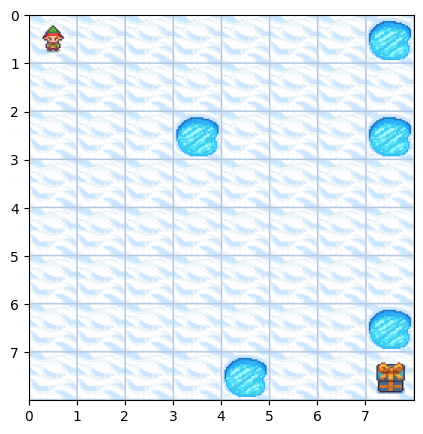

In [7]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

Executamos ações aleatórias para testar o ambiente

In [8]:
print("passo número : ação, posição, recompensa, terminado, truncado, {info}")

for i in range(20):
    # Amostra aleatória de ação válida
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("passo", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

passo número : ação, posição, recompensa, terminado, truncado, {info}
passo 1 : 3 , move up , 0 , 0.0 , False , False , {'prob': 1.0}
passo 2 : 0 , move left , 0 , 0.0 , False , False , {'prob': 1.0}
passo 3 : 0 , move left , 0 , 0.0 , False , False , {'prob': 1.0}
passo 4 : 3 , move up , 0 , 0.0 , False , False , {'prob': 1.0}
passo 5 : 1 , move down , 8 , 0.0 , False , False , {'prob': 1.0}
passo 6 : 2 , move right , 9 , 0.0 , False , False , {'prob': 1.0}
passo 7 : 2 , move right , 10 , 0.0 , False , False , {'prob': 1.0}
passo 8 : 3 , move up , 2 , 0.0 , False , False , {'prob': 1.0}
passo 9 : 3 , move up , 2 , 0.0 , False , False , {'prob': 1.0}
passo 10 : 3 , move up , 2 , 0.0 , False , False , {'prob': 1.0}
passo 11 : 1 , move down , 10 , 0.0 , False , False , {'prob': 1.0}
passo 12 : 3 , move up , 2 , 0.0 , False , False , {'prob': 1.0}
passo 13 : 1 , move down , 10 , 0.0 , False , False , {'prob': 1.0}
passo 14 : 3 , move up , 2 , 0.0 , False , False , {'prob': 1.0}
passo 15 :

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
def save_img_summary(row, filename):
  rewards = row['rewards'].tolist()[0]
  accuracies = row['accuracy'].tolist()[0]
  steps = row['steps'].tolist()[0]
  training_error = row['error'].tolist()[0]

  rolling_length = 100
  fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
  axs[0].set_title("Training Reward")
  axs[0].set_xlabel('episode')
  axs[0].set_ylabel('reward')
  axs[0].bar(range(len(rewards)), rewards)

  axs[1].set_title("Test Reward")
  axs[1].set_xlabel('episode (x 50)')
  axs[1].set_ylabel('accuracy')
  axs[1].plot(range(len(accuracies)), accuracies)

  axs[2].set_title("Episode Length")
  axs[2].set_xlabel('episode')
  axs[2].set_ylabel('step')
  steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
  axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

  axs[3].set_title("Training Error")
  axs[3].set_xlabel('step')
  axs[3].set_ylabel('error')
  training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
  axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
def plot_q_values_map(qtable_val_max, qtable_best_action, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable_val_max, qtable_best_action, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

qtable_val_max = np.zeros((side_map_size, side_map_size))
qtable_best_action = np.zeros((side_map_size, side_map_size))
q_network = agent.get_Q_Network()

counter = 0
while counter < side_map_size * side_map_size:
    qtable_val_max[int(counter / side_map_size)][counter % side_map_size] = agent.max_eval_state(counter)
    qtable_best_action[int(counter / side_map_size)][counter % side_map_size] = agent.eval_state(counter)
    counter = counter + 1

plot_q_values_map(qtable_val_max, qtable_best_action, env, side_map_size)

NameError: name 'agent' is not defined

In [27]:
df_experiments = pd.read_pickle('df_experiments.pkl')


In [31]:
df_experiments['mean_accuracy'] = df_experiments['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_error'] = df_experiments['error'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_steps'] = df_experiments['steps'].apply(lambda x: sum(x)/len(x))

df_sarsa = df_experiments[df_experiments.agent == 'tabular_sarsa']
df_q = df_experiments[df_experiments.agent == 'tabular_q']

best_sarsa_acc = df_sarsa[df_sarsa['mean_accuracy'] == df_sarsa['mean_accuracy'].max()]
best_sarsa_err = df_sarsa[df_sarsa['mean_error'] == df_sarsa['mean_error'].min()]
best_sarsa_stp = df_sarsa[df_sarsa['mean_steps'] == df_sarsa['mean_steps'].max()]

best_q_acc = df_q[df_q['mean_accuracy'] == df_q['mean_accuracy'].max()]
best_q_err = df_q[df_q['mean_error'] == df_q['mean_error'].min()]
best_q_stp = df_q[df_q['mean_steps'] == df_q['mean_steps'].max()]

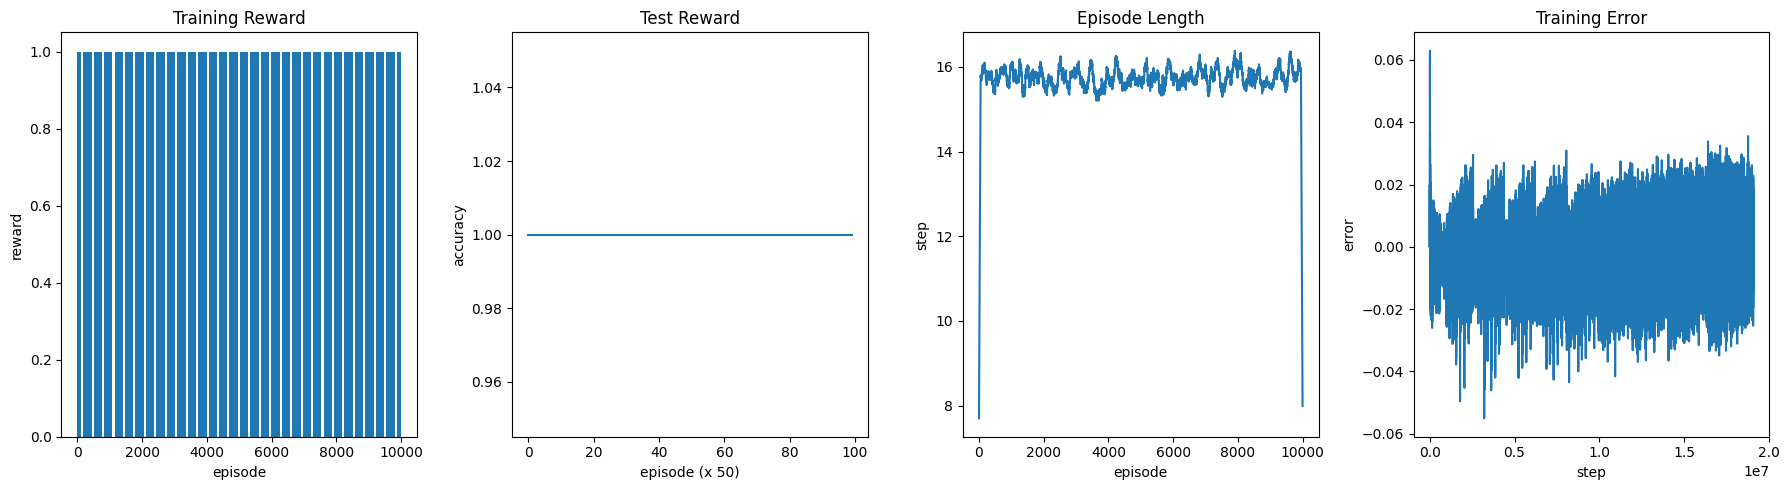

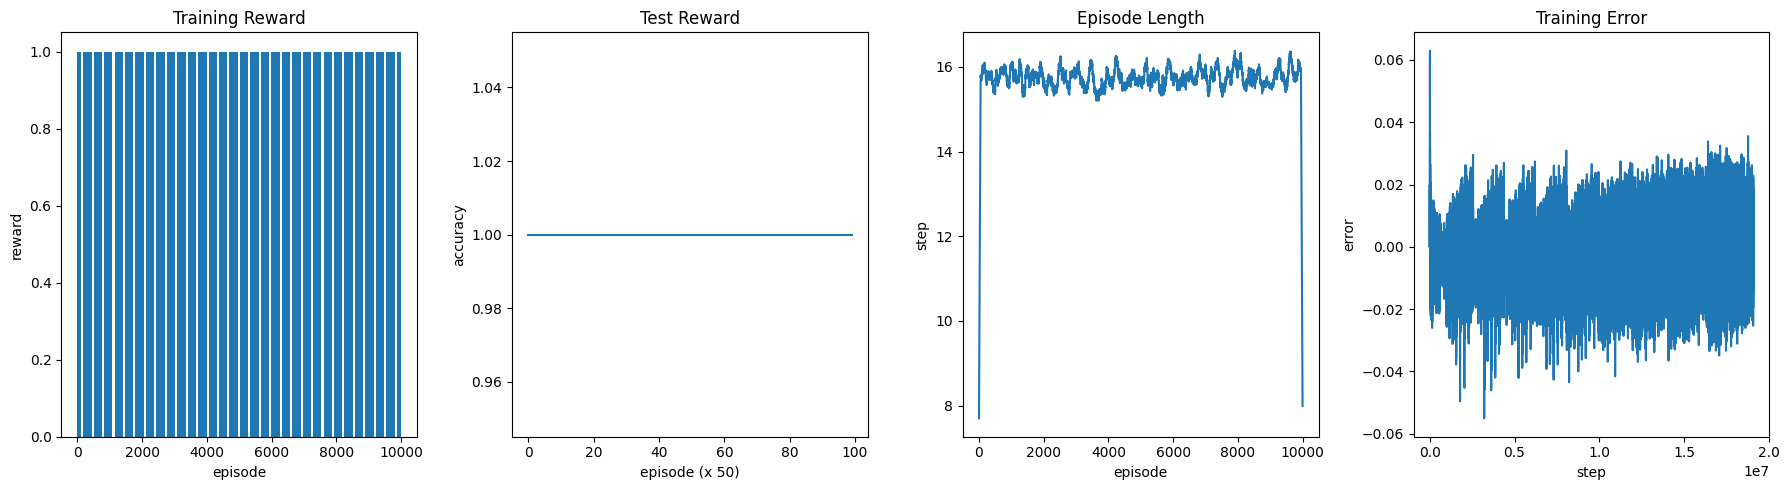

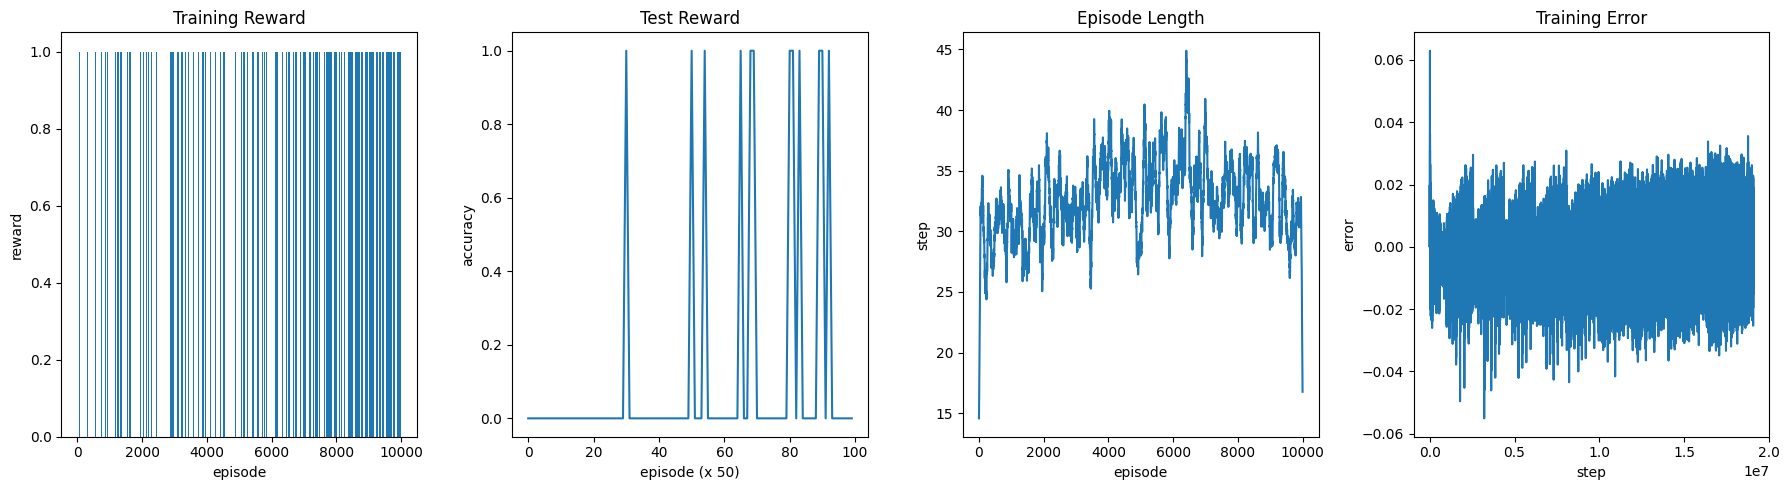

In [33]:
save_img_summary(best_sarsa_acc, 'sarsa_acc.png')
save_img_summary(best_sarsa_err, 'sarsa_err.png')
save_img_summary(best_sarsa_stp, 'sarsa_stp.png')

In [30]:
df_sarsa

alpha  epsilon                                           accuracy  \
0     0.1      0.1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0     0.1      0.2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0     0.1      0.3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0     0.1      0.4  [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0     0.1      0.5  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
..    ...      ...                                                ...   
0     0.9      0.5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...   
0     0.9      0.6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0     0.9      0.7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0     0.9      0.8  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0     0.9      0.9  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              rewards  \
0   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0   [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
0   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
..                                                ...   
0   [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...   
0   [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0   [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   

                                                steps  \
0   [15, 15, 14, 16, 14, 14, 19, 15, 14, 15, 18, 1...   
0   [20, 17, 16, 16, 22, 14, 24, 18, 18, 17, 14, 1...   
0   [17, 20, 23, 22, 19, 20, 18, 16, 25, 21, 20, 2...   
0   [21, 35, 16, 18, 30, 26, 22, 33, 28, 25, 15, 2...   
0   [28, 41, 26, 34, 48, 20, 34, 24, 36, 25, 27, 3...   
..                                                ...   
0   [23, 28, 2, 27, 75, 67, 11, 16, 91, 34, 53, 5,...   
0   [69, 19, 8, 4, 97, 39, 13, 27, 17, 53, 15, 12,...   
0   [2, 62, 17, 56, 21, 45, 22, 26, 35, 62, 8, 35,...   
0   [19, 3, 37, 2, 60, 8, 6, 11, 15, 45, 5, 27, 22...   
0   [8, 14, 2, 5, 13, 27, 53, 82, 10, 17, 16, 14, ...   

                                                error          agent  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
..                                                ...            ...  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa  

[81 rows x 7 columns]

In [11]:
df_experiments_cp = pd.read_pickle('df_experiments_cp.pkl')

In [12]:
df_experiments_cp['mean_accuracy'] = df_experiments_cp['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments_cp['mean_error'] = df_experiments_cp['error'].apply(lambda x: sum(x)/len(x))
df_experiments_cp['mean_steps'] = df_experiments_cp['steps'].apply(lambda x: sum(x)/len(x))

df_sarsa_cp = df_experiments_cp[df_experiments_cp.agent == 'tabular_sarsa']
df_q_cp = df_experiments_cp[df_experiments_cp.agent == 'tabular_q']

best_sarsa_acc_cp = df_sarsa_cp[df_sarsa_cp['mean_accuracy'] == df_sarsa_cp['mean_accuracy'].max()]
best_sarsa_err_cp = df_sarsa_cp[df_sarsa_cp['mean_error'] == df_sarsa_cp['mean_error'].min()]
best_sars_stp_cp = df_sarsa_cp[df_sarsa_cp['mean_steps'] == df_sarsa_cp['mean_steps'].max()]

best_q_acc_cp = df_q_cp[df_q_cp['mean_accuracy'] == df_q_cp['mean_accuracy'].max()]
best_q_err_cp = df_q_cp[df_q_cp['mean_error'] == df_q_cp['mean_error'].min()]
best_q_stp_cp = df_q_cp[df_q_cp['mean_steps'] == df_q_cp['mean_steps'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


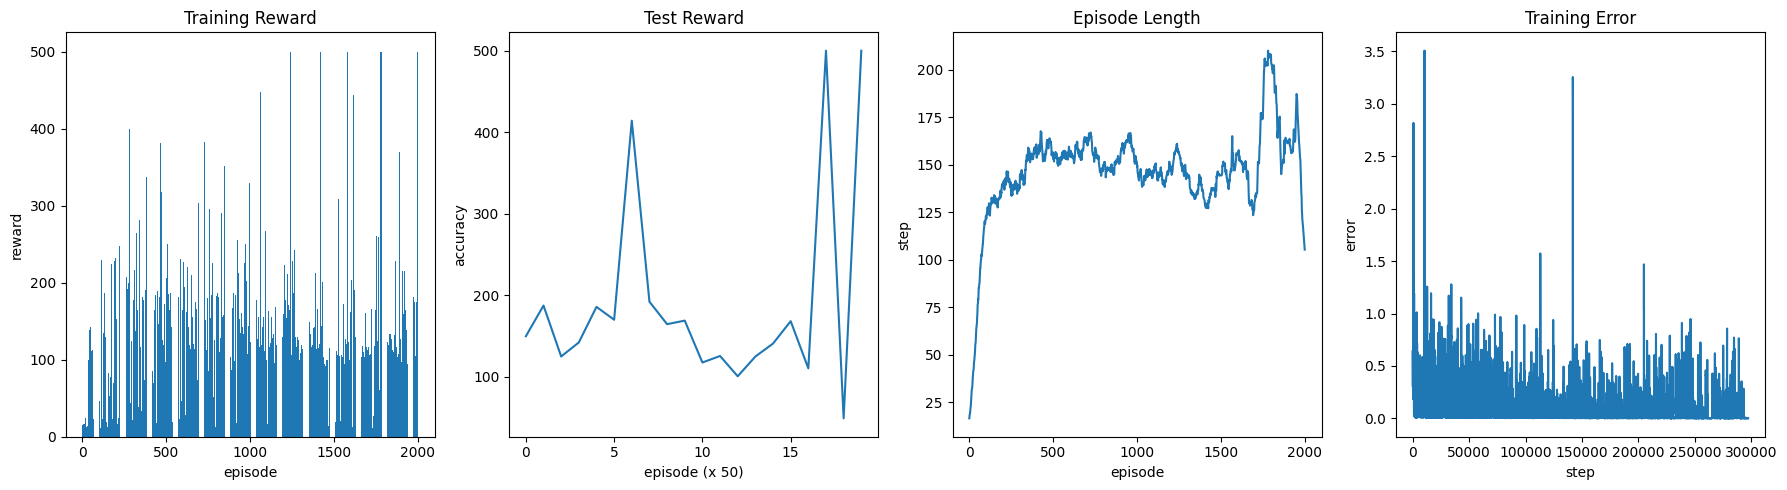

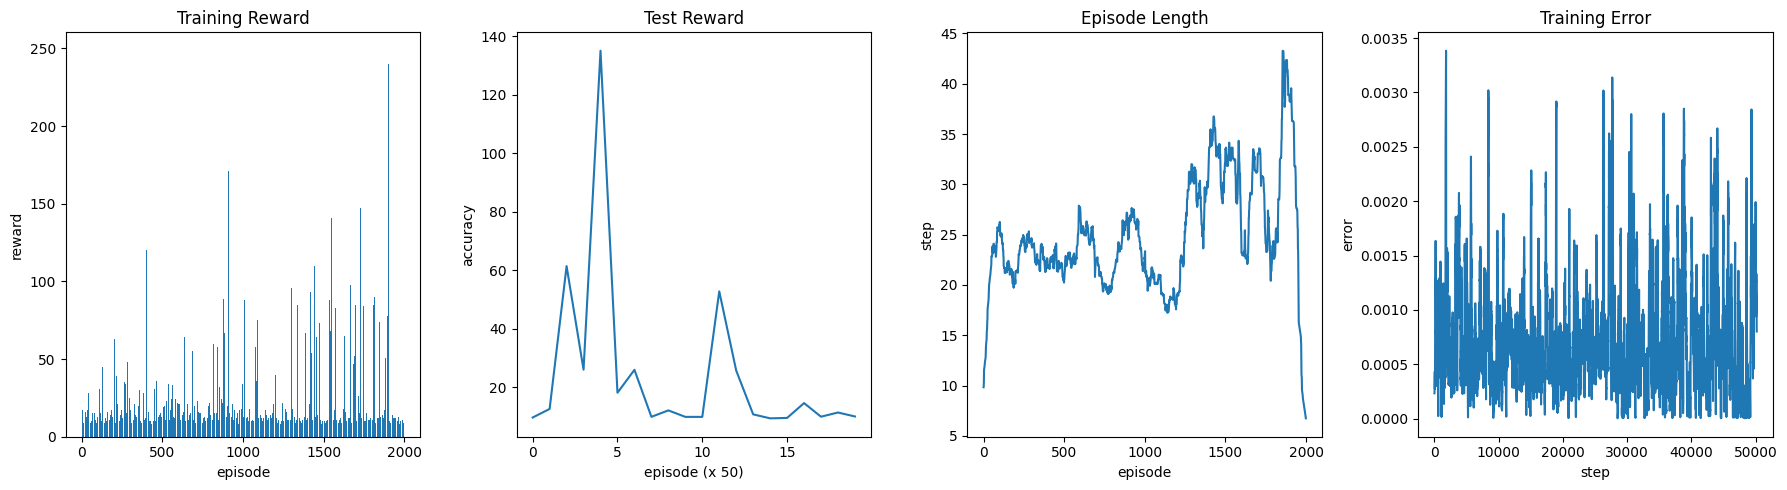

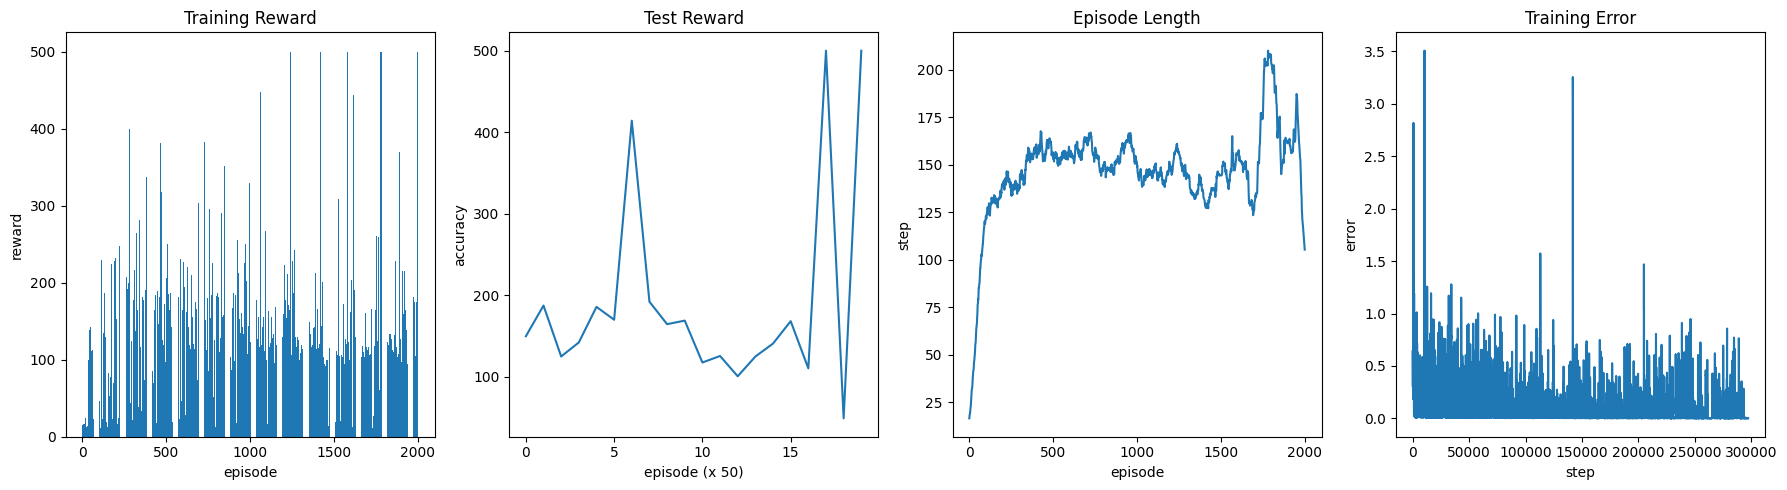

In [25]:
save_img_summary(best_sarsa_acc_cp, 'sarsa_acc_cp.png')
save_img_summary(best_sarsa_err_cp, 'sarsa_err_cp.png')
save_img_summary(best_sars_stp_cp, 'sarsa_stp_cp.png')

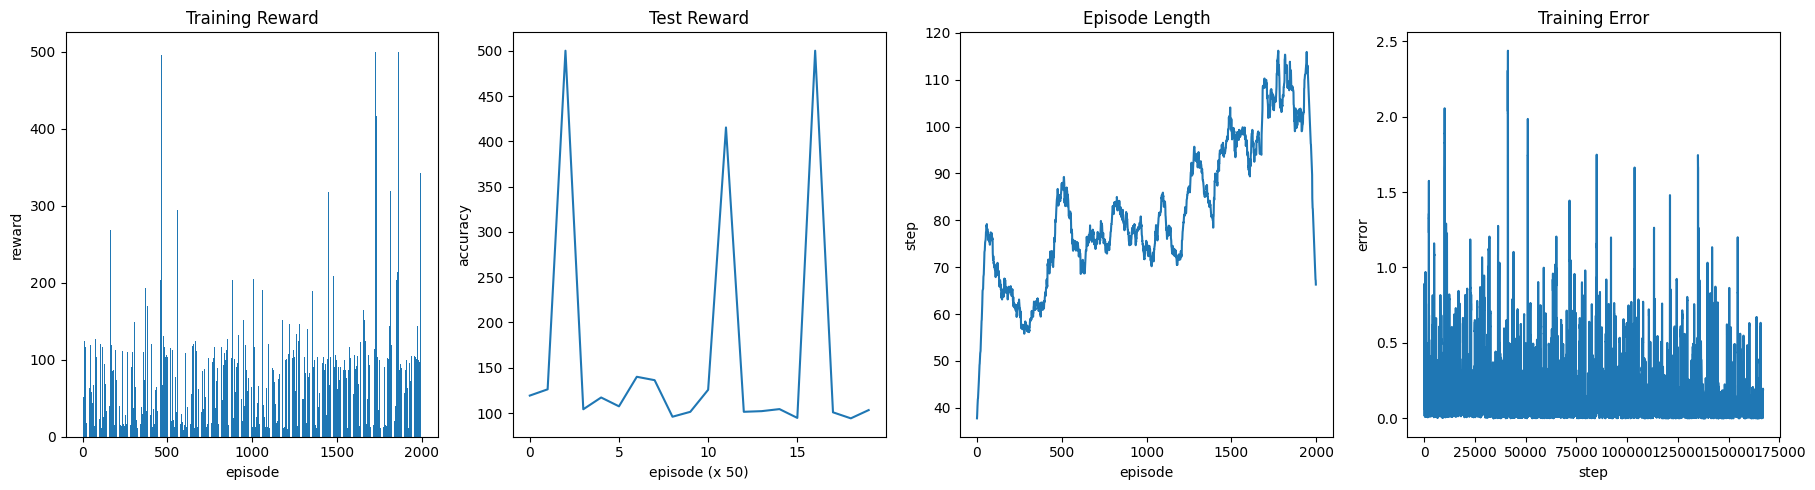

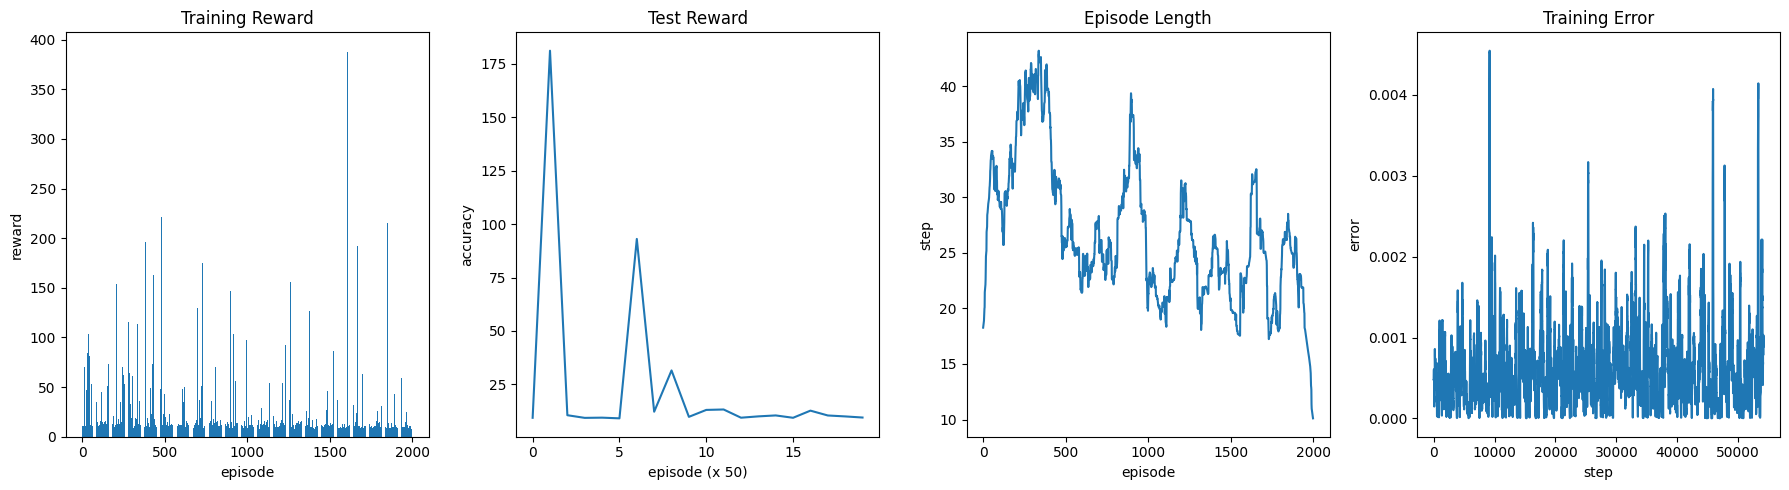

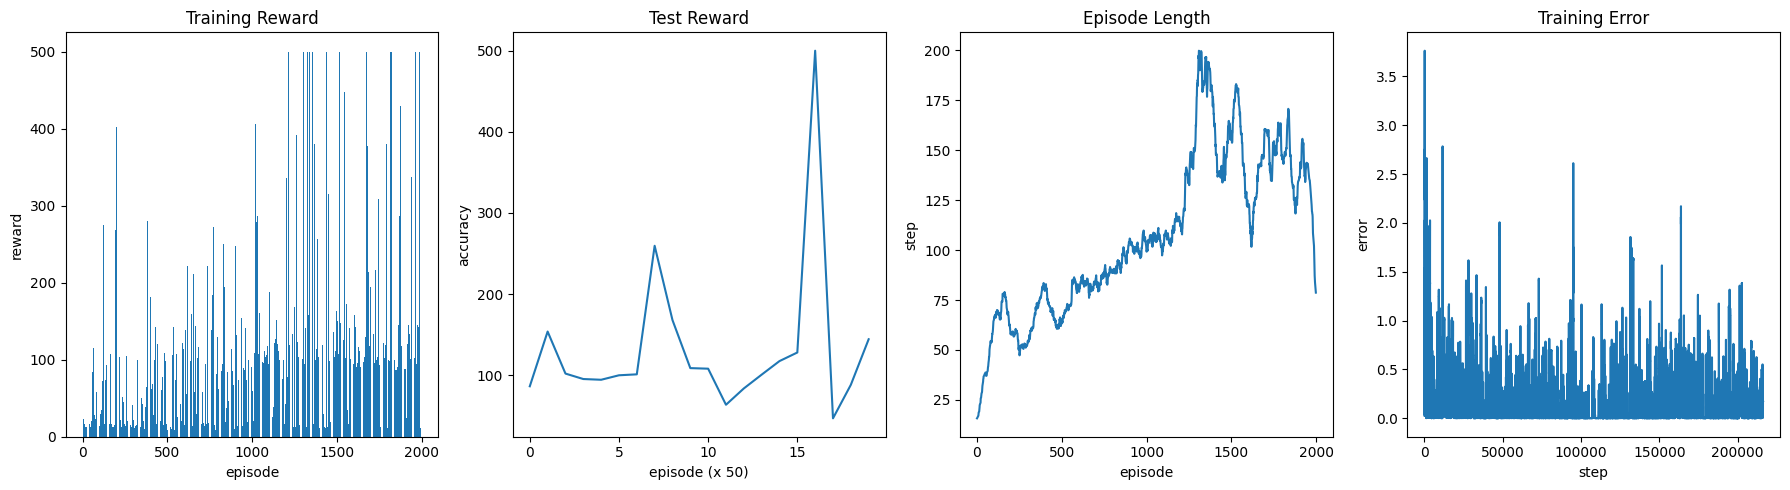

In [85]:
save_img_summary(best_q_acc_cp, 'q_acc_cp.png')
save_img_summary(best_q_err_cp, 'q_err_cp.png')
save_img_summary(best_q_stp_cp, 'q_stp_cp.png')

In [45]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 52 : move down , 60 , 0.0 , True , False , {'prob': 1.0}


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Criando uma estratégia SARSA ou Q-Learning tabular para o Frozen Lake

A classe a seguir

In [34]:
class FrozenLakeAgent:
    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int,
        is_using_Sarsa: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        if(self.is_using_Sarsa):
            print("Using Sarsa method")
        else:
            print("Using Q-learning method")

        # Set the seed
        self.rng = np.random.default_rng(100785)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
            if(self.is_using_Sarsa):
                target = reward + self.gamma_discount_factor * self.q_table[next_state, next_action]

            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            else:
                target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [35]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [36]:
def record_trained_video(agent, video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [37]:
def save_imgs(training_error, rewards, accuracies, steps, filename):
  rolling_length = 100
  fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
  axs[0].set_title("Training Reward")
  axs[0].set_xlabel('episode')
  axs[0].set_ylabel('reward')
  axs[0].bar(range(len(rewards)), rewards)

  axs[1].set_title("Test Reward")
  axs[1].set_xlabel('episode (x 50)')
  axs[1].set_ylabel('accuracy')
  axs[1].plot(range(len(accuracies)), accuracies)

  axs[2].set_title("Episode Length")
  axs[2].set_xlabel('episode')
  axs[2].set_ylabel('step')
  steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
  axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

  axs[3].set_title("Training Error")
  axs[3].set_xlabel('step')
  axs[3].set_ylabel('error')
  training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
  axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

In [46]:
from tqdm import tqdm
def train_agent(agent, is_using_Sarsa):
  #Create lists to contain total rewards, steps and accurracy per episode
  accuracies = []
  mean_rewards = []
  rewards = []
  steps = []
  total_steps = 0

  for episode_count in tqdm(range(nb_max_episodes)):
      state, info = env.reset()
      is_terminal = False
      total_reward = 0
      episode_step = 0

      if(is_using_Sarsa): # Sarsa
          # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
          action = agent.choose_action(state)

      # The Q-Table training
      while not is_terminal:
          episode_step += 1

          if(not is_using_Sarsa): # Q-learning
              # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
              action = agent.choose_action(state)

          # Play best or random move and get new state and reward from environment
          next_state, reward, terminated, truncated, info = env.step(action)
          is_terminal = terminated or truncated

          # update the agent
          if(not is_using_Sarsa): # Q-learning
              agent.update(state, action, reward, terminated, next_state, None)
          else: # Sarsa
              next_action = agent.choose_action(next_state)
              agent.update(state, action, reward, terminated, next_state, next_action)
              action = next_action

          # update the current observation
          state = next_state
          total_steps += 1
          total_reward += reward

      agent.decay_epsilon()

      mean_rewards.append(total_reward)
      if (episode_count+1) % test_freq == 0:
          accur = test_accurracy(agent, env.spec.max_episode_steps,50)
          accuracies.append(accur)

          print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
          mean_rewards.clear()

      rewards.append(total_reward)
      steps.append(episode_step)

  env.close()
  return rewards, steps, accuracies



In [47]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 10000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent_sarsa = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = True
)

agent_q = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = False
)


Using Sarsa method
Using Q-learning method


In [48]:
from itertools import product

In [49]:
alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

In [50]:
len(list(product(*[alphas, epsilons, gammas])))

27

In [51]:
df_experiments = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha} e epsilon {epsilon}')
            agent_sarsa = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = True
            )

            agent_q = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = False
            )

            rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            error = agent_sarsa.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            error = agent_q.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments)}')


Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  1%|▏         | 135/10000 [00:01<01:53, 87.22it/s]

step: 4146, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1959999999999988


  3%|▎         | 268/10000 [00:02<00:48, 199.02it/s]

step: 8160, episode: 200, accuracy training: 0.04, accuracy test: 0.16, random move probability: 0.19199999999999756


  4%|▍         | 375/10000 [00:02<00:28, 340.76it/s]

step: 10365, episode: 300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.18799999999999634
step: 12087, episode: 400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1839999999999951


  5%|▌         | 544/10000 [00:02<00:25, 364.85it/s]

step: 13775, episode: 500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 701/10000 [00:03<00:22, 415.76it/s]

step: 15421, episode: 600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 17087, episode: 700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:03<00:13, 654.60it/s]

step: 18721, episode: 800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 20338, episode: 900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:03<00:11, 747.91it/s]

step: 22013, episode: 1000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 23559, episode: 1100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15599999999998654


 14%|█▎        | 1369/10000 [00:03<00:10, 825.33it/s]

step: 25177, episode: 1200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 26810, episode: 1300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1537/10000 [00:04<00:10, 785.76it/s]

step: 28469, episode: 1400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 30073, episode: 1500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1683/10000 [00:04<00:15, 541.31it/s]

step: 31682, episode: 1600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13599999999998041


 17%|█▋        | 1744/10000 [00:04<00:20, 399.23it/s]

step: 33274, episode: 1700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1900/10000 [00:04<00:15, 534.92it/s]

step: 34819, episode: 1800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 36370, episode: 1900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:05<00:11, 714.93it/s]

step: 37963, episode: 2000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 39507, episode: 2100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2300/10000 [00:05<00:09, 795.80it/s]

step: 41079, episode: 2200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 42624, episode: 2300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2500/10000 [00:05<00:09, 831.65it/s]

step: 44162, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 45694, episode: 2500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:05<00:08, 870.47it/s]

step: 47169, episode: 2600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 48673, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:06<00:07, 902.99it/s]

step: 50202, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 51753, episode: 2900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:06<00:07, 901.73it/s]

step: 53318, episode: 3000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 54824, episode: 3100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:06<00:07, 909.40it/s]

step: 56388, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 57909, episode: 3300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3583/10000 [00:06<00:07, 886.05it/s]

step: 59483, episode: 3400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 61006, episode: 3500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3764/10000 [00:07<00:07, 886.05it/s]

step: 62501, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 64017, episode: 3700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3945/10000 [00:07<00:06, 888.74it/s]

step: 65538, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 67077, episode: 3900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4122/10000 [00:07<00:06, 854.06it/s]

step: 68648, episode: 4000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 70175, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:07<00:07, 795.82it/s]

step: 71698, episode: 4200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 73274, episode: 4300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:07<00:06, 832.70it/s]

step: 74830, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 76376, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:08<00:06, 880.97it/s]

step: 77911, episode: 4600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 79479, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:08<00:05, 892.59it/s]

step: 81014, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 82568, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5100/10000 [00:08<00:05, 903.19it/s]

step: 84072, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 85616, episode: 5100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5378/10000 [00:08<00:05, 893.02it/s]

step: 87131, episode: 5200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 88682, episode: 5300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5564/10000 [00:09<00:04, 908.36it/s]

step: 90232, episode: 5400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 91743, episode: 5500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 57%|█████▊    | 5750/10000 [00:09<00:04, 898.13it/s]

step: 93294, episode: 5600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 94830, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5932/10000 [00:09<00:04, 891.85it/s]

step: 96358, episode: 5800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 97870, episode: 5900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6109/10000 [00:09<00:04, 791.05it/s]

step: 99399, episode: 6000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 100908, episode: 6100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:09<00:04, 857.88it/s]

step: 102435, episode: 6200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 103967, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:10<00:03, 894.36it/s]

step: 105502, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 107009, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:10<00:03, 896.29it/s]

step: 108528, episode: 6600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 110009, episode: 6700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:10<00:03, 901.02it/s]

step: 111525, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 113028, episode: 6900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7178/10000 [00:10<00:03, 897.59it/s]

step: 114545, episode: 7000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 116070, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 74%|███████▎  | 7365/10000 [00:11<00:02, 909.10it/s]

step: 117597, episode: 7200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 119094, episode: 7300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7457/10000 [00:11<00:02, 900.52it/s]

step: 120617, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 122178, episode: 7500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7701/10000 [00:11<00:03, 626.54it/s]

step: 123715, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 125239, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:12<00:03, 590.09it/s]

step: 126768, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 128285, episode: 7900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8113/10000 [00:12<00:03, 590.03it/s]

step: 129825, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 131376, episode: 8100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8259/10000 [00:12<00:02, 597.49it/s]

step: 132893, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8376/10000 [00:12<00:03, 460.97it/s]

step: 134432, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8495/10000 [00:13<00:03, 467.39it/s]

step: 135956, episode: 8400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8547/10000 [00:13<00:03, 420.61it/s]

step: 137500, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8677/10000 [00:13<00:02, 497.63it/s]

step: 139013, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 140552, episode: 8700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8875/10000 [00:14<00:02, 533.77it/s]

step: 142130, episode: 8800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 143663, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9080/10000 [00:14<00:01, 581.01it/s]

step: 145232, episode: 9000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 146755, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9266/10000 [00:14<00:01, 537.19it/s]

step: 148248, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 149748, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9557/10000 [00:15<00:00, 702.14it/s]

step: 151261, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 152788, episode: 9500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9717/10000 [00:15<00:00, 748.80it/s]

step: 154317, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 155839, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:15<00:00, 802.43it/s]

step: 157394, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 158908, episode: 9900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 635.11it/s]
<ipython-input-51-74fc773e9f57>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],


step: 160427, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


  2%|▏         | 175/10000 [00:00<00:30, 324.86it/s]

step: 4421, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 251/10000 [00:00<00:31, 309.02it/s]

step: 9081, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▎         | 372/10000 [00:01<00:31, 308.19it/s]

step: 13488, episode: 300, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.18799999999999634


  4%|▍         | 446/10000 [00:01<00:32, 290.61it/s]

step: 18178, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:01<00:22, 419.82it/s]

step: 23076, episode: 500, accuracy training: 0.07, accuracy test: 0.36, random move probability: 0.1799999999999939
step: 24923, episode: 600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 838/10000 [00:02<00:14, 637.19it/s]

step: 26711, episode: 700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 28430, episode: 800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1000/10000 [00:02<00:13, 691.00it/s]

step: 30069, episode: 900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.163999999999989
step: 31737, episode: 1000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1200/10000 [00:02<00:11, 784.67it/s]

step: 33409, episode: 1100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 35062, episode: 1200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1519999999999853


 15%|█▍        | 1457/10000 [00:02<00:10, 814.52it/s]

step: 36684, episode: 1300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 38311, episode: 1400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▋        | 1627/10000 [00:03<00:10, 795.82it/s]

step: 39925, episode: 1500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 41512, episode: 1600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:03<00:09, 826.29it/s]

step: 43140, episode: 1700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 44701, episode: 1800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12799999999997796


 21%|██        | 2074/10000 [00:03<00:09, 854.48it/s]

step: 46267, episode: 1900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 47841, episode: 2000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2244/10000 [00:03<00:09, 818.27it/s]

step: 49416, episode: 2100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 51016, episode: 2200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2406/10000 [00:04<00:09, 773.94it/s]

step: 52617, episode: 2300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 54173, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2600/10000 [00:04<00:08, 826.46it/s]

step: 55730, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 57268, episode: 2600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:04<00:08, 824.04it/s]

step: 58771, episode: 2700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 60348, episode: 2800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:04<00:08, 837.96it/s]

step: 61868, episode: 2900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 63450, episode: 3000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:04<00:08, 816.31it/s]

step: 65027, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 66564, episode: 3200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:05<00:07, 852.15it/s]

step: 68125, episode: 3300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 69674, episode: 3400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3587/10000 [00:05<00:07, 843.07it/s]

step: 71201, episode: 3500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 72749, episode: 3600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3839/10000 [00:05<00:07, 803.35it/s]

step: 74287, episode: 3700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 75860, episode: 3800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4001/10000 [00:05<00:07, 757.81it/s]

step: 77442, episode: 3900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 78970, episode: 4000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:06<00:07, 825.90it/s]

step: 80519, episode: 4100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 82076, episode: 4200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4475/10000 [00:06<00:06, 833.75it/s]

step: 83630, episode: 4300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 85168, episode: 4400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 46%|████▋     | 4641/10000 [00:06<00:06, 806.09it/s]

step: 86701, episode: 4500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 88270, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4800/10000 [00:06<00:06, 749.89it/s]

step: 89824, episode: 4700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 91320, episode: 4800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:07<00:06, 819.32it/s]

step: 92855, episode: 4900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 94410, episode: 5000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:07<00:05, 852.53it/s]

step: 95963, episode: 5100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 97485, episode: 5200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5463/10000 [00:07<00:05, 858.17it/s]

step: 99033, episode: 5300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 100540, episode: 5400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 56%|█████▋    | 5634/10000 [00:07<00:05, 800.06it/s]

step: 102044, episode: 5500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 103533, episode: 5600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5800/10000 [00:08<00:05, 796.44it/s]

step: 105083, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 106571, episode: 5800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6000/10000 [00:08<00:04, 834.07it/s]

step: 108088, episode: 5900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 109557, episode: 6000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:08<00:04, 827.70it/s]

step: 111094, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 112599, episode: 6200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6400/10000 [00:08<00:04, 864.12it/s]

step: 114107, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 115605, episode: 6400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6666/10000 [00:09<00:03, 848.88it/s]

step: 117121, episode: 6500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 118650, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6752/10000 [00:09<00:04, 795.63it/s]

step: 120172, episode: 6700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 121727, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6981/10000 [00:09<00:04, 656.60it/s]

step: 123232, episode: 6900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 124683, episode: 7000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7196/10000 [00:10<00:04, 634.57it/s]

step: 126209, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 127719, episode: 7200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7400/10000 [00:10<00:04, 574.68it/s]

step: 129239, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 130773, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:10<00:04, 565.72it/s]

step: 132260, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 133763, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:11<00:03, 550.70it/s]

step: 135277, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 136789, episode: 7800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8003/10000 [00:11<00:03, 536.00it/s]

step: 138293, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 139896, episode: 8000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8194/10000 [00:11<00:03, 551.97it/s]

step: 141414, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8304/10000 [00:12<00:03, 482.02it/s]

step: 142946, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 144444, episode: 8300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:12<00:02, 516.11it/s]

step: 145920, episode: 8400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 147400, episode: 8500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8698/10000 [00:12<00:02, 546.49it/s]

step: 148986, episode: 8600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 150520, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8884/10000 [00:13<00:02, 553.29it/s]

step: 152046, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 153573, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 91%|█████████▏| 9129/10000 [00:13<00:01, 723.21it/s]

step: 155085, episode: 9000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 156550, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:13<00:00, 750.78it/s]

step: 158053, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 159587, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9564/10000 [00:14<00:00, 806.01it/s]

step: 161125, episode: 9400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 162611, episode: 9500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9729/10000 [00:14<00:00, 803.40it/s]

step: 164156, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 165695, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:14<00:00, 819.66it/s]

step: 167238, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 168728, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:14<00:00, 685.58it/s]


step: 170221, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
Len experiments 2
Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 183/10000 [00:00<00:26, 365.34it/s]

step: 4398, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 349/10000 [00:00<00:15, 606.30it/s]

step: 8310, episode: 200, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.19199999999999756
step: 10012, episode: 300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▌         | 520/10000 [00:00<00:12, 739.32it/s]

step: 11744, episode: 400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1839999999999951
step: 13382, episode: 500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:11, 824.67it/s]

step: 14974, episode: 600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 16515, episode: 700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 899/10000 [00:01<00:10, 880.43it/s]

step: 18149, episode: 800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 19802, episode: 900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.163999999999989


 12%|█▏        | 1171/10000 [00:01<00:10, 876.66it/s]

step: 21415, episode: 1000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 23043, episode: 1100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1347/10000 [00:01<00:10, 859.63it/s]

step: 24621, episode: 1200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 26223, episode: 1300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1521/10000 [00:02<00:10, 819.07it/s]

step: 27818, episode: 1400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 29345, episode: 1500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1700/10000 [00:02<00:10, 794.34it/s]

step: 30914, episode: 1600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 32515, episode: 1700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1319999999999792


 20%|█▉        | 1986/10000 [00:02<00:08, 891.85it/s]

step: 34013, episode: 1800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 35545, episode: 1900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1239999999999771


 22%|██▏       | 2169/10000 [00:02<00:08, 884.97it/s]

step: 37053, episode: 2000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 38591, episode: 2100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2348/10000 [00:03<00:08, 869.99it/s]

step: 40141, episode: 2200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 41709, episode: 2300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2523/10000 [00:03<00:08, 852.15it/s]

step: 43286, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 44824, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:03<00:09, 796.86it/s]

step: 46368, episode: 2600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 47934, episode: 2700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:03<00:08, 864.05it/s]

step: 49488, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 51011, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:03<00:07, 879.96it/s]

step: 52553, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 54072, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:04<00:07, 894.32it/s]

step: 55572, episode: 3200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 57089, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:04<00:07, 834.05it/s]

step: 58636, episode: 3400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 60184, episode: 3500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:04<00:07, 878.59it/s]

step: 61693, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 63222, episode: 3700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:04<00:06, 916.87it/s]

step: 64718, episode: 3800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 66216, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:05<00:06, 893.09it/s]

step: 67780, episode: 4000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 69311, episode: 4100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:05<00:06, 886.80it/s]

step: 70834, episode: 4200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 72367, episode: 4300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4585/10000 [00:05<00:06, 895.82it/s]

step: 73881, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 75416, episode: 4500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4764/10000 [00:05<00:05, 880.02it/s]

step: 76936, episode: 4600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 78468, episode: 4700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4942/10000 [00:06<00:05, 867.37it/s]

step: 79998, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 81525, episode: 4900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5115/10000 [00:06<00:05, 857.29it/s]

step: 83028, episode: 5000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 84553, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5300/10000 [00:06<00:05, 799.98it/s]

step: 86094, episode: 5200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 87605, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:06<00:05, 869.35it/s]

step: 89108, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 90627, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:06<00:04, 879.42it/s]

step: 92174, episode: 5600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 93708, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:07<00:04, 898.45it/s]

step: 95234, episode: 5800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 96780, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:07<00:04, 880.34it/s]

step: 98283, episode: 6000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 99770, episode: 6100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:07<00:04, 872.98it/s]

step: 101299, episode: 6200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 102815, episode: 6300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:07<00:03, 902.06it/s]

step: 104326, episode: 6400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 105802, episode: 6500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:08<00:03, 891.56it/s]

step: 107337, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 108859, episode: 6700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:08<00:03, 883.84it/s]

step: 110400, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 111921, episode: 6900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:08<00:03, 868.96it/s]

step: 113434, episode: 7000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 114971, episode: 7100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:08<00:03, 852.72it/s]

step: 116483, episode: 7200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 117983, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7469/10000 [00:08<00:03, 727.31it/s]

step: 119503, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 121060, episode: 7500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7689/10000 [00:09<00:03, 639.74it/s]

step: 122583, episode: 7600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 124120, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:09<00:03, 574.99it/s]

step: 125619, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 127108, episode: 7900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8107/10000 [00:10<00:03, 581.38it/s]

step: 128643, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 130163, episode: 8100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8261/10000 [00:10<00:03, 571.90it/s]

step: 131654, episode: 8200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 133205, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8483/10000 [00:10<00:02, 624.50it/s]

step: 134756, episode: 8400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 136301, episode: 8500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8697/10000 [00:11<00:02, 637.67it/s]

step: 137845, episode: 8600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 139376, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8899/10000 [00:11<00:01, 588.58it/s]

step: 140911, episode: 8800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 142424, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9095/10000 [00:11<00:01, 572.71it/s]

step: 143968, episode: 9000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 145492, episode: 9100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9288/10000 [00:12<00:01, 553.29it/s]

step: 147013, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 148522, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9514/10000 [00:12<00:00, 655.77it/s]

step: 150023, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 151487, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:12<00:00, 752.13it/s]

step: 153026, episode: 9600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 154554, episode: 9700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:13<00:00, 809.43it/s]

step: 156090, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 157628, episode: 9900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 762.32it/s]


step: 159131, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


  2%|▏         | 174/10000 [00:00<00:28, 342.05it/s]

step: 4245, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1959999999999988


  3%|▎         | 309/10000 [00:00<00:18, 521.48it/s]

step: 7987, episode: 200, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.19199999999999756
step: 9741, episode: 300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▌         | 500/10000 [00:00<00:13, 678.62it/s]

step: 11458, episode: 400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1839999999999951
step: 13091, episode: 500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:12, 730.12it/s]

step: 14759, episode: 600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 16458, episode: 700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:01<00:11, 805.06it/s]

step: 18086, episode: 800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 19701, episode: 900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1092/10000 [00:01<00:10, 846.18it/s]

step: 21349, episode: 1000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 22994, episode: 1100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15599999999998654


 14%|█▎        | 1352/10000 [00:01<00:10, 841.33it/s]

step: 24575, episode: 1200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 26148, episode: 1300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1521/10000 [00:02<00:10, 823.44it/s]

step: 27678, episode: 1400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 29216, episode: 1500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1700/10000 [00:02<00:10, 819.86it/s]

step: 30816, episode: 1600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 32357, episode: 1700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1900/10000 [00:02<00:09, 846.13it/s]

step: 33935, episode: 1800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 35507, episode: 1900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:02<00:09, 844.78it/s]

step: 37057, episode: 2000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 38595, episode: 2100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2300/10000 [00:03<00:08, 869.26it/s]

step: 40094, episode: 2200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 41601, episode: 2300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2500/10000 [00:03<00:09, 830.73it/s]

step: 43121, episode: 2400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 44650, episode: 2500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:03<00:08, 862.20it/s]

step: 46195, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 47684, episode: 2700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:03<00:08, 851.67it/s]

step: 49191, episode: 2800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 50705, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:04<00:07, 867.33it/s]

step: 52244, episode: 3000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 53750, episode: 3100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3385/10000 [00:04<00:07, 892.17it/s]

step: 55301, episode: 3200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 56824, episode: 3300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3565/10000 [00:04<00:07, 878.19it/s]

step: 58327, episode: 3400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 59853, episode: 3500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3739/10000 [00:04<00:07, 818.66it/s]

step: 61325, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 62843, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3913/10000 [00:05<00:07, 831.23it/s]

step: 64364, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 65903, episode: 3900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:05<00:07, 815.65it/s]

step: 67390, episode: 4000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 68907, episode: 4100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:05<00:06, 846.76it/s]

step: 70459, episode: 4200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 71976, episode: 4300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:05<00:06, 863.81it/s]

step: 73489, episode: 4400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 75014, episode: 4500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:05<00:06, 833.47it/s]

step: 76512, episode: 4600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 78030, episode: 4700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:06<00:06, 836.82it/s]

step: 79566, episode: 4800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 81095, episode: 4900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5173/10000 [00:06<00:05, 874.94it/s]

step: 82631, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 84140, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5347/10000 [00:06<00:05, 848.05it/s]

step: 85662, episode: 5200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 87168, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5520/10000 [00:06<00:05, 827.70it/s]

step: 88698, episode: 5400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 90222, episode: 5500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:07<00:05, 820.14it/s]

step: 91751, episode: 5600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 93283, episode: 5700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5951/10000 [00:07<00:05, 801.53it/s]

step: 94786, episode: 5800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 96304, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6120/10000 [00:07<00:04, 811.83it/s]

step: 97825, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 99338, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6284/10000 [00:07<00:04, 794.77it/s]

step: 100890, episode: 6200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 102451, episode: 6300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6525/10000 [00:08<00:04, 759.39it/s]

step: 103943, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 105488, episode: 6500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:08<00:04, 784.73it/s]

step: 107048, episode: 6600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 108571, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:08<00:03, 850.44it/s]

step: 110085, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 111545, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:08<00:03, 833.82it/s]

step: 113072, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 114573, episode: 7100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:09<00:03, 836.27it/s]

step: 116073, episode: 7200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 117605, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7477/10000 [00:09<00:03, 719.45it/s]

step: 119146, episode: 7400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 120657, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:09<00:03, 594.18it/s]

step: 122213, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 123695, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7898/10000 [00:10<00:03, 588.78it/s]

step: 125235, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 126723, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8089/10000 [00:10<00:03, 587.07it/s]

step: 128231, episode: 8000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 129764, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8291/10000 [00:10<00:02, 620.62it/s]

step: 131280, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 132835, episode: 8300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8483/10000 [00:11<00:02, 591.07it/s]

step: 134358, episode: 8400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8600/10000 [00:11<00:02, 503.31it/s]

step: 135877, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 137393, episode: 8600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8791/10000 [00:11<00:02, 552.80it/s]

step: 138889, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8901/10000 [00:12<00:02, 476.69it/s]

step: 140437, episode: 8800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 141992, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9067/10000 [00:12<00:01, 502.75it/s]

step: 143551, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 145058, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:12<00:01, 472.98it/s]

step: 146582, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 148050, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:13<00:00, 583.25it/s]

step: 149595, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 151152, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:13<00:00, 697.81it/s]

step: 152671, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 154169, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:13<00:00, 797.24it/s]

step: 155723, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 157224, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 723.84it/s]


step: 158728, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
Len experiments 4
Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  1%|▏         | 138/10000 [00:00<00:34, 286.66it/s]

step: 4353, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 303/10000 [00:00<00:21, 457.27it/s]

step: 8625, episode: 200, accuracy training: 0.08, accuracy test: 0.42, random move probability: 0.19199999999999756
step: 10560, episode: 300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▌         | 500/10000 [00:00<00:14, 649.47it/s]

step: 12260, episode: 400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1839999999999951
step: 14030, episode: 500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:12, 736.42it/s]

step: 15750, episode: 600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 17519, episode: 700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 943/10000 [00:01<00:12, 752.57it/s]

step: 19314, episode: 800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 21069, episode: 900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1106/10000 [00:01<00:11, 779.32it/s]

step: 22833, episode: 1000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 24466, episode: 1100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1300/10000 [00:01<00:10, 825.91it/s]

step: 26175, episode: 1200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 27866, episode: 1300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1479999999999841


 16%|█▌        | 1565/10000 [00:02<00:10, 833.62it/s]

step: 29538, episode: 1400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 31236, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1729/10000 [00:02<00:11, 741.77it/s]

step: 32900, episode: 1600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 34558, episode: 1700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1900/10000 [00:02<00:10, 795.22it/s]

step: 36196, episode: 1800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 37844, episode: 1900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1239999999999771


 22%|██▏       | 2180/10000 [00:03<00:09, 851.39it/s]

step: 39481, episode: 2000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 41138, episode: 2100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11599999999997743


 24%|██▎       | 2352/10000 [00:03<00:09, 842.29it/s]

step: 42727, episode: 2200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 44337, episode: 2300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2521/10000 [00:03<00:09, 784.10it/s]

step: 45883, episode: 2400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 47503, episode: 2500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:03<00:08, 826.96it/s]

step: 49100, episode: 2600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 50666, episode: 2700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:03<00:08, 830.04it/s]

step: 52322, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 53883, episode: 2900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:04<00:08, 859.60it/s]

step: 55426, episode: 3000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 56985, episode: 3100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3286/10000 [00:04<00:07, 840.90it/s]

step: 58551, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 60114, episode: 3300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3543/10000 [00:04<00:07, 824.14it/s]

step: 61732, episode: 3400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 63307, episode: 3500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3709/10000 [00:04<00:07, 826.38it/s]

step: 64874, episode: 3600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 66455, episode: 3700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:05<00:07, 860.76it/s]

step: 67996, episode: 3800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 69534, episode: 3900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:05<00:07, 816.94it/s]

step: 71081, episode: 4000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 72661, episode: 4100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 44%|████▎     | 4373/10000 [00:05<00:06, 857.42it/s]

step: 74247, episode: 4200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 75805, episode: 4300, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4547/10000 [00:05<00:06, 840.47it/s]

step: 77371, episode: 4400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 78937, episode: 4500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4718/10000 [00:06<00:06, 814.41it/s]

step: 80449, episode: 4600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 81993, episode: 4700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:06<00:06, 785.50it/s]

step: 83577, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 85106, episode: 4900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 51%|█████▏    | 5139/10000 [00:06<00:06, 764.69it/s]

step: 86641, episode: 5000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 88193, episode: 5100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5300/10000 [00:06<00:06, 763.45it/s]

step: 89784, episode: 5200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 91334, episode: 5300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:07<00:05, 824.01it/s]

step: 92884, episode: 5400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 94450, episode: 5500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:07<00:05, 823.27it/s]

step: 96021, episode: 5600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 97576, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5883/10000 [00:07<00:05, 821.87it/s]

step: 99073, episode: 5800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 100630, episode: 5900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6138/10000 [00:07<00:04, 805.87it/s]

step: 102182, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 103742, episode: 6100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6307/10000 [00:08<00:04, 818.61it/s]

step: 105284, episode: 6200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 106810, episode: 6300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:08<00:04, 805.06it/s]

step: 108386, episode: 6400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 109944, episode: 6500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6763/10000 [00:08<00:03, 826.00it/s]

step: 111483, episode: 6600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 113032, episode: 6700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6935/10000 [00:08<00:03, 841.99it/s]

step: 114586, episode: 6800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 116134, episode: 6900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7101/10000 [00:09<00:03, 799.09it/s]

step: 117665, episode: 7000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 119203, episode: 7100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7280/10000 [00:09<00:03, 785.81it/s]

step: 120720, episode: 7200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 122262, episode: 7300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:09<00:04, 607.07it/s]

step: 123806, episode: 7400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 125332, episode: 7500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:10<00:04, 565.91it/s]

step: 126854, episode: 7600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 128381, episode: 7700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7899/10000 [00:10<00:03, 590.47it/s]

step: 129902, episode: 7800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 131468, episode: 7900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:10<00:03, 561.94it/s]

step: 133049, episode: 8000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 134613, episode: 8100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:11<00:02, 591.53it/s]

step: 136173, episode: 8200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 137716, episode: 8300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8455/10000 [00:11<00:02, 584.26it/s]

step: 139286, episode: 8400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 140832, episode: 8500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8660/10000 [00:11<00:02, 525.27it/s]

step: 142415, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8789/10000 [00:12<00:02, 544.11it/s]

step: 143999, episode: 8700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 145557, episode: 8800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8952/10000 [00:12<00:02, 482.91it/s]

step: 147062, episode: 8900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9042/10000 [00:12<00:03, 301.59it/s]

step: 148617, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 91%|█████████▏| 9136/10000 [00:13<00:03, 229.92it/s]

step: 150150, episode: 9100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9280/10000 [00:13<00:02, 323.20it/s]

step: 151704, episode: 9200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9381/10000 [00:14<00:01, 392.48it/s]

step: 153292, episode: 9300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9485/10000 [00:14<00:01, 438.43it/s]

step: 154988, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9583/10000 [00:14<00:01, 412.83it/s]

step: 156553, episode: 9500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9694/10000 [00:14<00:00, 398.42it/s]

step: 158165, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:15<00:00, 384.02it/s]

step: 159743, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 161304, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|█████████▉| 9976/10000 [00:15<00:00, 477.62it/s]

step: 162861, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 641.72it/s]


step: 164413, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


  1%|▏         | 131/10000 [00:00<00:55, 176.99it/s]

step: 4374, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1959999999999988


  2%|▏         | 245/10000 [00:01<00:47, 203.44it/s]

step: 8303, episode: 200, accuracy training: 0.02, accuracy test: 0.1, random move probability: 0.19199999999999756


  4%|▎         | 358/10000 [00:01<00:35, 274.51it/s]

step: 10800, episode: 300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▍         | 488/10000 [00:01<00:20, 463.69it/s]

step: 12529, episode: 400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1839999999999951
step: 14298, episode: 500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 712/10000 [00:02<00:14, 638.31it/s]

step: 16039, episode: 600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 17818, episode: 700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 895/10000 [00:02<00:12, 751.46it/s]

step: 19586, episode: 800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 21366, episode: 900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1121/10000 [00:02<00:12, 722.15it/s]

step: 23149, episode: 1000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 24814, episode: 1100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1300/10000 [00:02<00:12, 722.82it/s]

step: 26526, episode: 1200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 28217, episode: 1300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1500/10000 [00:03<00:10, 776.06it/s]

step: 29846, episode: 1400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 31546, episode: 1500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1700/10000 [00:03<00:10, 815.81it/s]

step: 33201, episode: 1600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 34793, episode: 1700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1949/10000 [00:03<00:10, 792.19it/s]

step: 36447, episode: 1800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 38059, episode: 1900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2109/10000 [00:03<00:10, 757.73it/s]

step: 39667, episode: 2000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 41283, episode: 2100, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2300/10000 [00:04<00:09, 804.14it/s]

step: 42914, episode: 2200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 44548, episode: 2300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2500/10000 [00:04<00:09, 811.33it/s]

step: 46130, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 47690, episode: 2500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:04<00:09, 809.91it/s]

step: 49256, episode: 2600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 50857, episode: 2700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2965/10000 [00:04<00:08, 812.52it/s]

step: 52471, episode: 2800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 54074, episode: 2900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 31%|███▏      | 3129/10000 [00:05<00:08, 796.04it/s]

step: 55668, episode: 3000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 57262, episode: 3100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:05<00:08, 801.79it/s]

step: 58835, episode: 3200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 60417, episode: 3300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:05<00:08, 807.23it/s]

step: 62017, episode: 3400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 63609, episode: 3500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3766/10000 [00:05<00:07, 825.43it/s]

step: 65198, episode: 3600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 66756, episode: 3700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3932/10000 [00:06<00:07, 805.66it/s]

step: 68332, episode: 3800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 69902, episode: 3900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:06<00:07, 802.76it/s]

step: 71523, episode: 4000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 73124, episode: 4100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:06<00:07, 798.90it/s]

step: 74691, episode: 4200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 76268, episode: 4300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4546/10000 [00:06<00:06, 782.56it/s]

step: 77867, episode: 4400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 79448, episode: 4500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4702/10000 [00:07<00:06, 763.98it/s]

step: 81015, episode: 4600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 82659, episode: 4700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:07<00:06, 792.37it/s]

step: 84259, episode: 4800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 85824, episode: 4900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5100/10000 [00:07<00:06, 781.21it/s]

step: 87390, episode: 5000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 88972, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5359/10000 [00:07<00:05, 811.81it/s]

step: 90548, episode: 5200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 92059, episode: 5300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5521/10000 [00:08<00:06, 682.10it/s]

step: 93587, episode: 5400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 95179, episode: 5500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5662/10000 [00:08<00:06, 627.68it/s]

step: 96774, episode: 5600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 98316, episode: 5700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:08<00:08, 505.43it/s]

step: 99892, episode: 5800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 101458, episode: 5900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:09<00:07, 536.87it/s]

step: 103031, episode: 6000, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 104616, episode: 6100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:09<00:06, 554.36it/s]

step: 106185, episode: 6200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 107718, episode: 6300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:10<00:06, 559.72it/s]

step: 109232, episode: 6400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 110772, episode: 6500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6709/10000 [00:10<00:05, 553.16it/s]

step: 112360, episode: 6600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 113901, episode: 6700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:10<00:06, 509.07it/s]

step: 115442, episode: 6800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 116991, episode: 6900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7082/10000 [00:11<00:05, 555.17it/s]

step: 118574, episode: 7000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 120134, episode: 7100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7275/10000 [00:11<00:04, 563.36it/s]

step: 121714, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 123251, episode: 7300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7454/10000 [00:11<00:05, 505.43it/s]

step: 124825, episode: 7400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7573/10000 [00:12<00:04, 511.57it/s]

step: 126396, episode: 7500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 127944, episode: 7600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:12<00:03, 669.25it/s]

step: 129498, episode: 7700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 131019, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:12<00:02, 756.51it/s]

step: 132578, episode: 7900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 134132, episode: 8000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:12<00:02, 787.90it/s]

step: 135676, episode: 8100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 137209, episode: 8200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:13<00:01, 806.36it/s]

step: 138754, episode: 8300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 140299, episode: 8400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8600/10000 [00:13<00:01, 838.88it/s]

step: 141877, episode: 8500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 143446, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:13<00:01, 839.56it/s]

step: 145026, episode: 8700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 146561, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8993/10000 [00:13<00:01, 845.25it/s]

step: 148118, episode: 8900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 149704, episode: 9000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9244/10000 [00:14<00:00, 802.40it/s]

step: 151277, episode: 9100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 152836, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9409/10000 [00:14<00:00, 809.61it/s]

step: 154377, episode: 9300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 155944, episode: 9400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9600/10000 [00:14<00:00, 810.75it/s]

step: 157517, episode: 9500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 159061, episode: 9600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9795/10000 [00:14<00:00, 844.74it/s]

step: 160609, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 162160, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 662.92it/s]


step: 163736, episode: 9900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 165291, episode: 10000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
Len experiments 6
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 163/10000 [00:00<00:38, 252.33it/s]

step: 4641, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.49600000000000155


  3%|▎         | 259/10000 [00:00<00:30, 318.39it/s]

step: 8845, episode: 200, accuracy training: 0.01, accuracy test: 0.12, random move probability: 0.4920000000000031


  3%|▎         | 332/10000 [00:01<00:41, 232.50it/s]

step: 13019, episode: 300, accuracy training: 0.08, accuracy test: 0.38, random move probability: 0.48800000000000465


  5%|▌         | 500/10000 [00:01<00:21, 437.38it/s]

step: 15607, episode: 400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 17593, episode: 500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 749/10000 [00:01<00:14, 657.10it/s]

step: 19697, episode: 600, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 21992, episode: 700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 895/10000 [00:02<00:18, 496.03it/s]

step: 23892, episode: 800, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 26210, episode: 900, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1115/10000 [00:02<00:14, 631.79it/s]

step: 28198, episode: 1000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 30385, episode: 1100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1276/10000 [00:02<00:13, 655.25it/s]

step: 32488, episode: 1200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4520000000000186


 13%|█▎        | 1345/10000 [00:03<00:23, 365.77it/s]

step: 34781, episode: 1300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1530/10000 [00:03<00:18, 467.25it/s]

step: 36893, episode: 1400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 38982, episode: 1500, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1697/10000 [00:03<00:13, 606.34it/s]

step: 40992, episode: 1600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 43224, episode: 1700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1926/10000 [00:04<00:11, 685.20it/s]

step: 45415, episode: 1800, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 47391, episode: 1900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:04<00:10, 728.77it/s]

step: 49371, episode: 2000, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.420000000000031
step: 51303, episode: 2100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2300/10000 [00:04<00:09, 779.50it/s]

step: 53166, episode: 2200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 55206, episode: 2300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2543/10000 [00:04<00:09, 789.20it/s]

step: 57283, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 59326, episode: 2500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2704/10000 [00:05<00:09, 776.53it/s]

step: 61349, episode: 2600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 63404, episode: 2700, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.39200000000004187


 30%|██▉       | 2952/10000 [00:05<00:09, 776.67it/s]

step: 65350, episode: 2800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 67381, episode: 2900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3107/10000 [00:05<00:09, 734.33it/s]

step: 69317, episode: 3000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 71349, episode: 3100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3760000000000481


 34%|███▎      | 3363/10000 [00:05<00:08, 813.77it/s]

step: 73342, episode: 3200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 75304, episode: 3300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3536/10000 [00:06<00:07, 820.42it/s]

step: 77122, episode: 3400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 79122, episode: 3500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3700/10000 [00:06<00:08, 778.78it/s]

step: 80929, episode: 3600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 82939, episode: 3700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3898/10000 [00:06<00:07, 845.39it/s]

step: 84847, episode: 3800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 86766, episode: 3900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████▏     | 4146/10000 [00:06<00:07, 795.39it/s]

step: 88606, episode: 4000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 90549, episode: 4100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4299/10000 [00:07<00:08, 690.25it/s]

step: 92480, episode: 4200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 94406, episode: 4300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4500/10000 [00:07<00:10, 529.11it/s]

step: 96384, episode: 4400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 98258, episode: 4500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4688/10000 [00:07<00:09, 582.09it/s]

step: 100249, episode: 4600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 102179, episode: 4700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4879/10000 [00:08<00:08, 595.41it/s]

step: 103967, episode: 4800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 105748, episode: 4900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5074/10000 [00:08<00:08, 574.53it/s]

step: 107578, episode: 5000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 109466, episode: 5100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5284/10000 [00:09<00:07, 627.95it/s]

step: 111312, episode: 5200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 113206, episode: 5300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5476/10000 [00:09<00:07, 580.23it/s]

step: 114985, episode: 5400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 116820, episode: 5500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5655/10000 [00:09<00:08, 526.67it/s]

step: 118694, episode: 5600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5783/10000 [00:09<00:07, 547.94it/s]

step: 120493, episode: 5700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 122270, episode: 5800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5973/10000 [00:10<00:07, 556.50it/s]

step: 124071, episode: 5900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 125942, episode: 6000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6157/10000 [00:10<00:07, 504.10it/s]

step: 127687, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6284/10000 [00:10<00:06, 540.91it/s]

step: 129482, episode: 6200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 131292, episode: 6300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6476/10000 [00:11<00:06, 567.40it/s]

step: 133080, episode: 6400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 134817, episode: 6500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6744/10000 [00:11<00:05, 586.57it/s]

step: 136504, episode: 6600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 138161, episode: 6700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6911/10000 [00:12<00:04, 700.07it/s]

step: 139809, episode: 6800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 141461, episode: 6900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:12<00:03, 792.71it/s]

step: 143153, episode: 7000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 144691, episode: 7100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7300/10000 [00:12<00:03, 801.77it/s]

step: 146367, episode: 7200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 148094, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7492/10000 [00:12<00:03, 822.69it/s]

step: 149708, episode: 7400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 151386, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7742/10000 [00:13<00:02, 813.85it/s]

step: 153073, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 154726, episode: 7700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7904/10000 [00:13<00:02, 785.11it/s]

step: 156389, episode: 7800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 158051, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:13<00:02, 836.70it/s]

step: 159631, episode: 8000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 161214, episode: 8100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8296/10000 [00:13<00:01, 866.53it/s]

step: 162855, episode: 8200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 164411, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181


 86%|████████▌ | 8567/10000 [00:13<00:01, 868.84it/s]

step: 166004, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 167546, episode: 8500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8739/10000 [00:14<00:01, 823.48it/s]

step: 169105, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 170668, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8905/10000 [00:14<00:01, 808.68it/s]

step: 172271, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 173898, episode: 8900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9100/10000 [00:14<00:01, 785.56it/s]

step: 175527, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 177149, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:14<00:00, 823.87it/s]

step: 178731, episode: 9200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 180261, episode: 9300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:15<00:00, 859.71it/s]

step: 181838, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 183377, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:15<00:00, 841.93it/s]

step: 184966, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 186556, episode: 9700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:15<00:00, 849.01it/s]

step: 188119, episode: 9800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 189682, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:15<00:00, 633.85it/s]


step: 191192, episode: 10000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10000000000005967


  2%|▏         | 195/10000 [00:00<00:14, 672.72it/s]

step: 3787, episode: 100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.49600000000000155
step: 6074, episode: 200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▍         | 404/10000 [00:00<00:14, 681.28it/s]

step: 8218, episode: 300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.48800000000000465
step: 10249, episode: 400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 597/10000 [00:00<00:11, 796.55it/s]

step: 12194, episode: 500, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 14203, episode: 600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 829/10000 [00:01<00:12, 720.99it/s]

step: 16274, episode: 700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 18385, episode: 800, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 989/10000 [00:01<00:12, 740.63it/s]

step: 20481, episode: 900, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 22587, episode: 1000, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1207/10000 [00:01<00:12, 679.15it/s]

step: 24654, episode: 1100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 26851, episode: 1200, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1446/10000 [00:02<00:12, 673.80it/s]

step: 28971, episode: 1300, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 31065, episode: 1400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:02<00:12, 694.09it/s]

step: 33110, episode: 1500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 35098, episode: 1600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1844/10000 [00:02<00:11, 734.35it/s]

step: 37064, episode: 1700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 39096, episode: 1800, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:02<00:11, 722.95it/s]

step: 40976, episode: 1900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 42971, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2226/10000 [00:03<00:10, 730.92it/s]

step: 44858, episode: 2100, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 46687, episode: 2200, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:03<00:09, 760.27it/s]

step: 48620, episode: 2300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 50528, episode: 2400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2652/10000 [00:03<00:09, 762.00it/s]

step: 52432, episode: 2500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 54456, episode: 2600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2804/10000 [00:03<00:10, 719.60it/s]

step: 56242, episode: 2700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 58190, episode: 2800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3880000000000434


 31%|███       | 3070/10000 [00:04<00:08, 791.76it/s]

step: 60059, episode: 2900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 61960, episode: 3000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3229/10000 [00:04<00:09, 735.64it/s]

step: 63773, episode: 3100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 65661, episode: 3200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3400/10000 [00:04<00:08, 759.66it/s]

step: 67523, episode: 3300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 69416, episode: 3400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3640000000000527


 37%|███▋      | 3660/10000 [00:05<00:08, 756.70it/s]

step: 71327, episode: 3500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 73169, episode: 3600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3816/10000 [00:05<00:08, 741.70it/s]

step: 75022, episode: 3700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 76885, episode: 3800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 769.10it/s]

step: 78732, episode: 3900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 80562, episode: 4000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34000000000006203


 43%|████▎     | 4256/10000 [00:05<00:07, 794.02it/s]

step: 82498, episode: 4100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 84378, episode: 4200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4410/10000 [00:06<00:08, 637.54it/s]

step: 86170, episode: 4300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 87922, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4602/10000 [00:06<00:09, 549.36it/s]

step: 89747, episode: 4500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 91542, episode: 4600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:09, 535.22it/s]

step: 93328, episode: 4700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 95076, episode: 4800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4997/10000 [00:07<00:08, 589.70it/s]

step: 96898, episode: 4900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.304000000000076
step: 98726, episode: 5000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5188/10000 [00:07<00:08, 578.71it/s]

step: 100455, episode: 5100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 102251, episode: 5200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5381/10000 [00:07<00:07, 592.65it/s]

step: 103981, episode: 5300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 105757, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5572/10000 [00:08<00:07, 569.91it/s]

step: 107525, episode: 5500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 109255, episode: 5600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5770/10000 [00:08<00:07, 558.17it/s]

step: 110971, episode: 5700, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 112747, episode: 5800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5953/10000 [00:08<00:08, 489.03it/s]

step: 114509, episode: 5900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6069/10000 [00:09<00:07, 502.01it/s]

step: 116304, episode: 6000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 117993, episode: 6100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:09<00:07, 475.46it/s]

step: 119744, episode: 6200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 121448, episode: 6300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6487/10000 [00:10<00:06, 543.16it/s]

step: 123201, episode: 6400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 124921, episode: 6500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6674/10000 [00:10<00:06, 552.92it/s]

step: 126611, episode: 6600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6794/10000 [00:10<00:06, 518.20it/s]

step: 128317, episode: 6700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6917/10000 [00:10<00:05, 548.89it/s]

step: 130010, episode: 6800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 131670, episode: 6900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:11<00:04, 668.03it/s]

step: 133411, episode: 7000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 135106, episode: 7100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7300/10000 [00:11<00:03, 766.09it/s]

step: 136782, episode: 7200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 138444, episode: 7300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.20800000000008406


 76%|███████▌  | 7563/10000 [00:11<00:03, 773.79it/s]

step: 140136, episode: 7400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 141800, episode: 7500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7718/10000 [00:11<00:03, 738.36it/s]

step: 143462, episode: 7600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 145126, episode: 7700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7900/10000 [00:12<00:02, 751.08it/s]

step: 146727, episode: 7800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 148347, episode: 7900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:12<00:02, 810.45it/s]

step: 149955, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 151557, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8288/10000 [00:12<00:02, 829.83it/s]

step: 153158, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 154747, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8533/10000 [00:12<00:01, 779.46it/s]

step: 156402, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 157890, episode: 8500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:13<00:01, 783.68it/s]

step: 159438, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 161015, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8900/10000 [00:13<00:01, 813.27it/s]

step: 162589, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 164171, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9097/10000 [00:13<00:01, 850.24it/s]

step: 165709, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 167253, episode: 9100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9349/10000 [00:13<00:00, 774.62it/s]

step: 168800, episode: 9200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 170390, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9517/10000 [00:14<00:00, 806.29it/s]

step: 171913, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 173485, episode: 9500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:14<00:00, 813.54it/s]

step: 175015, episode: 9600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 176529, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11200000000005918


100%|█████████▉| 9962/10000 [00:14<00:00, 777.75it/s]

step: 178072, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 179591, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:14<00:00, 677.81it/s]


step: 181084, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 8
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 164/10000 [00:00<00:23, 414.51it/s]

step: 4327, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 288/10000 [00:00<00:21, 448.59it/s]

step: 8698, episode: 200, accuracy training: 0.05, accuracy test: 0.1, random move probability: 0.4920000000000031
step: 11833, episode: 300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 496/10000 [00:01<00:15, 617.47it/s]

step: 14235, episode: 400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 16648, episode: 500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 703/10000 [00:01<00:14, 655.46it/s]

step: 18786, episode: 600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 21087, episode: 700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 945/10000 [00:01<00:12, 728.77it/s]

step: 23464, episode: 800, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 25649, episode: 900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1100/10000 [00:01<00:12, 705.69it/s]

step: 27916, episode: 1000, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 30157, episode: 1100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1323/10000 [00:02<00:12, 672.44it/s]

step: 32366, episode: 1200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 34660, episode: 1300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1500/10000 [00:02<00:11, 718.77it/s]

step: 36977, episode: 1400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 39164, episode: 1500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.44000000000002326


 18%|█▊        | 1756/10000 [00:02<00:10, 761.20it/s]

step: 41335, episode: 1600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 43542, episode: 1700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1908/10000 [00:02<00:11, 714.73it/s]

step: 45642, episode: 1800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 47764, episode: 1900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2097/10000 [00:03<00:10, 775.66it/s]

step: 49960, episode: 2000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.420000000000031
step: 52029, episode: 2100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2328/10000 [00:03<00:10, 743.02it/s]

step: 54119, episode: 2200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 56216, episode: 2300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:03<00:10, 746.97it/s]

step: 58362, episode: 2400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 60451, episode: 2500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.40000000000003877


 28%|██▊       | 2756/10000 [00:04<00:09, 743.05it/s]

step: 62424, episode: 2600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 64518, episode: 2700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2909/10000 [00:04<00:09, 725.96it/s]

step: 66664, episode: 2800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 68661, episode: 2900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3100/10000 [00:04<00:08, 780.91it/s]

step: 70642, episode: 3000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 72582, episode: 3100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:04<00:08, 802.84it/s]

step: 74390, episode: 3200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 76330, episode: 3300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3478/10000 [00:05<00:08, 801.80it/s]

step: 78324, episode: 3400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 80344, episode: 3500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3717/10000 [00:05<00:08, 754.24it/s]

step: 82254, episode: 3600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 84212, episode: 3700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3900/10000 [00:05<00:07, 776.14it/s]

step: 86251, episode: 3800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 88268, episode: 3900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4100/10000 [00:05<00:07, 802.64it/s]

step: 90221, episode: 4000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 92093, episode: 4100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4281/10000 [00:06<00:08, 711.89it/s]

step: 94053, episode: 4200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▎     | 4356/10000 [00:06<00:08, 627.35it/s]

step: 95973, episode: 4300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 97909, episode: 4400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4562/10000 [00:06<00:09, 591.18it/s]

step: 99714, episode: 4500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 101562, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4752/10000 [00:06<00:09, 557.27it/s]

step: 103549, episode: 4700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 105415, episode: 4800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:07<00:09, 551.27it/s]

step: 107294, episode: 4900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.304000000000076
step: 109055, episode: 5000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5200/10000 [00:07<00:08, 558.46it/s]

step: 110892, episode: 5100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 112678, episode: 5200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5384/10000 [00:08<00:07, 578.65it/s]

step: 114415, episode: 5300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 116220, episode: 5400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5573/10000 [00:08<00:08, 547.41it/s]

step: 118045, episode: 5500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 119889, episode: 5600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5767/10000 [00:08<00:07, 549.06it/s]

step: 121723, episode: 5700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 123580, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5950/10000 [00:09<00:07, 509.41it/s]

step: 125341, episode: 5900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6056/10000 [00:09<00:08, 474.79it/s]

step: 127135, episode: 6000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6171/10000 [00:09<00:07, 498.23it/s]

step: 128894, episode: 6100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 130677, episode: 6200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6407/10000 [00:10<00:06, 553.84it/s]

step: 132524, episode: 6300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 134283, episode: 6400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6600/10000 [00:10<00:05, 670.98it/s]

step: 135991, episode: 6500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 137763, episode: 6600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:10<00:04, 776.65it/s]

step: 139368, episode: 6700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 141082, episode: 6800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:10<00:03, 799.88it/s]

step: 142859, episode: 6900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 144551, episode: 7000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:11<00:03, 802.57it/s]

step: 146233, episode: 7100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 147925, episode: 7200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2120000000000853


 75%|███████▍  | 7469/10000 [00:11<00:03, 829.67it/s]

step: 149569, episode: 7300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 151211, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▋  | 7644/10000 [00:11<00:02, 830.03it/s]

step: 152884, episode: 7500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 154510, episode: 7600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7811/10000 [00:11<00:02, 806.92it/s]

step: 156177, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 157771, episode: 7800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:12<00:02, 822.31it/s]

step: 159435, episode: 7900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 161084, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755


 83%|████████▎ | 8259/10000 [00:12<00:02, 836.55it/s]

step: 162703, episode: 8100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 164384, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8428/10000 [00:12<00:01, 801.03it/s]

step: 165993, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 167678, episode: 8400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:12<00:01, 805.24it/s]

step: 169318, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 170944, episode: 8600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:13<00:01, 830.41it/s]

step: 172555, episode: 8700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 174173, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657


 91%|█████████ | 9067/10000 [00:13<00:01, 834.11it/s]

step: 175761, episode: 8900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 177414, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9230/10000 [00:13<00:01, 764.93it/s]

step: 179032, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 180604, episode: 9200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:13<00:00, 795.88it/s]

step: 182100, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 183639, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:14<00:00, 803.76it/s]

step: 185229, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 186784, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11600000000005901


 99%|█████████▊| 9867/10000 [00:14<00:00, 820.21it/s]

step: 188323, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 189872, episode: 9800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:14<00:00, 687.34it/s]


step: 191425, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 192937, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10000000000005967


  2%|▏         | 155/10000 [00:00<00:26, 375.52it/s]

step: 4007, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.49600000000000155


  3%|▎         | 329/10000 [00:00<00:19, 508.93it/s]

step: 7849, episode: 200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.4920000000000031
step: 10333, episode: 300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 475/10000 [00:00<00:15, 606.16it/s]

step: 12668, episode: 400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 15148, episode: 500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 692/10000 [00:01<00:13, 684.36it/s]

step: 17472, episode: 600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 19772, episode: 700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 900/10000 [00:01<00:14, 622.39it/s]

step: 22125, episode: 800, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 24442, episode: 900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1118/10000 [00:01<00:13, 660.96it/s]

step: 26760, episode: 1000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 29112, episode: 1100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1319/10000 [00:02<00:13, 651.57it/s]

step: 31467, episode: 1200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 33739, episode: 1300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▍        | 1495/10000 [00:02<00:11, 731.27it/s]

step: 35846, episode: 1400, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 37962, episode: 1500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1704/10000 [00:02<00:12, 658.20it/s]

step: 40148, episode: 1600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 42247, episode: 1700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1941/10000 [00:03<00:11, 677.49it/s]

step: 44415, episode: 1800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 46539, episode: 1900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2094/10000 [00:03<00:11, 718.27it/s]

step: 48690, episode: 2000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.420000000000031
step: 50810, episode: 2100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2303/10000 [00:03<00:12, 629.44it/s]

step: 52916, episode: 2200, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 55011, episode: 2300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2536/10000 [00:04<00:10, 689.54it/s]

step: 57065, episode: 2400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 59165, episode: 2500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2699/10000 [00:04<00:09, 733.10it/s]

step: 61142, episode: 2600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 63019, episode: 2700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2917/10000 [00:04<00:10, 685.94it/s]

step: 64989, episode: 2800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 66941, episode: 2900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3100/10000 [00:04<00:09, 719.51it/s]

step: 68850, episode: 3000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 70776, episode: 3100, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3347/10000 [00:05<00:08, 746.31it/s]

step: 72772, episode: 3200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 74627, episode: 3300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:05<00:09, 713.32it/s]

step: 76488, episode: 3400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 78374, episode: 3500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3657/10000 [00:05<00:10, 619.29it/s]

step: 80319, episode: 3600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3782/10000 [00:05<00:11, 554.35it/s]

step: 82241, episode: 3700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3520000000000574


 38%|███▊      | 3840/10000 [00:06<00:11, 514.06it/s]

step: 84200, episode: 3800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|███▉      | 3976/10000 [00:06<00:11, 540.58it/s]

step: 86147, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 87969, episode: 4000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4201/10000 [00:06<00:11, 494.51it/s]

step: 89886, episode: 4100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 91664, episode: 4200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:07<00:10, 534.45it/s]

step: 93516, episode: 4300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 95399, episode: 4400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:07<00:10, 534.15it/s]

step: 97138, episode: 4500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 98927, episode: 4600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4785/10000 [00:07<00:09, 547.97it/s]

step: 100796, episode: 4700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4900/10000 [00:08<00:10, 479.33it/s]

step: 102630, episode: 4800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 104521, episode: 4900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5086/10000 [00:08<00:09, 534.84it/s]

step: 106355, episode: 5000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 108045, episode: 5100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5261/10000 [00:08<00:09, 499.25it/s]

step: 109791, episode: 5200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5381/10000 [00:09<00:08, 522.16it/s]

step: 111600, episode: 5300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 113455, episode: 5400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5551/10000 [00:09<00:09, 454.26it/s]

step: 115242, episode: 5500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5655/10000 [00:09<00:09, 458.71it/s]

step: 116867, episode: 5600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5771/10000 [00:09<00:08, 495.28it/s]

step: 118638, episode: 5700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 120403, episode: 5800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6000/10000 [00:10<00:06, 649.73it/s]

step: 122182, episode: 5900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 124001, episode: 6000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6164/10000 [00:10<00:05, 657.62it/s]

step: 125730, episode: 6100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2560000000000946


 62%|██████▏   | 6232/10000 [00:10<00:08, 437.91it/s]

step: 127443, episode: 6200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6441/10000 [00:11<00:06, 582.62it/s]

step: 129162, episode: 6300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 130893, episode: 6400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6600/10000 [00:11<00:05, 651.06it/s]

step: 132677, episode: 6500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 134429, episode: 6600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6845/10000 [00:11<00:04, 683.43it/s]

step: 136073, episode: 6700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 137748, episode: 6800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:11<00:04, 718.08it/s]

step: 139375, episode: 6900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 141091, episode: 7000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:12<00:03, 779.39it/s]

step: 142809, episode: 7100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 144473, episode: 7200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:12<00:03, 807.37it/s]

step: 146147, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 147813, episode: 7400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7598/10000 [00:12<00:02, 836.00it/s]

step: 149435, episode: 7500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 151032, episode: 7600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7845/10000 [00:12<00:02, 784.68it/s]

step: 152692, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 154353, episode: 7800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8010/10000 [00:13<00:02, 787.12it/s]

step: 155978, episode: 7900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 157618, episode: 8000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8196/10000 [00:13<00:02, 833.99it/s]

step: 159173, episode: 8100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 160770, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8440/10000 [00:13<00:02, 742.32it/s]

step: 162381, episode: 8300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 163996, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:13<00:01, 755.44it/s]

step: 165560, episode: 8500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 167136, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:14<00:01, 786.84it/s]

step: 168740, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 170272, episode: 8800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1480000000000657


 91%|█████████ | 9062/10000 [00:14<00:01, 802.73it/s]

step: 171837, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 173441, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9218/10000 [00:14<00:01, 722.42it/s]

step: 174965, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 176479, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:14<00:00, 780.96it/s]

step: 178046, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 179569, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:15<00:00, 822.23it/s]

step: 181060, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 182583, episode: 9600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:15<00:00, 840.08it/s]

step: 184089, episode: 9700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 185597, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:15<00:00, 640.01it/s]


step: 187100, episode: 9900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 188600, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 10
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 158/10000 [00:00<00:22, 432.20it/s]

step: 4044, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 259/10000 [00:00<00:23, 418.99it/s]

step: 7967, episode: 200, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4920000000000031


  4%|▎         | 360/10000 [00:00<00:22, 421.06it/s]

step: 12047, episode: 300, accuracy training: 0.05, accuracy test: 0.24, random move probability: 0.48800000000000465


  5%|▍         | 496/10000 [00:01<00:17, 540.97it/s]

step: 15434, episode: 400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 18027, episode: 500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 714/10000 [00:01<00:14, 658.15it/s]

step: 20199, episode: 600, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 22508, episode: 700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 931/10000 [00:01<00:13, 667.34it/s]

step: 24950, episode: 800, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 27362, episode: 900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1082/10000 [00:01<00:12, 703.77it/s]

step: 29640, episode: 1000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 31976, episode: 1100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1302/10000 [00:02<00:12, 698.44it/s]

step: 34331, episode: 1200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 36559, episode: 1300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1547/10000 [00:02<00:11, 743.66it/s]

step: 38770, episode: 1400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 40983, episode: 1500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1700/10000 [00:02<00:11, 721.41it/s]

step: 43255, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 45503, episode: 1700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1939/10000 [00:03<00:11, 696.38it/s]

step: 47669, episode: 1800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 49909, episode: 1900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:03<00:11, 701.65it/s]

step: 52138, episode: 2000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.420000000000031
step: 54326, episode: 2100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2332/10000 [00:03<00:10, 704.72it/s]

step: 56609, episode: 2200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 58745, episode: 2300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2495/10000 [00:03<00:10, 748.41it/s]

step: 60938, episode: 2400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 63139, episode: 2500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2720/10000 [00:04<00:10, 708.92it/s]

step: 65420, episode: 2600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 67566, episode: 2700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▊       | 2869/10000 [00:04<00:10, 655.35it/s]

step: 69650, episode: 2800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 71791, episode: 2900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3073/10000 [00:04<00:11, 583.54it/s]

step: 73939, episode: 3000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3190/10000 [00:05<00:13, 514.01it/s]

step: 75926, episode: 3100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 78046, episode: 3200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▎      | 3371/10000 [00:05<00:12, 541.08it/s]

step: 80268, episode: 3300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 82439, episode: 3400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3606/10000 [00:05<00:13, 489.54it/s]

step: 84523, episode: 3500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 86647, episode: 3600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:06<00:11, 518.90it/s]

step: 88741, episode: 3700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 90740, episode: 3800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:06<00:11, 508.38it/s]

step: 92784, episode: 3900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 94780, episode: 4000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4188/10000 [00:07<00:10, 534.24it/s]

step: 96884, episode: 4100, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:07<00:12, 460.48it/s]

step: 98780, episode: 4200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 100901, episode: 4300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▍     | 4475/10000 [00:07<00:11, 498.16it/s]

step: 102943, episode: 4400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 104884, episode: 4500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:08<00:11, 446.91it/s]

step: 106774, episode: 4600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 108703, episode: 4700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4900/10000 [00:08<00:09, 539.53it/s]

step: 110628, episode: 4800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 112556, episode: 4900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████▏    | 5128/10000 [00:08<00:07, 657.87it/s]

step: 114530, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 116372, episode: 5100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:09<00:06, 703.75it/s]

step: 118289, episode: 5200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 120232, episode: 5300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2880000000000822


 56%|█████▌    | 5555/10000 [00:09<00:05, 753.44it/s]

step: 122148, episode: 5400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 124019, episode: 5500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5706/10000 [00:09<00:05, 736.43it/s]

step: 125922, episode: 5600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 127813, episode: 5700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5900/10000 [00:09<00:05, 764.51it/s]

step: 129644, episode: 5800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 131521, episode: 5900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████▏   | 6133/10000 [00:10<00:05, 763.33it/s]

step: 133376, episode: 6000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 135225, episode: 6100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:10<00:04, 740.11it/s]

step: 137048, episode: 6200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 138860, episode: 6300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:10<00:04, 780.84it/s]

step: 140678, episode: 6400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 142522, episode: 6500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6698/10000 [00:10<00:03, 838.52it/s]

step: 144335, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 146116, episode: 6700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6942/10000 [00:11<00:03, 775.45it/s]

step: 147932, episode: 6800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 149626, episode: 6900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:11<00:03, 738.65it/s]

step: 151359, episode: 7000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 153081, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.2160000000000865


 74%|███████▎  | 7365/10000 [00:11<00:03, 801.29it/s]

step: 154831, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 156525, episode: 7300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7523/10000 [00:11<00:03, 718.86it/s]

step: 158269, episode: 7400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 160091, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7700/10000 [00:12<00:03, 757.22it/s]

step: 161824, episode: 7600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 163530, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7900/10000 [00:12<00:02, 783.54it/s]

step: 165234, episode: 7800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 166903, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1840000000000767


 82%|████████▏ | 8162/10000 [00:12<00:02, 831.60it/s]

step: 168585, episode: 8000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 170221, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8327/10000 [00:13<00:02, 769.79it/s]

step: 171859, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 173572, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8500/10000 [00:13<00:01, 773.44it/s]

step: 175188, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 176954, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:13<00:01, 774.60it/s]

step: 178559, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 180163, episode: 8700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8900/10000 [00:13<00:01, 797.48it/s]

step: 181786, episode: 8800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 183423, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9093/10000 [00:13<00:01, 832.03it/s]

step: 185026, episode: 9000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 186668, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9347/10000 [00:14<00:00, 813.57it/s]

step: 188269, episode: 9200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 189850, episode: 9300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9509/10000 [00:14<00:00, 783.99it/s]

step: 191451, episode: 9400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 193026, episode: 9500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12000000000005885


 98%|█████████▊| 9752/10000 [00:14<00:00, 800.40it/s]

step: 194597, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 196175, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9910/10000 [00:15<00:00, 737.59it/s]

step: 197730, episode: 9800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 199275, episode: 9900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:15<00:00, 661.07it/s]


step: 200816, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10000000000005967


  2%|▏         | 188/10000 [00:00<00:26, 374.26it/s]

step: 4174, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.49600000000000155


  3%|▎         | 300/10000 [00:00<00:23, 407.35it/s]

step: 8453, episode: 200, accuracy training: 0.04, accuracy test: 0.16, random move probability: 0.4920000000000031
step: 11529, episode: 300, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▌         | 500/10000 [00:01<00:17, 537.98it/s]

step: 14241, episode: 400, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 16776, episode: 500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 708/10000 [00:01<00:15, 596.86it/s]

step: 19197, episode: 600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 21557, episode: 700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 900/10000 [00:01<00:14, 613.96it/s]

step: 23888, episode: 800, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 26245, episode: 900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1101/10000 [00:02<00:14, 622.03it/s]

step: 28725, episode: 1000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 30967, episode: 1100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1318/10000 [00:02<00:13, 645.13it/s]

step: 33283, episode: 1200, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 35523, episode: 1300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1531/10000 [00:02<00:13, 651.36it/s]

step: 37819, episode: 1400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 40027, episode: 1500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1693/10000 [00:02<00:11, 704.33it/s]

step: 42148, episode: 1600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 44474, episode: 1700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1904/10000 [00:03<00:12, 669.95it/s]

step: 46654, episode: 1800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 48829, episode: 1900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2064/10000 [00:03<00:13, 595.70it/s]

step: 50950, episode: 2000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2184/10000 [00:03<00:15, 499.80it/s]

step: 53159, episode: 2100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2298/10000 [00:04<00:15, 482.88it/s]

step: 55250, episode: 2200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:04<00:16, 449.82it/s]

step: 57439, episode: 2300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 59592, episode: 2400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2572/10000 [00:04<00:15, 493.89it/s]

step: 61718, episode: 2500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2693/10000 [00:04<00:14, 502.25it/s]

step: 63790, episode: 2600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:05<00:15, 455.25it/s]

step: 65839, episode: 2700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 67843, episode: 2800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2973/10000 [00:05<00:13, 506.05it/s]

step: 69835, episode: 2900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3076/10000 [00:05<00:14, 474.72it/s]

step: 71877, episode: 3000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3188/10000 [00:05<00:13, 495.11it/s]

step: 73786, episode: 3100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3760000000000481


 32%|███▏      | 3239/10000 [00:06<00:14, 451.24it/s]

step: 75681, episode: 3200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3720000000000496


 33%|███▎      | 3349/10000 [00:06<00:14, 452.16it/s]

step: 77624, episode: 3300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3454/10000 [00:06<00:14, 439.68it/s]

step: 79599, episode: 3400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3640000000000527


 35%|███▌      | 3548/10000 [00:06<00:15, 409.55it/s]

step: 81680, episode: 3500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3659/10000 [00:07<00:14, 430.59it/s]

step: 83627, episode: 3600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3764/10000 [00:07<00:13, 448.34it/s]

step: 85562, episode: 3700, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3891/10000 [00:07<00:12, 503.72it/s]

step: 87459, episode: 3800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 89393, episode: 3900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4092/10000 [00:07<00:09, 609.86it/s]

step: 91342, episode: 4000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 93330, episode: 4100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4306/10000 [00:08<00:08, 656.49it/s]

step: 95127, episode: 4200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 96995, episode: 4300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4537/10000 [00:08<00:08, 674.16it/s]

step: 98971, episode: 4400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 100812, episode: 4500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:08<00:07, 670.23it/s]

step: 102609, episode: 4600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 104496, episode: 4700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4917/10000 [00:09<00:07, 706.58it/s]

step: 106468, episode: 4800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 108274, episode: 4900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5092/10000 [00:09<00:06, 764.69it/s]

step: 110124, episode: 5000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 111943, episode: 5100, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5322/10000 [00:09<00:06, 723.64it/s]

step: 113679, episode: 5200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 115450, episode: 5300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5481/10000 [00:09<00:06, 723.86it/s]

step: 117238, episode: 5400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 119011, episode: 5500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5703/10000 [00:10<00:05, 722.07it/s]

step: 120798, episode: 5600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 122618, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5947/10000 [00:10<00:05, 708.59it/s]

step: 124334, episode: 5800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 126077, episode: 5900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:10<00:05, 706.56it/s]

step: 127873, episode: 6000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 129657, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6327/10000 [00:11<00:05, 721.20it/s]

step: 131457, episode: 6200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 133240, episode: 6300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:11<00:04, 746.11it/s]

step: 135000, episode: 6400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 136732, episode: 6500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6700/10000 [00:11<00:04, 775.01it/s]

step: 138411, episode: 6600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 140105, episode: 6700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2320000000000914


 70%|██████▉   | 6964/10000 [00:11<00:04, 754.68it/s]

step: 141844, episode: 6800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 143520, episode: 6900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7120/10000 [00:12<00:03, 725.85it/s]

step: 145280, episode: 7000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 146985, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7298/10000 [00:12<00:03, 798.91it/s]

step: 148571, episode: 7200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 150278, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7538/10000 [00:12<00:03, 763.77it/s]

step: 151980, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 153622, episode: 7500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7700/10000 [00:12<00:03, 711.90it/s]

step: 155300, episode: 7600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 157038, episode: 7700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.19200000000007916


 80%|███████▉  | 7952/10000 [00:13<00:02, 777.17it/s]

step: 158676, episode: 7800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 160305, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8112/10000 [00:13<00:02, 771.46it/s]

step: 161874, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 163485, episode: 8100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:13<00:02, 775.38it/s]

step: 165166, episode: 8200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 166803, episode: 8300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.16800000000007181


 86%|████████▌ | 8560/10000 [00:13<00:01, 766.17it/s]

step: 168421, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 170010, episode: 8500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8721/10000 [00:14<00:01, 747.32it/s]

step: 171650, episode: 8600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 173262, episode: 8700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8881/10000 [00:14<00:01, 749.83it/s]

step: 174860, episode: 8800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 176442, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9113/10000 [00:14<00:01, 752.64it/s]

step: 178005, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 179573, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9346/10000 [00:15<00:00, 750.21it/s]

step: 181157, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 182693, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9503/10000 [00:15<00:00, 736.36it/s]

step: 184260, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 185742, episode: 9500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:15<00:00, 784.28it/s]

step: 187283, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 188854, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:15<00:00, 798.09it/s]

step: 190335, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 191889, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:15<00:00, 629.67it/s]


step: 193402, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 12
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 162/10000 [00:00<00:19, 516.53it/s]

step: 3804, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.895999999999996


  3%|▎         | 294/10000 [00:00<00:19, 490.01it/s]

step: 8506, episode: 200, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.891999999999992
step: 13318, episode: 300, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 485/10000 [00:00<00:16, 579.51it/s]

step: 17465, episode: 400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.883999999999984
step: 21029, episode: 500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 681/10000 [00:01<00:15, 593.88it/s]

step: 24901, episode: 600, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.875999999999976
step: 28857, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 884/10000 [00:01<00:14, 616.70it/s]

step: 32905, episode: 800, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.867999999999968
step: 36757, episode: 900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1062/10000 [00:02<00:19, 469.50it/s]

step: 40635, episode: 1000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1163/10000 [00:02<00:20, 440.30it/s]

step: 44494, episode: 1100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1284/10000 [00:02<00:17, 489.71it/s]

step: 48571, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952
step: 51799, episode: 1300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.847999999999948


 14%|█▍        | 1448/10000 [00:02<00:18, 457.05it/s]

step: 55484, episode: 1400, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1561/10000 [00:03<00:17, 479.51it/s]

step: 59182, episode: 1500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.83999999999994
step: 62754, episode: 1600, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1789/10000 [00:03<00:15, 520.30it/s]

step: 66636, episode: 1700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.831999999999932
step: 69642, episode: 1800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.827999999999928


 19%|█▉        | 1949/10000 [00:03<00:17, 469.41it/s]

step: 72922, episode: 1900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.823999999999924


 20%|██        | 2050/10000 [00:04<00:17, 460.40it/s]

step: 76322, episode: 2000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.81999999999992


 21%|██▏       | 2147/10000 [00:04<00:18, 426.91it/s]

step: 79869, episode: 2100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.815999999999916


 22%|██▏       | 2244/10000 [00:04<00:18, 412.90it/s]

step: 83414, episode: 2200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.811999999999912


 23%|██▎       | 2346/10000 [00:04<00:18, 419.47it/s]

step: 86459, episode: 2300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2465/10000 [00:05<00:16, 459.44it/s]

step: 89870, episode: 2400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2575/10000 [00:05<00:15, 464.59it/s]

step: 93362, episode: 2500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2679/10000 [00:05<00:16, 439.57it/s]

step: 96509, episode: 2600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2772/10000 [00:05<00:16, 426.82it/s]

step: 99634, episode: 2700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2892/10000 [00:06<00:15, 468.33it/s]

step: 103142, episode: 2800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.787999999999888
step: 106813, episode: 2900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3093/10000 [00:06<00:11, 619.03it/s]

step: 110206, episode: 3000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.77999999999988
step: 113504, episode: 3100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3283/10000 [00:06<00:11, 567.78it/s]

step: 117028, episode: 3200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.771999999999872
step: 120614, episode: 3300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3484/10000 [00:07<00:10, 615.28it/s]

step: 123751, episode: 3400, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.763999999999864
step: 127559, episode: 3500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3693/10000 [00:07<00:09, 666.60it/s]

step: 131026, episode: 3600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.755999999999856
step: 134157, episode: 3700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:07<00:09, 634.44it/s]

step: 137287, episode: 3800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.747999999999848
step: 140217, episode: 3900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4103/10000 [00:08<00:09, 652.17it/s]

step: 143264, episode: 4000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.73999999999984
step: 146212, episode: 4100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4339/10000 [00:08<00:08, 675.29it/s]

step: 149113, episode: 4200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.731999999999832
step: 152226, episode: 4300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4479/10000 [00:08<00:08, 656.41it/s]

step: 155127, episode: 4400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.723999999999824
step: 158349, episode: 4500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4696/10000 [00:09<00:08, 658.47it/s]

step: 161650, episode: 4600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.715999999999816
step: 164882, episode: 4700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4900/10000 [00:09<00:08, 632.56it/s]

step: 168048, episode: 4800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.707999999999808
step: 171150, episode: 4900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5100/10000 [00:09<00:08, 610.72it/s]

step: 174450, episode: 5000, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.6999999999998
step: 177251, episode: 5100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5303/10000 [00:10<00:07, 606.05it/s]

step: 180264, episode: 5200, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.691999999999792
step: 183210, episode: 5300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5526/10000 [00:10<00:06, 671.62it/s]

step: 186216, episode: 5400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.683999999999784
step: 189320, episode: 5500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5688/10000 [00:10<00:06, 710.18it/s]

step: 192064, episode: 5600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.675999999999776
step: 194922, episode: 5700, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:10<00:06, 627.24it/s]

step: 197356, episode: 5800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.667999999999768
step: 200228, episode: 5900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6120/10000 [00:11<00:06, 635.43it/s]

step: 202990, episode: 6000, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.65999999999976
step: 205680, episode: 6100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6326/10000 [00:11<00:05, 639.44it/s]

step: 208648, episode: 6200, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.651999999999752
step: 211411, episode: 6300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6490/10000 [00:11<00:05, 676.91it/s]

step: 214216, episode: 6400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.643999999999744
step: 217136, episode: 6500, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:12<00:05, 625.04it/s]

step: 219938, episode: 6600, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.635999999999736
step: 222752, episode: 6700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6926/10000 [00:12<00:04, 684.41it/s]

step: 225392, episode: 6800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.627999999999728
step: 228108, episode: 6900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7089/10000 [00:12<00:03, 737.23it/s]

step: 230378, episode: 7000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.61999999999972
step: 233052, episode: 7100, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7302/10000 [00:13<00:04, 648.10it/s]

step: 235674, episode: 7200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.611999999999712
step: 238390, episode: 7300, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7527/10000 [00:13<00:03, 684.20it/s]

step: 241026, episode: 7400, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.603999999999704
step: 243571, episode: 7500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7697/10000 [00:13<00:03, 747.99it/s]

step: 246158, episode: 7600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.595999999999696
step: 248676, episode: 7700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7914/10000 [00:13<00:03, 630.14it/s]

step: 251241, episode: 7800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.587999999999688
step: 253820, episode: 7900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.583999999999684


 82%|████████▏ | 8150/10000 [00:14<00:02, 724.04it/s]

step: 256436, episode: 8000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.57999999999968
step: 258707, episode: 8100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8300/10000 [00:14<00:02, 698.69it/s]

step: 261022, episode: 8200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.571999999999672
step: 263495, episode: 8300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8539/10000 [00:14<00:02, 675.21it/s]

step: 265859, episode: 8400, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.563999999999664
step: 268484, episode: 8500, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:15<00:01, 663.64it/s]

step: 271024, episode: 8600, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.555999999999656
step: 273534, episode: 8700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8941/10000 [00:15<00:01, 700.40it/s]

step: 275935, episode: 8800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.547999999999648
step: 278478, episode: 8900, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9100/10000 [00:15<00:01, 706.55it/s]

step: 280853, episode: 9000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.53999999999964
step: 283198, episode: 9100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9276/10000 [00:15<00:01, 704.16it/s]

step: 285476, episode: 9200, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.531999999999632
step: 288010, episode: 9300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9495/10000 [00:16<00:00, 665.50it/s]

step: 290239, episode: 9400, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.523999999999624
step: 292545, episode: 9500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9682/10000 [00:16<00:00, 550.64it/s]

step: 294966, episode: 9600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.515999999999616


 97%|█████████▋| 9739/10000 [00:16<00:00, 511.89it/s]

step: 297327, episode: 9700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.511999999999612
step: 299701, episode: 9800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:17<00:00, 578.41it/s]


step: 302159, episode: 9900, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.503999999999604
step: 304441, episode: 10000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.49999999999960004


  1%|▏         | 128/10000 [00:01<01:56, 84.98it/s]

step: 4336, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.895999999999996


  3%|▎         | 261/10000 [00:01<00:51, 190.84it/s]

step: 8937, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992


  3%|▎         | 338/10000 [00:01<00:38, 248.53it/s]

step: 12633, episode: 300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.887999999999988


  4%|▍         | 449/10000 [00:02<00:32, 294.27it/s]

step: 16895, episode: 400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 551/10000 [00:02<00:33, 283.34it/s]

step: 21480, episode: 500, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 671/10000 [00:02<00:29, 318.94it/s]

step: 25128, episode: 600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 750/10000 [00:03<00:27, 335.77it/s]

step: 29132, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 890/10000 [00:03<00:21, 414.47it/s]

step: 33053, episode: 800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.867999999999968
step: 36529, episode: 900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1052/10000 [00:03<00:19, 461.57it/s]

step: 40250, episode: 1000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.85999999999996
step: 44040, episode: 1100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1295/10000 [00:04<00:15, 544.23it/s]

step: 47654, episode: 1200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.851999999999952
step: 50866, episode: 1300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1472/10000 [00:04<00:15, 551.05it/s]

step: 53997, episode: 1400, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.843999999999944
step: 57103, episode: 1500, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1710/10000 [00:05<00:15, 524.01it/s]

step: 60751, episode: 1600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.835999999999936
step: 64427, episode: 1700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1900/10000 [00:05<00:14, 556.88it/s]

step: 67434, episode: 1800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.827999999999928
step: 70684, episode: 1900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2089/10000 [00:05<00:13, 573.21it/s]

step: 74190, episode: 2000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.81999999999992
step: 77428, episode: 2100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2290/10000 [00:06<00:12, 616.54it/s]

step: 80619, episode: 2200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.811999999999912
step: 83611, episode: 2300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2500/10000 [00:06<00:13, 575.30it/s]

step: 86923, episode: 2400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.803999999999904
step: 89723, episode: 2500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2670/10000 [00:06<00:13, 539.87it/s]

step: 93199, episode: 2600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.795999999999896
step: 97013, episode: 2700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2900/10000 [00:07<00:13, 540.28it/s]

step: 100366, episode: 2800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.787999999999888
step: 103734, episode: 2900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3089/10000 [00:07<00:11, 580.85it/s]

step: 107096, episode: 3000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.77999999999988
step: 110457, episode: 3100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3277/10000 [00:07<00:11, 585.44it/s]

step: 113892, episode: 3200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.771999999999872
step: 116987, episode: 3300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3470/10000 [00:08<00:11, 580.87it/s]

step: 120270, episode: 3400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.763999999999864
step: 123397, episode: 3500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3704/10000 [00:08<00:12, 523.66it/s]

step: 126701, episode: 3600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.755999999999856
step: 129855, episode: 3700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3896/10000 [00:09<00:10, 586.55it/s]

step: 133154, episode: 3800, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.747999999999848
step: 136192, episode: 3900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4088/10000 [00:09<00:09, 603.60it/s]

step: 139370, episode: 4000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.73999999999984
step: 142274, episode: 4100, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4283/10000 [00:09<00:09, 589.78it/s]

step: 145615, episode: 4200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.731999999999832
step: 148678, episode: 4300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4472/10000 [00:10<00:09, 595.18it/s]

step: 151537, episode: 4400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.723999999999824
step: 154719, episode: 4500, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4674/10000 [00:10<00:08, 603.41it/s]

step: 157898, episode: 4600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.715999999999816
step: 161081, episode: 4700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4913/10000 [00:10<00:09, 561.30it/s]

step: 164161, episode: 4800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.707999999999808
step: 167396, episode: 4900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5104/10000 [00:11<00:08, 560.53it/s]

step: 170467, episode: 5000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.6999999999998
step: 173233, episode: 5100, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:11<00:08, 582.02it/s]

step: 176078, episode: 5200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.691999999999792
step: 178906, episode: 5300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:11<00:07, 599.74it/s]

step: 181835, episode: 5400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.683999999999784
step: 184628, episode: 5500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5703/10000 [00:12<00:07, 593.44it/s]

step: 187271, episode: 5600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.675999999999776
step: 189879, episode: 5700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5898/10000 [00:12<00:06, 619.08it/s]

step: 192796, episode: 5800, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.667999999999768
step: 195583, episode: 5900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:12<00:06, 574.96it/s]

step: 198251, episode: 6000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.65999999999976
step: 201186, episode: 6100, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6300/10000 [00:13<00:06, 575.36it/s]

step: 203901, episode: 6200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.651999999999752
step: 206566, episode: 6300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6476/10000 [00:13<00:06, 547.35it/s]

step: 209280, episode: 6400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6590/10000 [00:13<00:06, 490.53it/s]

step: 212215, episode: 6500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6691/10000 [00:14<00:07, 451.46it/s]

step: 214912, episode: 6600, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6792/10000 [00:14<00:07, 454.44it/s]

step: 217697, episode: 6700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6898/10000 [00:14<00:06, 451.85it/s]

step: 220284, episode: 6800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.627999999999728


 69%|██████▉   | 6945/10000 [00:14<00:07, 397.30it/s]

step: 222824, episode: 6900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7064/10000 [00:14<00:06, 465.90it/s]

step: 225227, episode: 7000, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7173/10000 [00:15<00:05, 479.64it/s]

step: 227811, episode: 7100, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.615999999999716
step: 230318, episode: 7200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7388/10000 [00:15<00:05, 486.86it/s]

step: 232970, episode: 7300, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7498/10000 [00:15<00:05, 480.80it/s]

step: 235460, episode: 7400, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.603999999999704


 75%|███████▌  | 7548/10000 [00:15<00:05, 446.72it/s]

step: 238189, episode: 7500, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7661/10000 [00:16<00:05, 464.75it/s]

step: 240600, episode: 7600, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7761/10000 [00:16<00:04, 449.48it/s]

step: 243112, episode: 7700, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7856/10000 [00:16<00:05, 418.96it/s]

step: 245666, episode: 7800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7956/10000 [00:16<00:04, 431.16it/s]

step: 248195, episode: 7900, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8054/10000 [00:17<00:04, 400.19it/s]

step: 250681, episode: 8000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8159/10000 [00:17<00:04, 441.11it/s]

step: 253222, episode: 8100, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8256/10000 [00:17<00:04, 429.61it/s]

step: 255465, episode: 8200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▎ | 8360/10000 [00:17<00:03, 443.41it/s]

step: 257792, episode: 8300, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8496/10000 [00:18<00:02, 542.60it/s]

step: 260075, episode: 8400, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.563999999999664
step: 262492, episode: 8500, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:18<00:02, 627.49it/s]

step: 264927, episode: 8600, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.555999999999656
step: 266939, episode: 8700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8900/10000 [00:18<00:01, 611.55it/s]

step: 269354, episode: 8800, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.547999999999648
step: 271827, episode: 8900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9121/10000 [00:19<00:01, 633.12it/s]

step: 274102, episode: 9000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.53999999999964
step: 276463, episode: 9100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9330/10000 [00:19<00:01, 642.16it/s]

step: 278917, episode: 9200, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.531999999999632
step: 281215, episode: 9300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9492/10000 [00:19<00:00, 671.83it/s]

step: 283656, episode: 9400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.523999999999624
step: 285845, episode: 9500, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9700/10000 [00:20<00:00, 661.78it/s]

step: 288133, episode: 9600, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.515999999999616
step: 290445, episode: 9700, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9917/10000 [00:20<00:00, 649.38it/s]

step: 292809, episode: 9800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.507999999999608
step: 295119, episode: 9900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:20<00:00, 488.50it/s]


step: 297344, episode: 10000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 14
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 177/10000 [00:00<00:20, 490.67it/s]

step: 3929, episode: 100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.895999999999996


  3%|▎         | 300/10000 [00:00<00:20, 478.42it/s]

step: 8572, episode: 200, accuracy training: 0.02, accuracy test: 0.1, random move probability: 0.891999999999992
step: 13029, episode: 300, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 498/10000 [00:00<00:15, 616.96it/s]

step: 17241, episode: 400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.883999999999984
step: 21072, episode: 500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 700/10000 [00:01<00:16, 559.69it/s]

step: 24658, episode: 600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.875999999999976
step: 28450, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 900/10000 [00:01<00:15, 593.19it/s]

step: 32035, episode: 800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.867999999999968
step: 35864, episode: 900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1097/10000 [00:01<00:14, 622.36it/s]

step: 39645, episode: 1000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.85999999999996
step: 43399, episode: 1100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1298/10000 [00:02<00:14, 601.82it/s]

step: 47053, episode: 1200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.851999999999952
step: 50880, episode: 1300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1495/10000 [00:02<00:13, 624.62it/s]

step: 54640, episode: 1400, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.843999999999944
step: 58681, episode: 1500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1697/10000 [00:03<00:13, 625.18it/s]

step: 62202, episode: 1600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.835999999999936
step: 65720, episode: 1700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1900/10000 [00:03<00:13, 586.48it/s]

step: 69386, episode: 1800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.827999999999928
step: 72864, episode: 1900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██▏       | 2132/10000 [00:03<00:12, 653.69it/s]

step: 75835, episode: 2000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.81999999999992
step: 78983, episode: 2100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2328/10000 [00:04<00:13, 579.41it/s]

step: 82362, episode: 2200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.811999999999912
step: 85879, episode: 2300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2509/10000 [00:04<00:12, 576.70it/s]

step: 89511, episode: 2400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.803999999999904
step: 92800, episode: 2500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2724/10000 [00:04<00:11, 636.79it/s]

step: 95917, episode: 2600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.795999999999896
step: 98909, episode: 2700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2913/10000 [00:05<00:11, 605.94it/s]

step: 102503, episode: 2800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.787999999999888
step: 105712, episode: 2900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:05<00:12, 556.88it/s]

step: 109325, episode: 3000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.77999999999988
step: 112729, episode: 3100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:05<00:11, 606.19it/s]

step: 115815, episode: 3200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.771999999999872
step: 119122, episode: 3300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3527/10000 [00:05<00:09, 679.59it/s]

step: 122202, episode: 3400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.763999999999864
step: 124941, episode: 3500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3726/10000 [00:06<00:10, 607.30it/s]

step: 128428, episode: 3600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.755999999999856
step: 131547, episode: 3700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3929/10000 [00:06<00:09, 612.23it/s]

step: 134726, episode: 3800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.747999999999848
step: 137964, episode: 3900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4075/10000 [00:06<00:08, 659.97it/s]

step: 140847, episode: 4000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.73999999999984
step: 144334, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4291/10000 [00:07<00:08, 652.99it/s]

step: 147766, episode: 4200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.731999999999832
step: 150523, episode: 4300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4500/10000 [00:07<00:09, 592.14it/s]

step: 153552, episode: 4400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.723999999999824
step: 156728, episode: 4500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4671/10000 [00:07<00:10, 493.79it/s]

step: 159954, episode: 4600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4774/10000 [00:08<00:11, 453.20it/s]

step: 163395, episode: 4700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4876/10000 [00:08<00:11, 443.79it/s]

step: 166722, episode: 4800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4983/10000 [00:08<00:10, 485.08it/s]

step: 169628, episode: 4900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.703999999999804


 50%|█████     | 5033/10000 [00:08<00:12, 413.49it/s]

step: 172778, episode: 5000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.6999999999998
step: 175695, episode: 5100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5263/10000 [00:09<00:10, 462.83it/s]

step: 178729, episode: 5200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.691999999999792
step: 181766, episode: 5300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5477/10000 [00:09<00:08, 509.56it/s]

step: 184742, episode: 5400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.683999999999784
step: 187626, episode: 5500, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5696/10000 [00:10<00:09, 475.88it/s]

step: 190403, episode: 5600, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5800/10000 [00:10<00:09, 443.07it/s]

step: 193366, episode: 5700, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.671999999999772
step: 196032, episode: 5800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5963/10000 [00:10<00:08, 483.61it/s]

step: 198744, episode: 5900, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6071/10000 [00:11<00:08, 468.51it/s]

step: 201624, episode: 6000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6164/10000 [00:11<00:09, 411.67it/s]

step: 204296, episode: 6100, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6272/10000 [00:11<00:08, 445.64it/s]

step: 207231, episode: 6200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▎   | 6368/10000 [00:11<00:08, 415.29it/s]

step: 209926, episode: 6300, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6500/10000 [00:12<00:07, 490.58it/s]

step: 212753, episode: 6400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.643999999999744
step: 215547, episode: 6500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:12<00:05, 590.30it/s]

step: 218380, episode: 6600, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.635999999999736
step: 220988, episode: 6700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6914/10000 [00:12<00:04, 639.43it/s]

step: 223764, episode: 6800, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.627999999999728
step: 226302, episode: 6900, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7108/10000 [00:12<00:04, 629.59it/s]

step: 229123, episode: 7000, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.61999999999972
step: 231811, episode: 7100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7305/10000 [00:13<00:04, 621.56it/s]

step: 234480, episode: 7200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.611999999999712
step: 237015, episode: 7300, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7527/10000 [00:13<00:03, 631.48it/s]

step: 239689, episode: 7400, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.603999999999704
step: 242390, episode: 7500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7696/10000 [00:13<00:03, 701.31it/s]

step: 245118, episode: 7600, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.595999999999696
step: 247583, episode: 7700, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7902/10000 [00:14<00:03, 619.00it/s]

step: 250192, episode: 7800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.587999999999688
step: 252910, episode: 7900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████▏ | 8128/10000 [00:14<00:02, 657.82it/s]

step: 255299, episode: 8000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.57999999999968
step: 257694, episode: 8100, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8290/10000 [00:14<00:02, 722.31it/s]

step: 260149, episode: 8200, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.571999999999672
step: 262686, episode: 8300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:15<00:02, 636.45it/s]

step: 265107, episode: 8400, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.563999999999664
step: 267496, episode: 8500, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:15<00:02, 625.68it/s]

step: 269817, episode: 8600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.555999999999656
step: 272178, episode: 8700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8925/10000 [00:15<00:01, 663.56it/s]

step: 274597, episode: 8800, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.547999999999648
step: 277149, episode: 8900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9087/10000 [00:15<00:01, 708.71it/s]

step: 279407, episode: 9000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.53999999999964
step: 281930, episode: 9100, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:16<00:01, 663.59it/s]

step: 284346, episode: 9200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.531999999999632
step: 286763, episode: 9300, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9538/10000 [00:16<00:00, 699.68it/s]

step: 288978, episode: 9400, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.523999999999624
step: 291271, episode: 9500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9700/10000 [00:16<00:00, 686.88it/s]

step: 293281, episode: 9600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.515999999999616
step: 295624, episode: 9700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9927/10000 [00:17<00:00, 663.39it/s]

step: 297885, episode: 9800, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.507999999999608
step: 300320, episode: 9900, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:17<00:00, 576.77it/s]


step: 302592, episode: 10000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.49999999999960004


  2%|▏         | 187/10000 [00:00<00:25, 389.12it/s]

step: 4424, episode: 100, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.895999999999996


  3%|▎         | 285/10000 [00:00<00:22, 429.36it/s]

step: 9051, episode: 200, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.891999999999992


  4%|▍         | 383/10000 [00:00<00:22, 432.10it/s]

step: 12971, episode: 300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 488/10000 [00:01<00:20, 471.03it/s]

step: 16683, episode: 400, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.883999999999984
step: 20628, episode: 500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.87999999999998


  6%|▋         | 649/10000 [00:01<00:20, 457.45it/s]

step: 24396, episode: 600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 800/10000 [00:01<00:20, 450.54it/s]

step: 28347, episode: 700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.871999999999972
step: 32038, episode: 800, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 975/10000 [00:02<00:17, 517.64it/s]

step: 35444, episode: 900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1098/10000 [00:02<00:16, 549.71it/s]

step: 38785, episode: 1000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.85999999999996
step: 42201, episode: 1100, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1253/10000 [00:02<00:18, 460.92it/s]

step: 45748, episode: 1200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1378/10000 [00:02<00:16, 523.74it/s]

step: 49448, episode: 1300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.847999999999948
step: 52694, episode: 1400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1578/10000 [00:03<00:14, 597.70it/s]

step: 55875, episode: 1500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.83999999999994
step: 59251, episode: 1600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1778/10000 [00:03<00:13, 616.21it/s]

step: 62223, episode: 1700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.831999999999932
step: 65295, episode: 1800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1975/10000 [00:04<00:13, 603.12it/s]

step: 68509, episode: 1900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.823999999999924
step: 71974, episode: 2000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2157/10000 [00:04<00:14, 539.55it/s]

step: 75539, episode: 2100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2289/10000 [00:04<00:13, 578.95it/s]

step: 79075, episode: 2200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.811999999999912
step: 82403, episode: 2300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.807999999999908

 24%|██▍       | 2399/10000 [00:04<00:17, 446.27it/s]

 25%|██▍       | 2499/10000 [00:05<00:17, 431.12it/s]

step: 85776, episode: 2400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2587/10000 [00:05<00:19, 388.90it/s]

step: 89045, episode: 2500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2684/10000 [00:05<00:17, 413.54it/s]

step: 92712, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2774/10000 [00:05<00:18, 388.41it/s]

step: 96178, episode: 2700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▊       | 2870/10000 [00:06<00:16, 421.09it/s]

step: 99668, episode: 2800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2978/10000 [00:06<00:15, 462.03it/s]

step: 102858, episode: 2900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.783999999999884
step: 105817, episode: 3000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3182/10000 [00:06<00:15, 440.45it/s]

step: 109043, episode: 3100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3274/10000 [00:07<00:16, 399.44it/s]

step: 112351, episode: 3200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▎      | 3358/10000 [00:07<00:17, 371.95it/s]

step: 115731, episode: 3300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.767999999999868


 34%|███▍      | 3436/10000 [00:07<00:18, 346.48it/s]

step: 119087, episode: 3400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3563/10000 [00:07<00:18, 339.67it/s]

step: 122230, episode: 3500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.75999999999986


 36%|███▋      | 3650/10000 [00:08<00:17, 370.96it/s]

step: 125493, episode: 3600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.755999999999856


 37%|███▋      | 3742/10000 [00:08<00:16, 371.60it/s]

step: 128807, episode: 3700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3887/10000 [00:08<00:15, 383.55it/s]

step: 131595, episode: 3800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3984/10000 [00:09<00:15, 389.79it/s]

step: 134794, episode: 3900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:09<00:12, 467.49it/s]

step: 137755, episode: 4000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.73999999999984
step: 140615, episode: 4100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4300/10000 [00:09<00:10, 545.71it/s]

step: 143744, episode: 4200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.731999999999832
step: 146645, episode: 4300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4480/10000 [00:09<00:09, 554.61it/s]

step: 149853, episode: 4400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.723999999999824
step: 153154, episode: 4500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4659/10000 [00:10<00:09, 552.02it/s]

step: 155907, episode: 4600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.715999999999816
step: 158642, episode: 4700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4906/10000 [00:10<00:08, 571.44it/s]

step: 161495, episode: 4800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.707999999999808
step: 164102, episode: 4900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5100/10000 [00:11<00:08, 582.55it/s]

step: 166795, episode: 5000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.6999999999998
step: 169634, episode: 5100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5291/10000 [00:11<00:07, 616.20it/s]

step: 172407, episode: 5200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.691999999999792
step: 175212, episode: 5300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5489/10000 [00:11<00:07, 636.77it/s]

step: 177903, episode: 5400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.683999999999784
step: 180768, episode: 5500, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5700/10000 [00:12<00:07, 613.47it/s]

step: 183519, episode: 5600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.675999999999776
step: 186131, episode: 5700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:12<00:06, 586.32it/s]

step: 188763, episode: 5800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.667999999999768
step: 191849, episode: 5900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:12<00:06, 605.23it/s]

step: 194511, episode: 6000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.65999999999976
step: 197101, episode: 6100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6300/10000 [00:13<00:06, 592.83it/s]

step: 199866, episode: 6200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.651999999999752
step: 202627, episode: 6300, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6500/10000 [00:13<00:05, 605.53it/s]

step: 205360, episode: 6400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.643999999999744
step: 208004, episode: 6500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:13<00:05, 607.05it/s]

step: 210711, episode: 6600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.635999999999736
step: 213413, episode: 6700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6899/10000 [00:14<00:04, 641.24it/s]

step: 216223, episode: 6800, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.627999999999728
step: 218897, episode: 6900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:14<00:04, 615.13it/s]

step: 221405, episode: 7000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.61999999999972
step: 223899, episode: 7100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7300/10000 [00:14<00:04, 614.39it/s]

step: 226606, episode: 7200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.611999999999712
step: 229022, episode: 7300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7500/10000 [00:15<00:04, 587.24it/s]

step: 231580, episode: 7400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.603999999999704
step: 234198, episode: 7500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7700/10000 [00:15<00:03, 599.47it/s]

step: 236841, episode: 7600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.595999999999696
step: 239269, episode: 7700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:15<00:03, 604.23it/s]

step: 241971, episode: 7800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.587999999999688
step: 244323, episode: 7900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:16<00:03, 610.89it/s]

step: 246770, episode: 8000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.57999999999968
step: 249258, episode: 8100, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8313/10000 [00:16<00:02, 591.60it/s]

step: 251783, episode: 8200, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.571999999999672
step: 254171, episode: 8300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8513/10000 [00:16<00:02, 623.09it/s]

step: 256759, episode: 8400, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.563999999999664
step: 259135, episode: 8500, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8719/10000 [00:16<00:02, 617.13it/s]

step: 261367, episode: 8600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.555999999999656
step: 263946, episode: 8700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8933/10000 [00:17<00:01, 637.36it/s]

step: 266202, episode: 8800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.547999999999648
step: 268495, episode: 8900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9087/10000 [00:17<00:01, 685.41it/s]

step: 270893, episode: 9000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.53999999999964
step: 273228, episode: 9100, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:17<00:01, 623.68it/s]

step: 275599, episode: 9200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.531999999999632
step: 277913, episode: 9300, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9511/10000 [00:18<00:00, 632.64it/s]

step: 280317, episode: 9400, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.523999999999624
step: 282692, episode: 9500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9733/10000 [00:18<00:00, 615.85it/s]

step: 284885, episode: 9600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.515999999999616
step: 287282, episode: 9700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9915/10000 [00:18<00:00, 549.73it/s]

step: 289560, episode: 9800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.507999999999608
step: 291827, episode: 9900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:19<00:00, 523.28it/s]


step: 294102, episode: 10000, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 16
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 189/10000 [00:00<00:29, 337.39it/s]

step: 4238, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  3%|▎         | 276/10000 [00:00<00:31, 307.79it/s]

step: 8519, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.891999999999992


  4%|▎         | 354/10000 [00:01<00:29, 330.71it/s]

step: 13083, episode: 300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.887999999999988


  4%|▍         | 450/10000 [00:01<00:25, 379.55it/s]

step: 17513, episode: 400, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 594/10000 [00:01<00:21, 432.38it/s]

step: 21967, episode: 500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 695/10000 [00:01<00:20, 447.90it/s]

step: 25561, episode: 600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.875999999999976


  7%|▋         | 742/10000 [00:02<00:22, 412.40it/s]

step: 29689, episode: 700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.871999999999972


  8%|▊         | 848/10000 [00:02<00:21, 431.86it/s]

step: 33856, episode: 800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.867999999999968


  9%|▉         | 943/10000 [00:02<00:23, 380.21it/s]

step: 37638, episode: 900, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1067/10000 [00:02<00:25, 356.88it/s]

step: 41797, episode: 1000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1156/10000 [00:03<00:23, 375.30it/s]

step: 46319, episode: 1100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.855999999999956


 12%|█▏        | 1241/10000 [00:03<00:24, 356.95it/s]

step: 50322, episode: 1200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▎        | 1359/10000 [00:03<00:26, 327.64it/s]

step: 54321, episode: 1300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1475/10000 [00:04<00:25, 339.99it/s]

step: 58468, episode: 1400, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1553/10000 [00:04<00:25, 332.34it/s]

step: 62614, episode: 1500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1677/10000 [00:04<00:17, 472.78it/s]

step: 66530, episode: 1600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.835999999999936
step: 70295, episode: 1700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1876/10000 [00:04<00:14, 558.64it/s]

step: 74100, episode: 1800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.827999999999928
step: 77844, episode: 1900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2113/10000 [00:05<00:13, 575.99it/s]

step: 81661, episode: 2000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.81999999999992
step: 85277, episode: 2100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2287/10000 [00:05<00:14, 547.46it/s]

step: 88969, episode: 2200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2400/10000 [00:05<00:14, 516.14it/s]

step: 93103, episode: 2300, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.807999999999908
step: 96612, episode: 2400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2593/10000 [00:06<00:12, 606.25it/s]

step: 100286, episode: 2500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.7999999999999
step: 104110, episode: 2600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2789/10000 [00:06<00:11, 626.73it/s]

step: 107343, episode: 2700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.791999999999892
step: 111155, episode: 2800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2982/10000 [00:06<00:11, 586.04it/s]

step: 114842, episode: 2900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.783999999999884
step: 118871, episode: 3000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3171/10000 [00:07<00:11, 595.49it/s]

step: 122536, episode: 3100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.775999999999876
step: 126268, episode: 3200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▎      | 3371/10000 [00:07<00:10, 620.94it/s]

step: 129546, episode: 3300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.767999999999868
step: 133294, episode: 3400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3577/10000 [00:07<00:10, 617.61it/s]

step: 136582, episode: 3500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.75999999999986
step: 140200, episode: 3600, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3781/10000 [00:08<00:09, 638.24it/s]

step: 143976, episode: 3700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.751999999999852
step: 147426, episode: 3800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3988/10000 [00:08<00:12, 499.23it/s]

step: 150743, episode: 3900, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.743999999999844
step: 154089, episode: 4000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4176/10000 [00:09<00:10, 549.15it/s]

step: 157270, episode: 4100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4300/10000 [00:09<00:11, 515.62it/s]

step: 160792, episode: 4200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.731999999999832
step: 164420, episode: 4300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4500/10000 [00:09<00:10, 548.38it/s]

step: 167596, episode: 4400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.723999999999824
step: 170959, episode: 4500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4687/10000 [00:09<00:09, 584.78it/s]

step: 174411, episode: 4600, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.715999999999816
step: 177996, episode: 4700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4866/10000 [00:10<00:08, 570.45it/s]

step: 181283, episode: 4800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.707999999999808
step: 184535, episode: 4900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████▏    | 5127/10000 [00:10<00:08, 595.15it/s]

step: 187958, episode: 5000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.6999999999998
step: 191334, episode: 5100, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5311/10000 [00:11<00:07, 592.83it/s]

step: 194638, episode: 5200, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.691999999999792
step: 197939, episode: 5300, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5508/10000 [00:11<00:07, 588.24it/s]

step: 200914, episode: 5400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.683999999999784
step: 204287, episode: 5500, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5700/10000 [00:11<00:07, 570.04it/s]

step: 207953, episode: 5600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.675999999999776
step: 211149, episode: 5700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5890/10000 [00:12<00:06, 607.58it/s]

step: 214296, episode: 5800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.667999999999768
step: 217750, episode: 5900, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6086/10000 [00:12<00:06, 604.28it/s]

step: 221023, episode: 6000, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.65999999999976
step: 224253, episode: 6100, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6288/10000 [00:12<00:06, 608.24it/s]

step: 227546, episode: 6200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.651999999999752
step: 230631, episode: 6300, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6469/10000 [00:13<00:06, 559.78it/s]

step: 233629, episode: 6400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.643999999999744
step: 236763, episode: 6500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6684/10000 [00:13<00:05, 629.36it/s]

step: 239731, episode: 6600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.635999999999736
step: 242749, episode: 6700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6888/10000 [00:13<00:05, 619.74it/s]

step: 245700, episode: 6800, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.627999999999728
step: 248797, episode: 6900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7097/10000 [00:14<00:04, 650.21it/s]

step: 251772, episode: 7000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.61999999999972
step: 254573, episode: 7100, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7289/10000 [00:14<00:04, 595.13it/s]

step: 257346, episode: 7200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.611999999999712
step: 260133, episode: 7300, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7463/10000 [00:14<00:05, 489.10it/s]

step: 263011, episode: 7400, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7578/10000 [00:15<00:05, 454.12it/s]

step: 265832, episode: 7500, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7674/10000 [00:15<00:05, 417.64it/s]

step: 268606, episode: 7600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7767/10000 [00:15<00:05, 418.20it/s]

step: 271484, episode: 7700, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7869/10000 [00:15<00:04, 441.80it/s]

step: 274337, episode: 7800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7971/10000 [00:16<00:04, 434.05it/s]

step: 277276, episode: 7900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8083/10000 [00:16<00:04, 456.08it/s]

step: 280179, episode: 8000, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.57999999999968
step: 282798, episode: 8100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8273/10000 [00:16<00:04, 414.42it/s]

step: 285517, episode: 8200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8379/10000 [00:17<00:04, 404.68it/s]

step: 288360, episode: 8300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8470/10000 [00:17<00:03, 389.56it/s]

step: 290963, episode: 8400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8562/10000 [00:17<00:03, 397.25it/s]

step: 293901, episode: 8500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8667/10000 [00:17<00:03, 439.72it/s]

step: 296499, episode: 8600, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8775/10000 [00:18<00:02, 468.23it/s]

step: 299049, episode: 8700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▊ | 8870/10000 [00:18<00:02, 407.19it/s]

step: 301813, episode: 8800, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8972/10000 [00:18<00:02, 442.27it/s]

step: 304452, episode: 8900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9083/10000 [00:18<00:01, 476.92it/s]

step: 307030, episode: 9000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9194/10000 [00:19<00:01, 485.08it/s]

step: 309616, episode: 9100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9290/10000 [00:19<00:01, 420.81it/s]

step: 312368, episode: 9200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:19<00:01, 439.07it/s]

step: 314895, episode: 9300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.527999999999628
step: 317395, episode: 9400, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9600/10000 [00:19<00:00, 568.29it/s]

step: 319931, episode: 9500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.51999999999962
step: 322418, episode: 9600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9814/10000 [00:20<00:00, 631.31it/s]

step: 325069, episode: 9700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.511999999999612
step: 327587, episode: 9800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:20<00:00, 487.53it/s]


step: 330112, episode: 9900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.503999999999604
step: 332489, episode: 10000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.49999999999960004


  2%|▏         | 189/10000 [00:00<00:23, 426.14it/s]

step: 4303, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  3%|▎         | 283/10000 [00:00<00:24, 389.74it/s]

step: 8096, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992


  4%|▍         | 386/10000 [00:01<00:24, 388.54it/s]

step: 12146, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.887999999999988


  5%|▌         | 500/10000 [00:01<00:21, 441.68it/s]

step: 16352, episode: 400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.883999999999984
step: 19925, episode: 500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 664/10000 [00:01<00:18, 496.85it/s]

step: 23400, episode: 600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.875999999999976
step: 27455, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 896/10000 [00:02<00:18, 494.31it/s]

step: 31237, episode: 800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|█         | 1000/10000 [00:02<00:19, 463.36it/s]

step: 35546, episode: 900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.863999999999964
step: 39319, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996


 11%|█▏        | 1148/10000 [00:02<00:19, 443.72it/s]

step: 43289, episode: 1100, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1264/10000 [00:02<00:17, 490.11it/s]

step: 47405, episode: 1200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.851999999999952
step: 50713, episode: 1300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1484/10000 [00:03<00:17, 482.48it/s]

step: 54804, episode: 1400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1580/10000 [00:03<00:19, 433.16it/s]

step: 58747, episode: 1500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1689/10000 [00:03<00:17, 471.80it/s]

step: 62458, episode: 1600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.835999999999936
step: 66221, episode: 1700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1900/10000 [00:04<00:16, 483.15it/s]

step: 70225, episode: 1800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.827999999999928
step: 73303, episode: 1900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2089/10000 [00:04<00:13, 579.02it/s]

step: 76413, episode: 2000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.81999999999992
step: 79820, episode: 2100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2265/10000 [00:04<00:13, 562.58it/s]

step: 82814, episode: 2200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2386/10000 [00:05<00:14, 533.36it/s]

step: 86460, episode: 2300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2501/10000 [00:05<00:14, 534.33it/s]

step: 89927, episode: 2400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.803999999999904
step: 93087, episode: 2500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2698/10000 [00:05<00:11, 611.99it/s]

step: 96285, episode: 2600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.795999999999896
step: 99710, episode: 2700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2882/10000 [00:06<00:12, 558.90it/s]

step: 103092, episode: 2800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.787999999999888
step: 106150, episode: 2900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3063/10000 [00:06<00:12, 539.82it/s]

step: 109326, episode: 3000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.77999999999988
step: 112264, episode: 3100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3273/10000 [00:06<00:10, 612.87it/s]

step: 115312, episode: 3200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.771999999999872
step: 118159, episode: 3300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3468/10000 [00:07<00:11, 578.76it/s]

step: 121710, episode: 3400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.763999999999864
step: 124501, episode: 3500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3672/10000 [00:07<00:10, 590.35it/s]

step: 127722, episode: 3600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.755999999999856
step: 130935, episode: 3700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▊      | 3869/10000 [00:07<00:10, 584.12it/s]

step: 133921, episode: 3800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.747999999999848
step: 137074, episode: 3900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4059/10000 [00:08<00:10, 558.71it/s]

step: 139697, episode: 4000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4186/10000 [00:08<00:10, 572.82it/s]

step: 142818, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836
step: 146250, episode: 4200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4388/10000 [00:08<00:09, 616.22it/s]

step: 149516, episode: 4300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.727999999999828
step: 152321, episode: 4400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4565/10000 [00:09<00:10, 503.55it/s]

step: 155451, episode: 4500, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4670/10000 [00:09<00:11, 444.90it/s]

step: 158448, episode: 4600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4772/10000 [00:09<00:12, 428.93it/s]

step: 161413, episode: 4700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4871/10000 [00:09<00:11, 435.07it/s]

step: 164233, episode: 4800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4961/10000 [00:10<00:12, 405.40it/s]

step: 167077, episode: 4900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.703999999999804


 50%|█████     | 5050/10000 [00:10<00:12, 383.98it/s]

step: 170318, episode: 5000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5157/10000 [00:10<00:11, 421.18it/s]

step: 173163, episode: 5100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5255/10000 [00:10<00:11, 425.81it/s]

step: 176287, episode: 5200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.691999999999792


 53%|█████▎    | 5348/10000 [00:11<00:10, 423.71it/s]

step: 179134, episode: 5300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5497/10000 [00:11<00:10, 422.94it/s]

step: 181809, episode: 5400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5584/10000 [00:11<00:11, 401.15it/s]

step: 184438, episode: 5500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5678/10000 [00:11<00:10, 415.98it/s]

step: 187206, episode: 5600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5767/10000 [00:12<00:10, 386.91it/s]

step: 190134, episode: 5700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.671999999999772


 58%|█████▊    | 5850/10000 [00:12<00:11, 367.61it/s]

step: 192903, episode: 5800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5950/10000 [00:12<00:10, 387.88it/s]

step: 195855, episode: 5900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.663999999999764


 60%|██████    | 6044/10000 [00:12<00:10, 387.18it/s]

step: 198708, episode: 6000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6193/10000 [00:13<00:09, 420.14it/s]

step: 201632, episode: 6100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6286/10000 [00:13<00:09, 406.42it/s]

step: 204159, episode: 6200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6400/10000 [00:13<00:08, 426.16it/s]

step: 206749, episode: 6300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.647999999999748
step: 209619, episode: 6400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6588/10000 [00:14<00:06, 551.17it/s]

step: 212559, episode: 6500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.63999999999974
step: 215316, episode: 6600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6793/10000 [00:14<00:04, 642.37it/s]

step: 217767, episode: 6700, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.631999999999732
step: 220200, episode: 6800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6996/10000 [00:14<00:04, 628.87it/s]

step: 222924, episode: 6900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.623999999999724
step: 225598, episode: 7000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7189/10000 [00:15<00:04, 609.06it/s]

step: 228204, episode: 7100, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.615999999999716
step: 230999, episode: 7200, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7400/10000 [00:15<00:04, 618.85it/s]

step: 233734, episode: 7300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.607999999999708
step: 236157, episode: 7400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7600/10000 [00:15<00:04, 598.40it/s]

step: 238705, episode: 7500, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.5999999999997
step: 241092, episode: 7600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7800/10000 [00:16<00:03, 561.31it/s]

step: 243548, episode: 7700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.591999999999692
step: 246184, episode: 7800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|████████  | 8002/10000 [00:16<00:03, 620.73it/s]

step: 248685, episode: 7900, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.583999999999684
step: 251116, episode: 8000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8203/10000 [00:16<00:02, 614.04it/s]

step: 253511, episode: 8100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.575999999999676
step: 255966, episode: 8200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8400/10000 [00:17<00:02, 597.99it/s]

step: 258389, episode: 8300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.567999999999668
step: 260774, episode: 8400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8600/10000 [00:17<00:02, 619.71it/s]

step: 263209, episode: 8500, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.55999999999966
step: 265638, episode: 8600, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8805/10000 [00:17<00:01, 631.39it/s]

step: 268079, episode: 8700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.551999999999652
step: 270440, episode: 8800, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9000/10000 [00:18<00:01, 614.09it/s]

step: 273116, episode: 8900, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.543999999999644
step: 275557, episode: 9000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9200/10000 [00:18<00:01, 634.00it/s]

step: 278074, episode: 9100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.535999999999636
step: 280226, episode: 9200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9424/10000 [00:18<00:00, 631.80it/s]

step: 282472, episode: 9300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.527999999999628
step: 284773, episode: 9400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9613/10000 [00:19<00:00, 604.99it/s]

step: 287002, episode: 9500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.51999999999962
step: 289298, episode: 9600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:19<00:00, 606.47it/s]

step: 291632, episode: 9700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.511999999999612
step: 293998, episode: 9800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:19<00:00, 508.94it/s]


step: 296423, episode: 9900, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.503999999999604
step: 298508, episode: 10000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 18
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 153/10000 [00:00<00:28, 345.26it/s]

step: 4260, episode: 100, accuracy training: 0.04, accuracy test: 0.12, random move probability: 0.1959999999999988
step: 6711, episode: 200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:15, 637.55it/s]

step: 8340, episode: 300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.18799999999999634
step: 10003, episode: 400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:01<00:12, 756.91it/s]

step: 11677, episode: 500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 13244, episode: 600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 848/10000 [00:01<00:12, 760.95it/s]

step: 14859, episode: 700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 16463, episode: 800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1000/10000 [00:01<00:12, 698.24it/s]

step: 18048, episode: 900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.163999999999989
step: 19715, episode: 1000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15999999999998776


 13%|█▎        | 1263/10000 [00:01<00:10, 798.90it/s]

step: 21352, episode: 1100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 22902, episode: 1200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1421/10000 [00:02<00:11, 744.48it/s]

step: 24558, episode: 1300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 26150, episode: 1400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1600/10000 [00:02<00:10, 766.31it/s]

step: 27701, episode: 1500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 29285, episode: 1600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13599999999998041


 19%|█▊        | 1851/10000 [00:02<00:10, 781.81it/s]

step: 30870, episode: 1700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 32464, episode: 1800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2012/10000 [00:02<00:10, 774.36it/s]

step: 34028, episode: 1900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 35595, episode: 2000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2200/10000 [00:03<00:09, 802.04it/s]

step: 37150, episode: 2100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 38655, episode: 2200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11199999999997759


 25%|██▍       | 2454/10000 [00:03<00:09, 790.21it/s]

step: 40203, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 41723, episode: 2400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2617/10000 [00:03<00:09, 781.92it/s]

step: 43260, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 44779, episode: 2600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:03<00:09, 794.24it/s]

step: 46294, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 47820, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2985/10000 [00:04<00:08, 783.95it/s]

step: 49352, episode: 2900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 50883, episode: 3000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:04<00:12, 556.10it/s]

step: 52445, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 53951, episode: 3200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3413/10000 [00:04<00:11, 587.81it/s]

step: 55504, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 57028, episode: 3400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 36%|███▋      | 3629/10000 [00:05<00:10, 588.61it/s]

step: 58567, episode: 3500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 60095, episode: 3600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3808/10000 [00:05<00:11, 535.50it/s]

step: 61623, episode: 3700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 63149, episode: 3800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:05<00:10, 551.58it/s]

step: 64631, episode: 3900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 66163, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4215/10000 [00:06<00:09, 602.94it/s]

step: 67674, episode: 4100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 69230, episode: 4200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 44%|████▎     | 4354/10000 [00:06<00:09, 564.68it/s]

step: 70770, episode: 4300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 72305, episode: 4400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4600/10000 [00:07<00:10, 538.75it/s]

step: 73803, episode: 4500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 75344, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4800/10000 [00:07<00:09, 527.99it/s]

step: 76872, episode: 4700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 78333, episode: 4800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:07<00:09, 529.24it/s]

step: 79846, episode: 4900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 81383, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:08<00:08, 546.20it/s]

step: 82886, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 84395, episode: 5200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5400/10000 [00:08<00:08, 549.69it/s]

step: 85918, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 87433, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:08<00:08, 548.67it/s]

step: 88963, episode: 5500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 90476, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5801/10000 [00:09<00:07, 536.96it/s]

step: 91996, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 93502, episode: 5800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5993/10000 [00:09<00:07, 564.87it/s]

step: 95052, episode: 5900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 96603, episode: 6000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6204/10000 [00:09<00:06, 621.81it/s]

step: 98132, episode: 6100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 99640, episode: 6200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 64%|██████▎   | 6374/10000 [00:10<00:09, 400.84it/s]

step: 101126, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:10<00:07, 460.19it/s]

step: 102603, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 104143, episode: 6500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6750/10000 [00:10<00:04, 672.84it/s]

step: 105683, episode: 6600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 107227, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:11<00:04, 684.51it/s]

step: 108758, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 110283, episode: 6900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:11<00:03, 761.90it/s]

step: 111789, episode: 7000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 113329, episode: 7100, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 74%|███████▎  | 7359/10000 [00:11<00:03, 776.22it/s]

step: 114811, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 116384, episode: 7300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7516/10000 [00:11<00:03, 745.10it/s]

step: 117906, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 119430, episode: 7500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:12<00:02, 769.99it/s]

step: 120970, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 122486, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:12<00:02, 794.91it/s]

step: 124000, episode: 7800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 125535, episode: 7900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8153/10000 [00:12<00:02, 803.17it/s]

step: 127043, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 128567, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8310/10000 [00:12<00:02, 745.77it/s]

step: 130114, episode: 8200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 131656, episode: 8300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:13<00:01, 782.47it/s]

step: 133174, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 134718, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:13<00:01, 815.53it/s]

step: 136200, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 137721, episode: 8700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8955/10000 [00:13<00:01, 821.30it/s]

step: 139221, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 140720, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9122/10000 [00:13<00:01, 778.72it/s]

step: 142226, episode: 9000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 143790, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:14<00:00, 797.99it/s]

step: 145348, episode: 9200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 146842, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9568/10000 [00:14<00:00, 772.50it/s]

step: 148376, episode: 9400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 149878, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9728/10000 [00:14<00:00, 772.97it/s]

step: 151373, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 152917, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:14<00:00, 754.08it/s]

step: 154450, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 156021, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 663.35it/s]


step: 157528, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


  1%|▏         | 149/10000 [00:00<00:33, 296.05it/s]

step: 4413, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  2%|▏         | 247/10000 [00:00<00:34, 281.83it/s]

step: 8889, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▎         | 360/10000 [00:01<00:30, 319.35it/s]

step: 13252, episode: 300, accuracy training: 0.03, accuracy test: 0.14, random move probability: 0.18799999999999634


  5%|▍         | 487/10000 [00:01<00:20, 468.12it/s]

step: 16586, episode: 400, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.1839999999999951
step: 18399, episode: 500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:01<00:15, 592.89it/s]

step: 20223, episode: 600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 21937, episode: 700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 926/10000 [00:02<00:13, 685.76it/s]

step: 23662, episode: 800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 25305, episode: 900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:02<00:12, 725.17it/s]

step: 26996, episode: 1000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 28627, episode: 1100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1328/10000 [00:02<00:11, 729.36it/s]

step: 30283, episode: 1200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 31915, episode: 1300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1500/10000 [00:02<00:11, 736.90it/s]

step: 33547, episode: 1400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 35152, episode: 1500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1735/10000 [00:03<00:11, 729.67it/s]

step: 36785, episode: 1600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 38393, episode: 1700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1894/10000 [00:03<00:10, 738.39it/s]

step: 40013, episode: 1800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 41641, episode: 1900, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2113/10000 [00:03<00:11, 702.11it/s]

step: 43267, episode: 2000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 44805, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2287/10000 [00:03<00:10, 747.25it/s]

step: 46345, episode: 2200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 47868, episode: 2300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2510/10000 [00:04<00:10, 703.73it/s]

step: 49451, episode: 2400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 50986, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2670/10000 [00:04<00:11, 640.13it/s]

step: 52480, episode: 2600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 54024, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 29%|██▊       | 2871/10000 [00:04<00:11, 596.90it/s]

step: 55521, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 57036, episode: 2900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3075/10000 [00:05<00:11, 593.68it/s]

step: 58542, episode: 3000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 60069, episode: 3100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3277/10000 [00:05<00:11, 593.72it/s]

step: 61548, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 63032, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3484/10000 [00:05<00:10, 618.71it/s]

step: 64584, episode: 3400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 66093, episode: 3500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3692/10000 [00:06<00:09, 633.99it/s]

step: 67636, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 69191, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3893/10000 [00:06<00:10, 591.19it/s]

step: 70716, episode: 3800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 72221, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4085/10000 [00:07<00:10, 554.18it/s]

step: 73771, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 75278, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4260/10000 [00:07<00:11, 511.72it/s]

step: 76754, episode: 4200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4385/10000 [00:07<00:10, 536.52it/s]

step: 78331, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4441/10000 [00:07<00:12, 455.02it/s]

step: 79845, episode: 4400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4572/10000 [00:08<00:10, 503.87it/s]

step: 81376, episode: 4500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 82906, episode: 4600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4756/10000 [00:08<00:10, 497.31it/s]

step: 84385, episode: 4700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 85902, episode: 4800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:08<00:09, 515.89it/s]

step: 87407, episode: 4900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 88914, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5241/10000 [00:09<00:07, 650.24it/s]

step: 90420, episode: 5100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 91968, episode: 5200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5400/10000 [00:09<00:06, 681.06it/s]

step: 93491, episode: 5300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 94968, episode: 5400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:09<00:05, 756.52it/s]

step: 96452, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 97979, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5797/10000 [00:09<00:05, 818.93it/s]

step: 99452, episode: 5700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 100957, episode: 5800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6038/10000 [00:10<00:05, 719.49it/s]

step: 102508, episode: 5900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 104001, episode: 6000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:10<00:05, 729.83it/s]

step: 105529, episode: 6100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 107047, episode: 6200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6456/10000 [00:10<00:04, 747.85it/s]

step: 108562, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 110048, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6606/10000 [00:11<00:04, 720.85it/s]

step: 111588, episode: 6500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 113122, episode: 6600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6847/10000 [00:11<00:04, 695.45it/s]

step: 114664, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 116230, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7000/10000 [00:11<00:04, 718.19it/s]

step: 117753, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 119276, episode: 7000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7200/10000 [00:11<00:03, 756.52it/s]

step: 120790, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 122296, episode: 7200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7458/10000 [00:12<00:03, 784.25it/s]

step: 123804, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 125359, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7609/10000 [00:12<00:03, 691.42it/s]

step: 126904, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 128455, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:12<00:02, 756.10it/s]

step: 130003, episode: 7700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 131516, episode: 7800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:12<00:02, 777.87it/s]

step: 133037, episode: 7900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 134548, episode: 8000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:13<00:02, 797.75it/s]

step: 136025, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 137545, episode: 8200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8456/10000 [00:13<00:02, 760.18it/s]

step: 139097, episode: 8300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 140646, episode: 8400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8609/10000 [00:13<00:01, 732.72it/s]

step: 142144, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 143688, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:14<00:01, 775.01it/s]

step: 145198, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 146713, episode: 8800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9000/10000 [00:14<00:01, 793.10it/s]

step: 148236, episode: 8900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 149742, episode: 9000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9228/10000 [00:14<00:01, 720.38it/s]

step: 151216, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 152706, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:14<00:00, 729.53it/s]

step: 154206, episode: 9300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 155694, episode: 9400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9660/10000 [00:15<00:00, 785.87it/s]

step: 157181, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 158670, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9815/10000 [00:15<00:00, 711.40it/s]

step: 160191, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 161723, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 638.31it/s]


step: 163238, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 164740, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
Len experiments 20
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 153/10000 [00:00<00:31, 308.08it/s]

step: 4335, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 256/10000 [00:00<00:36, 270.54it/s]

step: 9024, episode: 200, accuracy training: 0.03, accuracy test: 0.1, random move probability: 0.19199999999999756


  4%|▍         | 394/10000 [00:01<00:20, 462.75it/s]

step: 13279, episode: 300, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.18799999999999634
step: 15100, episode: 400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1839999999999951


  6%|▌         | 601/10000 [00:01<00:15, 599.42it/s]

step: 16894, episode: 500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 18626, episode: 600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 800/10000 [00:01<00:13, 690.12it/s]

step: 20281, episode: 700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 21886, episode: 800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1036/10000 [00:01<00:12, 729.54it/s]

step: 23582, episode: 900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.163999999999989
step: 25267, episode: 1000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1200/10000 [00:02<00:12, 730.15it/s]

step: 26889, episode: 1100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 28538, episode: 1200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1400/10000 [00:02<00:11, 774.46it/s]

step: 30148, episode: 1300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 31746, episode: 1400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1597/10000 [00:02<00:10, 816.74it/s]

step: 33326, episode: 1500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 34868, episode: 1600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1845/10000 [00:03<00:10, 779.79it/s]

step: 36453, episode: 1700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 38076, episode: 1800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2000/10000 [00:03<00:10, 741.45it/s]

step: 39653, episode: 1900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 41236, episode: 2000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11999999999997726


 21%|██▏       | 2149/10000 [00:03<00:12, 649.37it/s]

step: 42806, episode: 2100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 44362, episode: 2200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:04<00:14, 517.13it/s]

step: 45905, episode: 2300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 47435, episode: 2400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2600/10000 [00:04<00:13, 535.92it/s]

step: 48987, episode: 2500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 50535, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:04<00:13, 547.69it/s]

step: 52057, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 53545, episode: 2800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:05<00:12, 558.18it/s]

step: 55070, episode: 2900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 56606, episode: 3000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:05<00:12, 565.99it/s]

step: 58178, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 59731, episode: 3200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3386/10000 [00:05<00:11, 557.05it/s]

step: 61215, episode: 3300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:06<00:12, 517.14it/s]

step: 62764, episode: 3400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 64280, episode: 3500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:06<00:12, 519.91it/s]

step: 65797, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 67284, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:06<00:11, 513.28it/s]

step: 68804, episode: 3800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 70349, episode: 3900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4099/10000 [00:07<00:10, 587.40it/s]

step: 71858, episode: 4000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 73403, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4279/10000 [00:07<00:10, 534.26it/s]

step: 74927, episode: 4200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4335/10000 [00:07<00:11, 492.01it/s]

step: 76467, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4480/10000 [00:07<00:10, 541.14it/s]

step: 78016, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 79543, episode: 4500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4672/10000 [00:08<00:09, 558.49it/s]

step: 81051, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 82616, episode: 4700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:08<00:07, 670.67it/s]

step: 84189, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 85660, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5097/10000 [00:08<00:06, 756.45it/s]

step: 87165, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 88725, episode: 5100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5343/10000 [00:09<00:06, 768.87it/s]

step: 90256, episode: 5200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 91725, episode: 5300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:09<00:06, 709.24it/s]

step: 93288, episode: 5400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 94838, episode: 5500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5755/10000 [00:09<00:05, 769.36it/s]

step: 96383, episode: 5600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 97872, episode: 5700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5911/10000 [00:09<00:05, 739.93it/s]

step: 99385, episode: 5800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 100950, episode: 5900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:10<00:05, 776.42it/s]

step: 102492, episode: 6000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 104030, episode: 6100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:10<00:04, 785.06it/s]

step: 105553, episode: 6200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 107053, episode: 6300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:10<00:04, 811.13it/s]

step: 108513, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 110025, episode: 6500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6756/10000 [00:10<00:04, 805.63it/s]

step: 111513, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 113061, episode: 6700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6915/10000 [00:11<00:04, 757.73it/s]

step: 114614, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 116116, episode: 6900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7096/10000 [00:11<00:03, 799.29it/s]

step: 117655, episode: 7000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 119147, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7332/10000 [00:11<00:03, 723.67it/s]

step: 120696, episode: 7200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 122270, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:11<00:03, 741.86it/s]

step: 123827, episode: 7400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 125353, episode: 7500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:12<00:02, 794.71it/s]

step: 126912, episode: 7600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 128438, episode: 7700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7960/10000 [00:12<00:02, 776.41it/s]

step: 130007, episode: 7800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 131521, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8112/10000 [00:12<00:02, 706.02it/s]

step: 133033, episode: 8000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 134539, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:12<00:02, 769.92it/s]

step: 136006, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 137512, episode: 8300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:13<00:01, 790.95it/s]

step: 139026, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 140584, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8766/10000 [00:13<00:01, 766.12it/s]

step: 142139, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 143680, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8917/10000 [00:13<00:01, 716.70it/s]

step: 145206, episode: 8800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 146733, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:14<00:01, 772.56it/s]

step: 148236, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 149735, episode: 9100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:14<00:00, 799.14it/s]

step: 151284, episode: 9200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 152833, episode: 9300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:14<00:00, 787.05it/s]

step: 154355, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 155889, episode: 9500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9736/10000 [00:14<00:00, 733.46it/s]

step: 157428, episode: 9600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 158946, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:15<00:00, 752.82it/s]

step: 160449, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 161950, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 658.09it/s]


step: 163468, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


  1%|▏         | 137/10000 [00:00<00:34, 283.10it/s]

step: 4373, episode: 100, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.1959999999999988


  3%|▎         | 253/10000 [00:00<00:30, 314.70it/s]

step: 8566, episode: 200, accuracy training: 0.02, accuracy test: 0.08, random move probability: 0.19199999999999756


  5%|▍         | 476/10000 [00:01<00:15, 602.90it/s]

step: 11816, episode: 300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.18799999999999634
step: 13527, episode: 400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1839999999999951


  6%|▌         | 603/10000 [00:01<00:15, 609.86it/s]

step: 15136, episode: 500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 16770, episode: 600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 832/10000 [00:01<00:13, 693.01it/s]

step: 18365, episode: 700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 19988, episode: 800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1000/10000 [00:01<00:12, 714.75it/s]

step: 21580, episode: 900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.163999999999989
step: 23193, episode: 1000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.15999999999998776


 13%|█▎        | 1255/10000 [00:02<00:11, 753.88it/s]

step: 24737, episode: 1100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 26304, episode: 1200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1403/10000 [00:02<00:12, 664.04it/s]

step: 27892, episode: 1300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 29504, episode: 1400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▋        | 1636/10000 [00:02<00:11, 712.00it/s]

step: 31145, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 32728, episode: 1600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:02<00:11, 745.06it/s]

step: 34282, episode: 1700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 35851, episode: 1800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|█▉        | 1952/10000 [00:03<00:12, 651.37it/s]

step: 37415, episode: 1900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 39016, episode: 2000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2200/10000 [00:03<00:15, 501.05it/s]

step: 40571, episode: 2100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 42130, episode: 2200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2397/10000 [00:04<00:12, 592.37it/s]

step: 43640, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 45141, episode: 2400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2595/10000 [00:04<00:12, 604.24it/s]

step: 46672, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 48228, episode: 2600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:04<00:12, 565.73it/s]

step: 49758, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 51214, episode: 2800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:05<00:12, 576.61it/s]

step: 52733, episode: 2900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 54304, episode: 3000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3197/10000 [00:05<00:11, 596.16it/s]

step: 55806, episode: 3100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 57342, episode: 3200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3391/10000 [00:05<00:11, 561.61it/s]

step: 58875, episode: 3300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 60360, episode: 3400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3576/10000 [00:06<00:11, 537.40it/s]

step: 61889, episode: 3500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 63353, episode: 3600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3798/10000 [00:06<00:12, 506.94it/s]

step: 64882, episode: 3700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:06<00:13, 459.93it/s]

step: 66386, episode: 3800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 67890, episode: 3900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4084/10000 [00:07<00:10, 548.39it/s]

step: 69391, episode: 4000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 70924, episode: 4100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1

 42%|████▏     | 4198/10000 [00:07<00:11, 500.19it/s]

 43%|████▎     | 4251/10000 [00:07<00:11, 479.28it/s]

step: 72467, episode: 4200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 44%|████▎     | 4361/10000 [00:07<00:11, 475.08it/s]

step: 73993, episode: 4300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:08<00:10, 527.01it/s]

step: 75508, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 77057, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:08<00:07, 673.93it/s]

step: 78553, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 80061, episode: 4700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4926/10000 [00:08<00:07, 713.67it/s]

step: 81563, episode: 4800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 83090, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5100/10000 [00:08<00:06, 718.46it/s]

step: 84592, episode: 5000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 86149, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5343/10000 [00:09<00:06, 728.57it/s]

step: 87670, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 89162, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:09<00:06, 683.45it/s]

step: 90731, episode: 5400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 92237, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5753/10000 [00:09<00:05, 767.23it/s]

step: 93763, episode: 5600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 95273, episode: 5700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5905/10000 [00:10<00:05, 716.67it/s]

step: 96749, episode: 5800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 98287, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:10<00:05, 769.14it/s]

step: 99784, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 101283, episode: 6100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:10<00:04, 767.11it/s]

step: 102812, episode: 6200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 104308, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:10<00:04, 781.80it/s]

step: 105841, episode: 6400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 107350, episode: 6500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6738/10000 [00:11<00:04, 751.91it/s]

step: 108835, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 110373, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:11<00:04, 726.27it/s]

step: 111892, episode: 6800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 113356, episode: 6900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7124/10000 [00:11<00:04, 712.78it/s]

step: 114877, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 116420, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:11<00:03, 725.50it/s]

step: 117984, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 119501, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7548/10000 [00:12<00:03, 767.13it/s]

step: 120982, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 122501, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:12<00:03, 702.61it/s]

step: 123990, episode: 7600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 125529, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7950/10000 [00:12<00:02, 758.58it/s]

step: 127061, episode: 7800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 128590, episode: 7900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:13<00:02, 708.67it/s]

step: 130099, episode: 8000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 131598, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 84%|████████▎ | 8353/10000 [00:13<00:02, 766.36it/s]

step: 133142, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 134670, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8503/10000 [00:13<00:02, 716.81it/s]

step: 136171, episode: 8400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 137647, episode: 8500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8746/10000 [00:13<00:01, 732.95it/s]

step: 139137, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 140625, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:14<00:01, 692.31it/s]

step: 142172, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 143688, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 91%|█████████▏| 9146/10000 [00:14<00:01, 732.93it/s]

step: 145227, episode: 9000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 146770, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:14<00:00, 709.52it/s]

step: 148262, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 149809, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:14<00:00, 776.48it/s]

step: 151320, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 152823, episode: 9500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9698/10000 [00:15<00:00, 817.13it/s]

step: 154309, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 155813, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9936/10000 [00:15<00:00, 720.94it/s]

step: 157353, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 158874, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 640.76it/s]


step: 160389, episode: 10000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
Len experiments 22
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 169/10000 [00:00<00:27, 352.23it/s]

step: 4076, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1959999999999988


  2%|▎         | 250/10000 [00:00<00:30, 316.63it/s]

step: 8255, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▎         | 352/10000 [00:01<00:33, 285.27it/s]

step: 12809, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634


  5%|▍         | 472/10000 [00:01<00:30, 311.02it/s]

step: 17349, episode: 400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1839999999999951


  5%|▌         | 547/10000 [00:01<00:33, 285.61it/s]

step: 21904, episode: 500, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.1799999999999939


  7%|▋         | 700/10000 [00:02<00:23, 397.63it/s]

step: 26014, episode: 600, accuracy training: 0.12, accuracy test: 0.34, random move probability: 0.17599999999999266
step: 28198, episode: 700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 895/10000 [00:02<00:18, 504.06it/s]

step: 30161, episode: 800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1000/10000 [00:03<00:29, 302.44it/s]

step: 32233, episode: 900, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.163999999999989
step: 34055, episode: 1000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1196/10000 [00:03<00:18, 484.98it/s]

step: 35896, episode: 1100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 37710, episode: 1200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▎        | 1364/10000 [00:03<00:17, 489.92it/s]

step: 39626, episode: 1300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▍        | 1489/10000 [00:03<00:16, 521.36it/s]

step: 41646, episode: 1400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 43428, episode: 1500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1683/10000 [00:04<00:14, 580.62it/s]

step: 45195, episode: 1600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 46910, episode: 1700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▊        | 1863/10000 [00:04<00:14, 561.90it/s]

step: 48525, episode: 1800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 50297, episode: 1900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:05<00:22, 353.79it/s]

step: 52079, episode: 2000, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.11999999999997726
step: 53817, episode: 2100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2267/10000 [00:05<00:17, 442.52it/s]

step: 55557, episode: 2200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 57376, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▍       | 2487/10000 [00:06<00:16, 466.63it/s]

step: 59290, episode: 2400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2600/10000 [00:06<00:23, 308.91it/s]

step: 61112, episode: 2500, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 62827, episode: 2600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:07<00:22, 326.57it/s]

step: 64607, episode: 2700, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 66248, episode: 2800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3030/10000 [00:07<00:13, 531.76it/s]

step: 67950, episode: 2900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 69592, episode: 3000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3190/10000 [00:07<00:10, 625.87it/s]

step: 71375, episode: 3100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 73103, episode: 3200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3412/10000 [00:08<00:09, 674.40it/s]

step: 74713, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 76375, episode: 3400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3573/10000 [00:08<00:09, 709.41it/s]

step: 78083, episode: 3500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3708/10000 [00:08<00:12, 503.61it/s]

step: 79827, episode: 3600, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 81464, episode: 3700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3941/10000 [00:09<00:12, 499.51it/s]

step: 83154, episode: 3800, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1
step: 84770, episode: 3900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:09<00:09, 594.22it/s]

step: 86462, episode: 4000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 88026, episode: 4100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4335/10000 [00:10<00:11, 504.81it/s]

step: 89775, episode: 4200, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1
step: 91412, episode: 4300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:10<00:09, 610.62it/s]

step: 93009, episode: 4400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 94581, episode: 4500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4700/10000 [00:10<00:07, 718.37it/s]

step: 96173, episode: 4600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 97736, episode: 4700, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4946/10000 [00:10<00:07, 714.74it/s]

step: 99328, episode: 4800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 101145, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5100/10000 [00:11<00:07, 698.34it/s]

step: 102797, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 104419, episode: 5100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5313/10000 [00:11<00:06, 677.70it/s]

step: 106266, episode: 5200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 107974, episode: 5300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5535/10000 [00:11<00:06, 701.99it/s]

step: 109712, episode: 5400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 111404, episode: 5500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5694/10000 [00:11<00:05, 720.65it/s]

step: 113098, episode: 5600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 114736, episode: 5700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5904/10000 [00:12<00:07, 516.13it/s]

step: 116429, episode: 5800, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1
step: 117989, episode: 5900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6129/10000 [00:12<00:06, 639.40it/s]

step: 119618, episode: 6000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 121351, episode: 6100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6290/10000 [00:12<00:05, 695.70it/s]

step: 123056, episode: 6200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 124722, episode: 6300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6507/10000 [00:13<00:05, 667.59it/s]

step: 126319, episode: 6400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 127984, episode: 6500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6736/10000 [00:13<00:04, 705.35it/s]

step: 129745, episode: 6600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 131432, episode: 6700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6808/10000 [00:13<00:04, 681.78it/s]

step: 133212, episode: 6800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6999/10000 [00:14<00:05, 577.15it/s]

step: 134887, episode: 6900, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 136532, episode: 7000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7212/10000 [00:14<00:04, 619.94it/s]

step: 138343, episode: 7100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 140067, episode: 7200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7443/10000 [00:14<00:03, 695.14it/s]

step: 141645, episode: 7300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 143296, episode: 7400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:15<00:04, 518.75it/s]

step: 145225, episode: 7500, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1
step: 146872, episode: 7600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7796/10000 [00:15<00:03, 655.28it/s]

step: 148434, episode: 7700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 150239, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8025/10000 [00:15<00:02, 702.92it/s]

step: 151864, episode: 7900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 153516, episode: 8000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8266/10000 [00:16<00:02, 733.69it/s]

step: 155151, episode: 8100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 156727, episode: 8200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8413/10000 [00:16<00:02, 679.94it/s]

step: 158348, episode: 8300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 160200, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 86%|████████▋ | 8630/10000 [00:16<00:01, 698.50it/s]

step: 161825, episode: 8500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 163563, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:16<00:02, 537.68it/s]

step: 165396, episode: 8700, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1
step: 167164, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9035/10000 [00:17<00:01, 664.32it/s]

step: 168731, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 170463, episode: 9000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9172/10000 [00:17<00:01, 579.00it/s]

step: 172090, episode: 9100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9289/10000 [00:17<00:01, 510.49it/s]

step: 173765, episode: 9200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9393/10000 [00:18<00:01, 469.91it/s]

step: 175576, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:18<00:01, 446.35it/s]

step: 177451, episode: 9400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 179138, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9676/10000 [00:18<00:00, 529.23it/s]

step: 180804, episode: 9600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 182533, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▊| 9854/10000 [00:19<00:00, 506.40it/s]

step: 184165, episode: 9800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 185935, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:19<00:00, 517.46it/s]


step: 187545, episode: 10000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


  1%|▏         | 127/10000 [00:00<00:51, 192.28it/s]

step: 4047, episode: 100, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.1959999999999988


  3%|▎         | 268/10000 [00:00<00:25, 381.92it/s]

step: 7337, episode: 200, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.19199999999999756
step: 9218, episode: 300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▍         | 485/10000 [00:01<00:20, 470.60it/s]

step: 11070, episode: 400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1839999999999951


  5%|▌         | 535/10000 [00:01<00:22, 412.93it/s]

step: 12894, episode: 500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 671/10000 [00:01<00:18, 493.85it/s]

step: 14635, episode: 600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 16384, episode: 700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▊         | 873/10000 [00:02<00:16, 555.99it/s]

step: 18022, episode: 800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 19728, episode: 900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1109/10000 [00:02<00:18, 493.14it/s]

step: 21443, episode: 1000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 23190, episode: 1100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1300/10000 [00:03<00:17, 509.87it/s]

step: 24919, episode: 1200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 26552, episode: 1300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1479999999999841


 14%|█▍        | 1430/10000 [00:03<00:16, 526.89it/s]

step: 28216, episode: 1400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1566/10000 [00:03<00:15, 534.95it/s]

step: 29880, episode: 1500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1689/10000 [00:03<00:16, 512.03it/s]

step: 31515, episode: 1600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:04<00:16, 498.34it/s]

step: 33182, episode: 1700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 34803, episode: 1800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2034/10000 [00:04<00:12, 658.28it/s]

step: 36455, episode: 1900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 38066, episode: 2000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2185/10000 [00:04<00:11, 670.63it/s]

step: 39668, episode: 2100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 41265, episode: 2200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:04<00:10, 699.50it/s]

step: 42887, episode: 2300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 44506, episode: 2400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▋       | 2650/10000 [00:05<00:09, 756.11it/s]

step: 46025, episode: 2500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 47601, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2801/10000 [00:05<00:10, 718.05it/s]

step: 49160, episode: 2700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 50733, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3018/10000 [00:05<00:10, 693.31it/s]

step: 52293, episode: 2900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 53823, episode: 3000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:05<00:09, 735.00it/s]

step: 55401, episode: 3100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 56952, episode: 3200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3446/10000 [00:06<00:08, 741.75it/s]

step: 58505, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 60102, episode: 3400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3600/10000 [00:06<00:09, 657.11it/s]

step: 61636, episode: 3500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 63223, episode: 3600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3834/10000 [00:06<00:08, 726.53it/s]

step: 64771, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 66321, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:07<00:08, 724.35it/s]

step: 67867, episode: 3900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 69394, episode: 4000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 42%|████▎     | 4250/10000 [00:07<00:07, 763.01it/s]

step: 70957, episode: 4100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 72517, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4400/10000 [00:07<00:08, 670.91it/s]

step: 74076, episode: 4300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 75659, episode: 4400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4653/10000 [00:07<00:07, 706.16it/s]

step: 77186, episode: 4500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 78758, episode: 4600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4802/10000 [00:08<00:07, 708.07it/s]

step: 80339, episode: 4700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 81910, episode: 4800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5051/10000 [00:08<00:06, 743.69it/s]

step: 83464, episode: 4900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 84993, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:08<00:07, 674.22it/s]

step: 86556, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 88164, episode: 5200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5453/10000 [00:09<00:06, 698.67it/s]

step: 89702, episode: 5300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 91261, episode: 5400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5601/10000 [00:09<00:06, 689.36it/s]

step: 92835, episode: 5500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 94357, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5789/10000 [00:09<00:05, 758.94it/s]

step: 95850, episode: 5700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 97407, episode: 5800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6015/10000 [00:09<00:05, 728.61it/s]

step: 98961, episode: 5900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 100491, episode: 6000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6197/10000 [00:10<00:04, 787.97it/s]

step: 102065, episode: 6100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 103622, episode: 6200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6430/10000 [00:10<00:04, 735.87it/s]

step: 105169, episode: 6300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 106725, episode: 6400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6600/10000 [00:10<00:04, 722.82it/s]

step: 108280, episode: 6500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 109805, episode: 6600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6825/10000 [00:10<00:04, 713.97it/s]

step: 111362, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 112905, episode: 6800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6999/10000 [00:11<00:03, 774.49it/s]

step: 114447, episode: 6900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 116025, episode: 7000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7226/10000 [00:11<00:03, 704.61it/s]

step: 117577, episode: 7100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 119142, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7456/10000 [00:11<00:03, 716.29it/s]

step: 120673, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 122251, episode: 7400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7605/10000 [00:12<00:03, 708.16it/s]

step: 123776, episode: 7500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 125330, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7845/10000 [00:12<00:02, 730.53it/s]

step: 126866, episode: 7700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 128395, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:12<00:02, 691.35it/s]

step: 129922, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 131520, episode: 8000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8243/10000 [00:12<00:02, 702.68it/s]

step: 133083, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 134627, episode: 8200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:13<00:02, 708.90it/s]

step: 136150, episode: 8300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 137688, episode: 8400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 86%|████████▋ | 8647/10000 [00:13<00:01, 732.53it/s]

step: 139246, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 140823, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:13<00:01, 692.09it/s]

step: 142393, episode: 8700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 143951, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8946/10000 [00:13<00:01, 630.31it/s]

step: 145521, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 147036, episode: 9000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9200/10000 [00:14<00:01, 507.88it/s]

step: 148564, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 150121, episode: 9200, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9385/10000 [00:14<00:01, 577.31it/s]

step: 151668, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 153218, episode: 9400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9584/10000 [00:15<00:00, 601.87it/s]

step: 154750, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 156308, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9773/10000 [00:15<00:00, 570.02it/s]

step: 157846, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 159386, episode: 9800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


100%|█████████▉| 9961/10000 [00:15<00:00, 542.17it/s]

step: 160909, episode: 9900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 624.26it/s]


step: 162453, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
Len experiments 24
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  1%|▏         | 126/10000 [00:00<00:45, 218.25it/s]

step: 4165, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 253/10000 [00:01<00:42, 228.65it/s]

step: 8932, episode: 200, accuracy training: 0.03, accuracy test: 0.1, random move probability: 0.4920000000000031


  4%|▍         | 383/10000 [00:01<00:27, 351.77it/s]

step: 12274, episode: 300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 484/10000 [00:01<00:23, 405.85it/s]

step: 14548, episode: 400, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 16786, episode: 500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.48000000000000775


  6%|▋         | 636/10000 [00:01<00:22, 410.73it/s]

step: 19346, episode: 600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 767/10000 [00:02<00:19, 482.87it/s]

step: 21615, episode: 700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 23795, episode: 800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 966/10000 [00:02<00:20, 433.87it/s]

step: 25859, episode: 900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1100/10000 [00:02<00:16, 535.58it/s]

step: 28174, episode: 1000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 30101, episode: 1100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1319/10000 [00:03<00:14, 605.68it/s]

step: 32250, episode: 1200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 34451, episode: 1300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1530/10000 [00:03<00:13, 643.80it/s]

step: 36673, episode: 1400, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 38795, episode: 1500, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1700/10000 [00:03<00:12, 689.32it/s]

step: 40886, episode: 1600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 42953, episode: 1700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1938/10000 [00:04<00:12, 664.61it/s]

step: 45070, episode: 1800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 47349, episode: 1900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:04<00:11, 686.56it/s]

step: 49395, episode: 2000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.420000000000031
step: 51425, episode: 2100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2316/10000 [00:04<00:10, 705.85it/s]

step: 53491, episode: 2200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 55414, episode: 2300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:04<00:10, 721.82it/s]

step: 57418, episode: 2400, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 59564, episode: 2500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2731/10000 [00:05<00:10, 718.15it/s]

step: 61535, episode: 2600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 63397, episode: 2700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2886/10000 [00:05<00:09, 730.29it/s]

step: 65265, episode: 2800, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 67244, episode: 2900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3115/10000 [00:05<00:09, 719.04it/s]

step: 69171, episode: 3000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 71069, episode: 3100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:06<00:09, 738.06it/s]

step: 72913, episode: 3200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 74880, episode: 3300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3536/10000 [00:06<00:09, 705.28it/s]

step: 76836, episode: 3400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 78889, episode: 3500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3700/10000 [00:06<00:09, 695.05it/s]

step: 80751, episode: 3600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 82810, episode: 3700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3922/10000 [00:06<00:08, 714.90it/s]

step: 84789, episode: 3800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 86662, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4093/10000 [00:07<00:07, 751.98it/s]

step: 88669, episode: 4000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 90494, episode: 4100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4308/10000 [00:07<00:08, 637.54it/s]

step: 92379, episode: 4200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 94263, episode: 4300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▍     | 4499/10000 [00:07<00:07, 751.10it/s]

step: 96225, episode: 4400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 98204, episode: 4500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4724/10000 [00:08<00:07, 710.90it/s]

step: 100030, episode: 4600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 101835, episode: 4700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4891/10000 [00:08<00:06, 747.37it/s]

step: 103632, episode: 4800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 105472, episode: 4900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5108/10000 [00:08<00:07, 671.37it/s]

step: 107277, episode: 5000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 109038, episode: 5100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:08<00:06, 738.40it/s]

step: 110801, episode: 5200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 112634, episode: 5300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2880000000000822


 56%|█████▌    | 5559/10000 [00:09<00:05, 764.21it/s]

step: 114323, episode: 5400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 116121, episode: 5500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5707/10000 [00:09<00:06, 665.00it/s]

step: 117958, episode: 5600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 119643, episode: 5700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5900/10000 [00:09<00:05, 728.24it/s]

step: 121337, episode: 5800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 123194, episode: 5900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2640000000000915


 62%|██████▏   | 6156/10000 [00:10<00:05, 758.99it/s]

step: 124970, episode: 6000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 126719, episode: 6100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6306/10000 [00:10<00:05, 714.48it/s]

step: 128421, episode: 6200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 130122, episode: 6300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6521/10000 [00:10<00:05, 685.51it/s]

step: 131963, episode: 6400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 133610, episode: 6500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6700/10000 [00:10<00:04, 733.95it/s]

step: 135381, episode: 6600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 137076, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6890/10000 [00:11<00:03, 785.12it/s]

step: 138716, episode: 6800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 140422, episode: 6900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7118/10000 [00:11<00:04, 699.58it/s]

step: 142135, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 143766, episode: 7100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7332/10000 [00:11<00:03, 701.87it/s]

step: 145430, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 147111, episode: 7300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7500/10000 [00:11<00:03, 744.49it/s]

step: 148778, episode: 7400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 150358, episode: 7500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2000000000000816


 78%|███████▊  | 7757/10000 [00:12<00:02, 756.52it/s]

step: 152026, episode: 7600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 153664, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7906/10000 [00:12<00:03, 670.57it/s]

step: 155360, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 157053, episode: 7900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8144/10000 [00:12<00:02, 709.39it/s]

step: 158714, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 160386, episode: 8100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8292/10000 [00:13<00:02, 666.43it/s]

step: 161935, episode: 8200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 163564, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8484/10000 [00:13<00:02, 569.15it/s]

step: 165167, episode: 8400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:13<00:02, 525.52it/s]

step: 166795, episode: 8500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 168345, episode: 8600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8799/10000 [00:14<00:01, 604.67it/s]

step: 169919, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 171495, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9000/10000 [00:14<00:01, 564.63it/s]

step: 173130, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 174683, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9200/10000 [00:14<00:01, 554.78it/s]

step: 176271, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 177820, episode: 9200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:15<00:01, 568.28it/s]

step: 179374, episode: 9300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 180892, episode: 9400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9602/10000 [00:15<00:00, 547.38it/s]

step: 182375, episode: 9500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 183923, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:15<00:00, 528.50it/s]

step: 185444, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 186974, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:16<00:00, 615.97it/s]


step: 188519, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 190014, episode: 10000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10000000000005967


  1%|▏         | 141/10000 [00:00<00:46, 211.42it/s]

step: 4444, episode: 100, accuracy training: 0.03, accuracy test: 0.06, random move probability: 0.49600000000000155


  3%|▎         | 262/10000 [00:01<00:32, 299.14it/s]

step: 8278, episode: 200, accuracy training: 0.03, accuracy test: 0.42, random move probability: 0.4920000000000031


  3%|▎         | 339/10000 [00:01<00:30, 317.03it/s]

step: 10729, episode: 300, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 469/10000 [00:01<00:26, 358.46it/s]

step: 12968, episode: 400, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 600/10000 [00:01<00:19, 471.76it/s]

step: 15156, episode: 500, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 17257, episode: 600, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 800/10000 [00:02<00:16, 550.56it/s]

step: 19269, episode: 700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 21599, episode: 800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1000/10000 [00:02<00:14, 601.65it/s]

step: 23792, episode: 900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 25767, episode: 1000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1154/10000 [00:02<00:17, 510.83it/s]

step: 27803, episode: 1100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1268/10000 [00:03<00:28, 310.49it/s]

step: 29866, episode: 1200, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4520000000000186


 13%|█▎        | 1316/10000 [00:03<00:28, 309.58it/s]

step: 31912, episode: 1300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.44800000000002016


 14%|█▍        | 1437/10000 [00:04<00:30, 279.53it/s]

step: 34000, episode: 1400, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1571/10000 [00:04<00:24, 347.75it/s]

step: 36015, episode: 1500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.44000000000002326


 16%|█▌        | 1611/10000 [00:04<00:30, 274.97it/s]

step: 38148, episode: 1600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1776/10000 [00:05<00:26, 312.03it/s]

step: 40147, episode: 1700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 42273, episode: 1800, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4280000000000279


 19%|█▉        | 1945/10000 [00:05<00:21, 382.28it/s]

step: 44322, episode: 1900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2071/10000 [00:06<00:24, 317.45it/s]

step: 46396, episode: 2000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.420000000000031


 21%|██▏       | 2149/10000 [00:06<00:27, 288.98it/s]

step: 48395, episode: 2100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.41600000000003257


 22%|██▏       | 2245/10000 [00:06<00:30, 254.15it/s]

step: 50396, episode: 2200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4120000000000341


 23%|██▎       | 2344/10000 [00:07<00:28, 271.56it/s]

step: 52488, episode: 2300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.40800000000003567


 24%|██▍       | 2450/10000 [00:07<00:25, 298.87it/s]

step: 54418, episode: 2400, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2600/10000 [00:07<00:17, 420.85it/s]

step: 56351, episode: 2500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 58239, episode: 2600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:08<00:12, 555.72it/s]

step: 60201, episode: 2700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 62154, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:08<00:11, 621.70it/s]

step: 64079, episode: 2900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 65928, episode: 3000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3215/10000 [00:08<00:10, 662.61it/s]

step: 67889, episode: 3100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 69780, episode: 3200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3426/10000 [00:09<00:09, 669.34it/s]

step: 71776, episode: 3300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 73706, episode: 3400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▋      | 3629/10000 [00:09<00:09, 638.67it/s]

step: 75620, episode: 3500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 77638, episode: 3600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:09<00:09, 678.37it/s]

step: 79574, episode: 3700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 81430, episode: 3800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4024/10000 [00:09<00:08, 683.67it/s]

step: 83320, episode: 3900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 85341, episode: 4000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4178/10000 [00:10<00:08, 698.09it/s]

step: 87171, episode: 4100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 88983, episode: 4200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:10<00:08, 673.30it/s]

step: 90857, episode: 4300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 92683, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▋     | 4633/10000 [00:10<00:07, 694.92it/s]

step: 94531, episode: 4500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 96456, episode: 4600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:11<00:07, 688.41it/s]

step: 98356, episode: 4700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 100137, episode: 4800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5009/10000 [00:11<00:07, 653.04it/s]

step: 102022, episode: 4900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.304000000000076
step: 103911, episode: 5000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5238/10000 [00:11<00:07, 664.06it/s]

step: 105750, episode: 5100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 107621, episode: 5200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▎    | 5370/10000 [00:12<00:08, 573.81it/s]

step: 109449, episode: 5300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 111179, episode: 5400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:12<00:09, 487.21it/s]

step: 112958, episode: 5500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 114665, episode: 5600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5784/10000 [00:12<00:07, 531.19it/s]

step: 116414, episode: 5700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 118174, episode: 5800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5968/10000 [00:13<00:07, 546.07it/s]

step: 119958, episode: 5900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 121719, episode: 6000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6200/10000 [00:13<00:07, 500.42it/s]

step: 123421, episode: 6100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 125208, episode: 6200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6388/10000 [00:14<00:06, 589.89it/s]

step: 127044, episode: 6300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 128695, episode: 6400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6584/10000 [00:14<00:05, 573.59it/s]

step: 130464, episode: 6500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 132126, episode: 6600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6777/10000 [00:14<00:05, 555.20it/s]

step: 133883, episode: 6700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 135587, episode: 6800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6965/10000 [00:15<00:05, 524.51it/s]

step: 137312, episode: 6900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7087/10000 [00:15<00:05, 517.80it/s]

step: 138998, episode: 7000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22000000000008774


 71%|███████▏  | 7142/10000 [00:15<00:06, 462.42it/s]

step: 140723, episode: 7100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2160000000000865


 72%|███████▏  | 7249/10000 [00:15<00:06, 445.55it/s]

step: 142349, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7393/10000 [00:16<00:06, 428.40it/s]

step: 144044, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7500/10000 [00:16<00:06, 407.36it/s]

step: 145749, episode: 7400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 147435, episode: 7500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7700/10000 [00:16<00:04, 548.26it/s]

step: 149110, episode: 7600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 150766, episode: 7700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7934/10000 [00:17<00:03, 677.55it/s]

step: 152385, episode: 7800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 154021, episode: 7900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:17<00:02, 681.73it/s]

step: 155672, episode: 8000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 157331, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8342/10000 [00:17<00:02, 735.25it/s]

step: 158932, episode: 8200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 160501, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8500/10000 [00:17<00:02, 688.73it/s]

step: 162096, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 163712, episode: 8500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8740/10000 [00:18<00:01, 702.27it/s]

step: 165343, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 166915, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8900/10000 [00:18<00:01, 713.36it/s]

step: 168469, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 170028, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9100/10000 [00:18<00:01, 760.31it/s]

step: 171613, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 173216, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9328/10000 [00:19<00:00, 745.06it/s]

step: 174806, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 176346, episode: 9300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9486/10000 [00:19<00:00, 737.80it/s]

step: 177880, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 179412, episode: 9500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9709/10000 [00:19<00:00, 716.78it/s]

step: 180996, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 182562, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918


100%|█████████▉| 9969/10000 [00:19<00:00, 762.53it/s]

step: 184071, episode: 9800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 185587, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:20<00:00, 499.63it/s]


step: 187129, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 26
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 192/10000 [00:00<00:24, 406.50it/s]

step: 4093, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 287/10000 [00:00<00:25, 376.84it/s]

step: 8149, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:01<00:25, 382.97it/s]

step: 12616, episode: 300, accuracy training: 0.04, accuracy test: 0.24, random move probability: 0.48800000000000465
step: 15777, episode: 400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 600/10000 [00:01<00:17, 538.50it/s]

step: 17885, episode: 500, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 20051, episode: 600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 808/10000 [00:01<00:14, 621.87it/s]

step: 22424, episode: 700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 24687, episode: 800, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1029/10000 [00:02<00:13, 644.64it/s]

step: 26971, episode: 900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 29151, episode: 1000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1177/10000 [00:02<00:13, 657.08it/s]

step: 31351, episode: 1100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 33599, episode: 1200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1400/10000 [00:02<00:12, 680.80it/s]

step: 35868, episode: 1300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 37967, episode: 1400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▋        | 1634/10000 [00:02<00:12, 666.08it/s]

step: 40155, episode: 1500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 42337, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1791/10000 [00:03<00:11, 701.34it/s]

step: 44589, episode: 1700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1936/10000 [00:03<00:15, 508.64it/s]

step: 46707, episode: 1800, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.4280000000000279
step: 48859, episode: 1900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:03<00:13, 596.60it/s]

step: 51057, episode: 2000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.420000000000031
step: 53056, episode: 2100, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2338/10000 [00:04<00:11, 659.79it/s]

step: 55095, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 57129, episode: 2300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:04<00:11, 662.19it/s]

step: 59051, episode: 2400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 61135, episode: 2500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2738/10000 [00:04<00:10, 714.25it/s]

step: 63142, episode: 2600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 65243, episode: 2700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2900/10000 [00:04<00:10, 696.70it/s]

step: 67150, episode: 2800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 69175, episode: 2900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3114/10000 [00:05<00:10, 662.70it/s]

step: 71150, episode: 3000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 73195, episode: 3100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3345/10000 [00:05<00:09, 713.02it/s]

step: 75072, episode: 3200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 77052, episode: 3300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:05<00:09, 701.33it/s]

step: 79064, episode: 3400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 81103, episode: 3500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3735/10000 [00:06<00:09, 686.12it/s]

step: 83048, episode: 3600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 84930, episode: 3700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3900/10000 [00:06<00:09, 661.70it/s]

step: 86927, episode: 3800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 88912, episode: 3900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████▏     | 4138/10000 [00:06<00:09, 644.73it/s]

step: 90831, episode: 4000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 92656, episode: 4100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4276/10000 [00:06<00:09, 607.80it/s]

step: 94572, episode: 4200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4396/10000 [00:07<00:10, 525.13it/s]

step: 96520, episode: 4300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4503/10000 [00:07<00:11, 482.00it/s]

step: 98469, episode: 4400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 100272, episode: 4500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4699/10000 [00:07<00:09, 569.43it/s]

step: 102149, episode: 4600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 104107, episode: 4700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▊     | 4867/10000 [00:08<00:10, 483.78it/s]

step: 106054, episode: 4800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4991/10000 [00:08<00:09, 519.92it/s]

step: 107843, episode: 4900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:08<00:10, 457.07it/s]

step: 109680, episode: 5000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 111516, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5273/10000 [00:09<00:09, 507.49it/s]

step: 113279, episode: 5200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5381/10000 [00:09<00:09, 476.06it/s]

step: 115089, episode: 5300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5500/10000 [00:09<00:09, 453.58it/s]

step: 116936, episode: 5400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 118745, episode: 5500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5681/10000 [00:09<00:08, 507.40it/s]

step: 120580, episode: 5600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5792/10000 [00:10<00:08, 484.88it/s]

step: 122480, episode: 5700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2720000000000884


 58%|█████▊    | 5843/10000 [00:10<00:10, 413.54it/s]

step: 124344, episode: 5800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5970/10000 [00:10<00:08, 485.94it/s]

step: 126110, episode: 5900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 127806, episode: 6000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.26000000000009305


 61%|██████▏   | 6148/10000 [00:10<00:07, 504.68it/s]

step: 129583, episode: 6100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6276/10000 [00:11<00:06, 532.36it/s]

step: 131397, episode: 6200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 133166, episode: 6300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6469/10000 [00:11<00:06, 543.94it/s]

step: 134839, episode: 6400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 136527, episode: 6500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6730/10000 [00:11<00:05, 586.88it/s]

step: 138282, episode: 6600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 140057, episode: 6700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6897/10000 [00:12<00:04, 689.24it/s]

step: 141732, episode: 6800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 143411, episode: 6900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7107/10000 [00:12<00:04, 657.14it/s]

step: 145133, episode: 7000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 146829, episode: 7100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7300/10000 [00:12<00:03, 731.05it/s]

step: 148503, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 150186, episode: 7300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7500/10000 [00:13<00:03, 773.19it/s]

step: 151876, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 153514, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7683/10000 [00:13<00:03, 742.90it/s]

step: 155211, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 156930, episode: 7700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7904/10000 [00:13<00:03, 677.26it/s]

step: 158646, episode: 7800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 160323, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8135/10000 [00:13<00:02, 706.82it/s]

step: 161970, episode: 8000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 163641, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:14<00:02, 699.23it/s]

step: 165346, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 166958, episode: 8300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8528/10000 [00:14<00:01, 741.69it/s]

step: 168529, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 170112, episode: 8500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:14<00:01, 724.90it/s]

step: 171695, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 173305, episode: 8700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15200000000006691


 90%|████████▉ | 8955/10000 [00:15<00:01, 741.11it/s]

step: 174902, episode: 8800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 176598, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9100/10000 [00:15<00:01, 679.49it/s]

step: 178208, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 179763, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9335/10000 [00:15<00:00, 732.31it/s]

step: 181280, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 182844, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:15<00:00, 715.10it/s]

step: 184459, episode: 9400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 186015, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9746/10000 [00:16<00:00, 752.73it/s]

step: 187570, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 189134, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9902/10000 [00:16<00:00, 719.96it/s]

step: 190679, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 192227, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:16<00:00, 605.45it/s]


step: 193759, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967


  1%|▏         | 146/10000 [00:00<00:32, 305.12it/s]

step: 5022, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 272/10000 [00:00<00:29, 324.90it/s]

step: 9616, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031


  4%|▎         | 352/10000 [00:01<00:32, 299.97it/s]

step: 13932, episode: 300, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.48800000000000465


  5%|▍         | 459/10000 [00:01<00:24, 389.55it/s]

step: 17020, episode: 400, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 19741, episode: 500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 700/10000 [00:01<00:17, 521.22it/s]

step: 22118, episode: 600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 24595, episode: 700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 900/10000 [00:02<00:15, 582.23it/s]

step: 26945, episode: 800, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 29222, episode: 900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1100/10000 [00:02<00:14, 594.99it/s]

step: 31382, episode: 1000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 33652, episode: 1100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1300/10000 [00:02<00:14, 580.06it/s]

step: 35825, episode: 1200, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 37969, episode: 1300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1500/10000 [00:03<00:13, 632.81it/s]

step: 40094, episode: 1400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 42095, episode: 1500, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1703/10000 [00:03<00:13, 626.75it/s]

step: 44205, episode: 1600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 46113, episode: 1700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1913/10000 [00:03<00:12, 636.00it/s]

step: 48227, episode: 1800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 50234, episode: 1900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██▏       | 2128/10000 [00:04<00:12, 655.56it/s]

step: 52320, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031
step: 54433, episode: 2100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2331/10000 [00:04<00:12, 628.65it/s]

step: 56531, episode: 2200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 58419, episode: 2300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2480/10000 [00:04<00:11, 652.92it/s]

step: 60386, episode: 2400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 62260, episode: 2500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2696/10000 [00:05<00:10, 683.51it/s]

step: 64163, episode: 2600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 66147, episode: 2700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2900/10000 [00:05<00:11, 626.81it/s]

step: 68053, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 70046, episode: 2900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3086/10000 [00:05<00:12, 553.30it/s]

step: 72075, episode: 3000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:06<00:14, 457.58it/s]

step: 74033, episode: 3100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 75970, episode: 3200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3382/10000 [00:06<00:12, 522.74it/s]

step: 77901, episode: 3300, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:06<00:13, 475.52it/s]

step: 79969, episode: 3400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 81893, episode: 3500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3676/10000 [00:06<00:12, 509.31it/s]

step: 83753, episode: 3600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3792/10000 [00:07<00:11, 521.14it/s]

step: 85789, episode: 3700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 87740, episode: 3800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|███▉      | 3972/10000 [00:07<00:11, 544.74it/s]

step: 89651, episode: 3900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 91466, episode: 4000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4195/10000 [00:08<00:11, 506.75it/s]

step: 93425, episode: 4100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3360000000000636


 42%|████▏     | 4248/10000 [00:08<00:12, 455.26it/s]

step: 95317, episode: 4200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 97120, episode: 4300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3280000000000667


 44%|████▍     | 4449/10000 [00:08<00:12, 440.27it/s]

step: 99024, episode: 4400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4556/10000 [00:08<00:12, 437.65it/s]

step: 100893, episode: 4500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4663/10000 [00:09<00:11, 451.28it/s]

step: 102887, episode: 4600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4778/10000 [00:09<00:10, 487.79it/s]

step: 104699, episode: 4700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 106598, episode: 4800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4953/10000 [00:09<00:10, 471.60it/s]

step: 108533, episode: 4900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5080/10000 [00:09<00:09, 523.51it/s]

step: 110441, episode: 5000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 112131, episode: 5100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5269/10000 [00:10<00:08, 543.67it/s]

step: 113921, episode: 5200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 115709, episode: 5300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5456/10000 [00:10<00:08, 541.19it/s]

step: 117520, episode: 5400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 119205, episode: 5500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:11<00:08, 496.80it/s]

step: 120983, episode: 5600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 122830, episode: 5700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5900/10000 [00:11<00:07, 536.86it/s]

step: 124563, episode: 5800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 126308, episode: 5900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6102/10000 [00:11<00:06, 601.02it/s]

step: 128062, episode: 6000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 129847, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6308/10000 [00:12<00:05, 648.82it/s]

step: 131556, episode: 6200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 133228, episode: 6300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6536/10000 [00:12<00:05, 672.66it/s]

step: 134975, episode: 6400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 136699, episode: 6500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6694/10000 [00:12<00:04, 703.40it/s]

step: 138410, episode: 6600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 140102, episode: 6700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6911/10000 [00:13<00:04, 667.83it/s]

step: 141843, episode: 6800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 143515, episode: 6900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████▏  | 7141/10000 [00:13<00:04, 697.57it/s]

step: 145156, episode: 7000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 146896, episode: 7100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7300/10000 [00:13<00:03, 675.43it/s]

step: 148616, episode: 7200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 150370, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7512/10000 [00:13<00:03, 671.86it/s]

step: 152015, episode: 7400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 153624, episode: 7500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7721/10000 [00:14<00:03, 671.66it/s]

step: 155302, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 156945, episode: 7700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7900/10000 [00:14<00:02, 710.18it/s]

step: 158618, episode: 7800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 160251, episode: 7900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8149/10000 [00:14<00:02, 712.79it/s]

step: 161850, episode: 8000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 163459, episode: 8100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:15<00:02, 695.55it/s]

step: 165017, episode: 8200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 166596, episode: 8300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8531/10000 [00:15<00:02, 729.14it/s]

step: 168117, episode: 8400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 169737, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:15<00:01, 689.33it/s]

step: 171306, episode: 8600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 172904, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8905/10000 [00:15<00:01, 649.42it/s]

step: 174476, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 176055, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████▏| 9128/10000 [00:16<00:01, 702.08it/s]

step: 177615, episode: 9000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 179183, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:16<00:00, 703.74it/s]

step: 180753, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 182272, episode: 9300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9541/10000 [00:16<00:00, 727.38it/s]

step: 183868, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 185425, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:17<00:00, 722.27it/s]

step: 186964, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 188504, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9930/10000 [00:17<00:00, 713.44it/s]

step: 190063, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 191589, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:17<00:00, 573.10it/s]


step: 193110, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 28
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  1%|▏         | 138/10000 [00:00<00:27, 359.19it/s]

step: 3942, episode: 100, accuracy training: 0.06, accuracy test: 0.5, random move probability: 0.49600000000000155


  3%|▎         | 313/10000 [00:00<00:25, 382.57it/s]

step: 7085, episode: 200, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 10214, episode: 300, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 494/10000 [00:01<00:18, 523.81it/s]

step: 13039, episode: 400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4840000000000062
step: 15679, episode: 500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 683/10000 [00:01<00:16, 582.02it/s]

step: 18471, episode: 600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 21100, episode: 700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 891/10000 [00:01<00:14, 628.52it/s]

step: 23676, episode: 800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 26298, episode: 900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1092/10000 [00:02<00:14, 625.14it/s]

step: 29004, episode: 1000, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 31633, episode: 1100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1300/10000 [00:02<00:14, 601.84it/s]

step: 34350, episode: 1200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 36895, episode: 1300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1500/10000 [00:02<00:14, 572.51it/s]

step: 39400, episode: 1400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 41958, episode: 1500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1700/10000 [00:03<00:14, 557.79it/s]

step: 44458, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 46937, episode: 1700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.43200000000002636


 18%|█▊        | 1835/10000 [00:03<00:19, 428.39it/s]

step: 49327, episode: 1800, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.4280000000000279


 20%|█▉        | 1950/10000 [00:04<00:22, 356.98it/s]

step: 51747, episode: 1900, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.42400000000002946


 21%|██        | 2092/10000 [00:04<00:28, 278.13it/s]

step: 54257, episode: 2000, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.420000000000031


 22%|██▏       | 2175/10000 [00:04<00:24, 320.27it/s]

step: 56768, episode: 2100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2267/10000 [00:05<00:21, 356.18it/s]

step: 59255, episode: 2200, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▎       | 2370/10000 [00:05<00:19, 398.60it/s]

step: 61663, episode: 2300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2479/10000 [00:05<00:17, 434.39it/s]

step: 64187, episode: 2400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 66520, episode: 2500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2689/10000 [00:06<00:15, 464.79it/s]

step: 69044, episode: 2600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2784/10000 [00:06<00:17, 412.64it/s]

step: 71340, episode: 2700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2889/10000 [00:06<00:23, 296.34it/s]

step: 73787, episode: 2800, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.3880000000000434


 30%|██▉       | 2986/10000 [00:07<00:28, 248.80it/s]

step: 76161, episode: 2900, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.38400000000004497


 31%|███       | 3077/10000 [00:07<00:22, 312.23it/s]

step: 78520, episode: 3000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3185/10000 [00:07<00:16, 404.04it/s]

step: 80810, episode: 3100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 83022, episode: 3200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3720000000000496


 33%|███▎      | 3340/10000 [00:08<00:16, 400.53it/s]

step: 85356, episode: 3300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3457/10000 [00:08<00:14, 445.18it/s]

step: 87432, episode: 3400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3559/10000 [00:08<00:13, 460.34it/s]

step: 89720, episode: 3500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3656/10000 [00:08<00:14, 451.74it/s]

step: 92303, episode: 3600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3763/10000 [00:09<00:12, 482.58it/s]

step: 94571, episode: 3700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▊      | 3867/10000 [00:09<00:13, 445.29it/s]

step: 96857, episode: 3800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:09<00:12, 486.59it/s]

step: 99117, episode: 3900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 101179, episode: 4000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.34000000000006203


 41%|████▏     | 4132/10000 [00:09<00:11, 526.69it/s]

step: 103504, episode: 4100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4279/10000 [00:10<00:12, 467.16it/s]

step: 105748, episode: 4200, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.33200000000006513
step: 107874, episode: 4300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▍     | 4493/10000 [00:10<00:09, 596.39it/s]

step: 110233, episode: 4400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 112439, episode: 4500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:10<00:08, 604.24it/s]

step: 114634, episode: 4600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 116973, episode: 4700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3120000000000729


 48%|████▊     | 4826/10000 [00:11<00:08, 608.25it/s]

step: 119386, episode: 4800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4989/10000 [00:11<00:10, 490.45it/s]

step: 121671, episode: 4900, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.304000000000076


 51%|█████     | 5101/10000 [00:11<00:12, 396.83it/s]

step: 123953, episode: 5000, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.30000000000007754
step: 126259, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:12<00:09, 509.93it/s]

step: 128271, episode: 5200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 130353, episode: 5300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2880000000000822


 54%|█████▍    | 5423/10000 [00:12<00:08, 548.15it/s]

step: 132622, episode: 5400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5587/10000 [00:12<00:08, 499.02it/s]

step: 134763, episode: 5500, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.2800000000000853
step: 136804, episode: 5600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5789/10000 [00:13<00:09, 462.98it/s]

step: 138775, episode: 5700, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5907/10000 [00:13<00:10, 389.73it/s]

step: 140979, episode: 5800, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.26800000000008994
step: 142934, episode: 5900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:14<00:07, 507.96it/s]

step: 144910, episode: 6000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 146864, episode: 6100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:14<00:06, 559.80it/s]

step: 148846, episode: 6200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 151080, episode: 6300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:14<00:05, 631.15it/s]

step: 153101, episode: 6400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 154988, episode: 6500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6716/10000 [00:15<00:06, 485.67it/s]

step: 156816, episode: 6600, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.23600000000009264
step: 158743, episode: 6700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6921/10000 [00:15<00:06, 454.91it/s]

step: 160590, episode: 6800, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.22800000000009019
step: 162463, episode: 6900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7122/10000 [00:15<00:05, 567.15it/s]

step: 164358, episode: 7000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 166247, episode: 7100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7286/10000 [00:16<00:04, 660.65it/s]

step: 168132, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 170107, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7500/10000 [00:16<00:03, 648.27it/s]

step: 171960, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 173785, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7711/10000 [00:16<00:03, 658.42it/s]

step: 175585, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 177527, episode: 7700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7928/10000 [00:17<00:03, 655.46it/s]

step: 179325, episode: 7800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 181182, episode: 7900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8131/10000 [00:17<00:02, 656.25it/s]

step: 183311, episode: 8000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 185024, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8330/10000 [00:17<00:02, 652.55it/s]

step: 186740, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 188453, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8482/10000 [00:17<00:02, 696.01it/s]

step: 190133, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8552/10000 [00:18<00:03, 444.28it/s]

step: 192005, episode: 8500, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8696/10000 [00:18<00:03, 434.34it/s]

step: 193701, episode: 8600, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.15600000000006814
step: 195363, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8900/10000 [00:18<00:02, 549.09it/s]

step: 197401, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 199019, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████▏| 9140/10000 [00:19<00:01, 633.14it/s]

step: 200648, episode: 9000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 202323, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:19<00:01, 687.25it/s]

step: 203927, episode: 9200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 205557, episode: 9300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:20<00:01, 379.90it/s]

step: 207340, episode: 9400, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.12400000000005869
step: 209011, episode: 9500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9692/10000 [00:20<00:00, 517.26it/s]

step: 210605, episode: 9600, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 212219, episode: 9700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9885/10000 [00:20<00:00, 521.41it/s]

step: 214091, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 215885, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:21<00:00, 473.14it/s]


step: 217618, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10000000000005967


  2%|▏         | 159/10000 [00:00<00:40, 241.33it/s]

step: 4078, episode: 100, accuracy training: 0.03, accuracy test: 0.24, random move probability: 0.49600000000000155


  2%|▏         | 244/10000 [00:00<00:32, 301.12it/s]

step: 7178, episode: 200, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▍         | 376/10000 [00:01<00:25, 372.93it/s]

step: 9733, episode: 300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 473/10000 [00:01<00:23, 404.03it/s]

step: 12135, episode: 400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 555/10000 [00:01<00:25, 368.89it/s]

step: 14486, episode: 500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 693/10000 [00:02<00:21, 427.51it/s]

step: 16912, episode: 600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 782/10000 [00:02<00:22, 400.92it/s]

step: 19080, episode: 700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▉         | 894/10000 [00:02<00:20, 453.34it/s]

step: 21200, episode: 800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 993/10000 [00:02<00:20, 434.86it/s]

step: 23254, episode: 900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1084/10000 [00:03<00:22, 398.60it/s]

step: 25515, episode: 1000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1174/10000 [00:03<00:23, 379.47it/s]

step: 27606, episode: 1100, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1283/10000 [00:03<00:19, 436.45it/s]

step: 29712, episode: 1200, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1400/10000 [00:03<00:17, 477.91it/s]

step: 31664, episode: 1300, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 33623, episode: 1400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:04<00:14, 565.28it/s]

step: 35640, episode: 1500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 37662, episode: 1600, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1800/10000 [00:04<00:13, 620.37it/s]

step: 39724, episode: 1700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 41790, episode: 1800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2002/10000 [00:04<00:12, 635.99it/s]

step: 43876, episode: 1900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 46062, episode: 2000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:05<00:12, 604.76it/s]

step: 48178, episode: 2100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 50266, episode: 2200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:05<00:12, 626.44it/s]

step: 52349, episode: 2300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 54478, episode: 2400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2602/10000 [00:05<00:11, 633.66it/s]

step: 56483, episode: 2500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 58543, episode: 2600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:05<00:11, 601.42it/s]

step: 60414, episode: 2700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 62361, episode: 2800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:06<00:11, 630.19it/s]

step: 64378, episode: 2900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 66286, episode: 3000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3225/10000 [00:06<00:10, 653.28it/s]

step: 68250, episode: 3100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 70226, episode: 3200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3386/10000 [00:06<00:09, 703.17it/s]

step: 72165, episode: 3300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 74155, episode: 3400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3600/10000 [00:07<00:10, 596.56it/s]

step: 76235, episode: 3500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 78292, episode: 3600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3801/10000 [00:07<00:10, 618.70it/s]

step: 80200, episode: 3700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 82181, episode: 3800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4023/10000 [00:07<00:09, 655.13it/s]

step: 83992, episode: 3900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 85901, episode: 4000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4219/10000 [00:08<00:09, 601.80it/s]

step: 87790, episode: 4100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 89616, episode: 4200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4424/10000 [00:08<00:08, 644.05it/s]

step: 91525, episode: 4300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 93407, episode: 4400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▋     | 4633/10000 [00:08<00:08, 641.30it/s]

step: 95225, episode: 4500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 97017, episode: 4600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4773/10000 [00:09<00:08, 650.19it/s]

step: 98792, episode: 4700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 100654, episode: 4800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4998/10000 [00:09<00:07, 689.90it/s]

step: 102417, episode: 4900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.304000000000076
step: 104211, episode: 5000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5201/10000 [00:09<00:07, 626.14it/s]

step: 106115, episode: 5100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 107970, episode: 5200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:10<00:07, 611.35it/s]

step: 109802, episode: 5300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 111513, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5606/10000 [00:10<00:06, 658.77it/s]

step: 113284, episode: 5500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 115110, episode: 5600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5823/10000 [00:10<00:06, 675.75it/s]

step: 116846, episode: 5700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 118648, episode: 5800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6000/10000 [00:10<00:05, 692.89it/s]

step: 120464, episode: 5900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 122256, episode: 6000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6227/10000 [00:11<00:05, 671.61it/s]

step: 123972, episode: 6100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 125691, episode: 6200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6397/10000 [00:11<00:04, 727.11it/s]

step: 127430, episode: 6300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 129161, episode: 6400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6614/10000 [00:11<00:05, 663.16it/s]

step: 130874, episode: 6500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 132611, episode: 6600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6830/10000 [00:12<00:05, 633.65it/s]

step: 134358, episode: 6700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 136125, episode: 6800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:12<00:04, 689.00it/s]

step: 137764, episode: 6900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 139466, episode: 7000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7240/10000 [00:12<00:03, 710.39it/s]

step: 141180, episode: 7100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 142863, episode: 7200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:12<00:03, 695.98it/s]

step: 144516, episode: 7300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 146147, episode: 7400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7613/10000 [00:13<00:03, 663.92it/s]

step: 147794, episode: 7500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 149551, episode: 7600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:13<00:03, 701.68it/s]

step: 151193, episode: 7700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 152800, episode: 7800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8018/10000 [00:13<00:03, 581.73it/s]

step: 154437, episode: 7900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 156049, episode: 8000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:14<00:03, 492.99it/s]

step: 157691, episode: 8100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 159313, episode: 8200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8393/10000 [00:14<00:02, 546.52it/s]

step: 160966, episode: 8300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 162616, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8581/10000 [00:15<00:02, 573.67it/s]

step: 164260, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 165835, episode: 8600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8769/10000 [00:15<00:02, 547.87it/s]

step: 167445, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 168984, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8964/10000 [00:15<00:01, 540.80it/s]

step: 170587, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 172152, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9166/10000 [00:16<00:01, 568.30it/s]

step: 173717, episode: 9100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 175274, episode: 9200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9371/10000 [00:16<00:01, 558.75it/s]

step: 176908, episode: 9300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:16<00:00, 505.19it/s]

step: 178480, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 180044, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:17<00:00, 490.10it/s]

step: 181585, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 183105, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9884/10000 [00:17<00:00, 533.15it/s]

step: 184630, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934


 99%|█████████▉| 9940/10000 [00:17<00:00, 476.06it/s]

step: 186136, episode: 9900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:17<00:00, 560.66it/s]


step: 187652, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 30
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  1%|▏         | 146/10000 [00:00<00:36, 269.97it/s]

step: 4228, episode: 100, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.895999999999996


  2%|▏         | 249/10000 [00:00<00:31, 306.08it/s]

step: 8498, episode: 200, accuracy training: 0.01, accuracy test: 0.22, random move probability: 0.891999999999992


  3%|▎         | 348/10000 [00:01<00:26, 358.18it/s]

step: 12670, episode: 300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.887999999999988


  4%|▍         | 439/10000 [00:01<00:28, 341.24it/s]

step: 16984, episode: 400, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.883999999999984


  5%|▌         | 548/10000 [00:01<00:24, 381.34it/s]

step: 20420, episode: 500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.87999999999998


  6%|▋         | 644/10000 [00:01<00:24, 374.52it/s]

step: 24004, episode: 600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 782/10000 [00:02<00:17, 524.48it/s]

step: 27572, episode: 700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.871999999999972
step: 30754, episode: 800, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 981/10000 [00:02<00:15, 588.57it/s]

step: 34367, episode: 900, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.863999999999964
step: 37901, episode: 1000, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1179/10000 [00:02<00:14, 618.97it/s]

step: 41538, episode: 1100, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1300/10000 [00:03<00:20, 417.09it/s]

step: 45008, episode: 1200, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.851999999999952
step: 48623, episode: 1300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1485/10000 [00:03<00:16, 531.03it/s]

step: 52562, episode: 1400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.843999999999944
step: 55892, episode: 1500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1670/10000 [00:03<00:14, 570.56it/s]

step: 59148, episode: 1600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.835999999999936
step: 62824, episode: 1700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1913/10000 [00:04<00:15, 522.00it/s]

step: 66580, episode: 1800, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.827999999999928
step: 70232, episode: 1900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2107/10000 [00:04<00:14, 563.60it/s]

step: 73372, episode: 2000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.81999999999992
step: 76893, episode: 2100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2295/10000 [00:04<00:13, 580.02it/s]

step: 80392, episode: 2200, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.811999999999912
step: 83613, episode: 2300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2478/10000 [00:05<00:13, 555.30it/s]

step: 87209, episode: 2400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.803999999999904
step: 90727, episode: 2500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2685/10000 [00:05<00:11, 624.84it/s]

step: 94328, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896
step: 97464, episode: 2700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2875/10000 [00:06<00:11, 598.45it/s]

step: 100686, episode: 2800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.787999999999888
step: 104190, episode: 2900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3059/10000 [00:06<00:12, 568.02it/s]

step: 107830, episode: 3000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3195/10000 [00:06<00:14, 460.75it/s]

step: 111127, episode: 3100, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.775999999999876
step: 114643, episode: 3200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▎      | 3362/10000 [00:07<00:13, 500.65it/s]

step: 118111, episode: 3300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.767999999999868
step: 121351, episode: 3400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3600/10000 [00:07<00:11, 545.91it/s]

step: 124447, episode: 3500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.75999999999986
step: 127675, episode: 3600, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3800/10000 [00:07<00:10, 571.50it/s]

step: 131131, episode: 3700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.751999999999852
step: 134441, episode: 3800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4000/10000 [00:08<00:10, 585.50it/s]

step: 137570, episode: 3900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.743999999999844
step: 140110, episode: 4000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4197/10000 [00:08<00:09, 633.02it/s]

step: 143185, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836
step: 146503, episode: 4200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4395/10000 [00:08<00:08, 632.32it/s]

step: 149613, episode: 4300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.727999999999828
step: 152604, episode: 4400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4594/10000 [00:09<00:08, 630.93it/s]

step: 155469, episode: 4500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.71999999999982
step: 158575, episode: 4600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4794/10000 [00:09<00:08, 606.32it/s]

step: 161432, episode: 4700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.711999999999812
step: 164425, episode: 4800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4998/10000 [00:09<00:08, 625.03it/s]

step: 167719, episode: 4900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.703999999999804
step: 170781, episode: 5000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5200/10000 [00:10<00:07, 603.26it/s]

step: 173543, episode: 5100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.695999999999796
step: 176129, episode: 5200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:10<00:07, 595.56it/s]

step: 178990, episode: 5300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.687999999999788
step: 181896, episode: 5400, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5608/10000 [00:10<00:07, 610.02it/s]

step: 184541, episode: 5500, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.67999999999978
step: 187577, episode: 5600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5800/10000 [00:11<00:07, 572.03it/s]

step: 190357, episode: 5700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.671999999999772
step: 193215, episode: 5800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6000/10000 [00:11<00:06, 605.79it/s]

step: 196128, episode: 5900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.663999999999764
step: 198823, episode: 6000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6200/10000 [00:11<00:06, 591.09it/s]

step: 202128, episode: 6100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.655999999999756
step: 204789, episode: 6200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▎   | 6370/10000 [00:12<00:07, 482.25it/s]

step: 207566, episode: 6300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6484/10000 [00:12<00:07, 494.28it/s]

step: 210194, episode: 6400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6588/10000 [00:12<00:07, 455.73it/s]

step: 212813, episode: 6500, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6696/10000 [00:12<00:06, 474.17it/s]

step: 215584, episode: 6600, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.635999999999736


 67%|██████▋   | 6746/10000 [00:13<00:07, 442.73it/s]

step: 218213, episode: 6700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▊   | 6852/10000 [00:13<00:07, 445.87it/s]

step: 221227, episode: 6800, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6965/10000 [00:13<00:06, 485.28it/s]

step: 224028, episode: 6900, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.623999999999724
step: 226756, episode: 7000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7200/10000 [00:14<00:05, 486.14it/s]

step: 229323, episode: 7100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.615999999999716
step: 232015, episode: 7200, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7392/10000 [00:14<00:04, 542.55it/s]

step: 234724, episode: 7300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7501/10000 [00:14<00:05, 477.78it/s]

step: 237385, episode: 7400, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.603999999999704
step: 239918, episode: 7500, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7689/10000 [00:14<00:04, 518.57it/s]

step: 242334, episode: 7600, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7799/10000 [00:15<00:04, 482.02it/s]

step: 244821, episode: 7700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:15<00:04, 441.96it/s]

step: 247236, episode: 7800, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.587999999999688
step: 249724, episode: 7900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8054/10000 [00:15<00:04, 458.16it/s]

step: 252143, episode: 8000, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8165/10000 [00:16<00:03, 474.50it/s]

step: 254730, episode: 8100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8277/10000 [00:16<00:03, 493.08it/s]

step: 257028, episode: 8200, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8400/10000 [00:16<00:03, 471.57it/s]

step: 259426, episode: 8300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.567999999999668
step: 261844, episode: 8400, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8575/10000 [00:16<00:02, 502.73it/s]

step: 264354, episode: 8500, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.55999999999966
step: 266686, episode: 8600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8804/10000 [00:17<00:02, 473.89it/s]

step: 269062, episode: 8700, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.551999999999652
step: 271456, episode: 8800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8982/10000 [00:17<00:02, 496.57it/s]

step: 273884, episode: 8900, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9088/10000 [00:17<00:01, 472.55it/s]

step: 276192, episode: 9000, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9200/10000 [00:18<00:01, 500.85it/s]

step: 278521, episode: 9100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.535999999999636
step: 280916, episode: 9200, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:18<00:01, 587.09it/s]

step: 283196, episode: 9300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.527999999999628
step: 285747, episode: 9400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9622/10000 [00:18<00:00, 626.02it/s]

step: 287861, episode: 9500, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.51999999999962
step: 290078, episode: 9600, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:19<00:00, 678.54it/s]

step: 292182, episode: 9700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.511999999999612
step: 294364, episode: 9800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:19<00:00, 515.41it/s]


step: 296714, episode: 9900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.503999999999604
step: 298956, episode: 10000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.49999999999960004


  2%|▏         | 171/10000 [00:00<00:27, 352.84it/s]

step: 4371, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  3%|▎         | 268/10000 [00:00<00:25, 378.21it/s]

step: 8680, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992


  4%|▎         | 373/10000 [00:01<00:23, 413.47it/s]

step: 12901, episode: 300, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 471/10000 [00:01<00:22, 424.12it/s]

step: 16686, episode: 400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 567/10000 [00:01<00:22, 411.52it/s]

step: 20845, episode: 500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 672/10000 [00:01<00:20, 451.32it/s]

step: 24694, episode: 600, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.875999999999976
step: 28362, episode: 700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 875/10000 [00:02<00:19, 471.74it/s]

step: 32580, episode: 800, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 978/10000 [00:02<00:19, 464.26it/s]

step: 36258, episode: 900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1087/10000 [00:02<00:19, 457.44it/s]

step: 40297, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996
step: 43751, episode: 1100, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1289/10000 [00:03<00:17, 487.52it/s]

step: 47176, episode: 1200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.851999999999952
step: 50687, episode: 1300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1460/10000 [00:03<00:17, 487.74it/s]

step: 54613, episode: 1400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1571/10000 [00:03<00:17, 474.12it/s]

step: 57821, episode: 1500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1691/10000 [00:03<00:16, 491.33it/s]

step: 61507, episode: 1600, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.835999999999936
step: 64978, episode: 1700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▊        | 1858/10000 [00:04<00:16, 501.47it/s]

step: 68369, episode: 1800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1969/10000 [00:04<00:15, 505.27it/s]

step: 71976, episode: 1900, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2086/10000 [00:04<00:15, 507.21it/s]

step: 75306, episode: 2000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2200/10000 [00:05<00:15, 495.48it/s]

step: 78780, episode: 2100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.815999999999916
step: 81701, episode: 2200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▎       | 2361/10000 [00:05<00:16, 472.56it/s]

step: 85113, episode: 2300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2466/10000 [00:05<00:15, 484.36it/s]

step: 88747, episode: 2400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2587/10000 [00:05<00:14, 504.89it/s]

step: 92155, episode: 2500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2700/10000 [00:06<00:14, 493.68it/s]

step: 95731, episode: 2600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.795999999999896
step: 98567, episode: 2700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▊       | 2860/10000 [00:06<00:14, 506.36it/s]

step: 101895, episode: 2800, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2970/10000 [00:06<00:13, 513.29it/s]

step: 105462, episode: 2900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3087/10000 [00:06<00:13, 502.14it/s]

step: 108953, episode: 3000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3200/10000 [00:07<00:14, 464.45it/s]

step: 111946, episode: 3100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.775999999999876
step: 115473, episode: 3200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3386/10000 [00:07<00:11, 557.54it/s]

step: 118297, episode: 3300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.767999999999868
step: 121525, episode: 3400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3565/10000 [00:07<00:12, 506.21it/s]

step: 124616, episode: 3500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.75999999999986
step: 127701, episode: 3600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3808/10000 [00:08<00:11, 530.95it/s]

step: 130859, episode: 3700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.751999999999852
step: 134008, episode: 3800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4000/10000 [00:08<00:11, 540.58it/s]

step: 136904, episode: 3900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.743999999999844
step: 139709, episode: 4000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4156/10000 [00:09<00:13, 432.44it/s]

step: 142619, episode: 4100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4259/10000 [00:09<00:13, 412.24it/s]

step: 145721, episode: 4200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.731999999999832


 43%|████▎     | 4346/10000 [00:09<00:14, 379.94it/s]

step: 148678, episode: 4300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.727999999999828


 44%|████▍     | 4438/10000 [00:09<00:15, 361.08it/s]

step: 151579, episode: 4400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4584/10000 [00:10<00:12, 427.91it/s]

step: 154541, episode: 4500, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4679/10000 [00:10<00:12, 428.52it/s]

step: 157301, episode: 4600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4774/10000 [00:10<00:12, 419.38it/s]

step: 160353, episode: 4700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4857/10000 [00:10<00:14, 362.31it/s]

step: 163567, episode: 4800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4997/10000 [00:11<00:11, 431.33it/s]

step: 166894, episode: 4900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5092/10000 [00:11<00:11, 442.10it/s]

step: 169843, episode: 5000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5187/10000 [00:11<00:11, 421.67it/s]

step: 172635, episode: 5100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5285/10000 [00:11<00:11, 416.85it/s]

step: 175643, episode: 5200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5388/10000 [00:12<00:11, 407.19it/s]

step: 178370, episode: 5300, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5481/10000 [00:12<00:11, 396.52it/s]

step: 181241, episode: 5400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5577/10000 [00:12<00:10, 402.98it/s]

step: 184107, episode: 5500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5663/10000 [00:12<00:11, 374.49it/s]

step: 186906, episode: 5600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5755/10000 [00:13<00:11, 370.16it/s]

step: 189758, episode: 5700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.671999999999772


 58%|█████▊    | 5841/10000 [00:13<00:11, 363.64it/s]

step: 192460, episode: 5800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5972/10000 [00:13<00:10, 379.22it/s]

step: 195065, episode: 5900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6069/10000 [00:14<00:09, 413.69it/s]

step: 197887, episode: 6000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6152/10000 [00:14<00:10, 383.53it/s]

step: 200534, episode: 6100, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6295/10000 [00:14<00:08, 416.03it/s]

step: 203285, episode: 6200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6400/10000 [00:14<00:08, 430.07it/s]

step: 205978, episode: 6300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.647999999999748
step: 208632, episode: 6400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6587/10000 [00:15<00:06, 567.96it/s]

step: 211701, episode: 6500, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.63999999999974
step: 214374, episode: 6600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6777/10000 [00:15<00:05, 581.90it/s]

step: 217128, episode: 6700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.631999999999732
step: 219666, episode: 6800, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6963/10000 [00:15<00:05, 566.11it/s]

step: 222247, episode: 6900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.623999999999724
step: 224958, episode: 7000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7206/10000 [00:16<00:05, 533.11it/s]

step: 227634, episode: 7100, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.615999999999716
step: 230179, episode: 7200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7400/10000 [00:16<00:04, 566.90it/s]

step: 232729, episode: 7300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.607999999999708
step: 235216, episode: 7400, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7600/10000 [00:16<00:04, 593.47it/s]

step: 237835, episode: 7500, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.5999999999997
step: 239884, episode: 7600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7800/10000 [00:17<00:04, 540.27it/s]

step: 242518, episode: 7700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.591999999999692
step: 244872, episode: 7800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7999/10000 [00:17<00:03, 615.20it/s]

step: 247512, episode: 7900, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.583999999999684
step: 249827, episode: 8000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8192/10000 [00:17<00:03, 589.49it/s]

step: 252234, episode: 8100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.575999999999676
step: 254786, episode: 8200, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8379/10000 [00:18<00:02, 585.76it/s]

step: 257376, episode: 8300, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.567999999999668
step: 259959, episode: 8400, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8578/10000 [00:18<00:02, 604.41it/s]

step: 262453, episode: 8500, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.55999999999966
step: 264796, episode: 8600, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8824/10000 [00:19<00:02, 582.15it/s]

step: 267299, episode: 8700, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.551999999999652
step: 269637, episode: 8800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9017/10000 [00:19<00:01, 566.14it/s]

step: 272044, episode: 8900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.543999999999644
step: 274538, episode: 9000, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9202/10000 [00:19<00:01, 579.32it/s]

step: 276932, episode: 9100, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.535999999999636
step: 279205, episode: 9200, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:20<00:00, 607.21it/s]

step: 281514, episode: 9300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.527999999999628
step: 283842, episode: 9400, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9600/10000 [00:20<00:00, 594.88it/s]

step: 286099, episode: 9500, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.51999999999962
step: 288255, episode: 9600, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:20<00:00, 592.46it/s]

step: 290584, episode: 9700, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.511999999999612
step: 292895, episode: 9800, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:21<00:00, 474.24it/s]


step: 295081, episode: 9900, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.503999999999604
step: 297324, episode: 10000, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 32
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:24, 408.08it/s]

step: 4701, episode: 100, accuracy training: 0.02, accuracy test: 0.08, random move probability: 0.895999999999996
step: 9015, episode: 200, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.891999999999992


  4%|▎         | 357/10000 [00:00<00:20, 476.82it/s]

step: 13600, episode: 300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 476/10000 [00:01<00:23, 406.72it/s]

step: 17829, episode: 400, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.883999999999984
step: 22071, episode: 500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 668/10000 [00:01<00:18, 501.43it/s]

step: 25855, episode: 600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.875999999999976
step: 29936, episode: 700, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 900/10000 [00:01<00:17, 521.49it/s]

step: 34046, episode: 800, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.867999999999968
step: 37909, episode: 900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1088/10000 [00:02<00:15, 562.14it/s]

step: 41993, episode: 1000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.85999999999996
step: 45903, episode: 1100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1261/10000 [00:02<00:16, 532.14it/s]

step: 49651, episode: 1200, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.851999999999952
step: 53116, episode: 1300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1459/10000 [00:02<00:14, 581.83it/s]

step: 56708, episode: 1400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1600/10000 [00:03<00:19, 429.84it/s]

step: 60744, episode: 1500, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.83999999999994
step: 64641, episode: 1600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.835999999999936


 17%|█▋        | 1749/10000 [00:03<00:21, 386.84it/s]

step: 68161, episode: 1700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1895/10000 [00:04<00:19, 408.71it/s]

step: 71821, episode: 1800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1999/10000 [00:04<00:17, 444.81it/s]

step: 75654, episode: 1900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2090/10000 [00:04<00:19, 412.09it/s]

step: 79206, episode: 2000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2191/10000 [00:05<00:26, 294.82it/s]

step: 82936, episode: 2100, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.815999999999916


 23%|██▎       | 2292/10000 [00:05<00:21, 360.38it/s]

step: 86450, episode: 2200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2385/10000 [00:05<00:19, 388.59it/s]

step: 90038, episode: 2300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2492/10000 [00:05<00:17, 418.77it/s]

step: 93525, episode: 2400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.803999999999904


 25%|██▌       | 2538/10000 [00:06<00:19, 389.88it/s]

step: 97097, episode: 2500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.7999999999999


 26%|██▋       | 2650/10000 [00:06<00:17, 415.06it/s]

step: 100358, episode: 2600, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.795999999999896


 27%|██▋       | 2746/10000 [00:06<00:26, 276.90it/s]

step: 103345, episode: 2700, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.791999999999892


 29%|██▉       | 2898/10000 [00:07<00:19, 372.23it/s]

step: 106719, episode: 2800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2999/10000 [00:07<00:17, 402.95it/s]

step: 110131, episode: 2900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.783999999999884


 30%|███       | 3044/10000 [00:07<00:19, 362.31it/s]

step: 113428, episode: 3000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3183/10000 [00:07<00:18, 375.05it/s]

step: 116672, episode: 3100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3290/10000 [00:08<00:15, 438.04it/s]

step: 120359, episode: 3200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3395/10000 [00:08<00:14, 453.96it/s]

step: 123558, episode: 3300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.767999999999868


 34%|███▍      | 3443/10000 [00:08<00:15, 420.78it/s]

step: 126762, episode: 3400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.763999999999864


 35%|███▌      | 3542/10000 [00:08<00:16, 397.32it/s]

step: 129873, episode: 3500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3679/10000 [00:09<00:16, 392.03it/s]

step: 133369, episode: 3600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3770/10000 [00:09<00:15, 398.86it/s]

step: 136611, episode: 3700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:09<00:12, 473.66it/s]

step: 139776, episode: 3800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.747999999999848
step: 142865, episode: 3900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4092/10000 [00:09<00:10, 576.40it/s]

step: 146137, episode: 4000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:10<00:14, 393.74it/s]

step: 149252, episode: 4100, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.735999999999836
step: 152308, episode: 4200, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4388/10000 [00:10<00:10, 525.68it/s]

step: 155483, episode: 4300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.727999999999828
step: 158981, episode: 4400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4589/10000 [00:10<00:08, 611.73it/s]

step: 161812, episode: 4500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.71999999999982
step: 164826, episode: 4600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4795/10000 [00:11<00:08, 613.83it/s]

step: 168104, episode: 4700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.711999999999812
step: 171269, episode: 4800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5000/10000 [00:11<00:08, 580.30it/s]

step: 174407, episode: 4900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.703999999999804
step: 177501, episode: 5000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5194/10000 [00:12<00:07, 626.46it/s]

step: 180560, episode: 5100, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.695999999999796
step: 183974, episode: 5200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5384/10000 [00:12<00:07, 592.18it/s]

step: 187063, episode: 5300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.687999999999788
step: 190081, episode: 5400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5591/10000 [00:12<00:06, 655.40it/s]

step: 192781, episode: 5500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.67999999999978
step: 195646, episode: 5600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5800/10000 [00:13<00:07, 598.51it/s]

step: 198428, episode: 5700, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.671999999999772
step: 201174, episode: 5800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6000/10000 [00:13<00:06, 602.29it/s]

step: 203956, episode: 5900, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.663999999999764
step: 206365, episode: 6000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6200/10000 [00:13<00:08, 472.46it/s]

step: 209079, episode: 6100, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.655999999999756
step: 211690, episode: 6200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6402/10000 [00:14<00:06, 541.85it/s]

step: 214288, episode: 6300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.647999999999748
step: 217124, episode: 6400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6607/10000 [00:14<00:05, 602.53it/s]

step: 219627, episode: 6500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.63999999999974
step: 222419, episode: 6600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.635999999999736


 67%|██████▋   | 6742/10000 [00:14<00:05, 593.98it/s]

step: 225050, episode: 6700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6896/10000 [00:15<00:06, 503.17it/s]

step: 227937, episode: 6800, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.627999999999728
step: 230613, episode: 6900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7076/10000 [00:15<00:05, 530.66it/s]

step: 233196, episode: 7000, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.61999999999972
step: 235877, episode: 7100, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7270/10000 [00:15<00:04, 582.00it/s]

step: 238437, episode: 7200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.611999999999712
step: 241335, episode: 7300, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7480/10000 [00:16<00:05, 496.21it/s]

step: 243794, episode: 7400, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.603999999999704
step: 246394, episode: 7500, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7692/10000 [00:16<00:03, 619.41it/s]

step: 249027, episode: 7600, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.595999999999696
step: 251530, episode: 7700, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:17<00:04, 476.80it/s]

step: 254042, episode: 7800, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.587999999999688
step: 256590, episode: 7900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:17<00:03, 543.05it/s]

step: 259086, episode: 8000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.57999999999968
step: 261760, episode: 8100, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8300/10000 [00:17<00:03, 562.99it/s]

step: 264230, episode: 8200, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.571999999999672
step: 266615, episode: 8300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:18<00:02, 611.39it/s]

step: 269255, episode: 8400, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.563999999999664
step: 271738, episode: 8500, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8698/10000 [00:18<00:02, 622.32it/s]

step: 274243, episode: 8600, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.555999999999656
step: 276979, episode: 8700, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8888/10000 [00:18<00:01, 608.61it/s]

step: 279507, episode: 8800, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.547999999999648
step: 282092, episode: 8900, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9100/10000 [00:19<00:01, 622.83it/s]

step: 284512, episode: 9000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.53999999999964
step: 286851, episode: 9100, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9310/10000 [00:19<00:01, 611.33it/s]

step: 289207, episode: 9200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.531999999999632
step: 291472, episode: 9300, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9488/10000 [00:19<00:00, 525.84it/s]

step: 293838, episode: 9400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.523999999999624


 95%|█████████▌| 9542/10000 [00:19<00:01, 454.48it/s]

step: 296310, episode: 9500, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9651/10000 [00:20<00:00, 453.83it/s]

step: 298723, episode: 9600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9799/10000 [00:20<00:00, 429.40it/s]

step: 301226, episode: 9700, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.511999999999612


 98%|█████████▊| 9844/10000 [00:20<00:00, 370.82it/s]

step: 303682, episode: 9800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9954/10000 [00:21<00:00, 411.15it/s]

step: 306037, episode: 9900, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:21<00:00, 473.47it/s]


step: 308425, episode: 10000, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.49999999999960004


  1%|▏         | 131/10000 [00:00<00:44, 221.77it/s]

step: 4544, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  2%|▏         | 244/10000 [00:00<00:35, 273.65it/s]

step: 8741, episode: 200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.891999999999992


  3%|▎         | 339/10000 [00:01<00:33, 285.14it/s]

step: 12715, episode: 300, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 469/10000 [00:01<00:32, 291.87it/s]

step: 17185, episode: 400, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.883999999999984


  5%|▌         | 536/10000 [00:01<00:31, 305.03it/s]

step: 20680, episode: 500, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.87999999999998


  6%|▋         | 648/10000 [00:02<00:27, 336.00it/s]

step: 24557, episode: 600, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 752/10000 [00:02<00:30, 306.82it/s]

step: 28218, episode: 700, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 879/10000 [00:02<00:24, 376.75it/s]

step: 32181, episode: 800, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 967/10000 [00:03<00:23, 391.17it/s]

step: 35670, episode: 900, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1058/10000 [00:03<00:23, 385.59it/s]

step: 39465, episode: 1000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.85999999999996


 11%|█▏        | 1138/10000 [00:03<00:27, 318.13it/s]

step: 43283, episode: 1100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.855999999999956


 12%|█▏        | 1244/10000 [00:04<00:28, 305.41it/s]

step: 47162, episode: 1200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▎        | 1371/10000 [00:04<00:24, 358.93it/s]

step: 50964, episode: 1300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.847999999999948


 14%|█▍        | 1450/10000 [00:04<00:23, 356.74it/s]

step: 54583, episode: 1400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1563/10000 [00:04<00:18, 447.92it/s]

step: 57957, episode: 1500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1657/10000 [00:05<00:19, 420.86it/s]

step: 61365, episode: 1600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1776/10000 [00:05<00:16, 493.71it/s]

step: 65046, episode: 1700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.831999999999932
step: 68295, episode: 1800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1991/10000 [00:05<00:16, 498.48it/s]

step: 71756, episode: 1900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.823999999999924
step: 75190, episode: 2000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2167/10000 [00:06<00:14, 541.49it/s]

step: 78355, episode: 2100, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.815999999999916
step: 81828, episode: 2200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2403/10000 [00:06<00:16, 472.29it/s]

step: 85055, episode: 2300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.807999999999908
step: 88486, episode: 2400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2575/10000 [00:06<00:13, 531.16it/s]

step: 92216, episode: 2500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.7999999999999
step: 95453, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2809/10000 [00:07<00:14, 513.42it/s]

step: 98620, episode: 2700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.791999999999892
step: 101740, episode: 2800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3000/10000 [00:07<00:13, 530.40it/s]

step: 105165, episode: 2900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.783999999999884
step: 107960, episode: 3000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3183/10000 [00:08<00:11, 577.91it/s]

step: 111377, episode: 3100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.775999999999876
step: 114251, episode: 3200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▎      | 3358/10000 [00:08<00:12, 524.81it/s]

step: 117701, episode: 3300, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3481/10000 [00:08<00:12, 538.88it/s]

step: 121155, episode: 3400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.763999999999864
step: 124235, episode: 3500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3667/10000 [00:09<00:11, 562.72it/s]

step: 127106, episode: 3600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3799/10000 [00:09<00:11, 549.59it/s]

step: 130198, episode: 3700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.751999999999852
step: 133296, episode: 3800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3972/10000 [00:09<00:11, 530.74it/s]

step: 136053, episode: 3900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.743999999999844
step: 139122, episode: 4000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:10<00:11, 509.39it/s]

step: 142362, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836
step: 145575, episode: 4200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4371/10000 [00:10<00:10, 543.33it/s]

step: 148754, episode: 4300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.727999999999828
step: 151770, episode: 4400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4600/10000 [00:10<00:10, 513.31it/s]

step: 154777, episode: 4500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.71999999999982
step: 157702, episode: 4600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4770/10000 [00:11<00:09, 545.65it/s]

step: 160839, episode: 4700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4895/10000 [00:11<00:09, 537.08it/s]

step: 163897, episode: 4800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5002/10000 [00:11<00:10, 469.40it/s]

step: 166774, episode: 4900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.703999999999804
step: 169766, episode: 5000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5173/10000 [00:12<00:09, 503.54it/s]

step: 172664, episode: 5100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5294/10000 [00:12<00:08, 526.85it/s]

step: 175778, episode: 5200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.691999999999792
step: 178731, episode: 5300, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5454/10000 [00:12<00:08, 510.43it/s]

step: 181533, episode: 5400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.683999999999784
step: 184185, episode: 5500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5690/10000 [00:13<00:07, 547.05it/s]

step: 186960, episode: 5600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5800/10000 [00:13<00:08, 504.60it/s]

step: 189835, episode: 5700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.671999999999772
step: 192503, episode: 5800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5980/10000 [00:13<00:07, 567.30it/s]

step: 195358, episode: 5900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.663999999999764
step: 198083, episode: 6000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6174/10000 [00:13<00:06, 581.88it/s]

step: 200860, episode: 6100, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.655999999999756
step: 203990, episode: 6200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6379/10000 [00:14<00:06, 592.79it/s]

step: 207007, episode: 6300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.647999999999748
step: 209772, episode: 6400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6553/10000 [00:14<00:07, 460.28it/s]

step: 212379, episode: 6500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.63999999999974


 66%|██████▋   | 6647/10000 [00:14<00:07, 425.64it/s]

step: 214927, episode: 6600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6794/10000 [00:15<00:07, 420.24it/s]

step: 217777, episode: 6700, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6895/10000 [00:15<00:07, 429.73it/s]

step: 220392, episode: 6800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6987/10000 [00:15<00:07, 388.03it/s]

step: 222945, episode: 6900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7089/10000 [00:16<00:06, 431.59it/s]

step: 225671, episode: 7000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7199/10000 [00:16<00:06, 457.32it/s]

step: 228328, episode: 7100, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.615999999999716


 72%|███████▏  | 7248/10000 [00:16<00:06, 422.48it/s]

step: 230716, episode: 7200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.611999999999712


 73%|███████▎  | 7344/10000 [00:16<00:06, 396.75it/s]

step: 233378, episode: 7300, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7500/10000 [00:17<00:06, 413.84it/s]

step: 236033, episode: 7400, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.603999999999704
step: 238527, episode: 7500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7672/10000 [00:17<00:05, 423.97it/s]

step: 240755, episode: 7600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7757/10000 [00:17<00:05, 374.40it/s]

step: 243414, episode: 7700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7857/10000 [00:17<00:04, 431.01it/s]

step: 245765, episode: 7800, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7953/10000 [00:18<00:04, 425.58it/s]

step: 248278, episode: 7900, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8088/10000 [00:18<00:04, 394.15it/s]

step: 250729, episode: 8000, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8180/10000 [00:18<00:05, 360.83it/s]

step: 253349, episode: 8100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8279/10000 [00:19<00:04, 400.18it/s]

step: 255869, episode: 8200, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8378/10000 [00:19<00:04, 403.42it/s]

step: 258224, episode: 8300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8474/10000 [00:19<00:03, 414.80it/s]

step: 260558, episode: 8400, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8562/10000 [00:19<00:03, 383.80it/s]

step: 262858, episode: 8500, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8655/10000 [00:20<00:03, 390.51it/s]

step: 265364, episode: 8600, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8782/10000 [00:20<00:03, 359.11it/s]

step: 267744, episode: 8700, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8889/10000 [00:20<00:02, 436.07it/s]

step: 270119, episode: 8800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.547999999999648
step: 272476, episode: 8900, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9074/10000 [00:20<00:01, 549.30it/s]

step: 274906, episode: 9000, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.53999999999964
step: 277393, episode: 9100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9273/10000 [00:21<00:01, 581.39it/s]

step: 279734, episode: 9200, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.531999999999632
step: 282089, episode: 9300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9512/10000 [00:21<00:00, 529.98it/s]

step: 284531, episode: 9400, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.523999999999624
step: 286623, episode: 9500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9706/10000 [00:22<00:00, 579.78it/s]

step: 288750, episode: 9600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.515999999999616
step: 290992, episode: 9700, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9900/10000 [00:22<00:00, 567.09it/s]

step: 293405, episode: 9800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.507999999999608
step: 295626, episode: 9900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:22<00:00, 442.45it/s]


step: 297913, episode: 10000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 34
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:25, 378.15it/s]

step: 4645, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.895999999999996
step: 8861, episode: 200, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.891999999999992


  4%|▎         | 353/10000 [00:00<00:23, 412.75it/s]

step: 13004, episode: 300, accuracy training: 0.03, accuracy test: 0.08, random move probability: 0.887999999999988


  5%|▍         | 484/10000 [00:01<00:24, 389.27it/s]

step: 17497, episode: 400, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:01<00:26, 354.79it/s]

step: 21248, episode: 500, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.87999999999998
step: 25259, episode: 600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 775/10000 [00:01<00:19, 474.15it/s]

step: 29458, episode: 700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.871999999999972


  8%|▊         | 829/10000 [00:02<00:27, 331.83it/s]

step: 33243, episode: 800, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.867999999999968


 10%|▉         | 965/10000 [00:02<00:26, 345.02it/s]

step: 37501, episode: 900, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.863999999999964
step: 41630, episode: 1000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1174/10000 [00:03<00:19, 453.30it/s]

step: 45679, episode: 1100, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.855999999999956
step: 49733, episode: 1200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1379/10000 [00:03<00:15, 553.77it/s]

step: 53592, episode: 1300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.847999999999948
step: 57561, episode: 1400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1573/10000 [00:03<00:14, 566.90it/s]

step: 61175, episode: 1500, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.83999999999994
step: 64930, episode: 1600, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.835999999999936


 17%|█▋        | 1739/10000 [00:04<00:22, 366.53it/s]

step: 68796, episode: 1700, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.831999999999932


 19%|█▊        | 1870/10000 [00:04<00:22, 363.53it/s]

step: 72403, episode: 1800, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.827999999999928


 20%|█▉        | 1986/10000 [00:05<00:23, 348.05it/s]

step: 76370, episode: 1900, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.823999999999924


 20%|██        | 2033/10000 [00:05<00:30, 258.04it/s]

step: 80373, episode: 2000, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.81999999999992


 22%|██▏       | 2174/10000 [00:05<00:24, 314.81it/s]

step: 84318, episode: 2100, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.815999999999916
step: 88122, episode: 2200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2387/10000 [00:06<00:17, 443.01it/s]

step: 91786, episode: 2300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2500/10000 [00:06<00:16, 445.20it/s]

step: 95947, episode: 2400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.803999999999904
step: 100097, episode: 2500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2665/10000 [00:06<00:14, 504.71it/s]

step: 104089, episode: 2600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2779/10000 [00:07<00:18, 390.64it/s]

step: 107701, episode: 2700, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.791999999999892


 29%|██▉       | 2900/10000 [00:07<00:20, 346.50it/s]

step: 111522, episode: 2800, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.787999999999888
step: 115303, episode: 2900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3084/10000 [00:08<00:17, 387.98it/s]

step: 119216, episode: 3000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3168/10000 [00:08<00:18, 372.88it/s]

step: 123073, episode: 3100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3257/10000 [00:08<00:25, 267.23it/s]

step: 127316, episode: 3200, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.771999999999872


 34%|███▎      | 3356/10000 [00:09<00:19, 341.40it/s]

step: 131089, episode: 3300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3459/10000 [00:09<00:15, 410.49it/s]

step: 134612, episode: 3400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.763999999999864


 35%|███▌      | 3549/10000 [00:09<00:16, 390.62it/s]

step: 138262, episode: 3500, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.75999999999986


 36%|███▋      | 3649/10000 [00:10<00:22, 287.74it/s]

step: 142017, episode: 3600, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.755999999999856


 38%|███▊      | 3755/10000 [00:10<00:22, 272.05it/s]

step: 145760, episode: 3700, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.751999999999852


 39%|███▉      | 3885/10000 [00:11<00:25, 242.34it/s]

step: 149430, episode: 3800, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.747999999999848


 40%|███▉      | 3976/10000 [00:11<00:19, 308.34it/s]

step: 152904, episode: 3900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4056/10000 [00:11<00:27, 217.36it/s]

step: 156037, episode: 4000, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.73999999999984


 42%|████▏     | 4181/10000 [00:12<00:18, 310.56it/s]

step: 159694, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4259/10000 [00:12<00:18, 309.05it/s]

step: 163083, episode: 4200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4380/10000 [00:12<00:17, 330.10it/s]

step: 166560, episode: 4300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4488/10000 [00:13<00:14, 392.33it/s]

step: 170072, episode: 4400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.723999999999824
step: 173292, episode: 4500, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4689/10000 [00:13<00:14, 360.44it/s]

step: 177293, episode: 4600, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.715999999999816


 48%|████▊     | 4799/10000 [00:13<00:12, 431.30it/s]

step: 181056, episode: 4700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.711999999999812


 48%|████▊     | 4848/10000 [00:14<00:12, 404.22it/s]

step: 184582, episode: 4800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4966/10000 [00:14<00:13, 371.89it/s]

step: 188181, episode: 4900, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.703999999999804
step: 191988, episode: 5000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5193/10000 [00:14<00:09, 507.01it/s]

step: 195013, episode: 5100, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.695999999999796


 52%|█████▏    | 5248/10000 [00:14<00:10, 445.65it/s]

step: 198630, episode: 5200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▎    | 5368/10000 [00:15<00:11, 387.41it/s]

step: 202304, episode: 5300, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.687999999999788
step: 205898, episode: 5400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5598/10000 [00:15<00:11, 380.18it/s]

step: 208920, episode: 5500, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.67999999999978


 56%|█████▋    | 5646/10000 [00:16<00:14, 292.94it/s]

step: 212234, episode: 5600, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.675999999999776


 58%|█████▊    | 5774/10000 [00:16<00:12, 336.50it/s]

step: 215603, episode: 5700, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.671999999999772
step: 218816, episode: 5800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5996/10000 [00:17<00:08, 458.14it/s]

step: 222242, episode: 5900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.663999999999764


 60%|██████    | 6048/10000 [00:17<00:08, 439.73it/s]

step: 225763, episode: 6000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6182/10000 [00:17<00:09, 413.18it/s]

step: 229322, episode: 6100, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.655999999999756
step: 232382, episode: 6200, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6405/10000 [00:18<00:07, 456.94it/s]

step: 235594, episode: 6300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.647999999999748
step: 238888, episode: 6400, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6579/10000 [00:18<00:08, 407.47it/s]

step: 242257, episode: 6500, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.63999999999974
step: 245848, episode: 6600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6800/10000 [00:18<00:06, 471.73it/s]

step: 249284, episode: 6700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.631999999999732
step: 252257, episode: 6800, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6963/10000 [00:19<00:07, 396.82it/s]

step: 255730, episode: 6900, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.623999999999724
step: 258906, episode: 7000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.61999999999972


 71%|███████▏  | 7132/10000 [00:19<00:05, 480.74it/s]

step: 262046, episode: 7100, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7275/10000 [00:20<00:06, 401.82it/s]

step: 265137, episode: 7200, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.611999999999712
step: 268202, episode: 7300, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7500/10000 [00:20<00:05, 482.57it/s]

step: 271328, episode: 7400, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.603999999999704
step: 274401, episode: 7500, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7663/10000 [00:21<00:06, 384.54it/s]

step: 277475, episode: 7600, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.595999999999696
step: 280504, episode: 7700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7900/10000 [00:21<00:04, 512.56it/s]

step: 283493, episode: 7800, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.587999999999688
step: 286558, episode: 7900, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8080/10000 [00:21<00:04, 418.44it/s]

step: 289629, episode: 8000, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.57999999999968
step: 292538, episode: 8100, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8327/10000 [00:22<00:03, 435.20it/s]

step: 295824, episode: 8200, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.571999999999672
step: 298837, episode: 8300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.567999999999668


 84%|████████▍ | 8442/10000 [00:22<00:03, 478.11it/s]

step: 301560, episode: 8400, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.563999999999664


 85%|████████▌ | 8548/10000 [00:23<00:04, 320.03it/s]

step: 304504, episode: 8500, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.55999999999966


 87%|████████▋ | 8652/10000 [00:23<00:05, 268.41it/s]

step: 307379, episode: 8600, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.555999999999656


 88%|████████▊ | 8782/10000 [00:24<00:03, 336.26it/s]

step: 310236, episode: 8700, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8881/10000 [00:24<00:04, 264.16it/s]

step: 313056, episode: 8800, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.547999999999648


 90%|████████▉ | 8980/10000 [00:25<00:03, 261.66it/s]

step: 315931, episode: 8900, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.543999999999644


 91%|█████████ | 9077/10000 [00:25<00:03, 241.94it/s]

step: 318629, episode: 9000, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.53999999999964


 92%|█████████▏| 9171/10000 [00:25<00:02, 298.37it/s]

step: 321344, episode: 9100, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9252/10000 [00:26<00:02, 319.53it/s]

step: 324263, episode: 9200, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9378/10000 [00:26<00:01, 360.87it/s]

step: 327048, episode: 9300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9475/10000 [00:26<00:01, 410.74it/s]

step: 330007, episode: 9400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9572/10000 [00:27<00:01, 267.27it/s]

step: 332730, episode: 9500, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.51999999999962


 97%|█████████▋| 9661/10000 [00:27<00:01, 326.92it/s]

step: 335798, episode: 9600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9756/10000 [00:27<00:00, 365.35it/s]

step: 338593, episode: 9700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9885/10000 [00:28<00:00, 376.26it/s]

step: 341518, episode: 9800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9967/10000 [00:28<00:00, 239.03it/s]

step: 344533, episode: 9900, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:28<00:00, 349.07it/s]


step: 347240, episode: 10000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.49999999999960004


  2%|▏         | 181/10000 [00:00<00:30, 321.44it/s]

step: 4334, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  3%|▎         | 274/10000 [00:00<00:27, 358.10it/s]

step: 8858, episode: 200, accuracy training: 0.03, accuracy test: 0.2, random move probability: 0.891999999999992


  4%|▎         | 356/10000 [00:01<00:26, 369.44it/s]

step: 13244, episode: 300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 497/10000 [00:01<00:22, 416.88it/s]

step: 17761, episode: 400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:01<00:21, 444.03it/s]

step: 21555, episode: 500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.87999999999998
step: 24970, episode: 600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 769/10000 [00:01<00:18, 504.08it/s]

step: 28954, episode: 700, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.871999999999972
step: 32805, episode: 800, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 985/10000 [00:02<00:18, 474.76it/s]

step: 36689, episode: 900, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1099/10000 [00:02<00:17, 495.84it/s]

step: 40365, episode: 1000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1201/10000 [00:02<00:18, 463.13it/s]

step: 44093, episode: 1100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.855999999999956
step: 48125, episode: 1200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▎        | 1358/10000 [00:03<00:18, 474.57it/s]

step: 51717, episode: 1300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1474/10000 [00:03<00:18, 470.78it/s]

step: 55781, episode: 1400, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.843999999999944
step: 59103, episode: 1500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1687/10000 [00:03<00:17, 482.46it/s]

step: 62797, episode: 1600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1784/10000 [00:04<00:18, 452.03it/s]

step: 66218, episode: 1700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.831999999999932
step: 69621, episode: 1800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|██        | 2000/10000 [00:04<00:16, 491.43it/s]

step: 72786, episode: 1900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.823999999999924
step: 75870, episode: 2000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2166/10000 [00:04<00:14, 529.11it/s]

step: 79275, episode: 2100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.815999999999916
step: 82628, episode: 2200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2386/10000 [00:05<00:15, 479.67it/s]

step: 85644, episode: 2300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2499/10000 [00:05<00:15, 497.02it/s]

step: 89528, episode: 2400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.803999999999904
step: 92657, episode: 2500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2665/10000 [00:05<00:14, 493.45it/s]

step: 96001, episode: 2600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.795999999999896
step: 99460, episode: 2700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2886/10000 [00:06<00:14, 501.35it/s]

step: 102591, episode: 2800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|███       | 3000/10000 [00:06<00:14, 480.51it/s]

step: 106163, episode: 2900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.783999999999884
step: 109581, episode: 3000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3163/10000 [00:07<00:13, 502.79it/s]

step: 112826, episode: 3100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3262/10000 [00:07<00:14, 460.07it/s]

step: 116369, episode: 3200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3378/10000 [00:07<00:13, 478.97it/s]

step: 119610, episode: 3300, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.767999999999868
step: 123069, episode: 3400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3603/10000 [00:07<00:13, 483.49it/s]

step: 126027, episode: 3500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.75999999999986
step: 129296, episode: 3600, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3751/10000 [00:08<00:13, 462.12it/s]

step: 132692, episode: 3700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▊      | 3869/10000 [00:08<00:12, 508.47it/s]

step: 135921, episode: 3800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.747999999999848
step: 139081, episode: 3900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4091/10000 [00:08<00:11, 501.95it/s]

step: 142281, episode: 4000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4200/10000 [00:09<00:11, 485.85it/s]

step: 145795, episode: 4100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.735999999999836
step: 148720, episode: 4200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4374/10000 [00:09<00:10, 541.13it/s]

step: 151557, episode: 4300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.727999999999828
step: 154437, episode: 4400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4550/10000 [00:09<00:10, 521.77it/s]

step: 157471, episode: 4500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4652/10000 [00:10<00:11, 457.81it/s]

step: 160434, episode: 4600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.715999999999816


 47%|████▋     | 4743/10000 [00:10<00:13, 391.29it/s]

step: 163369, episode: 4700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4872/10000 [00:10<00:13, 369.55it/s]

step: 166333, episode: 4800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4973/10000 [00:10<00:11, 435.68it/s]

step: 169551, episode: 4900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5067/10000 [00:11<00:12, 410.35it/s]

step: 172159, episode: 5000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5159/10000 [00:11<00:11, 403.51it/s]

step: 175173, episode: 5100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5254/10000 [00:11<00:11, 420.52it/s]

step: 177898, episode: 5200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.691999999999792


 53%|█████▎    | 5341/10000 [00:11<00:11, 389.43it/s]

step: 180712, episode: 5300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.687999999999788


 54%|█████▍    | 5439/10000 [00:12<00:11, 386.15it/s]

step: 183432, episode: 5400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5565/10000 [00:12<00:11, 382.65it/s]

step: 186392, episode: 5500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5661/10000 [00:12<00:10, 401.13it/s]

step: 189403, episode: 5600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5755/10000 [00:13<00:09, 427.07it/s]

step: 192093, episode: 5700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5888/10000 [00:13<00:10, 399.66it/s]

step: 195116, episode: 5800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5984/10000 [00:13<00:09, 406.80it/s]

step: 197822, episode: 5900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6079/10000 [00:13<00:09, 406.13it/s]

step: 200690, episode: 6000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6166/10000 [00:14<00:09, 401.89it/s]

step: 203258, episode: 6100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.655999999999756


 62%|██████▏   | 6249/10000 [00:14<00:10, 364.46it/s]

step: 205994, episode: 6200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.651999999999752


 63%|██████▎   | 6338/10000 [00:14<00:10, 354.85it/s]

step: 208597, episode: 6300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6493/10000 [00:14<00:08, 433.02it/s]

step: 211410, episode: 6400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6588/10000 [00:15<00:08, 402.79it/s]

step: 213594, episode: 6500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6676/10000 [00:15<00:08, 372.02it/s]

step: 216280, episode: 6600, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6773/10000 [00:15<00:07, 412.97it/s]

step: 219001, episode: 6700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▊   | 6870/10000 [00:15<00:07, 425.20it/s]

step: 221701, episode: 6800, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6965/10000 [00:16<00:07, 417.58it/s]

step: 224310, episode: 6900, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7051/10000 [00:16<00:07, 398.36it/s]

step: 226916, episode: 7000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7183/10000 [00:16<00:07, 378.99it/s]

step: 229438, episode: 7100, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7295/10000 [00:16<00:05, 456.15it/s]

step: 231851, episode: 7200, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.611999999999712
step: 234534, episode: 7300, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7483/10000 [00:17<00:04, 555.70it/s]

step: 237168, episode: 7400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.603999999999704
step: 239500, episode: 7500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7678/10000 [00:17<00:03, 593.87it/s]

step: 242118, episode: 7600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.595999999999696
step: 244685, episode: 7700, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7869/10000 [00:17<00:03, 596.22it/s]

step: 247061, episode: 7800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7997/10000 [00:18<00:03, 558.01it/s]

step: 249763, episode: 7900, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.583999999999684
step: 252291, episode: 8000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8194/10000 [00:18<00:02, 604.04it/s]

step: 254592, episode: 8100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.575999999999676
step: 257024, episode: 8200, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8398/10000 [00:18<00:02, 634.92it/s]

step: 259418, episode: 8300, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.567999999999668
step: 261691, episode: 8400, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8600/10000 [00:19<00:02, 555.63it/s]

step: 264314, episode: 8500, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.55999999999966
step: 266730, episode: 8600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8800/10000 [00:19<00:01, 603.91it/s]

step: 268997, episode: 8700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.551999999999652
step: 271255, episode: 8800, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9001/10000 [00:19<00:01, 599.57it/s]

step: 273588, episode: 8900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.543999999999644
step: 275858, episode: 9000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9200/10000 [00:20<00:01, 562.37it/s]

step: 278061, episode: 9100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.535999999999636
step: 280563, episode: 9200, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9394/10000 [00:20<00:00, 614.10it/s]

step: 282955, episode: 9300, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.527999999999628
step: 285387, episode: 9400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9584/10000 [00:20<00:00, 603.81it/s]

step: 287689, episode: 9500, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.51999999999962
step: 290219, episode: 9600, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9772/10000 [00:21<00:00, 573.55it/s]

step: 292521, episode: 9700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.511999999999612
step: 294834, episode: 9800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:21<00:00, 460.65it/s]


step: 297141, episode: 9900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.503999999999604
step: 299228, episode: 10000, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 36
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  1%|▏         | 134/10000 [00:00<00:35, 277.44it/s]

step: 4432, episode: 100, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.1959999999999988


  3%|▎         | 300/10000 [00:00<00:21, 457.38it/s]

step: 8604, episode: 200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.19199999999999756
step: 10455, episode: 300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▌         | 509/10000 [00:01<00:15, 604.04it/s]

step: 12359, episode: 400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1839999999999951
step: 14130, episode: 500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 717/10000 [00:01<00:14, 646.82it/s]

step: 15886, episode: 600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 17631, episode: 700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 929/10000 [00:01<00:13, 666.83it/s]

step: 19276, episode: 800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 21001, episode: 900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1093/10000 [00:01<00:12, 722.10it/s]

step: 22714, episode: 1000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1232/10000 [00:02<00:17, 503.62it/s]

step: 24378, episode: 1100, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 26058, episode: 1200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1378/10000 [00:02<00:14, 583.05it/s]

step: 27732, episode: 1300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 29314, episode: 1400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1600/10000 [00:02<00:12, 649.91it/s]

step: 31010, episode: 1500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 32627, episode: 1600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1799/10000 [00:03<00:10, 753.18it/s]

step: 34148, episode: 1700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 35830, episode: 1800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2025/10000 [00:03<00:11, 697.60it/s]

step: 37463, episode: 1900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 39051, episode: 2000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2241/10000 [00:03<00:11, 684.42it/s]

step: 40684, episode: 2100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 42316, episode: 2200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:04<00:11, 685.61it/s]

step: 43930, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 45474, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▋       | 2648/10000 [00:04<00:10, 730.50it/s]

step: 47023, episode: 2500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 48561, episode: 2600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:04<00:11, 641.41it/s]

step: 50108, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 51677, episode: 2800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3039/10000 [00:04<00:09, 726.29it/s]

step: 53163, episode: 2900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 54650, episode: 3000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3188/10000 [00:05<00:10, 669.51it/s]

step: 56124, episode: 3100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 57657, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3391/10000 [00:05<00:10, 604.66it/s]

step: 59191, episode: 3300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 60792, episode: 3400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3594/10000 [00:05<00:11, 575.51it/s]

step: 62316, episode: 3500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 63852, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3795/10000 [00:06<00:10, 572.12it/s]

step: 65385, episode: 3700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 66917, episode: 3800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3988/10000 [00:06<00:10, 584.67it/s]

step: 68469, episode: 3900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 70024, episode: 4000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4190/10000 [00:07<00:09, 581.05it/s]

step: 71566, episode: 4100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 73116, episode: 4200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4386/10000 [00:07<00:09, 604.59it/s]

step: 74668, episode: 4300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 76236, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4584/10000 [00:07<00:09, 593.49it/s]

step: 77801, episode: 4500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 79303, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4778/10000 [00:08<00:09, 564.44it/s]

step: 80891, episode: 4700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 82448, episode: 4800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1

 48%|████▊     | 4837/10000 [00:08<00:10, 499.33it/s]

 50%|████▉     | 4968/10000 [00:08<00:09, 527.17it/s]

step: 84101, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5087/10000 [00:08<00:09, 525.47it/s]

step: 85688, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 87221, episode: 5100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5270/10000 [00:09<00:08, 526.68it/s]

step: 88736, episode: 5200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5383/10000 [00:09<00:09, 505.64it/s]

step: 90308, episode: 5300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5494/10000 [00:09<00:09, 487.30it/s]

step: 91882, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5545/10000 [00:09<00:10, 433.23it/s]

step: 93417, episode: 5500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5666/10000 [00:10<00:09, 474.38it/s]

step: 94998, episode: 5600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5788/10000 [00:10<00:08, 496.79it/s]

step: 96552, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:10<00:09, 450.09it/s]

step: 98083, episode: 5800, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 99605, episode: 5900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6062/10000 [00:10<00:08, 456.73it/s]

step: 101151, episode: 6000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6173/10000 [00:11<00:08, 474.88it/s]

step: 102687, episode: 6100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:11<00:07, 500.47it/s]

step: 104233, episode: 6200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 105723, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6501/10000 [00:11<00:06, 579.05it/s]

step: 107237, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 108794, episode: 6500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6728/10000 [00:12<00:04, 667.28it/s]

step: 110312, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 111881, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6888/10000 [00:12<00:04, 705.61it/s]

step: 113379, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 114958, episode: 6900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:12<00:04, 650.16it/s]

step: 116474, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 118022, episode: 7100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7240/10000 [00:12<00:04, 673.67it/s]

step: 119604, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7400/10000 [00:13<00:04, 543.93it/s]

step: 121138, episode: 7300, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1
step: 122679, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7614/10000 [00:13<00:03, 627.61it/s]

step: 124251, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 125801, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7824/10000 [00:13<00:03, 649.31it/s]

step: 127383, episode: 7700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 128930, episode: 7800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:14<00:02, 703.89it/s]

step: 130476, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 132054, episode: 8000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8194/10000 [00:14<00:02, 768.50it/s]

step: 133643, episode: 8100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 135176, episode: 8200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8419/10000 [00:14<00:02, 662.39it/s]

step: 136718, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 138221, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8600/10000 [00:14<00:01, 712.90it/s]

step: 139814, episode: 8500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 141386, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8841/10000 [00:15<00:01, 731.03it/s]

step: 142974, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 144588, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9000/10000 [00:15<00:01, 698.16it/s]

step: 146139, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 147669, episode: 9000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9232/10000 [00:15<00:01, 698.10it/s]

step: 149183, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 150729, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:15<00:00, 712.82it/s]

step: 152244, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 153756, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▋| 9641/10000 [00:16<00:00, 734.87it/s]

step: 155275, episode: 9500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 156835, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:16<00:00, 666.27it/s]

step: 158387, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 159996, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 592.54it/s]


step: 161553, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 163155, episode: 10000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


  2%|▏         | 157/10000 [00:00<00:37, 260.04it/s]

step: 4586, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 300/10000 [00:00<00:24, 396.89it/s]

step: 8857, episode: 200, accuracy training: 0.08, accuracy test: 0.34, random move probability: 0.19199999999999756
step: 10927, episode: 300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▌         | 500/10000 [00:01<00:17, 555.64it/s]

step: 12619, episode: 400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1839999999999951
step: 14257, episode: 500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 712/10000 [00:01<00:14, 648.15it/s]

step: 15884, episode: 600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17599999999999266
step: 17489, episode: 700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▉         | 903/10000 [00:01<00:15, 593.12it/s]

step: 19006, episode: 800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.1679999999999902
step: 20597, episode: 900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1118/10000 [00:02<00:13, 662.75it/s]

step: 22259, episode: 1000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15999999999998776
step: 23813, episode: 1100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1300/10000 [00:02<00:12, 703.89it/s]

step: 25453, episode: 1200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 27026, episode: 1300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1538/10000 [00:02<00:12, 653.69it/s]

step: 28599, episode: 1400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 30168, episode: 1500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1700/10000 [00:03<00:12, 679.62it/s]

step: 31773, episode: 1600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 33302, episode: 1700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1928/10000 [00:03<00:11, 709.17it/s]

step: 34843, episode: 1800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 36349, episode: 1900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:03<00:11, 709.04it/s]

step: 37895, episode: 2000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 39465, episode: 2100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2311/10000 [00:03<00:11, 660.46it/s]

step: 40998, episode: 2200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 42563, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2539/10000 [00:04<00:10, 719.94it/s]

step: 44141, episode: 2400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 45653, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2682/10000 [00:04<00:10, 672.90it/s]

step: 47180, episode: 2600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 48698, episode: 2700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2878/10000 [00:04<00:13, 539.48it/s]

step: 50214, episode: 2800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:05<00:14, 491.27it/s]

step: 51736, episode: 2900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 53258, episode: 3000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3194/10000 [00:05<00:12, 536.77it/s]

step: 54741, episode: 3100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 32%|███▎      | 3250/10000 [00:05<00:14, 467.51it/s]

step: 56221, episode: 3200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 34%|███▎      | 3369/10000 [00:05<00:13, 488.07it/s]

step: 57700, episode: 3300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3495/10000 [00:06<00:12, 511.31it/s]

step: 59176, episode: 3400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 60669, episode: 3500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3690/10000 [00:06<00:10, 577.80it/s]

step: 62175, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 63698, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3888/10000 [00:06<00:10, 556.43it/s]

step: 65195, episode: 3800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 66704, episode: 3900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4066/10000 [00:07<00:10, 549.58it/s]

step: 68165, episode: 4000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4182/10000 [00:07<00:11, 526.65it/s]

step: 69692, episode: 4100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4298/10000 [00:07<00:11, 505.17it/s]

step: 71265, episode: 4200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 44%|████▎     | 4351/10000 [00:07<00:12, 456.65it/s]

step: 72751, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4463/10000 [00:08<00:11, 475.65it/s]

step: 74248, episode: 4400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4587/10000 [00:08<00:10, 519.72it/s]

step: 75770, episode: 4500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 77278, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4752/10000 [00:08<00:10, 481.11it/s]

step: 78769, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 49%|████▊     | 4863/10000 [00:08<00:10, 487.94it/s]

step: 80317, episode: 4800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4975/10000 [00:09<00:10, 480.53it/s]

step: 81833, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5092/10000 [00:09<00:10, 485.31it/s]

step: 83303, episode: 5000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5195/10000 [00:09<00:10, 452.75it/s]

step: 84804, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5243/10000 [00:09<00:11, 429.49it/s]

step: 86341, episode: 5200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5354/10000 [00:10<00:10, 429.00it/s]

step: 87850, episode: 5300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5471/10000 [00:10<00:09, 473.70it/s]

step: 89331, episode: 5400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 90841, episode: 5500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5694/10000 [00:10<00:06, 626.99it/s]

step: 92338, episode: 5600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 93841, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:11<00:06, 640.95it/s]

step: 95343, episode: 5800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 96802, episode: 5900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6140/10000 [00:11<00:05, 680.53it/s]

step: 98304, episode: 6000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 99812, episode: 6100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:11<00:05, 686.91it/s]

step: 101305, episode: 6200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 102833, episode: 6300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6524/10000 [00:11<00:05, 688.01it/s]

step: 104336, episode: 6400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 105863, episode: 6500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6699/10000 [00:12<00:04, 756.67it/s]

step: 107367, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 108897, episode: 6700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6917/10000 [00:12<00:04, 668.59it/s]

step: 110373, episode: 6800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 111902, episode: 6900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 71%|███████▏  | 7136/10000 [00:12<00:04, 673.82it/s]

step: 113414, episode: 7000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 114945, episode: 7100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:13<00:03, 698.19it/s]

step: 116473, episode: 7200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 117980, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7528/10000 [00:13<00:03, 666.30it/s]

step: 119497, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 121043, episode: 7500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7694/10000 [00:13<00:03, 719.45it/s]

step: 122543, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 124083, episode: 7700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7906/10000 [00:13<00:03, 652.46it/s]

step: 125606, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 127136, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████▏ | 8133/10000 [00:14<00:02, 690.52it/s]

step: 128657, episode: 8000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 130180, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:14<00:02, 677.64it/s]

step: 131662, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 133180, episode: 8300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8541/10000 [00:14<00:02, 685.48it/s]

step: 134717, episode: 8400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 136220, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:15<00:01, 677.92it/s]

step: 137767, episode: 8600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 139312, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8912/10000 [00:15<00:01, 637.69it/s]

step: 140905, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 142426, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9119/10000 [00:15<00:01, 641.59it/s]

step: 143927, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 145450, episode: 9100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9339/10000 [00:16<00:00, 680.01it/s]

step: 146960, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 148468, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9500/10000 [00:16<00:00, 676.52it/s]

step: 150017, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 151564, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9727/10000 [00:16<00:00, 666.55it/s]

step: 153116, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 154641, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9930/10000 [00:16<00:00, 656.54it/s]

step: 156172, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 157701, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:17<00:00, 585.39it/s]


step: 159255, episode: 10000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
Len experiments 38
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 165/10000 [00:00<00:32, 305.46it/s]

step: 3744, episode: 100, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 5710, episode: 200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:19, 503.40it/s]

step: 7742, episode: 300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.18799999999999634
step: 9516, episode: 400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:01<00:16, 570.15it/s]

step: 11431, episode: 500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 13420, episode: 600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 792/10000 [00:01<00:15, 607.89it/s]

step: 15270, episode: 700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 17032, episode: 800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1679999999999902


  9%|▉         | 912/10000 [00:01<00:16, 561.64it/s]

step: 18994, episode: 900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:02<00:17, 505.24it/s]

step: 20905, episode: 1000, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 22632, episode: 1100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1302/10000 [00:02<00:16, 528.86it/s]

step: 24538, episode: 1200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 26431, episode: 1300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▌        | 1500/10000 [00:02<00:14, 582.74it/s]

step: 28261, episode: 1400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 30207, episode: 1500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1685/10000 [00:03<00:14, 556.71it/s]

step: 32033, episode: 1600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1791/10000 [00:03<00:17, 461.81it/s]

step: 33807, episode: 1700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1897/10000 [00:03<00:18, 441.67it/s]

step: 35551, episode: 1800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2000/10000 [00:04<00:19, 416.17it/s]

step: 37273, episode: 1900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 38994, episode: 2000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2162/10000 [00:04<00:16, 463.45it/s]

step: 40698, episode: 2100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2267/10000 [00:04<00:17, 442.97it/s]

step: 42420, episode: 2200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2391/10000 [00:05<00:21, 360.83it/s]

step: 44101, episode: 2300, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.10799999999997775
step: 45799, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2578/10000 [00:05<00:14, 500.55it/s]

step: 47419, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 48976, episode: 2600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2752/10000 [00:05<00:14, 487.44it/s]

step: 50653, episode: 2700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 29%|██▊       | 2853/10000 [00:06<00:15, 462.79it/s]

step: 52364, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2958/10000 [00:06<00:15, 443.70it/s]

step: 54037, episode: 2900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3062/10000 [00:06<00:24, 286.74it/s]

step: 55711, episode: 3000, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1


 32%|███▏      | 3160/10000 [00:07<00:19, 355.28it/s]

step: 57414, episode: 3100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3272/10000 [00:07<00:16, 419.19it/s]

step: 59000, episode: 3200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3377/10000 [00:07<00:16, 412.61it/s]

step: 60604, episode: 3300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3489/10000 [00:07<00:13, 471.25it/s]

step: 62325, episode: 3400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3600/10000 [00:08<00:14, 437.76it/s]

step: 63969, episode: 3500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 65636, episode: 3600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3776/10000 [00:08<00:12, 512.10it/s]

step: 67289, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3887/10000 [00:08<00:12, 488.76it/s]

step: 68861, episode: 3800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3993/10000 [00:08<00:12, 465.95it/s]

step: 70495, episode: 3900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4091/10000 [00:09<00:13, 422.30it/s]

step: 72146, episode: 4000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 41%|████▏     | 4136/10000 [00:09<00:15, 390.86it/s]

step: 73757, episode: 4100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:09<00:14, 396.19it/s]

step: 75462, episode: 4200, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 77112, episode: 4300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4503/10000 [00:10<00:10, 509.61it/s]

step: 78830, episode: 4400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 80504, episode: 4500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4713/10000 [00:10<00:08, 590.34it/s]

step: 82152, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 83883, episode: 4700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4848/10000 [00:10<00:08, 591.16it/s]

step: 85532, episode: 4800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:11<00:10, 469.38it/s]

step: 87209, episode: 4900, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1
step: 88874, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:11<00:08, 570.74it/s]

step: 90534, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 92218, episode: 5200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5409/10000 [00:11<00:09, 472.80it/s]

step: 93877, episode: 5300, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1
step: 95502, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5546/10000 [00:12<00:08, 556.17it/s]

step: 97234, episode: 5500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5696/10000 [00:12<00:08, 484.89it/s]

step: 98895, episode: 5600, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1
step: 100559, episode: 5700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:12<00:07, 565.85it/s]

step: 102229, episode: 5800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 103835, episode: 5900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6121/10000 [00:13<00:06, 605.61it/s]

step: 105446, episode: 6000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 107131, episode: 6100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6334/10000 [00:13<00:05, 657.95it/s]

step: 108733, episode: 6200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 110396, episode: 6300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6402/10000 [00:13<00:06, 586.83it/s]

step: 112050, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6594/10000 [00:14<00:06, 553.60it/s]

step: 113673, episode: 6500, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.1
step: 115313, episode: 6600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6800/10000 [00:14<00:06, 457.21it/s]

step: 116960, episode: 6700, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.1
step: 118703, episode: 6800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6922/10000 [00:14<00:08, 379.38it/s]

step: 120280, episode: 6900, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 71%|███████   | 7080/10000 [00:15<00:06, 418.24it/s]

step: 121979, episode: 7000, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1


 72%|███████▏  | 7200/10000 [00:15<00:07, 383.69it/s]

step: 123636, episode: 7100, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 125226, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7416/10000 [00:15<00:04, 553.29it/s]

step: 126836, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 128513, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:16<00:04, 585.32it/s]

step: 130139, episode: 7500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7692/10000 [00:16<00:04, 529.38it/s]

step: 131738, episode: 7600, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 133396, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:17<00:04, 464.59it/s]

step: 135098, episode: 7800, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1
step: 136727, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8117/10000 [00:17<00:03, 567.47it/s]

step: 138425, episode: 8000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 140157, episode: 8100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8305/10000 [00:17<00:03, 564.77it/s]

step: 141831, episode: 8200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 143474, episode: 8300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8500/10000 [00:18<00:03, 460.75it/s]

step: 145184, episode: 8400, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1
step: 146931, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:18<00:02, 524.18it/s]

step: 148681, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 150270, episode: 8700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8904/10000 [00:18<00:01, 599.66it/s]

step: 151940, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 153555, episode: 8900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9063/10000 [00:19<00:01, 474.48it/s]

step: 155193, episode: 9000, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1


 92%|█████████▏| 9181/10000 [00:19<00:02, 367.03it/s]

step: 156887, episode: 9100, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 93%|█████████▎| 9290/10000 [00:19<00:01, 414.85it/s]

step: 158561, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:20<00:01, 424.00it/s]

step: 160237, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 161769, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9573/10000 [00:20<00:00, 495.88it/s]

step: 163510, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9682/10000 [00:20<00:00, 489.05it/s]

step: 165093, episode: 9600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:20<00:00, 460.06it/s]

step: 166789, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 168454, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:21<00:00, 470.18it/s]


step: 170089, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 171757, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


  1%|          | 124/10000 [00:00<00:57, 171.39it/s]

step: 4019, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988


  3%|▎         | 260/10000 [00:01<00:30, 321.68it/s]

step: 7664, episode: 200, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.19199999999999756


  4%|▎         | 354/10000 [00:01<00:26, 366.63it/s]

step: 9644, episode: 300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.18799999999999634


  5%|▍         | 459/10000 [00:01<00:23, 402.15it/s]

step: 11424, episode: 400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1839999999999951


  6%|▌         | 568/10000 [00:01<00:20, 452.33it/s]

step: 13109, episode: 500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 667/10000 [00:02<00:21, 436.33it/s]

step: 14805, episode: 600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 770/10000 [00:02<00:20, 452.34it/s]

step: 16494, episode: 700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17199999999999144


  9%|▊         | 874/10000 [00:02<00:20, 446.01it/s]

step: 18178, episode: 800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|▉         | 983/10000 [00:02<00:19, 468.96it/s]

step: 19831, episode: 900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.163999999999989
step: 21448, episode: 1000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15999999999998776


 11%|█▏        | 1136/10000 [00:03<00:20, 429.58it/s]

step: 23129, episode: 1100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15599999999998654


 13%|█▎        | 1265/10000 [00:03<00:18, 473.57it/s]

step: 24762, episode: 1200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▎        | 1374/10000 [00:03<00:17, 481.93it/s]

step: 26402, episode: 1300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▍        | 1480/10000 [00:03<00:18, 465.88it/s]

step: 27967, episode: 1400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1584/10000 [00:04<00:18, 452.45it/s]

step: 29572, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1693/10000 [00:04<00:17, 465.67it/s]

step: 31173, episode: 1600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.13599999999998041


 17%|█▋        | 1742/10000 [00:04<00:19, 426.88it/s]

step: 32731, episode: 1700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1875/10000 [00:04<00:16, 496.33it/s]

step: 34319, episode: 1800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 35900, episode: 1900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:05<00:13, 597.72it/s]

step: 37432, episode: 2000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 38983, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2306/10000 [00:05<00:12, 592.42it/s]

step: 40481, episode: 2200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 42057, episode: 2300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2535/10000 [00:05<00:10, 681.18it/s]

step: 43553, episode: 2400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 45070, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:06<00:10, 670.65it/s]

step: 46599, episode: 2600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 48117, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2936/10000 [00:06<00:10, 671.51it/s]

step: 49666, episode: 2800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 51190, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:06<00:10, 678.88it/s]

step: 52731, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 54262, episode: 3100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3342/10000 [00:06<00:09, 698.73it/s]

step: 55790, episode: 3200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 57333, episode: 3300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:07<00:09, 693.20it/s]

step: 58842, episode: 3400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 60377, episode: 3500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3718/10000 [00:07<00:09, 660.03it/s]

step: 61901, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 63380, episode: 3700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3935/10000 [00:07<00:08, 679.28it/s]

step: 64903, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 66457, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:08<00:09, 640.50it/s]

step: 68026, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 69542, episode: 4100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4322/10000 [00:08<00:08, 643.94it/s]

step: 71078, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 72611, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4538/10000 [00:08<00:08, 681.89it/s]

step: 74136, episode: 4400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 75638, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4686/10000 [00:08<00:07, 679.74it/s]

step: 77173, episode: 4600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 78681, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4899/10000 [00:09<00:07, 674.48it/s]

step: 80213, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 81758, episode: 4900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5107/10000 [00:09<00:07, 646.70it/s]

step: 83276, episode: 5000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 84769, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5337/10000 [00:09<00:06, 678.26it/s]

step: 86295, episode: 5200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 87787, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:10<00:06, 671.85it/s]

step: 89300, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 90782, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5707/10000 [00:10<00:06, 651.63it/s]

step: 92300, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 93834, episode: 5700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5934/10000 [00:10<00:05, 688.76it/s]

step: 95362, episode: 5800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 96853, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6083/10000 [00:11<00:05, 693.23it/s]

step: 98353, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 99856, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:11<00:05, 618.88it/s]

step: 101363, episode: 6200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 102888, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6515/10000 [00:11<00:05, 656.19it/s]

step: 104406, episode: 6400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 105919, episode: 6500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6736/10000 [00:12<00:04, 659.36it/s]

step: 107441, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 109013, episode: 6700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6886/10000 [00:12<00:04, 680.36it/s]

step: 110532, episode: 6800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 112052, episode: 6900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:12<00:04, 657.29it/s]

step: 113583, episode: 7000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 115090, episode: 7100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7334/10000 [00:12<00:03, 692.18it/s]

step: 116617, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 118159, episode: 7300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7497/10000 [00:13<00:03, 717.63it/s]

step: 119690, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 121194, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7703/10000 [00:13<00:03, 626.38it/s]

step: 122682, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 124183, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7926/10000 [00:13<00:03, 683.47it/s]

step: 125732, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 127257, episode: 7900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8094/10000 [00:14<00:02, 723.45it/s]

step: 128785, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 130345, episode: 8100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8303/10000 [00:14<00:02, 630.44it/s]

step: 131844, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 133345, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8454/10000 [00:14<00:02, 633.12it/s]

step: 134871, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 136419, episode: 8500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 86%|████████▋ | 8650/10000 [00:15<00:02, 541.36it/s]

step: 137886, episode: 8600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8765/10000 [00:15<00:02, 498.04it/s]

step: 139422, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8892/10000 [00:15<00:02, 504.89it/s]

step: 140981, episode: 8800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9000/10000 [00:15<00:02, 452.89it/s]

step: 142532, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 144051, episode: 9000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9180/10000 [00:16<00:01, 511.48it/s]

step: 145548, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 147027, episode: 9200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1

 93%|█████████▎| 9300/10000 [00:16<00:01, 494.99it/s]


step: 148498, episode: 9300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9442/10000 [00:16<00:01, 535.63it/s]

step: 149989, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9562/10000 [00:16<00:00, 524.74it/s]

step: 151494, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9688/10000 [00:17<00:00, 514.94it/s]

step: 153045, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9797/10000 [00:17<00:00, 461.47it/s]

step: 154560, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:17<00:00, 419.55it/s]

step: 156082, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 157573, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:17<00:00, 555.90it/s]


step: 159043, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
Len experiments 40
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  1%|▏         | 131/10000 [00:00<01:05, 151.06it/s]

step: 4393, episode: 100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1959999999999988


  2%|▏         | 242/10000 [00:01<00:48, 200.38it/s]

step: 8486, episode: 200, accuracy training: 0.02, accuracy test: 0.1, random move probability: 0.19199999999999756


  3%|▎         | 331/10000 [00:01<00:42, 226.79it/s]

step: 12631, episode: 300, accuracy training: 0.17, accuracy test: 0.78, random move probability: 0.18799999999999634


  4%|▍         | 423/10000 [00:02<01:11, 134.35it/s]

step: 16823, episode: 400, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.1839999999999951


  6%|▌         | 552/10000 [00:02<00:41, 225.87it/s]

step: 21394, episode: 500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.1799999999999939


  7%|▋         | 669/10000 [00:03<00:38, 240.54it/s]

step: 24746, episode: 600, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.17599999999999266


  8%|▊         | 763/10000 [00:03<00:27, 340.78it/s]

step: 27880, episode: 700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 30554, episode: 800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|▉         | 958/10000 [00:04<00:27, 334.37it/s]

step: 33902, episode: 900, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.163999999999989


 10%|█         | 1047/10000 [00:04<00:31, 286.63it/s]

step: 36856, episode: 1000, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.15999999999998776


 12%|█▏        | 1157/10000 [00:04<00:30, 293.46it/s]

step: 40037, episode: 1100, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.15599999999998654


 13%|█▎        | 1257/10000 [00:05<00:23, 367.78it/s]

step: 42961, episode: 1200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▎        | 1367/10000 [00:05<00:26, 327.67it/s]

step: 45976, episode: 1300, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.1479999999999841


 15%|█▍        | 1473/10000 [00:05<00:27, 309.20it/s]

step: 48831, episode: 1400, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.14399999999998286


 16%|█▌        | 1585/10000 [00:06<00:26, 318.54it/s]

step: 51665, episode: 1500, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.13999999999998164


 17%|█▋        | 1700/10000 [00:06<00:26, 314.38it/s]

step: 54344, episode: 1600, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.13599999999998041
step: 56878, episode: 1700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▊        | 1865/10000 [00:07<00:23, 343.36it/s]

step: 59553, episode: 1800, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.12799999999997796


 20%|█▉        | 1984/10000 [00:07<00:19, 406.61it/s]

step: 62668, episode: 1900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 65129, episode: 2000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2150/10000 [00:07<00:17, 446.93it/s]

step: 68037, episode: 2100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11599999999997743


 22%|██▏       | 2248/10000 [00:08<00:22, 346.45it/s]

step: 70644, episode: 2200, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.11199999999997759


 24%|██▍       | 2391/10000 [00:08<00:22, 334.72it/s]

step: 73723, episode: 2300, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.10799999999997775


 25%|██▍       | 2494/10000 [00:09<00:24, 304.02it/s]

step: 76394, episode: 2400, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.10399999999997792


 26%|██▌       | 2591/10000 [00:09<00:21, 350.81it/s]

step: 79214, episode: 2500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2685/10000 [00:09<00:18, 391.59it/s]

step: 81778, episode: 2600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2793/10000 [00:09<00:16, 447.62it/s]

step: 84671, episode: 2700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:10<00:21, 330.57it/s]

step: 87782, episode: 2800, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.1
step: 90216, episode: 2900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3061/10000 [00:10<00:19, 347.34it/s]

step: 93064, episode: 3000, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1


 32%|███▏      | 3167/10000 [00:11<00:21, 324.43it/s]

step: 95536, episode: 3100, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1


 33%|███▎      | 3290/10000 [00:11<00:19, 342.89it/s]

step: 98297, episode: 3200, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.1
step: 100575, episode: 3300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:12<00:19, 331.97it/s]

step: 102964, episode: 3400, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 105564, episode: 3500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3660/10000 [00:12<00:18, 336.94it/s]

step: 108347, episode: 3600, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1


 37%|███▋      | 3745/10000 [00:13<00:24, 253.27it/s]

step: 111289, episode: 3700, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1


 39%|███▊      | 3856/10000 [00:13<00:20, 301.32it/s]

step: 113723, episode: 3800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3954/10000 [00:13<00:17, 349.59it/s]

step: 116242, episode: 3900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4085/10000 [00:14<00:22, 261.25it/s]

step: 119224, episode: 4000, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1


 42%|████▏     | 4174/10000 [00:14<00:25, 231.69it/s]

step: 121484, episode: 4100, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1


 43%|████▎     | 4253/10000 [00:15<00:28, 198.38it/s]

step: 124636, episode: 4200, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


 44%|████▍     | 4376/10000 [00:16<00:28, 200.74it/s]

step: 127000, episode: 4300, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 45%|████▍     | 4451/10000 [00:16<00:23, 240.31it/s]

step: 129375, episode: 4400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4550/10000 [00:16<00:20, 263.54it/s]

step: 131655, episode: 4500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4669/10000 [00:17<00:26, 203.07it/s]

step: 134096, episode: 4600, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 48%|████▊     | 4785/10000 [00:17<00:21, 247.49it/s]

step: 136584, episode: 4700, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1


 49%|████▉     | 4875/10000 [00:18<00:20, 248.84it/s]

step: 138614, episode: 4800, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1


 50%|████▉     | 4988/10000 [00:18<00:13, 362.31it/s]

step: 141831, episode: 4900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5086/10000 [00:18<00:15, 310.06it/s]

step: 143967, episode: 5000, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1


 52%|█████▏    | 5194/10000 [00:19<00:15, 312.32it/s]

step: 147153, episode: 5100, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1
step: 149854, episode: 5200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5376/10000 [00:19<00:10, 438.21it/s]

step: 152450, episode: 5300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5496/10000 [00:19<00:11, 390.54it/s]

step: 154703, episode: 5400, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:20<00:13, 326.23it/s]

step: 157238, episode: 5500, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 159693, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5772/10000 [00:20<00:12, 349.00it/s]

step: 162299, episode: 5700, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 164972, episode: 5800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5986/10000 [00:21<00:08, 485.22it/s]

step: 167949, episode: 5900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:21<00:10, 360.13it/s]

step: 169984, episode: 6000, accuracy training: 0.98, accuracy test: 0.0, random move probability: 0.1
step: 172533, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6262/10000 [00:22<00:10, 351.84it/s]

step: 175426, episode: 6200, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1


 64%|██████▎   | 6372/10000 [00:22<00:08, 419.51it/s]

step: 178011, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 180094, episode: 6400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6596/10000 [00:23<00:08, 391.54it/s]

step: 182552, episode: 6500, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1


 66%|██████▋   | 6644/10000 [00:23<00:12, 277.64it/s]

step: 184959, episode: 6600, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 67%|██████▋   | 6745/10000 [00:23<00:09, 338.98it/s]

step: 187889, episode: 6700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6883/10000 [00:24<00:10, 303.65it/s]

step: 190956, episode: 6800, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 70%|██████▉   | 6977/10000 [00:24<00:08, 360.40it/s]

step: 193840, episode: 6900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7083/10000 [00:24<00:06, 418.34it/s]

step: 196027, episode: 7000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7189/10000 [00:24<00:06, 434.12it/s]

step: 198895, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7299/10000 [00:25<00:07, 372.62it/s]

step: 201800, episode: 7200, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 204181, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7479/10000 [00:25<00:06, 384.91it/s]

step: 206619, episode: 7400, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1


 75%|███████▌  | 7528/10000 [00:25<00:08, 285.78it/s]

step: 208989, episode: 7500, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.1


 77%|███████▋  | 7660/10000 [00:26<00:07, 319.44it/s]

step: 210954, episode: 7600, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1


 78%|███████▊  | 7759/10000 [00:26<00:07, 303.76it/s]

step: 213696, episode: 7700, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1


 79%|███████▊  | 7863/10000 [00:27<00:06, 308.79it/s]

step: 216084, episode: 7800, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1
step: 218551, episode: 7900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8061/10000 [00:27<00:04, 425.01it/s]

step: 220873, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8159/10000 [00:28<00:06, 298.60it/s]

step: 223668, episode: 8100, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 82%|████████▏ | 8248/10000 [00:28<00:05, 318.85it/s]

step: 226197, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8335/10000 [00:28<00:08, 200.41it/s]

step: 228305, episode: 8300, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.1


 85%|████████▍ | 8472/10000 [00:29<00:06, 233.00it/s]

step: 231444, episode: 8400, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.1


 85%|████████▌ | 8549/10000 [00:29<00:05, 275.98it/s]

step: 233873, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8688/10000 [00:29<00:03, 371.41it/s]

step: 236470, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8768/10000 [00:30<00:05, 234.96it/s]

step: 239020, episode: 8700, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 88%|████████▊ | 8845/10000 [00:30<00:04, 251.57it/s]

step: 242497, episode: 8800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8957/10000 [00:31<00:05, 189.85it/s]

step: 245303, episode: 8900, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


 90%|█████████ | 9049/10000 [00:31<00:03, 277.77it/s]

step: 247538, episode: 9000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 91%|█████████▏| 9134/10000 [00:32<00:04, 181.26it/s]

step: 250218, episode: 9100, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1


 93%|█████████▎| 9255/10000 [00:32<00:04, 179.23it/s]

step: 253193, episode: 9200, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.1


 94%|█████████▍| 9396/10000 [00:33<00:02, 248.77it/s]

step: 255878, episode: 9300, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


 94%|█████████▍| 9434/10000 [00:33<00:02, 202.75it/s]

step: 258523, episode: 9400, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


 96%|█████████▌| 9559/10000 [00:34<00:01, 265.73it/s]

step: 260998, episode: 9500, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 97%|█████████▋| 9662/10000 [00:34<00:01, 333.35it/s]

step: 263807, episode: 9600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9778/10000 [00:34<00:00, 342.03it/s]

step: 266157, episode: 9700, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 99%|█████████▉| 9898/10000 [00:35<00:00, 414.66it/s]

step: 269004, episode: 9800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 270944, episode: 9900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:35<00:00, 281.77it/s]


step: 273501, episode: 10000, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


  2%|▏         | 160/10000 [00:00<00:35, 276.62it/s]

step: 4248, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1959999999999988


  3%|▎         | 258/10000 [00:00<00:37, 261.92it/s]

step: 8430, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:01<00:25, 383.99it/s]

step: 12405, episode: 300, accuracy training: 0.15, accuracy test: 0.38, random move probability: 0.18799999999999634
step: 14285, episode: 400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1839999999999951


  6%|▌         | 600/10000 [00:01<00:17, 541.90it/s]

step: 16061, episode: 500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1799999999999939
step: 17812, episode: 600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.17599999999999266


  8%|▊         | 800/10000 [00:01<00:16, 555.66it/s]

step: 19471, episode: 700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17199999999999144
step: 21133, episode: 800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1679999999999902


 10%|█         | 1001/10000 [00:02<00:14, 621.81it/s]

step: 22764, episode: 900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.163999999999989
step: 24395, episode: 1000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.15999999999998776


 12%|█▏        | 1230/10000 [00:02<00:13, 663.47it/s]

step: 26011, episode: 1100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 27672, episode: 1200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1425/10000 [00:02<00:14, 593.87it/s]

step: 29286, episode: 1300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 30939, episode: 1400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1593/10000 [00:03<00:12, 683.93it/s]

step: 32511, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 34111, episode: 1600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:03<00:12, 631.51it/s]

step: 35713, episode: 1700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 37289, episode: 1800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|██        | 2011/10000 [00:03<00:13, 593.40it/s]

step: 38862, episode: 1900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 40435, episode: 2000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2219/10000 [00:04<00:12, 618.25it/s]

step: 41970, episode: 2100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 43494, episode: 2200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:04<00:11, 684.49it/s]

step: 45041, episode: 2300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 46589, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2605/10000 [00:04<00:11, 658.52it/s]

step: 48132, episode: 2500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 49673, episode: 2600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:05<00:11, 614.92it/s]

step: 51220, episode: 2700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 52758, episode: 2800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3022/10000 [00:05<00:10, 660.74it/s]

step: 54293, episode: 2900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 55788, episode: 3000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3220/10000 [00:05<00:10, 640.56it/s]

step: 57348, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 58891, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3410/10000 [00:06<00:10, 602.26it/s]

step: 60403, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 61915, episode: 3400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 36%|███▋      | 3631/10000 [00:06<00:09, 665.75it/s]

step: 63418, episode: 3500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 64911, episode: 3600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3795/10000 [00:06<00:08, 721.94it/s]

step: 66452, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 67995, episode: 3800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4007/10000 [00:06<00:09, 613.77it/s]

step: 69489, episode: 3900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 71003, episode: 4000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:07<00:09, 610.19it/s]

step: 72546, episode: 4100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 74035, episode: 4200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 44%|████▎     | 4357/10000 [00:07<00:09, 607.49it/s]

step: 75555, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 77049, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4553/10000 [00:07<00:09, 546.85it/s]

step: 78560, episode: 4500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4679/10000 [00:08<00:09, 532.54it/s]

step: 80094, episode: 4600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4800/10000 [00:08<00:10, 495.04it/s]

step: 81578, episode: 4700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 83105, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4970/10000 [00:08<00:10, 498.27it/s]

step: 84628, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5090/10000 [00:09<00:10, 485.87it/s]

step: 86188, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 51%|█████▏    | 5142/10000 [00:09<00:11, 441.17it/s]

step: 87695, episode: 5100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5257/10000 [00:09<00:10, 463.51it/s]

step: 89224, episode: 5200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5360/10000 [00:09<00:10, 439.53it/s]

step: 90756, episode: 5300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5459/10000 [00:09<00:10, 417.69it/s]

step: 92286, episode: 5400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5551/10000 [00:10<00:11, 403.84it/s]

step: 93810, episode: 5500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5661/10000 [00:10<00:09, 449.00it/s]

step: 95331, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5772/10000 [00:10<00:09, 461.24it/s]

step: 96868, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▊    | 5873/10000 [00:10<00:09, 441.49it/s]

step: 98391, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5982/10000 [00:11<00:08, 484.83it/s]

step: 99886, episode: 5900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6096/10000 [00:11<00:07, 490.04it/s]

step: 101397, episode: 6000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6147/10000 [00:11<00:09, 426.58it/s]

step: 102902, episode: 6100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6255/10000 [00:11<00:08, 447.18it/s]

step: 104397, episode: 6200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 64%|██████▎   | 6364/10000 [00:12<00:08, 453.10it/s]

step: 105923, episode: 6300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6473/10000 [00:12<00:07, 456.71it/s]

step: 107463, episode: 6400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6576/10000 [00:12<00:08, 424.10it/s]

step: 108989, episode: 6500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6677/10000 [00:12<00:07, 421.22it/s]

step: 110510, episode: 6600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6775/10000 [00:13<00:07, 414.36it/s]

step: 112006, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6875/10000 [00:13<00:07, 429.50it/s]

step: 113518, episode: 6800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6996/10000 [00:13<00:06, 474.06it/s]

step: 115060, episode: 6900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 116591, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7170/10000 [00:13<00:05, 517.13it/s]

step: 118104, episode: 7100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 119612, episode: 7200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7400/10000 [00:14<00:04, 608.30it/s]

step: 121128, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 122633, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7616/10000 [00:14<00:03, 636.78it/s]

step: 124167, episode: 7500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 125685, episode: 7600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7823/10000 [00:14<00:03, 625.37it/s]

step: 127198, episode: 7700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 128740, episode: 7800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7985/10000 [00:15<00:02, 686.17it/s]

step: 130256, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 131763, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:15<00:02, 640.91it/s]

step: 133286, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 134805, episode: 8200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8405/10000 [00:15<00:02, 618.61it/s]

step: 136320, episode: 8300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 137820, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8600/10000 [00:16<00:02, 625.26it/s]

step: 139429, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 140936, episode: 8600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8820/10000 [00:16<00:01, 657.83it/s]

step: 142452, episode: 8700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 143984, episode: 8800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9017/10000 [00:16<00:01, 623.41it/s]

step: 145489, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 147004, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9210/10000 [00:17<00:01, 626.67it/s]

step: 148486, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 149976, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9423/10000 [00:17<00:00, 625.59it/s]

step: 151513, episode: 9300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 153040, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9618/10000 [00:17<00:00, 618.79it/s]

step: 154556, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 156106, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9811/10000 [00:18<00:00, 606.05it/s]

step: 157652, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 159152, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:18<00:00, 545.78it/s]


step: 160637, episode: 9900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 162146, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
Len experiments 42
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  1%|▏         | 147/10000 [00:00<00:32, 302.52it/s]

step: 4206, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.49600000000000155


  3%|▎         | 296/10000 [00:00<00:25, 378.40it/s]

step: 8433, episode: 200, accuracy training: 0.04, accuracy test: 0.14, random move probability: 0.4920000000000031


  3%|▎         | 338/10000 [00:01<00:37, 258.79it/s]

step: 11644, episode: 300, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.48800000000000465


  5%|▍         | 479/10000 [00:01<00:30, 315.71it/s]

step: 14564, episode: 400, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 17299, episode: 500, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.48000000000000775


  6%|▋         | 639/10000 [00:01<00:22, 423.94it/s]

step: 19901, episode: 600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 785/10000 [00:02<00:22, 418.31it/s]

step: 22363, episode: 700, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 24740, episode: 800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 980/10000 [00:02<00:22, 409.27it/s]

step: 27506, episode: 900, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 30213, episode: 1000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4600000000000155


 11%|█▏        | 1146/10000 [00:03<00:26, 336.57it/s]

step: 32611, episode: 1100, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.45600000000001706


 13%|█▎        | 1283/10000 [00:03<00:24, 362.15it/s]

step: 35181, episode: 1200, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 37631, episode: 1300, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▌        | 1507/10000 [00:04<00:22, 376.92it/s]

step: 39836, episode: 1400, accuracy training: 0.69, accuracy test: 0.0, random move probability: 0.4440000000000217
step: 42336, episode: 1500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1695/10000 [00:04<00:16, 511.54it/s]

step: 44698, episode: 1600, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 47028, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1884/10000 [00:05<00:18, 438.28it/s]

step: 49425, episode: 1800, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.4280000000000279


 19%|█▉        | 1938/10000 [00:05<00:31, 257.01it/s]

step: 51799, episode: 1900, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.42400000000002946


 20%|██        | 2048/10000 [00:05<00:24, 322.35it/s]

step: 54135, episode: 2000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2151/10000 [00:06<00:20, 378.21it/s]

step: 56190, episode: 2100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2259/10000 [00:06<00:18, 419.23it/s]

step: 58490, episode: 2200, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▎       | 2366/10000 [00:06<00:26, 293.56it/s]

step: 60674, episode: 2300, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.40800000000003567


 25%|██▍       | 2471/10000 [00:07<00:20, 365.39it/s]

step: 62982, episode: 2400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2580/10000 [00:07<00:17, 425.53it/s]

step: 65322, episode: 2500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2682/10000 [00:07<00:17, 412.04it/s]

step: 67634, episode: 2600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2789/10000 [00:07<00:16, 442.58it/s]

step: 69810, episode: 2700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2899/10000 [00:08<00:23, 300.62it/s]

step: 72060, episode: 2800, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.3880000000000434


 30%|██▉       | 2989/10000 [00:08<00:21, 332.11it/s]

step: 74322, episode: 2900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3086/10000 [00:09<00:26, 257.01it/s]

step: 76531, episode: 3000, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.3800000000000465


 32%|███▏      | 3189/10000 [00:09<00:19, 348.54it/s]

step: 78620, episode: 3100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3295/10000 [00:09<00:16, 402.92it/s]

step: 80896, episode: 3200, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3720000000000496


 33%|███▎      | 3343/10000 [00:09<00:16, 394.74it/s]

step: 83053, episode: 3300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3463/10000 [00:10<00:21, 310.86it/s]

step: 85039, episode: 3400, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.3640000000000527


 36%|███▌      | 3569/10000 [00:10<00:16, 382.03it/s]

step: 87270, episode: 3500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3668/10000 [00:10<00:22, 283.38it/s]

step: 89506, episode: 3600, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3754/10000 [00:11<00:19, 320.90it/s]

step: 91722, episode: 3700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3520000000000574


 38%|███▊      | 3840/10000 [00:11<00:17, 353.31it/s]

step: 93818, episode: 3800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|███▉      | 3989/10000 [00:11<00:15, 396.87it/s]

step: 95900, episode: 3900, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.3440000000000605
step: 98083, episode: 4000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4196/10000 [00:12<00:10, 553.98it/s]

step: 100190, episode: 4100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4259/10000 [00:12<00:15, 377.79it/s]

step: 102021, episode: 4200, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.33200000000006513


 44%|████▍     | 4396/10000 [00:12<00:14, 381.18it/s]

step: 104202, episode: 4300, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.3280000000000667
step: 106462, episode: 4400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4593/10000 [00:13<00:13, 413.02it/s]

step: 108618, episode: 4500, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.3200000000000698
step: 110680, episode: 4600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4796/10000 [00:13<00:09, 543.60it/s]

step: 112649, episode: 4700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 114740, episode: 4800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:14<00:09, 554.65it/s]

step: 116766, episode: 4900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.304000000000076
step: 118752, episode: 5000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30000000000007754


 51%|█████     | 5115/10000 [00:14<00:09, 533.10it/s]

step: 120784, episode: 5100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5293/10000 [00:14<00:09, 505.30it/s]

step: 122659, episode: 5200, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.29200000000008064
step: 124651, episode: 5300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5492/10000 [00:15<00:09, 453.57it/s]

step: 126585, episode: 5400, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.28400000000008374
step: 128576, episode: 5500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5699/10000 [00:15<00:07, 593.07it/s]

step: 130539, episode: 5600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5766/10000 [00:15<00:10, 404.69it/s]

step: 132481, episode: 5700, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5887/10000 [00:16<00:11, 373.42it/s]

step: 134397, episode: 5800, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.26800000000008994
step: 136301, episode: 5900, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6077/10000 [00:16<00:07, 508.30it/s]

step: 138233, episode: 6000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 140150, episode: 6100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6286/10000 [00:16<00:07, 479.73it/s]

step: 142116, episode: 6200, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.25200000000009615
step: 144028, episode: 6300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6485/10000 [00:17<00:06, 561.59it/s]

step: 145882, episode: 6400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 147853, episode: 6500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6700/10000 [00:17<00:06, 477.70it/s]

step: 149635, episode: 6600, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.23600000000009264
step: 151426, episode: 6700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6908/10000 [00:18<00:05, 562.11it/s]

step: 153233, episode: 6800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 155083, episode: 6900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7105/10000 [00:18<00:04, 589.30it/s]

step: 156852, episode: 7000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 158625, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7305/10000 [00:18<00:05, 481.69it/s]

step: 160395, episode: 7200, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.2120000000000853
step: 162166, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7510/10000 [00:19<00:04, 559.85it/s]

step: 163840, episode: 7400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 165636, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7700/10000 [00:19<00:04, 571.67it/s]

step: 167405, episode: 7600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 169132, episode: 7700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7914/10000 [00:19<00:03, 643.72it/s]

step: 170840, episode: 7800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 172483, episode: 7900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8119/10000 [00:20<00:03, 472.15it/s]

step: 174180, episode: 8000, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.1800000000000755
step: 175889, episode: 8100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8310/10000 [00:20<00:03, 534.68it/s]

step: 177557, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 179308, episode: 8300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8526/10000 [00:20<00:02, 615.25it/s]

step: 180926, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 182565, episode: 8500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8692/10000 [00:21<00:01, 684.19it/s]

step: 184183, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 185817, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8899/10000 [00:21<00:01, 574.63it/s]

step: 187566, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8960/10000 [00:22<00:03, 322.82it/s]

step: 189179, episode: 8900, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.14400000000006447


 91%|█████████ | 9087/10000 [00:22<00:02, 304.71it/s]

step: 190786, episode: 9000, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9200/10000 [00:23<00:02, 271.05it/s]

step: 192414, episode: 9100, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.13600000000006202
step: 193999, episode: 9200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9357/10000 [00:23<00:01, 375.28it/s]

step: 195723, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9473/10000 [00:23<00:01, 458.66it/s]

step: 197338, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 198957, episode: 9500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9690/10000 [00:23<00:00, 608.87it/s]

step: 200504, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 202039, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9877/10000 [00:24<00:00, 514.05it/s]

step: 203578, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|█████████▉| 9982/10000 [00:24<00:00, 460.02it/s]

step: 205080, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:24<00:00, 404.78it/s]


step: 206566, episode: 10000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10000000000005967


  2%|▏         | 156/10000 [00:00<00:31, 317.36it/s]

step: 4310, episode: 100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.49600000000000155


  3%|▎         | 254/10000 [00:00<00:25, 375.63it/s]

step: 6744, episode: 200, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▎         | 361/10000 [00:01<00:21, 438.68it/s]

step: 8908, episode: 300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 472/10000 [00:01<00:20, 475.84it/s]

step: 10937, episode: 400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 584/10000 [00:01<00:19, 484.88it/s]

step: 13077, episode: 500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.48000000000000775


  6%|▋         | 635/10000 [00:01<00:21, 443.15it/s]

step: 15272, episode: 600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4760000000000093
step: 17326, episode: 700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.47200000000001086

  8%|▊         | 761/10000 [00:01<00:19, 477.37it/s]

  9%|▊         | 866/10000 [00:02<00:19, 470.39it/s]

step: 19475, episode: 800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 976/10000 [00:02<00:18, 477.19it/s]

step: 21618, episode: 900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1088/10000 [00:02<00:18, 486.25it/s]

step: 23787, episode: 1000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1193/10000 [00:02<00:18, 473.19it/s]

step: 25998, episode: 1100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1296/10000 [00:03<00:18, 458.39it/s]

step: 28267, episode: 1200, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1392/10000 [00:03<00:20, 419.95it/s]

step: 30437, episode: 1300, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.44800000000002016


 14%|█▍        | 1436/10000 [00:03<00:23, 370.81it/s]

step: 32513, episode: 1400, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1560/10000 [00:03<00:18, 447.53it/s]

step: 34603, episode: 1500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1674/10000 [00:03<00:17, 473.71it/s]

step: 36691, episode: 1600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1784/10000 [00:04<00:17, 478.07it/s]

step: 38753, episode: 1700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1900/10000 [00:04<00:17, 470.85it/s]

step: 40761, episode: 1800, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 42771, episode: 1900, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2081/10000 [00:04<00:14, 560.83it/s]

step: 44884, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031
step: 46859, episode: 2100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2277/10000 [00:05<00:13, 590.15it/s]

step: 48873, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 51028, episode: 2300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2485/10000 [00:05<00:12, 621.59it/s]

step: 52934, episode: 2400, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 54956, episode: 2500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2667/10000 [00:05<00:13, 549.34it/s]

step: 57031, episode: 2600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 59252, episode: 2700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2891/10000 [00:06<00:10, 663.14it/s]

step: 61158, episode: 2800, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 63100, episode: 2900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3100/10000 [00:06<00:11, 598.34it/s]

step: 65007, episode: 3000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 66828, episode: 3100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:06<00:11, 587.42it/s]

step: 68739, episode: 3200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 70670, episode: 3300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:07<00:10, 600.72it/s]

step: 72642, episode: 3400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 74701, episode: 3500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3700/10000 [00:07<00:11, 572.57it/s]

step: 76745, episode: 3600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 78720, episode: 3700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3900/10000 [00:07<00:10, 567.98it/s]

step: 80609, episode: 3800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 82506, episode: 3900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4100/10000 [00:08<00:09, 625.06it/s]

step: 84407, episode: 4000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 86222, episode: 4100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4306/10000 [00:08<00:09, 602.42it/s]

step: 88035, episode: 4200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 89940, episode: 4300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4500/10000 [00:08<00:09, 567.11it/s]

step: 91900, episode: 4400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 93722, episode: 4500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:09<00:08, 594.40it/s]

step: 95546, episode: 4600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 97326, episode: 4700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4899/10000 [00:09<00:08, 625.63it/s]

step: 99117, episode: 4800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 101074, episode: 4900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:09<00:08, 583.50it/s]

step: 102853, episode: 5000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 104678, episode: 5100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:10<00:07, 613.09it/s]

step: 106424, episode: 5200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 108159, episode: 5300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5500/10000 [00:10<00:07, 597.96it/s]

step: 109853, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 111660, episode: 5500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:10<00:07, 596.33it/s]

step: 113452, episode: 5600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 115235, episode: 5700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5909/10000 [00:11<00:06, 639.91it/s]

step: 117024, episode: 5800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 118752, episode: 5900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6104/10000 [00:11<00:06, 616.74it/s]

step: 120568, episode: 6000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 122338, episode: 6100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6297/10000 [00:11<00:05, 620.45it/s]

step: 124093, episode: 6200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 125905, episode: 6300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:12<00:05, 611.38it/s]

step: 127668, episode: 6400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 129372, episode: 6500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6709/10000 [00:12<00:05, 641.74it/s]

step: 131118, episode: 6600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 132828, episode: 6700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6900/10000 [00:12<00:05, 555.58it/s]

step: 134517, episode: 6800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 136223, episode: 6900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7102/10000 [00:13<00:04, 607.05it/s]

step: 137951, episode: 7000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 139636, episode: 7100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7323/10000 [00:13<00:04, 616.67it/s]

step: 141207, episode: 7200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 142888, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406


 74%|███████▍  | 7448/10000 [00:13<00:04, 519.59it/s]

step: 144556, episode: 7400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7551/10000 [00:14<00:05, 453.56it/s]

step: 146261, episode: 7500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7664/10000 [00:14<00:04, 475.52it/s]

step: 148010, episode: 7600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7793/10000 [00:14<00:04, 518.31it/s]

step: 149612, episode: 7700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 151222, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7953/10000 [00:14<00:04, 465.44it/s]

step: 152846, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8076/10000 [00:15<00:03, 524.18it/s]

step: 154468, episode: 8000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 156027, episode: 8100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8279/10000 [00:15<00:02, 591.67it/s]

step: 157646, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 159310, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8465/10000 [00:15<00:02, 566.27it/s]

step: 160870, episode: 8400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:16<00:02, 513.60it/s]

step: 162522, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 164145, episode: 8600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8804/10000 [00:16<00:02, 554.62it/s]

step: 165731, episode: 8700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 167313, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9005/10000 [00:16<00:01, 564.52it/s]

step: 168959, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 170518, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9171/10000 [00:17<00:01, 492.83it/s]

step: 172065, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9273/10000 [00:17<00:01, 466.45it/s]

step: 173626, episode: 9200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9386/10000 [00:17<00:01, 510.70it/s]

step: 175196, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 176774, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9596/10000 [00:18<00:00, 447.48it/s]

step: 178329, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12000000000005885


 96%|█████████▋| 9643/10000 [00:18<00:00, 422.37it/s]

step: 179850, episode: 9600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9766/10000 [00:18<00:00, 459.11it/s]

step: 181314, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9876/10000 [00:18<00:00, 455.98it/s]

step: 182839, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:18<00:00, 526.59it/s]

step: 184356, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 185856, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 44
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method


Using Q-learning method


  1%|          | 123/10000 [00:00<01:02, 158.60it/s]

step: 4660, episode: 100, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.49600000000000155


  2%|▏         | 224/10000 [00:01<00:54, 179.61it/s]

step: 9521, episode: 200, accuracy training: 0.04, accuracy test: 0.12, random move probability: 0.4920000000000031


  3%|▎         | 343/10000 [00:01<00:44, 215.31it/s]

step: 13607, episode: 300, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.48800000000000465


  5%|▍         | 459/10000 [00:02<00:34, 274.59it/s]

step: 16929, episode: 400, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.4840000000000062


  6%|▌         | 561/10000 [00:02<00:26, 354.59it/s]

step: 19827, episode: 500, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 666/10000 [00:02<00:29, 313.34it/s]

step: 23012, episode: 600, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.4760000000000093


  8%|▊         | 774/10000 [00:03<00:28, 319.79it/s]

step: 25840, episode: 700, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 29026, episode: 800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 996/10000 [00:03<00:18, 474.63it/s]

step: 31841, episode: 900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 34799, episode: 1000, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1174/10000 [00:04<00:21, 409.02it/s]

step: 37695, episode: 1100, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.45600000000001706


 13%|█▎        | 1293/10000 [00:04<00:23, 367.15it/s]

step: 40312, episode: 1200, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.4520000000000186


 13%|█▎        | 1342/10000 [00:04<00:31, 276.41it/s]

step: 43250, episode: 1300, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.44800000000002016


 15%|█▍        | 1461/10000 [00:05<00:28, 300.58it/s]

step: 46173, episode: 1400, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.4440000000000217


 16%|█▌        | 1575/10000 [00:05<00:26, 314.51it/s]

step: 49284, episode: 1500, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.44000000000002326


 17%|█▋        | 1695/10000 [00:06<00:25, 327.36it/s]

step: 52125, episode: 1600, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.4360000000000248
step: 54755, episode: 1700, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▊        | 1867/10000 [00:06<00:23, 346.89it/s]

step: 57435, episode: 1800, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.4280000000000279


 20%|█▉        | 1987/10000 [00:06<00:23, 346.67it/s]

step: 60470, episode: 1900, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.42400000000002946
step: 63269, episode: 2000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2155/10000 [00:07<00:22, 344.68it/s]

step: 66101, episode: 2100, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.41600000000003257


 23%|██▎       | 2272/10000 [00:07<00:22, 339.44it/s]

step: 68919, episode: 2200, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.4120000000000341


 24%|██▍       | 2389/10000 [00:08<00:22, 334.88it/s]

step: 71661, episode: 2300, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.40800000000003567
step: 74488, episode: 2400, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2572/10000 [00:08<00:16, 452.97it/s]

step: 77158, episode: 2500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 79901, episode: 2600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2795/10000 [00:09<00:18, 389.17it/s]

step: 82728, episode: 2700, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.39200000000004187
step: 85550, episode: 2800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2959/10000 [00:09<00:19, 355.36it/s]

step: 88272, episode: 2900, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.38400000000004497
step: 90939, episode: 3000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3189/10000 [00:10<00:13, 503.62it/s]

step: 93652, episode: 3100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:10<00:18, 370.67it/s]

step: 96260, episode: 3200, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3720000000000496
step: 98828, episode: 3300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3473/10000 [00:10<00:13, 482.71it/s]

step: 101438, episode: 3400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3586/10000 [00:11<00:13, 460.06it/s]

step: 104147, episode: 3500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3681/10000 [00:11<00:21, 287.87it/s]

step: 106676, episode: 3600, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3775/10000 [00:11<00:18, 332.78it/s]

step: 109238, episode: 3700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▊      | 3866/10000 [00:12<00:24, 246.73it/s]

step: 111761, episode: 3800, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.34800000000005893


 39%|███▉      | 3939/10000 [00:12<00:22, 266.81it/s]

step: 114298, episode: 3900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4059/10000 [00:13<00:18, 316.20it/s]

step: 116925, episode: 4000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4163/10000 [00:13<00:20, 278.68it/s]

step: 119580, episode: 4100, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.3360000000000636


 42%|████▏     | 4243/10000 [00:13<00:18, 303.83it/s]

step: 121994, episode: 4200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▎     | 4368/10000 [00:14<00:23, 240.44it/s]

step: 124551, episode: 4300, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3280000000000667


 44%|████▍     | 4450/10000 [00:14<00:19, 291.13it/s]

step: 127244, episode: 4400, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4583/10000 [00:15<00:16, 330.77it/s]

step: 129575, episode: 4500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4667/10000 [00:15<00:22, 237.54it/s]

step: 131775, episode: 4600, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.31600000000007133


 47%|████▋     | 4744/10000 [00:16<00:27, 194.43it/s]

step: 134106, episode: 4700, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.3120000000000729


 49%|████▉     | 4886/10000 [00:16<00:15, 326.64it/s]

step: 136616, episode: 4800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4993/10000 [00:16<00:15, 323.22it/s]

step: 139033, episode: 4900, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:17<00:16, 300.88it/s]

step: 141322, episode: 5000, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.30000000000007754
step: 143821, episode: 5100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5289/10000 [00:17<00:12, 373.75it/s]

step: 146063, episode: 5200, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.29200000000008064
step: 148355, episode: 5300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5472/10000 [00:18<00:09, 483.39it/s]

step: 150530, episode: 5400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 152648, episode: 5500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5709/10000 [00:18<00:08, 502.42it/s]

step: 154830, episode: 5600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 156988, episode: 5700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5882/10000 [00:18<00:10, 402.20it/s]

step: 159181, episode: 5800, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.26800000000008994


 60%|██████    | 6000/10000 [00:19<00:11, 353.14it/s]

step: 161499, episode: 5900, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.2640000000000915
step: 163600, episode: 6000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6193/10000 [00:19<00:09, 403.49it/s]

step: 165703, episode: 6100, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.2560000000000946
step: 167913, episode: 6200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6379/10000 [00:20<00:08, 406.12it/s]

step: 170008, episode: 6300, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.2480000000000963
step: 172169, episode: 6400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6550/10000 [00:20<00:10, 323.34it/s]

step: 174212, episode: 6500, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6730/10000 [00:21<00:08, 379.31it/s]

step: 176453, episode: 6600, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.23600000000009264
step: 178539, episode: 6700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6900/10000 [00:21<00:08, 369.45it/s]

step: 180724, episode: 6800, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.22800000000009019
step: 182718, episode: 6900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7094/10000 [00:22<00:07, 411.78it/s]

step: 184774, episode: 7000, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.22000000000008774


 71%|███████▏  | 7148/10000 [00:22<00:09, 311.25it/s]

step: 186722, episode: 7100, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7286/10000 [00:23<00:07, 353.89it/s]

step: 188818, episode: 7200, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.2120000000000853
step: 190819, episode: 7300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7473/10000 [00:23<00:05, 472.08it/s]

step: 192694, episode: 7400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.20400000000008284


 75%|███████▌  | 7529/10000 [00:23<00:07, 342.87it/s]

step: 194748, episode: 7500, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7692/10000 [00:24<00:05, 399.11it/s]

step: 196618, episode: 7600, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:24<00:06, 338.05it/s]

step: 198529, episode: 7700, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.19200000000007916
step: 200599, episode: 7800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:24<00:05, 388.57it/s]

step: 202415, episode: 7900, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.1840000000000767
step: 204363, episode: 8000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1800000000000755


 81%|████████▏ | 8126/10000 [00:25<00:05, 340.35it/s]

step: 206139, episode: 8100, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8276/10000 [00:25<00:04, 376.18it/s]

step: 207953, episode: 8200, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8400/10000 [00:26<00:04, 359.39it/s]

step: 210052, episode: 8300, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.16800000000007181
step: 211956, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8572/10000 [00:26<00:04, 312.95it/s]

step: 213747, episode: 8500, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8679/10000 [00:26<00:03, 372.61it/s]

step: 215574, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8796/10000 [00:27<00:02, 445.00it/s]

step: 217295, episode: 8700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.15200000000006691


 88%|████████▊ | 8848/10000 [00:27<00:02, 411.93it/s]

step: 219065, episode: 8800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8963/10000 [00:27<00:02, 446.47it/s]

step: 220837, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9084/10000 [00:28<00:02, 331.87it/s]

step: 222615, episode: 9000, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9193/10000 [00:28<00:02, 290.63it/s]

step: 224332, episode: 9100, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.13600000000006202


 92%|█████████▏| 9237/10000 [00:28<00:02, 290.52it/s]

step: 226060, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9357/10000 [00:28<00:01, 374.28it/s]

step: 227970, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9470/10000 [00:29<00:01, 291.49it/s]

step: 229772, episode: 9400, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9588/10000 [00:29<00:01, 387.55it/s]

step: 231580, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9696/10000 [00:30<00:00, 415.21it/s]

step: 233232, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:30<00:00, 411.01it/s]

step: 234973, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 236627, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|█████████▉| 9978/10000 [00:30<00:00, 502.13it/s]

step: 238243, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:30<00:00, 325.69it/s]


step: 239885, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10000000000005967


  2%|▏         | 156/10000 [00:00<00:40, 244.50it/s]

step: 4521, episode: 100, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.49600000000000155


  3%|▎         | 284/10000 [00:00<00:26, 366.55it/s]

step: 8043, episode: 200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▎         | 373/10000 [00:01<00:26, 364.99it/s]

step: 10423, episode: 300, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.48800000000000465


  5%|▍         | 455/10000 [00:01<00:26, 364.35it/s]

step: 12945, episode: 400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 584/10000 [00:01<00:24, 381.52it/s]

step: 15274, episode: 500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.48000000000000775


  7%|▋         | 667/10000 [00:02<00:25, 366.23it/s]

step: 17323, episode: 600, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4760000000000093


  7%|▋         | 749/10000 [00:02<00:25, 356.61it/s]

step: 19591, episode: 700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▊         | 865/10000 [00:02<00:20, 438.60it/s]

step: 21819, episode: 800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 24009, episode: 900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.46400000000001396

 10%|▉         | 971/10000 [00:02<00:19, 470.66it/s]

 11%|█         | 1083/10000 [00:02<00:18, 488.33it/s]

step: 26335, episode: 1000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1188/10000 [00:03<00:18, 466.05it/s]

step: 28430, episode: 1100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1300/10000 [00:03<00:18, 470.59it/s]

step: 30636, episode: 1200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 32849, episode: 1300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▍        | 1481/10000 [00:03<00:15, 565.28it/s]

step: 35021, episode: 1400, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 37210, episode: 1500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1717/10000 [00:04<00:14, 553.67it/s]

step: 39378, episode: 1600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 41471, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1900/10000 [00:04<00:14, 553.71it/s]

step: 43532, episode: 1800, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 45546, episode: 1900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2100/10000 [00:04<00:13, 589.97it/s]

step: 47576, episode: 2000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.420000000000031
step: 49622, episode: 2100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2300/10000 [00:05<00:13, 581.62it/s]

step: 51550, episode: 2200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 53646, episode: 2300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2500/10000 [00:05<00:13, 576.54it/s]

step: 55574, episode: 2400, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 57522, episode: 2500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2700/10000 [00:05<00:12, 598.20it/s]

step: 59549, episode: 2600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 61622, episode: 2700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2900/10000 [00:06<00:11, 595.03it/s]

step: 63655, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 65604, episode: 2900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3100/10000 [00:06<00:11, 605.73it/s]

step: 67547, episode: 3000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 69436, episode: 3100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3303/10000 [00:06<00:11, 606.00it/s]

step: 71442, episode: 3200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 73299, episode: 3300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:07<00:10, 600.34it/s]

step: 75280, episode: 3400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 77196, episode: 3500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3700/10000 [00:07<00:10, 583.05it/s]

step: 79156, episode: 3600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 81137, episode: 3700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3889/10000 [00:07<00:10, 604.88it/s]

step: 83141, episode: 3800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 85094, episode: 3900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4089/10000 [00:08<00:09, 615.94it/s]

step: 87050, episode: 4000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 88900, episode: 4100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:08<00:09, 610.53it/s]

step: 90721, episode: 4200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 92479, episode: 4300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4504/10000 [00:08<00:09, 607.51it/s]

step: 94340, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 96278, episode: 4500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:09<00:08, 591.60it/s]

step: 98110, episode: 4600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 100002, episode: 4700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4900/10000 [00:09<00:08, 602.97it/s]

step: 101897, episode: 4800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 103715, episode: 4900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:09<00:07, 622.45it/s]

step: 105557, episode: 5000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 107446, episode: 5100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:10<00:07, 601.94it/s]

step: 109258, episode: 5200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 111060, episode: 5300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5503/10000 [00:10<00:07, 585.66it/s]

step: 112837, episode: 5400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 114597, episode: 5500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:10<00:07, 587.50it/s]

step: 116401, episode: 5600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 118140, episode: 5700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5903/10000 [00:11<00:06, 595.38it/s]

step: 119831, episode: 5800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 121513, episode: 5900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6102/10000 [00:11<00:06, 596.22it/s]

step: 123299, episode: 6000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 125059, episode: 6100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:11<00:05, 621.14it/s]

step: 126714, episode: 6200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 128375, episode: 6300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6506/10000 [00:12<00:05, 589.48it/s]

step: 130106, episode: 6400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 131804, episode: 6500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6690/10000 [00:12<00:05, 561.56it/s]

step: 133519, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:12<00:06, 469.12it/s]

step: 135302, episode: 6700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 136995, episode: 6800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6968/10000 [00:13<00:06, 468.84it/s]

step: 138675, episode: 6900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7084/10000 [00:13<00:05, 502.79it/s]

step: 140368, episode: 7000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7193/10000 [00:13<00:05, 482.19it/s]

step: 142038, episode: 7100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7298/10000 [00:13<00:05, 455.91it/s]

step: 143748, episode: 7200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2120000000000853


 73%|███████▎  | 7346/10000 [00:14<00:06, 382.00it/s]

step: 145455, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20800000000008406


 74%|███████▍  | 7441/10000 [00:14<00:06, 374.18it/s]

step: 147138, episode: 7400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 148783, episode: 7500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7656/10000 [00:14<00:05, 431.16it/s]

step: 150389, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1960000000000804


 77%|███████▋  | 7747/10000 [00:15<00:05, 411.46it/s]

step: 152005, episode: 7700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▊  | 7872/10000 [00:15<00:04, 473.80it/s]

step: 153671, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7981/10000 [00:15<00:04, 441.62it/s]

step: 155341, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8089/10000 [00:15<00:04, 446.51it/s]

step: 156922, episode: 8000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8185/10000 [00:16<00:04, 413.47it/s]

step: 158573, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8280/10000 [00:16<00:04, 405.20it/s]

step: 160148, episode: 8200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8378/10000 [00:16<00:03, 421.20it/s]

step: 161761, episode: 8300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8484/10000 [00:16<00:03, 448.85it/s]

step: 163375, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8584/10000 [00:17<00:03, 447.33it/s]

step: 164951, episode: 8500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8698/10000 [00:17<00:02, 488.52it/s]

step: 166533, episode: 8600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 168152, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8875/10000 [00:17<00:02, 536.29it/s]

step: 169768, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 171352, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9062/10000 [00:17<00:01, 522.03it/s]

step: 172995, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9165/10000 [00:18<00:01, 458.90it/s]

step: 174635, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9280/10000 [00:18<00:01, 499.29it/s]

step: 176177, episode: 9200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9397/10000 [00:18<00:01, 475.41it/s]

step: 177680, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12800000000005957


 94%|█████████▍| 9448/10000 [00:18<00:01, 434.78it/s]

step: 179232, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9555/10000 [00:19<00:01, 442.29it/s]

step: 180716, episode: 9500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9673/10000 [00:19<00:00, 509.94it/s]

step: 182256, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 183798, episode: 9700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9879/10000 [00:19<00:00, 569.56it/s]

step: 185339, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 186867, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:19<00:00, 501.44it/s]


step: 188398, episode: 10000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 46
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 179/10000 [00:00<00:31, 312.91it/s]

step: 4254, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.49600000000000155


  3%|▎         | 251/10000 [00:00<00:35, 277.53it/s]

step: 8824, episode: 200, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.4920000000000031


  4%|▎         | 367/10000 [00:01<00:37, 257.84it/s]

step: 12901, episode: 300, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.48800000000000465


  5%|▍         | 473/10000 [00:01<00:38, 244.66it/s]

step: 17939, episode: 400, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.4840000000000062


  5%|▌         | 549/10000 [00:02<00:41, 227.42it/s]

step: 22252, episode: 500, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.48000000000000775


  7%|▋         | 666/10000 [00:02<00:38, 241.49it/s]

step: 26605, episode: 600, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.4760000000000093


  7%|▋         | 744/10000 [00:03<00:40, 227.72it/s]

step: 30816, episode: 700, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.47200000000001086


  9%|▉         | 880/10000 [00:03<00:35, 260.34it/s]

step: 35225, episode: 800, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.4680000000000124


 10%|▉         | 965/10000 [00:04<00:36, 246.45it/s]

step: 39482, episode: 900, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.46400000000001396


 10%|█         | 1034/10000 [00:04<00:41, 216.03it/s]

step: 43822, episode: 1000, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.4600000000000155


 12%|█▏        | 1163/10000 [00:04<00:36, 245.31it/s]

step: 48225, episode: 1100, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.45600000000001706


 13%|█▎        | 1255/10000 [00:05<00:34, 251.14it/s]

step: 52478, episode: 1200, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.4520000000000186


 14%|█▎        | 1373/10000 [00:05<00:34, 250.72it/s]

step: 56560, episode: 1300, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.44800000000002016


 15%|█▍        | 1460/10000 [00:06<00:34, 250.13it/s]

step: 60710, episode: 1400, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.4440000000000217


 15%|█▌        | 1545/10000 [00:06<00:35, 236.40it/s]

step: 64493, episode: 1500, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.44000000000002326


 17%|█▋        | 1665/10000 [00:06<00:27, 305.61it/s]

step: 68829, episode: 1600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1751/10000 [00:07<00:31, 265.98it/s]

step: 72782, episode: 1700, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.43200000000002636


 19%|█▊        | 1874/10000 [00:07<00:30, 267.97it/s]

step: 77147, episode: 1800, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.4280000000000279


 19%|█▉        | 1949/10000 [00:08<00:34, 236.27it/s]

step: 80701, episode: 1900, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.42400000000002946


 21%|██        | 2059/10000 [00:08<00:34, 232.24it/s]

step: 85140, episode: 2000, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.420000000000031


 22%|██▏       | 2154/10000 [00:09<00:38, 203.14it/s]

step: 89783, episode: 2100, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.41600000000003257


 22%|██▏       | 2243/10000 [00:09<00:47, 162.57it/s]

step: 94264, episode: 2200, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.4120000000000341


 24%|██▎       | 2351/10000 [00:10<00:46, 164.69it/s]

step: 98902, episode: 2300, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.40800000000003567


 24%|██▍       | 2448/10000 [00:11<00:43, 174.22it/s]

step: 103105, episode: 2400, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.4040000000000372


 26%|██▌       | 2564/10000 [00:11<00:27, 275.12it/s]

step: 106838, episode: 2500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.40000000000003877


 26%|██▋       | 2643/10000 [00:11<00:33, 216.95it/s]

step: 110459, episode: 2600, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.3960000000000403


 27%|██▋       | 2732/10000 [00:12<00:45, 159.90it/s]

step: 114979, episode: 2700, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.39200000000004187


 28%|██▊       | 2845/10000 [00:13<00:47, 150.20it/s]

step: 119233, episode: 2800, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.3880000000000434


 29%|██▉       | 2934/10000 [00:13<00:46, 151.04it/s]

step: 123212, episode: 2900, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.38400000000004497


 30%|███       | 3037/10000 [00:14<00:41, 168.55it/s]

step: 127239, episode: 3000, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.3800000000000465


 31%|███▏      | 3125/10000 [00:15<00:45, 150.50it/s]

step: 131540, episode: 3100, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.3760000000000481


 32%|███▏      | 3247/10000 [00:15<00:34, 198.00it/s]

step: 136457, episode: 3200, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.3720000000000496


 34%|███▍      | 3381/10000 [00:16<00:26, 245.45it/s]

step: 140305, episode: 3300, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.3680000000000512


 35%|███▍      | 3464/10000 [00:16<00:26, 245.58it/s]

step: 143985, episode: 3400, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3640000000000527


 35%|███▌      | 3541/10000 [00:17<00:27, 230.97it/s]

step: 147924, episode: 3500, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.3600000000000543


 37%|███▋      | 3653/10000 [00:17<00:26, 237.76it/s]

step: 152117, episode: 3600, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3762/10000 [00:18<00:26, 232.09it/s]

step: 156449, episode: 3700, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3520000000000574


 39%|███▊      | 3864/10000 [00:18<00:27, 225.64it/s]

step: 160829, episode: 3800, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.34800000000005893


 39%|███▉      | 3946/10000 [00:18<00:26, 229.33it/s]

step: 164675, episode: 3900, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.3440000000000605


 41%|████      | 4071/10000 [00:19<00:20, 293.97it/s]

step: 168248, episode: 4000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.34000000000006203


 41%|████▏     | 4149/10000 [00:19<00:22, 255.26it/s]

step: 172226, episode: 4100, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.3360000000000636


 43%|████▎     | 4260/10000 [00:20<00:24, 230.45it/s]

step: 176446, episode: 4200, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.33200000000006513


 44%|████▎     | 4372/10000 [00:20<00:23, 237.68it/s]

step: 180717, episode: 4300, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3280000000000667


 44%|████▍     | 4436/10000 [00:21<00:26, 208.20it/s]

step: 184658, episode: 4400, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.32400000000006823


 45%|████▌     | 4544/10000 [00:21<00:25, 214.44it/s]

step: 188896, episode: 4500, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.3200000000000698


 47%|████▋     | 4665/10000 [00:22<00:22, 235.75it/s]

step: 193460, episode: 4600, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.31600000000007133


 48%|████▊     | 4777/10000 [00:22<00:21, 239.65it/s]

step: 197710, episode: 4700, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.3120000000000729


 48%|████▊     | 4849/10000 [00:22<00:23, 216.64it/s]

step: 201838, episode: 4800, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.30800000000007444


 50%|████▉     | 4951/10000 [00:23<00:19, 263.27it/s]

step: 206290, episode: 4900, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5064/10000 [00:23<00:15, 321.28it/s]

step: 210049, episode: 5000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.30000000000007754


 51%|█████▏    | 5149/10000 [00:24<00:17, 269.69it/s]

step: 214061, episode: 5100, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5275/10000 [00:24<00:17, 267.76it/s]

step: 217918, episode: 5200, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.29200000000008064


 54%|█████▎    | 5353/10000 [00:24<00:15, 303.28it/s]

step: 221437, episode: 5300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5460/10000 [00:25<00:14, 318.30it/s]

step: 225470, episode: 5400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5561/10000 [00:25<00:19, 227.99it/s]

step: 229118, episode: 5500, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.2800000000000853


 56%|█████▋    | 5640/10000 [00:26<00:29, 146.46it/s]

step: 233097, episode: 5600, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.27600000000008684


 57%|█████▋    | 5736/10000 [00:26<00:26, 161.22it/s]

step: 237289, episode: 5700, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.2720000000000884


 59%|█████▊    | 5853/10000 [00:27<00:21, 191.56it/s]

step: 241138, episode: 5800, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5952/10000 [00:28<00:22, 176.85it/s]

step: 244890, episode: 5900, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.2640000000000915


 60%|██████    | 6032/10000 [00:28<00:18, 210.90it/s]

step: 248567, episode: 6000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6150/10000 [00:28<00:16, 238.98it/s]

step: 252605, episode: 6100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2560000000000946


 62%|██████▏   | 6237/10000 [00:29<00:23, 163.33it/s]

step: 256429, episode: 6200, accuracy training: 0.7, accuracy test: 0.0, random move probability: 0.25200000000009615


 64%|██████▎   | 6353/10000 [00:30<00:24, 146.35it/s]

step: 260091, episode: 6300, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6465/10000 [00:30<00:17, 202.37it/s]

step: 263745, episode: 6400, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6576/10000 [00:31<00:15, 225.28it/s]

step: 267414, episode: 6500, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6655/10000 [00:31<00:11, 279.80it/s]

step: 270895, episode: 6600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.23600000000009264


 67%|██████▋   | 6749/10000 [00:31<00:09, 337.42it/s]

step: 274511, episode: 6700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2320000000000914


 68%|██████▊   | 6845/10000 [00:32<00:11, 277.89it/s]

step: 277599, episode: 6800, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6984/10000 [00:32<00:10, 287.29it/s]

step: 281458, episode: 6900, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.22400000000008896


 71%|███████   | 7071/10000 [00:33<00:11, 252.91it/s]

step: 284821, episode: 7000, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7164/10000 [00:33<00:10, 261.25it/s]

step: 288117, episode: 7100, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.2160000000000865


 72%|███████▏  | 7236/10000 [00:33<00:09, 280.80it/s]

step: 291340, episode: 7200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▎  | 7374/10000 [00:34<00:09, 276.57it/s]

step: 295004, episode: 7300, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7454/10000 [00:34<00:10, 250.31it/s]

step: 298392, episode: 7400, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7579/10000 [00:35<00:09, 253.77it/s]

step: 301912, episode: 7500, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7665/10000 [00:35<00:09, 252.59it/s]

step: 305143, episode: 7600, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7761/10000 [00:35<00:08, 264.49it/s]

step: 308529, episode: 7700, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.19200000000007916


 79%|███████▊  | 7863/10000 [00:36<00:07, 272.35it/s]

step: 311578, episode: 7800, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7963/10000 [00:36<00:07, 275.22it/s]

step: 314562, episode: 7900, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.1840000000000767


 80%|████████  | 8048/10000 [00:37<00:07, 252.85it/s]

step: 317791, episode: 8000, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8181/10000 [00:37<00:05, 340.32it/s]

step: 321158, episode: 8100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8272/10000 [00:37<00:06, 280.82it/s]

step: 324260, episode: 8200, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8357/10000 [00:38<00:06, 249.42it/s]

step: 328148, episode: 8300, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8461/10000 [00:38<00:06, 233.96it/s]

step: 331558, episode: 8400, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.1640000000000706


 85%|████████▌ | 8546/10000 [00:39<00:06, 233.77it/s]

step: 334982, episode: 8500, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8698/10000 [00:39<00:03, 371.64it/s]

step: 338078, episode: 8600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8793/10000 [00:39<00:03, 309.42it/s]

step: 340863, episode: 8700, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8880/10000 [00:40<00:04, 263.67it/s]

step: 343925, episode: 8800, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8955/10000 [00:40<00:03, 292.79it/s]

step: 347090, episode: 8900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.14400000000006447


 90%|█████████ | 9036/10000 [00:40<00:03, 293.34it/s]

step: 350187, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324


 91%|█████████▏| 9146/10000 [00:41<00:02, 301.42it/s]

step: 353069, episode: 9100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9262/10000 [00:41<00:02, 331.65it/s]

step: 355718, episode: 9200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9363/10000 [00:42<00:02, 216.10it/s]

step: 358935, episode: 9300, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.12800000000005957


 94%|█████████▍| 9445/10000 [00:42<00:02, 201.75it/s]

step: 361771, episode: 9400, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9584/10000 [00:43<00:01, 227.11it/s]

step: 364347, episode: 9500, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9657/10000 [00:43<00:01, 200.92it/s]

step: 367537, episode: 9600, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.11600000000005901


 97%|█████████▋| 9732/10000 [00:43<00:01, 225.48it/s]

step: 370033, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▊| 9874/10000 [00:44<00:00, 299.85it/s]

step: 372934, episode: 9800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.10800000000005934


 99%|█████████▉| 9949/10000 [00:44<00:00, 208.98it/s]

step: 375494, episode: 9900, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:45<00:00, 220.38it/s]


step: 378338, episode: 10000, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.10000000000005967


  2%|▏         | 161/10000 [00:00<00:45, 217.10it/s]

step: 4431, episode: 100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.49600000000000155


  2%|▏         | 245/10000 [00:01<00:48, 201.10it/s]

step: 9068, episode: 200, accuracy training: 0.01, accuracy test: 0.08, random move probability: 0.4920000000000031


  3%|▎         | 344/10000 [00:01<00:40, 235.75it/s]

step: 12839, episode: 300, accuracy training: 0.16, accuracy test: 0.92, random move probability: 0.48800000000000465


  5%|▍         | 497/10000 [00:01<00:23, 403.90it/s]

step: 15355, episode: 400, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 600/10000 [00:02<00:21, 434.20it/s]

step: 17935, episode: 500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 20191, episode: 600, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 780/10000 [00:02<00:17, 529.15it/s]

step: 22523, episode: 700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 24678, episode: 800, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|▉         | 978/10000 [00:02<00:16, 560.91it/s]

step: 26886, episode: 900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 29095, episode: 1000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1184/10000 [00:03<00:14, 617.02it/s]

step: 31308, episode: 1100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 33436, episode: 1200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▎        | 1369/10000 [00:03<00:15, 560.87it/s]

step: 35529, episode: 1300, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 37706, episode: 1400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:03<00:15, 543.18it/s]

step: 39868, episode: 1500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 41924, episode: 1600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1800/10000 [00:04<00:14, 585.68it/s]

step: 43980, episode: 1700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 46016, episode: 1800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:04<00:13, 579.93it/s]

step: 48019, episode: 1900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 50074, episode: 2000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:04<00:13, 588.99it/s]

step: 52084, episode: 2100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 54120, episode: 2200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:05<00:12, 594.73it/s]

step: 56197, episode: 2300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 58327, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2600/10000 [00:05<00:12, 589.41it/s]

step: 60320, episode: 2500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 62342, episode: 2600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:05<00:12, 595.58it/s]

step: 64309, episode: 2700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 66188, episode: 2800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:06<00:11, 605.50it/s]

step: 68205, episode: 2900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 70228, episode: 3000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3178/10000 [00:06<00:11, 572.03it/s]

step: 72238, episode: 3100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:06<00:12, 540.78it/s]

step: 74291, episode: 3200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 76312, episode: 3300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:07<00:10, 594.44it/s]

step: 78238, episode: 3400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 80188, episode: 3500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3700/10000 [00:07<00:10, 603.59it/s]

step: 82060, episode: 3600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 83999, episode: 3700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3900/10000 [00:07<00:10, 569.52it/s]

step: 85796, episode: 3800, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 87669, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4090/10000 [00:08<00:09, 606.33it/s]

step: 89750, episode: 4000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 91634, episode: 4100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:08<00:09, 605.58it/s]

step: 93550, episode: 4200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 95417, episode: 4300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4500/10000 [00:08<00:09, 581.37it/s]

step: 97240, episode: 4400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 99113, episode: 4500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:09<00:08, 591.11it/s]

step: 100951, episode: 4600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 102854, episode: 4700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4900/10000 [00:09<00:08, 611.41it/s]

step: 104648, episode: 4800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 106523, episode: 4900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:09<00:08, 561.58it/s]

step: 108374, episode: 5000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 110272, episode: 5100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:10<00:07, 603.81it/s]

step: 112142, episode: 5200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 113956, episode: 5300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5500/10000 [00:10<00:07, 598.48it/s]

step: 115764, episode: 5400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 117563, episode: 5500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:10<00:07, 582.54it/s]

step: 119287, episode: 5600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 121021, episode: 5700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5901/10000 [00:11<00:06, 599.87it/s]

step: 122806, episode: 5800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 124594, episode: 5900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:11<00:06, 637.71it/s]

step: 126373, episode: 6000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 128009, episode: 6100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6292/10000 [00:11<00:06, 529.88it/s]

step: 129689, episode: 6200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.25200000000009615


 63%|██████▎   | 6349/10000 [00:12<00:07, 483.22it/s]

step: 131459, episode: 6300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6466/10000 [00:12<00:07, 481.13it/s]

step: 133238, episode: 6400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6572/10000 [00:12<00:07, 450.25it/s]

step: 135007, episode: 6500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6686/10000 [00:12<00:07, 432.94it/s]

step: 136696, episode: 6600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:13<00:07, 447.63it/s]

step: 138438, episode: 6700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 140170, episode: 6800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6966/10000 [00:13<00:06, 490.29it/s]

step: 141849, episode: 6900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7067/10000 [00:13<00:06, 421.79it/s]

step: 143579, episode: 7000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7162/10000 [00:14<00:06, 413.74it/s]

step: 145328, episode: 7100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7263/10000 [00:14<00:06, 430.60it/s]

step: 147142, episode: 7200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7377/10000 [00:14<00:05, 475.37it/s]

step: 148747, episode: 7300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 150389, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.20400000000008284


 75%|███████▌  | 7546/10000 [00:14<00:05, 462.24it/s]

step: 152059, episode: 7500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7656/10000 [00:15<00:05, 457.80it/s]

step: 153736, episode: 7600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7771/10000 [00:15<00:04, 475.06it/s]

step: 155409, episode: 7700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7877/10000 [00:15<00:04, 469.19it/s]

step: 157047, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7991/10000 [00:15<00:04, 475.46it/s]

step: 158657, episode: 7900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1840000000000767


 80%|████████  | 8042/10000 [00:16<00:04, 442.12it/s]

step: 160291, episode: 8000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8155/10000 [00:16<00:04, 436.83it/s]

step: 161941, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8299/10000 [00:16<00:04, 424.96it/s]

step: 163538, episode: 8200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.17200000000007304


 83%|████████▎ | 8344/10000 [00:16<00:04, 384.78it/s]

step: 165167, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8457/10000 [00:17<00:03, 413.30it/s]

step: 166789, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8554/10000 [00:17<00:03, 430.71it/s]

step: 168410, episode: 8500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16000000000006936


 86%|████████▋ | 8650/10000 [00:17<00:03, 413.40it/s]

step: 170016, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8760/10000 [00:17<00:02, 421.76it/s]

step: 171649, episode: 8700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8885/10000 [00:18<00:02, 500.26it/s]

step: 173261, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 174833, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9063/10000 [00:18<00:01, 514.80it/s]

step: 176413, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 177950, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:18<00:01, 469.18it/s]

step: 179525, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 181057, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9495/10000 [00:19<00:00, 558.92it/s]

step: 182617, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 184214, episode: 9500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9679/10000 [00:19<00:00, 546.11it/s]

step: 185803, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 187325, episode: 9700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9895/10000 [00:19<00:00, 628.78it/s]

step: 188833, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 190322, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:20<00:00, 496.27it/s]


step: 191841, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10000000000005967
Len experiments 48
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  1%|▏         | 145/10000 [00:00<00:31, 312.52it/s]

step: 4154, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  3%|▎         | 252/10000 [00:00<00:27, 349.81it/s]

step: 8334, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992


  4%|▎         | 360/10000 [00:01<00:25, 381.55it/s]

step: 12956, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988


  5%|▍         | 473/10000 [00:01<00:22, 415.47it/s]

step: 17249, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▌         | 575/10000 [00:01<00:24, 382.76it/s]

step: 20992, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.87999999999998


  7%|▋         | 685/10000 [00:01<00:22, 406.91it/s]

step: 25232, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976


  8%|▊         | 790/10000 [00:02<00:24, 372.45it/s]

step: 28993, episode: 700, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.871999999999972


  9%|▉         | 891/10000 [00:02<00:24, 365.96it/s]

step: 33512, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.867999999999968


 10%|▉         | 991/10000 [00:02<00:24, 360.44it/s]

step: 37998, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964


 11%|█         | 1099/10000 [00:03<00:23, 379.41it/s]

step: 42488, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.85999999999996


 12%|█▏        | 1198/10000 [00:03<00:24, 363.11it/s]

step: 46945, episode: 1100, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.855999999999956


 12%|█▏        | 1241/10000 [00:03<00:31, 276.07it/s]

step: 51649, episode: 1200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.851999999999952


 14%|█▎        | 1368/10000 [00:04<00:27, 313.17it/s]

step: 55940, episode: 1300, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.847999999999948


 15%|█▍        | 1474/10000 [00:04<00:27, 307.75it/s]

step: 59955, episode: 1400, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.843999999999944


 16%|█▌        | 1583/10000 [00:04<00:27, 308.29it/s]

step: 63957, episode: 1500, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.83999999999994


 17%|█▋        | 1695/10000 [00:05<00:26, 308.61it/s]

step: 68316, episode: 1600, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.835999999999936


 17%|█▋        | 1740/10000 [00:05<00:34, 239.50it/s]

step: 72102, episode: 1700, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.831999999999932


 19%|█▊        | 1873/10000 [00:06<00:27, 299.08it/s]

step: 76493, episode: 1800, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.827999999999928
step: 80164, episode: 1900, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2076/10000 [00:06<00:23, 333.48it/s]

step: 84341, episode: 2000, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.81999999999992


 22%|██▏       | 2186/10000 [00:06<00:23, 328.35it/s]

step: 88051, episode: 2100, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.815999999999916


 23%|██▎       | 2299/10000 [00:07<00:23, 330.89it/s]

step: 91838, episode: 2200, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.811999999999912
step: 95464, episode: 2300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2482/10000 [00:08<00:27, 268.90it/s]

step: 99455, episode: 2400, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.803999999999904


 26%|██▌       | 2581/10000 [00:08<00:30, 243.95it/s]

step: 102682, episode: 2500, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.7999999999999


 27%|██▋       | 2655/10000 [00:08<00:28, 259.88it/s]

step: 106166, episode: 2600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2770/10000 [00:09<00:23, 312.85it/s]

step: 110214, episode: 2700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▊       | 2852/10000 [00:09<00:21, 337.21it/s]

step: 114092, episode: 2800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2977/10000 [00:09<00:18, 375.95it/s]

step: 117888, episode: 2900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3056/10000 [00:10<00:31, 220.78it/s]

step: 121767, episode: 3000, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.77999999999988


 32%|███▏      | 3172/10000 [00:10<00:33, 206.86it/s]

step: 125594, episode: 3100, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.775999999999876


 33%|███▎      | 3256/10000 [00:11<00:33, 203.13it/s]

step: 129381, episode: 3200, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.771999999999872


 34%|███▎      | 3367/10000 [00:12<00:32, 201.18it/s]

step: 133157, episode: 3300, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.767999999999868


 35%|███▍      | 3455/10000 [00:12<00:23, 277.64it/s]

step: 137243, episode: 3400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3559/10000 [00:12<00:24, 258.15it/s]

step: 140401, episode: 3500, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.75999999999986


 37%|███▋      | 3656/10000 [00:12<00:19, 332.61it/s]

step: 143776, episode: 3600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.755999999999856


 37%|███▋      | 3747/10000 [00:13<00:17, 362.27it/s]

step: 147268, episode: 3700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3884/10000 [00:13<00:15, 390.36it/s]

step: 151023, episode: 3800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3975/10000 [00:14<00:22, 267.72it/s]

step: 154476, episode: 3900, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.743999999999844


 41%|████      | 4073/10000 [00:14<00:23, 247.28it/s]

step: 157803, episode: 4000, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.73999999999984


 42%|████▏     | 4181/10000 [00:14<00:16, 346.71it/s]

step: 161429, episode: 4100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4292/10000 [00:15<00:17, 332.42it/s]

step: 165141, episode: 4200, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.731999999999832


 44%|████▍     | 4390/10000 [00:15<00:18, 295.82it/s]

step: 169072, episode: 4300, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.727999999999828


 44%|████▍     | 4431/10000 [00:15<00:23, 233.74it/s]

step: 173001, episode: 4400, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.723999999999824


 46%|████▌     | 4580/10000 [00:16<00:17, 317.32it/s]

step: 176289, episode: 4500, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.71999999999982


 46%|████▋     | 4625/10000 [00:16<00:21, 246.53it/s]

step: 179328, episode: 4600, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.715999999999816


 48%|████▊     | 4768/10000 [00:16<00:16, 308.35it/s]

step: 182475, episode: 4700, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.711999999999812


 49%|████▊     | 4872/10000 [00:17<00:16, 306.97it/s]

step: 185899, episode: 4800, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.707999999999808


 50%|████▉     | 4973/10000 [00:17<00:17, 291.92it/s]

step: 189265, episode: 4900, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.703999999999804


 51%|█████     | 5095/10000 [00:18<00:14, 330.81it/s]

step: 192778, episode: 5000, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.6999999999998


 52%|█████▏    | 5197/10000 [00:18<00:15, 300.41it/s]

step: 196036, episode: 5100, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:18<00:16, 291.85it/s]

step: 199558, episode: 5200, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.691999999999792
step: 202853, episode: 5300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5465/10000 [00:19<00:13, 337.37it/s]

step: 206000, episode: 5400, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.683999999999784


 56%|█████▌    | 5564/10000 [00:19<00:14, 305.51it/s]

step: 209153, episode: 5500, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.67999999999978


 57%|█████▋    | 5671/10000 [00:20<00:14, 308.85it/s]

step: 212773, episode: 5600, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.675999999999776


 58%|█████▊    | 5776/10000 [00:20<00:14, 296.31it/s]

step: 216459, episode: 5700, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.671999999999772
step: 220013, episode: 5800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5991/10000 [00:21<00:11, 359.04it/s]

step: 223085, episode: 5900, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.663999999999764


 61%|██████    | 6096/10000 [00:21<00:12, 318.81it/s]

step: 226423, episode: 6000, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.65999999999976


 62%|██████▏   | 6200/10000 [00:21<00:12, 306.40it/s]

step: 229766, episode: 6100, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.655999999999756
step: 232748, episode: 6200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▎   | 6361/10000 [00:22<00:08, 424.17it/s]

step: 236354, episode: 6300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.647999999999748
step: 239558, episode: 6400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6589/10000 [00:22<00:06, 513.03it/s]

step: 242693, episode: 6500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6697/10000 [00:23<00:08, 372.14it/s]

step: 245656, episode: 6600, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.635999999999736


 68%|██████▊   | 6800/10000 [00:23<00:10, 310.52it/s]

step: 249104, episode: 6700, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.631999999999732
step: 252206, episode: 6800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6972/10000 [00:23<00:06, 454.46it/s]

step: 255233, episode: 6900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.623999999999724
step: 258545, episode: 7000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7174/10000 [00:24<00:08, 320.29it/s]

step: 261758, episode: 7100, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.615999999999716


 73%|███████▎  | 7262/10000 [00:25<00:11, 238.97it/s]

step: 265156, episode: 7200, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.611999999999712


 74%|███████▎  | 7354/10000 [00:25<00:11, 232.61it/s]

step: 268075, episode: 7300, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.607999999999708


 75%|███████▍  | 7452/10000 [00:25<00:08, 304.99it/s]

step: 270976, episode: 7400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7593/10000 [00:26<00:09, 263.64it/s]

step: 273664, episode: 7500, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.5999999999997


 77%|███████▋  | 7684/10000 [00:26<00:09, 243.13it/s]

step: 276773, episode: 7600, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.595999999999696


 78%|███████▊  | 7770/10000 [00:27<00:10, 221.16it/s]

step: 279541, episode: 7700, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.591999999999692


 79%|███████▊  | 7851/10000 [00:27<00:10, 209.60it/s]

step: 282644, episode: 7800, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.587999999999688


 80%|███████▉  | 7980/10000 [00:28<00:09, 216.50it/s]

step: 285560, episode: 7900, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.583999999999684


 81%|████████  | 8068/10000 [00:28<00:06, 285.57it/s]

step: 288544, episode: 8000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8152/10000 [00:29<00:08, 219.12it/s]

step: 291379, episode: 8100, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.575999999999676


 83%|████████▎ | 8272/10000 [00:29<00:06, 279.33it/s]

step: 294172, episode: 8200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8380/10000 [00:30<00:06, 264.98it/s]

step: 297174, episode: 8300, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.567999999999668


 85%|████████▍ | 8484/10000 [00:30<00:05, 286.67it/s]

step: 300037, episode: 8400, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.563999999999664


 86%|████████▌ | 8592/10000 [00:30<00:04, 297.73it/s]

step: 303175, episode: 8500, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.55999999999966


 86%|████████▋ | 8635/10000 [00:31<00:05, 237.76it/s]

step: 306398, episode: 8600, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.555999999999656


 88%|████████▊ | 8767/10000 [00:31<00:04, 292.64it/s]

step: 309300, episode: 8700, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.551999999999652


 89%|████████▉ | 8895/10000 [00:31<00:03, 340.48it/s]

step: 312038, episode: 8800, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.547999999999648


 89%|████████▉ | 8945/10000 [00:32<00:03, 268.88it/s]

step: 314470, episode: 8900, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.543999999999644


 91%|█████████ | 9116/10000 [00:32<00:02, 337.50it/s]

step: 317404, episode: 9000, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.53999999999964
step: 320129, episode: 9100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9281/10000 [00:33<00:02, 357.31it/s]

step: 323024, episode: 9200, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.531999999999632


 94%|█████████▍| 9389/10000 [00:33<00:01, 331.03it/s]

step: 325806, episode: 9300, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.527999999999628


 95%|█████████▌| 9500/10000 [00:33<00:01, 318.55it/s]

step: 328587, episode: 9400, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.523999999999624
step: 331470, episode: 9500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9670/10000 [00:34<00:00, 448.67it/s]

step: 334085, episode: 9600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.515999999999616
step: 336794, episode: 9700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.511999999999612


 98%|█████████▊| 9833/10000 [00:34<00:00, 322.77it/s]

step: 339707, episode: 9800, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:35<00:00, 283.48it/s]

step: 342413, episode: 9900, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.503999999999604
step: 345025, episode: 10000, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.49999999999960004



  2%|▏         | 171/10000 [00:00<00:31, 311.71it/s]

step: 4454, episode: 100, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.895999999999996


  3%|▎         | 256/10000 [00:00<00:27, 348.18it/s]

step: 9279, episode: 200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.891999999999992


  3%|▎         | 338/10000 [00:01<00:27, 351.14it/s]

step: 13454, episode: 300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 493/10000 [00:01<00:23, 411.44it/s]

step: 17789, episode: 400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 600/10000 [00:01<00:21, 430.80it/s]

step: 21749, episode: 500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.87999999999998
step: 25002, episode: 600, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 790/10000 [00:02<00:20, 444.04it/s]

step: 28683, episode: 700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 879/10000 [00:02<00:22, 399.37it/s]

step: 32271, episode: 800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 982/10000 [00:02<00:20, 440.18it/s]

step: 36175, episode: 900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1083/10000 [00:02<00:20, 430.01it/s]

step: 39547, episode: 1000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1200/10000 [00:03<00:19, 442.98it/s]

step: 43181, episode: 1100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.855999999999956
step: 46246, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▎        | 1363/10000 [00:03<00:18, 479.28it/s]

step: 49504, episode: 1300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.847999999999948
step: 53045, episode: 1400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1551/10000 [00:03<00:19, 443.27it/s]

step: 57107, episode: 1500, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1659/10000 [00:04<00:18, 449.89it/s]

step: 61086, episode: 1600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1752/10000 [00:04<00:19, 414.62it/s]

step: 64282, episode: 1700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.831999999999932


 18%|█▊        | 1850/10000 [00:04<00:18, 440.23it/s]

step: 67666, episode: 1800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1982/10000 [00:04<00:20, 382.04it/s]

step: 71250, episode: 1900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2064/10000 [00:05<00:21, 362.92it/s]

step: 74450, episode: 2000, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.81999999999992


 21%|██▏       | 2140/10000 [00:05<00:23, 329.53it/s]

step: 77751, episode: 2100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2266/10000 [00:05<00:20, 381.32it/s]

step: 81085, episode: 2200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.811999999999912


 23%|██▎       | 2347/10000 [00:06<00:21, 349.25it/s]

step: 84250, episode: 2300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2465/10000 [00:06<00:24, 312.73it/s]

step: 88041, episode: 2400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.803999999999904


 25%|██▌       | 2549/10000 [00:06<00:21, 341.25it/s]

step: 91901, episode: 2500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2668/10000 [00:07<00:20, 355.93it/s]

step: 95137, episode: 2600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.795999999999896


 27%|██▋       | 2748/10000 [00:07<00:21, 334.35it/s]

step: 98637, episode: 2700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2882/10000 [00:07<00:19, 361.01it/s]

step: 101940, episode: 2800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2954/10000 [00:07<00:22, 307.41it/s]

step: 105351, episode: 2900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3057/10000 [00:08<00:23, 301.60it/s]

step: 109233, episode: 3000, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3164/10000 [00:08<00:22, 298.89it/s]

step: 112287, episode: 3100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.775999999999876


 32%|███▏      | 3249/10000 [00:08<00:20, 333.47it/s]

step: 115427, episode: 3200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▎      | 3366/10000 [00:09<00:20, 328.76it/s]

step: 118541, episode: 3300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.767999999999868


 34%|███▍      | 3441/10000 [00:09<00:21, 302.72it/s]

step: 122090, episode: 3400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3556/10000 [00:09<00:19, 328.09it/s]

step: 125446, episode: 3500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3683/10000 [00:10<00:17, 367.27it/s]

step: 128683, episode: 3600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3765/10000 [00:10<00:17, 354.47it/s]

step: 132040, episode: 3700, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▊      | 3861/10000 [00:10<00:15, 401.69it/s]

step: 135442, episode: 3800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.747999999999848


 39%|███▉      | 3948/10000 [00:10<00:16, 377.01it/s]

step: 138493, episode: 3900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4082/10000 [00:11<00:15, 380.12it/s]

step: 141527, episode: 4000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4167/10000 [00:11<00:16, 354.68it/s]

step: 144365, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4265/10000 [00:11<00:13, 417.52it/s]

step: 147348, episode: 4200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4356/10000 [00:11<00:14, 402.66it/s]

step: 150153, episode: 4300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4451/10000 [00:12<00:13, 415.30it/s]

step: 153193, episode: 4400, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4589/10000 [00:12<00:12, 417.17it/s]

step: 156424, episode: 4500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4679/10000 [00:12<00:12, 411.57it/s]

step: 159298, episode: 4600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4779/10000 [00:13<00:12, 419.81it/s]

step: 162331, episode: 4700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4879/10000 [00:13<00:11, 437.51it/s]

step: 165314, episode: 4800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4983/10000 [00:13<00:11, 440.96it/s]

step: 168124, episode: 4900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5081/10000 [00:13<00:10, 447.98it/s]

step: 170945, episode: 5000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5197/10000 [00:13<00:09, 481.50it/s]

step: 173680, episode: 5100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:14<00:10, 445.70it/s]

step: 176505, episode: 5200, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.691999999999792
step: 179345, episode: 5300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5460/10000 [00:14<00:09, 499.94it/s]

step: 182050, episode: 5400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.683999999999784
step: 185219, episode: 5500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5676/10000 [00:14<00:08, 506.76it/s]

step: 188000, episode: 5600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5791/10000 [00:15<00:08, 508.92it/s]

step: 190885, episode: 5700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:15<00:08, 466.76it/s]

step: 193764, episode: 5800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.667999999999768
step: 196411, episode: 5900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6071/10000 [00:15<00:07, 530.73it/s]

step: 199114, episode: 6000, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.65999999999976
step: 201676, episode: 6100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6298/10000 [00:16<00:06, 552.26it/s]

step: 204274, episode: 6200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.651999999999752
step: 206834, episode: 6300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6476/10000 [00:16<00:06, 542.14it/s]

step: 209336, episode: 6400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.643999999999744
step: 212037, episode: 6500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6705/10000 [00:17<00:06, 480.55it/s]

step: 214779, episode: 6600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.635999999999736
step: 217491, episode: 6700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▊   | 6863/10000 [00:17<00:06, 484.33it/s]

step: 220229, episode: 6800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6980/10000 [00:17<00:05, 508.21it/s]

step: 223046, episode: 6900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.623999999999724
step: 225904, episode: 7000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7151/10000 [00:17<00:05, 489.14it/s]

step: 228643, episode: 7100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7264/10000 [00:18<00:05, 486.87it/s]

step: 231417, episode: 7200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7386/10000 [00:18<00:05, 520.57it/s]

step: 234028, episode: 7300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.607999999999708
step: 236557, episode: 7400, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7571/10000 [00:18<00:04, 568.82it/s]

step: 238944, episode: 7500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.5999999999997
step: 241552, episode: 7600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7807/10000 [00:19<00:04, 516.82it/s]

step: 243880, episode: 7700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.591999999999692
step: 246233, episode: 7800, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7993/10000 [00:19<00:03, 581.84it/s]

step: 248785, episode: 7900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.583999999999684
step: 251242, episode: 8000, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8188/10000 [00:19<00:03, 600.11it/s]

step: 253664, episode: 8100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.575999999999676
step: 255946, episode: 8200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▎ | 8357/10000 [00:20<00:03, 469.70it/s]

step: 258619, episode: 8300, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.567999999999668
step: 261049, episode: 8400, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8574/10000 [00:20<00:02, 513.04it/s]

step: 263700, episode: 8500, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.55999999999966
step: 266038, episode: 8600, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8784/10000 [00:21<00:02, 504.18it/s]

step: 268470, episode: 8700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8897/10000 [00:21<00:02, 484.91it/s]

step: 270984, episode: 8800, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.547999999999648
step: 273447, episode: 8900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9056/10000 [00:21<00:02, 455.57it/s]

step: 275861, episode: 9000, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9162/10000 [00:22<00:01, 457.75it/s]

step: 278217, episode: 9100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9258/10000 [00:22<00:01, 433.09it/s]

step: 280443, episode: 9200, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▎| 9364/10000 [00:22<00:01, 459.11it/s]

step: 282810, episode: 9300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9471/10000 [00:22<00:01, 475.24it/s]

step: 284981, episode: 9400, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9568/10000 [00:23<00:01, 426.70it/s]

step: 287109, episode: 9500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9656/10000 [00:23<00:00, 393.83it/s]

step: 289360, episode: 9600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9767/10000 [00:23<00:00, 436.30it/s]

step: 291713, episode: 9700, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9879/10000 [00:23<00:00, 456.16it/s]

step: 293918, episode: 9800, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9982/10000 [00:24<00:00, 440.95it/s]

step: 296121, episode: 9900, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:24<00:00, 414.99it/s]


step: 298265, episode: 10000, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 50
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 161/10000 [00:00<00:38, 254.73it/s]

step: 4920, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.895999999999996


  3%|▎         | 275/10000 [00:01<00:38, 254.11it/s]

step: 9308, episode: 200, accuracy training: 0.01, accuracy test: 0.12, random move probability: 0.891999999999992


  3%|▎         | 340/10000 [00:01<00:56, 171.41it/s]

step: 13667, episode: 300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.887999999999988


  4%|▍         | 442/10000 [00:02<00:58, 162.76it/s]

step: 18709, episode: 400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▌         | 551/10000 [00:02<00:53, 175.76it/s]

step: 23647, episode: 500, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.87999999999998


  7%|▋         | 659/10000 [00:03<00:36, 256.38it/s]

step: 27357, episode: 600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 756/10000 [00:03<00:34, 266.03it/s]

step: 31153, episode: 700, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.871999999999972


  9%|▉         | 875/10000 [00:04<00:29, 305.47it/s]

step: 35311, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.867999999999968


 10%|▉         | 990/10000 [00:04<00:29, 308.54it/s]

step: 39269, episode: 900, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.863999999999964


 10%|█         | 1036/10000 [00:04<00:37, 241.06it/s]

step: 43439, episode: 1000, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.85999999999996


 12%|█▏        | 1167/10000 [00:05<00:29, 294.94it/s]

step: 47369, episode: 1100, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.855999999999956


 13%|█▎        | 1278/10000 [00:05<00:29, 300.44it/s]

step: 51476, episode: 1200, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.851999999999952


 14%|█▍        | 1380/10000 [00:06<00:29, 288.10it/s]

step: 55346, episode: 1300, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.847999999999948


 15%|█▍        | 1465/10000 [00:06<00:32, 262.14it/s]

step: 59432, episode: 1400, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.843999999999944


 16%|█▌        | 1558/10000 [00:06<00:25, 329.48it/s]

step: 63668, episode: 1500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1661/10000 [00:07<00:27, 306.13it/s]

step: 67681, episode: 1600, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.835999999999936


 18%|█▊        | 1753/10000 [00:07<00:29, 276.89it/s]

step: 71959, episode: 1700, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.831999999999932


 18%|█▊        | 1848/10000 [00:07<00:29, 276.04it/s]

step: 75757, episode: 1800, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.827999999999928


 20%|█▉        | 1966/10000 [00:08<00:27, 297.34it/s]

step: 79975, episode: 1900, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.823999999999924


 20%|██        | 2050/10000 [00:08<00:24, 328.65it/s]

step: 83979, episode: 2000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2194/10000 [00:08<00:19, 403.77it/s]

step: 88459, episode: 2100, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.815999999999916


 22%|██▏       | 2239/10000 [00:09<00:27, 280.55it/s]

step: 92066, episode: 2200, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.811999999999912


 24%|██▎       | 2357/10000 [00:09<00:25, 298.28it/s]

step: 96123, episode: 2300, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.807999999999908


 25%|██▍       | 2457/10000 [00:09<00:26, 284.40it/s]

step: 100335, episode: 2400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.803999999999904


 25%|██▌       | 2545/10000 [00:10<00:27, 266.43it/s]

step: 104563, episode: 2500, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.7999999999999


 27%|██▋       | 2656/10000 [00:10<00:26, 276.97it/s]

step: 109357, episode: 2600, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.795999999999896


 28%|██▊       | 2750/10000 [00:11<00:21, 333.10it/s]

step: 113375, episode: 2700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▊       | 2851/10000 [00:11<00:23, 305.20it/s]

step: 117307, episode: 2800, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.787999999999888


 30%|██▉       | 2956/10000 [00:11<00:23, 296.39it/s]

step: 121584, episode: 2900, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.783999999999884


 31%|███       | 3056/10000 [00:12<00:24, 288.57it/s]

step: 125335, episode: 3000, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.77999999999988


 32%|███▏      | 3163/10000 [00:12<00:22, 299.40it/s]

step: 129294, episode: 3100, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.775999999999876


 33%|███▎      | 3265/10000 [00:13<00:23, 287.26it/s]

step: 133108, episode: 3200, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.771999999999872


 34%|███▎      | 3352/10000 [00:13<00:25, 265.10it/s]

step: 136922, episode: 3300, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.767999999999868


 35%|███▍      | 3480/10000 [00:14<00:28, 226.38it/s]

step: 140603, episode: 3400, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.763999999999864


 36%|███▌      | 3555/10000 [00:14<00:33, 191.68it/s]

step: 144521, episode: 3500, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.75999999999986


 37%|███▋      | 3668/10000 [00:15<00:31, 200.82it/s]

step: 149385, episode: 3600, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.755999999999856


 37%|███▋      | 3745/10000 [00:15<00:32, 192.69it/s]

step: 153177, episode: 3700, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.751999999999852


 39%|███▊      | 3859/10000 [00:16<00:32, 187.98it/s]

step: 157107, episode: 3800, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.747999999999848


 39%|███▉      | 3934/10000 [00:16<00:34, 173.57it/s]

step: 160971, episode: 3900, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.743999999999844


 41%|████      | 4060/10000 [00:17<00:31, 190.69it/s]

step: 165136, episode: 4000, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.73999999999984


 42%|████▏     | 4169/10000 [00:18<00:30, 188.20it/s]

step: 169201, episode: 4100, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.735999999999836


 43%|████▎     | 4253/10000 [00:18<00:29, 191.74it/s]

step: 173229, episode: 4200, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.731999999999832


 44%|████▍     | 4379/10000 [00:19<00:26, 214.21it/s]

step: 176699, episode: 4300, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.727999999999828


 45%|████▍     | 4462/10000 [00:19<00:24, 228.49it/s]

step: 180344, episode: 4400, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.723999999999824


 45%|████▌     | 4545/10000 [00:19<00:18, 292.65it/s]

step: 184194, episode: 4500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4659/10000 [00:20<00:17, 301.40it/s]

step: 188100, episode: 4600, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.715999999999816


 48%|████▊     | 4762/10000 [00:20<00:17, 292.63it/s]

step: 191809, episode: 4700, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.711999999999812


 49%|████▊     | 4864/10000 [00:20<00:17, 286.98it/s]

step: 195321, episode: 4800, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.707999999999808


 50%|████▉     | 4960/10000 [00:21<00:18, 278.24it/s]

step: 198896, episode: 4900, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.703999999999804


 51%|█████     | 5058/10000 [00:21<00:17, 282.99it/s]

step: 202776, episode: 5000, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.6999999999998


 52%|█████▏    | 5167/10000 [00:22<00:16, 297.82it/s]

step: 206275, episode: 5100, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.695999999999796


 53%|█████▎    | 5260/10000 [00:22<00:17, 278.30it/s]

step: 209779, episode: 5200, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.691999999999792


 54%|█████▎    | 5353/10000 [00:22<00:17, 269.73it/s]

step: 213799, episode: 5300, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.687999999999788


 54%|█████▍    | 5449/10000 [00:23<00:16, 270.32it/s]

step: 217949, episode: 5400, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.683999999999784


 56%|█████▌    | 5559/10000 [00:23<00:15, 284.52it/s]

step: 221790, episode: 5500, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.67999999999978


 57%|█████▋    | 5672/10000 [00:24<00:14, 306.83it/s]

step: 225208, episode: 5600, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.675999999999776
step: 228532, episode: 5700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▊    | 5865/10000 [00:24<00:13, 312.95it/s]

step: 231803, episode: 5800, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.667999999999768


 60%|█████▉    | 5968/10000 [00:25<00:13, 294.89it/s]

step: 235935, episode: 5900, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.663999999999764


 61%|██████    | 6066/10000 [00:25<00:13, 282.69it/s]

step: 239604, episode: 6000, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.65999999999976


 62%|██████▏   | 6172/10000 [00:25<00:13, 290.55it/s]

step: 243430, episode: 6100, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.655999999999756


 63%|██████▎   | 6273/10000 [00:26<00:12, 289.90it/s]

step: 247082, episode: 6200, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.651999999999752


 64%|██████▎   | 6367/10000 [00:26<00:13, 270.26it/s]

step: 250714, episode: 6300, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.647999999999748


 65%|██████▍   | 6470/10000 [00:27<00:12, 280.32it/s]

step: 255092, episode: 6400, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.643999999999744
step: 258760, episode: 6500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6686/10000 [00:27<00:11, 296.65it/s]

step: 262730, episode: 6600, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.635999999999736


 68%|██████▊   | 6782/10000 [00:28<00:11, 286.50it/s]

step: 266246, episode: 6700, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.631999999999732


 69%|██████▉   | 6887/10000 [00:28<00:10, 286.53it/s]

step: 269565, episode: 6800, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.627999999999728


 70%|██████▉   | 6981/10000 [00:28<00:09, 332.42it/s]

step: 273331, episode: 6900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7069/10000 [00:29<00:11, 244.29it/s]

step: 276932, episode: 7000, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.61999999999972


 72%|███████▏  | 7161/10000 [00:30<00:13, 217.07it/s]

step: 280675, episode: 7100, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.615999999999716


 72%|███████▎  | 7250/10000 [00:30<00:09, 286.48it/s]

step: 284031, episode: 7200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.611999999999712


 73%|███████▎  | 7340/10000 [00:30<00:13, 202.71it/s]

step: 287901, episode: 7300, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.607999999999708


 75%|███████▍  | 7465/10000 [00:31<00:11, 229.58it/s]

step: 291772, episode: 7400, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.603999999999704


 75%|███████▌  | 7544/10000 [00:31<00:11, 209.86it/s]

step: 295246, episode: 7500, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.5999999999997


 77%|███████▋  | 7672/10000 [00:32<00:10, 217.09it/s]

step: 298715, episode: 7600, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.595999999999696


 77%|███████▋  | 7741/10000 [00:32<00:12, 180.34it/s]

step: 302261, episode: 7700, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.591999999999692


 79%|███████▊  | 7863/10000 [00:33<00:10, 195.70it/s]

step: 305291, episode: 7800, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.587999999999688


 79%|███████▉  | 7936/10000 [00:34<00:11, 179.38it/s]

step: 308607, episode: 7900, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.583999999999684


 81%|████████  | 8053/10000 [00:34<00:08, 219.67it/s]

step: 312107, episode: 8000, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.57999999999968


 82%|████████▏ | 8155/10000 [00:34<00:07, 250.70it/s]

step: 315552, episode: 8100, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.575999999999676


 83%|████████▎ | 8298/10000 [00:35<00:04, 359.97it/s]

step: 319198, episode: 8200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8395/10000 [00:35<00:05, 307.93it/s]

step: 322867, episode: 8300, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.567999999999668


 85%|████████▍ | 8483/10000 [00:36<00:05, 266.97it/s]

step: 326338, episode: 8400, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.563999999999664


 86%|████████▌ | 8585/10000 [00:36<00:04, 289.22it/s]

step: 329804, episode: 8500, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.55999999999966
step: 333033, episode: 8600, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8785/10000 [00:37<00:03, 324.19it/s]

step: 336361, episode: 8700, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.551999999999652


 89%|████████▉ | 8887/10000 [00:37<00:03, 301.17it/s]

step: 339451, episode: 8800, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.547999999999648


 90%|████████▉ | 8983/10000 [00:37<00:03, 289.18it/s]

step: 342852, episode: 8900, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.543999999999644


 91%|█████████ | 9079/10000 [00:38<00:03, 281.17it/s]

step: 346071, episode: 9000, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.53999999999964


 92%|█████████▏| 9177/10000 [00:38<00:02, 354.90it/s]

step: 349354, episode: 9100, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9272/10000 [00:38<00:02, 289.65it/s]

step: 352450, episode: 9200, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.531999999999632


 94%|█████████▍| 9379/10000 [00:39<00:01, 373.47it/s]

step: 355935, episode: 9300, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9483/10000 [00:39<00:01, 320.39it/s]

step: 359096, episode: 9400, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.523999999999624


 96%|█████████▌| 9580/10000 [00:39<00:01, 285.26it/s]

step: 362627, episode: 9500, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.51999999999962


 97%|█████████▋| 9679/10000 [00:40<00:01, 283.55it/s]

step: 366192, episode: 9600, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.515999999999616


 98%|█████████▊| 9781/10000 [00:40<00:00, 287.48it/s]

step: 369354, episode: 9700, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.511999999999612


 99%|█████████▉| 9883/10000 [00:41<00:00, 347.76it/s]

step: 372305, episode: 9800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9983/10000 [00:41<00:00, 311.25it/s]

step: 375422, episode: 9900, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:41<00:00, 239.85it/s]


step: 378568, episode: 10000, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.49999999999960004


  2%|▏         | 163/10000 [00:00<00:30, 327.24it/s]

step: 4024, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  2%|▏         | 249/10000 [00:00<00:30, 315.40it/s]

step: 8458, episode: 200, accuracy training: 0.02, accuracy test: 0.08, random move probability: 0.891999999999992


  4%|▍         | 382/10000 [00:01<00:24, 398.16it/s]

step: 12370, episode: 300, accuracy training: 0.0, accuracy test: 1.0, random move probability: 0.887999999999988


  5%|▍         | 472/10000 [00:01<00:23, 402.20it/s]

step: 15755, episode: 400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 567/10000 [00:01<00:23, 406.79it/s]

step: 19822, episode: 500, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 654/10000 [00:01<00:24, 385.80it/s]

step: 23839, episode: 600, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.875999999999976


  7%|▋         | 743/10000 [00:02<00:23, 388.00it/s]

step: 27876, episode: 700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 875/10000 [00:02<00:22, 397.13it/s]

step: 31597, episode: 800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 957/10000 [00:02<00:24, 373.56it/s]

step: 35719, episode: 900, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1068/10000 [00:02<00:27, 327.91it/s]

step: 39409, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996


 11%|█▏        | 1137/10000 [00:03<00:30, 294.32it/s]

step: 43307, episode: 1100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1254/10000 [00:03<00:28, 305.38it/s]

step: 46738, episode: 1200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▎        | 1355/10000 [00:03<00:29, 297.53it/s]

step: 50366, episode: 1300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.847999999999948


 14%|█▍        | 1447/10000 [00:04<00:24, 343.05it/s]

step: 54246, episode: 1400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1564/10000 [00:04<00:23, 358.62it/s]

step: 57860, episode: 1500, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.83999999999994


 16%|█▋        | 1641/10000 [00:04<00:23, 349.03it/s]

step: 61789, episode: 1600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1756/10000 [00:05<00:23, 343.70it/s]

step: 65288, episode: 1700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▊        | 1854/10000 [00:05<00:21, 386.50it/s]

step: 68433, episode: 1800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1953/10000 [00:05<00:19, 404.79it/s]

step: 71606, episode: 1900, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.823999999999924


 20%|██        | 2038/10000 [00:05<00:24, 324.27it/s]

step: 74390, episode: 2000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2151/10000 [00:06<00:24, 321.35it/s]

step: 77814, episode: 2100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2275/10000 [00:06<00:23, 332.14it/s]

step: 81419, episode: 2200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▎       | 2364/10000 [00:06<00:20, 364.24it/s]

step: 84957, episode: 2300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.807999999999908


 24%|██▍       | 2450/10000 [00:07<00:21, 353.71it/s]

step: 88225, episode: 2400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2572/10000 [00:07<00:20, 370.77it/s]

step: 91618, episode: 2500, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.7999999999999


 26%|██▋       | 2647/10000 [00:07<00:21, 345.47it/s]

step: 95218, episode: 2600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2779/10000 [00:08<00:19, 366.51it/s]

step: 98696, episode: 2700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▊       | 2856/10000 [00:08<00:20, 340.96it/s]

step: 102141, episode: 2800, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2977/10000 [00:08<00:20, 341.86it/s]

step: 105656, episode: 2900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3058/10000 [00:08<00:20, 341.00it/s]

step: 109135, episode: 3000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3173/10000 [00:09<00:20, 335.64it/s]

step: 112192, episode: 3100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3259/10000 [00:09<00:18, 365.05it/s]

step: 115255, episode: 3200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▎      | 3351/10000 [00:09<00:16, 391.87it/s]

step: 118438, episode: 3300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.767999999999868


 34%|███▍      | 3450/10000 [00:09<00:16, 398.25it/s]

step: 121648, episode: 3400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.763999999999864


 35%|███▌      | 3547/10000 [00:10<00:16, 388.68it/s]

step: 124675, episode: 3500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3681/10000 [00:10<00:16, 394.73it/s]

step: 127720, episode: 3600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3780/10000 [00:10<00:14, 415.84it/s]

step: 131067, episode: 3700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▊      | 3870/10000 [00:11<00:15, 395.20it/s]

step: 134102, episode: 3800, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3957/10000 [00:11<00:15, 386.77it/s]

step: 137125, episode: 3900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4080/10000 [00:11<00:15, 376.49it/s]

step: 140372, episode: 4000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4165/10000 [00:11<00:14, 390.38it/s]

step: 143586, episode: 4100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4257/10000 [00:12<00:13, 413.61it/s]

step: 146674, episode: 4200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4351/10000 [00:12<00:13, 404.91it/s]

step: 149566, episode: 4300, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4455/10000 [00:12<00:13, 417.65it/s]

step: 152427, episode: 4400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4551/10000 [00:12<00:12, 426.28it/s]

step: 155348, episode: 4500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4656/10000 [00:13<00:11, 447.04it/s]

step: 158162, episode: 4600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4767/10000 [00:13<00:11, 451.44it/s]

step: 161028, episode: 4700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4865/10000 [00:13<00:11, 437.03it/s]

step: 163793, episode: 4800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4980/10000 [00:13<00:10, 474.72it/s]

step: 166944, episode: 4900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.703999999999804
step: 169810, episode: 5000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5198/10000 [00:14<00:09, 512.52it/s]

step: 172511, episode: 5100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.695999999999796
step: 175329, episode: 5200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▎    | 5358/10000 [00:14<00:09, 502.56it/s]

step: 177848, episode: 5300, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5464/10000 [00:14<00:09, 478.78it/s]

step: 180562, episode: 5400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5592/10000 [00:15<00:08, 528.46it/s]

step: 183558, episode: 5500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.67999999999978


 56%|█████▋    | 5648/10000 [00:15<00:09, 438.88it/s]

step: 186504, episode: 5600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5753/10000 [00:15<00:09, 463.93it/s]

step: 189465, episode: 5700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▊    | 5854/10000 [00:15<00:08, 461.83it/s]

step: 192552, episode: 5800, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.667999999999768
step: 195003, episode: 5900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6067/10000 [00:16<00:07, 516.86it/s]

step: 197807, episode: 6000, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.65999999999976
step: 200431, episode: 6100, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6300/10000 [00:16<00:07, 518.06it/s]

step: 203245, episode: 6200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.651999999999752
step: 205725, episode: 6300, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6475/10000 [00:16<00:06, 534.36it/s]

step: 208447, episode: 6400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.643999999999744
step: 211114, episode: 6500, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6698/10000 [00:17<00:06, 511.98it/s]

step: 214003, episode: 6600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.635999999999736
step: 216548, episode: 6700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▊   | 6855/10000 [00:17<00:06, 481.28it/s]

step: 219350, episode: 6800, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6956/10000 [00:17<00:06, 469.62it/s]

step: 221912, episode: 6900, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7052/10000 [00:18<00:06, 455.36it/s]

step: 224515, episode: 7000, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7218/10000 [00:18<00:05, 491.02it/s]

step: 227274, episode: 7100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.615999999999716
step: 229736, episode: 7200, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7378/10000 [00:18<00:05, 496.12it/s]

step: 232207, episode: 7300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7499/10000 [00:19<00:04, 510.04it/s]

step: 234794, episode: 7400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.603999999999704
step: 237423, episode: 7500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7658/10000 [00:19<00:04, 478.72it/s]

step: 239949, episode: 7600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7766/10000 [00:19<00:04, 471.72it/s]

step: 242318, episode: 7700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7861/10000 [00:19<00:05, 424.57it/s]

step: 244930, episode: 7800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7952/10000 [00:20<00:05, 402.05it/s]

step: 247651, episode: 7900, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8097/10000 [00:20<00:04, 451.82it/s]

step: 250254, episode: 8000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.57999999999968
step: 252412, episode: 8100, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8291/10000 [00:20<00:03, 466.08it/s]

step: 254934, episode: 8200, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8388/10000 [00:21<00:03, 439.08it/s]

step: 257231, episode: 8300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8481/10000 [00:21<00:03, 416.52it/s]

step: 259615, episode: 8400, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8582/10000 [00:21<00:03, 438.23it/s]

step: 262063, episode: 8500, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8693/10000 [00:21<00:02, 470.42it/s]

step: 264496, episode: 8600, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.555999999999656


 87%|████████▋ | 8742/10000 [00:21<00:03, 409.09it/s]

step: 266944, episode: 8700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.551999999999652


 88%|████████▊ | 8840/10000 [00:22<00:03, 373.48it/s]

step: 269350, episode: 8800, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8969/10000 [00:22<00:02, 467.66it/s]

step: 271741, episode: 8900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9069/10000 [00:22<00:02, 447.39it/s]

step: 274070, episode: 9000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9163/10000 [00:22<00:01, 427.21it/s]

step: 276407, episode: 9100, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9252/10000 [00:23<00:01, 396.33it/s]

step: 278499, episode: 9200, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.531999999999632


 93%|█████████▎| 9346/10000 [00:23<00:01, 390.19it/s]

step: 280744, episode: 9300, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9475/10000 [00:23<00:01, 373.76it/s]

step: 283098, episode: 9400, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9571/10000 [00:24<00:01, 398.52it/s]

step: 285555, episode: 9500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9661/10000 [00:24<00:00, 382.71it/s]

step: 287785, episode: 9600, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.515999999999616


 97%|█████████▋| 9739/10000 [00:24<00:00, 351.21it/s]

step: 290311, episode: 9700, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▊| 9873/10000 [00:24<00:00, 424.43it/s]

step: 292609, episode: 9800, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9968/10000 [00:25<00:00, 431.26it/s]

step: 294853, episode: 9900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:25<00:00, 396.29it/s]


step: 297113, episode: 10000, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 52
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 176/10000 [00:00<00:29, 328.72it/s]

step: 5028, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.895999999999996


  3%|▎         | 251/10000 [00:00<00:36, 269.22it/s]

step: 9246, episode: 200, accuracy training: 0.02, accuracy test: 0.1, random move probability: 0.891999999999992


  4%|▎         | 369/10000 [00:01<00:40, 239.61it/s]

step: 13434, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988


  4%|▍         | 441/10000 [00:01<00:48, 197.85it/s]

step: 17916, episode: 400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▌         | 584/10000 [00:02<00:41, 225.47it/s]

step: 22276, episode: 500, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.87999999999998


  7%|▋         | 667/10000 [00:03<00:47, 197.27it/s]

step: 26506, episode: 600, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.875999999999976


  8%|▊         | 767/10000 [00:03<00:39, 234.34it/s]

step: 31330, episode: 700, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.871999999999972


  9%|▊         | 855/10000 [00:03<00:37, 242.82it/s]

step: 35321, episode: 800, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.867999999999968


 10%|▉         | 987/10000 [00:04<00:32, 280.10it/s]

step: 39864, episode: 900, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.863999999999964


 11%|█         | 1071/10000 [00:04<00:35, 253.31it/s]

step: 44429, episode: 1000, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.85999999999996


 12%|█▏        | 1168/10000 [00:05<00:33, 265.99it/s]

step: 49335, episode: 1100, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.855999999999956


 12%|█▏        | 1249/10000 [00:05<00:35, 244.42it/s]

step: 53774, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.851999999999952


 14%|█▎        | 1361/10000 [00:06<00:31, 274.97it/s]

step: 58344, episode: 1300, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.847999999999948


 15%|█▍        | 1463/10000 [00:06<00:29, 289.47it/s]

step: 62687, episode: 1400, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.843999999999944


 16%|█▌        | 1551/10000 [00:06<00:32, 262.32it/s]

step: 66858, episode: 1500, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.83999999999994


 17%|█▋        | 1663/10000 [00:07<00:29, 283.46it/s]

step: 71347, episode: 1600, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.835999999999936


 18%|█▊        | 1758/10000 [00:07<00:30, 272.62it/s]

step: 75789, episode: 1700, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.831999999999932


 19%|█▊        | 1860/10000 [00:08<00:28, 280.72it/s]

step: 80145, episode: 1800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.827999999999928


 20%|█▉        | 1959/10000 [00:08<00:28, 282.72it/s]

step: 84071, episode: 1900, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.823999999999924


 21%|██        | 2055/10000 [00:08<00:29, 270.64it/s]

step: 88572, episode: 2000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.81999999999992


 22%|██▏       | 2160/10000 [00:09<00:27, 282.99it/s]

step: 93037, episode: 2100, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.815999999999916


 23%|██▎       | 2258/10000 [00:09<00:28, 272.19it/s]

step: 97477, episode: 2200, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.811999999999912


 24%|██▎       | 2359/10000 [00:10<00:27, 275.61it/s]

step: 101676, episode: 2300, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.807999999999908


 24%|██▍       | 2435/10000 [00:10<00:31, 239.93it/s]

step: 106121, episode: 2400, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.803999999999904


 26%|██▌       | 2573/10000 [00:10<00:29, 255.68it/s]

step: 110387, episode: 2500, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.7999999999999


 27%|██▋       | 2664/10000 [00:11<00:27, 266.23it/s]

step: 114877, episode: 2600, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.795999999999896


 27%|██▋       | 2738/10000 [00:11<00:36, 201.13it/s]

step: 119291, episode: 2700, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.791999999999892


 28%|██▊       | 2840/10000 [00:12<00:37, 188.51it/s]

step: 123828, episode: 2800, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.787999999999888


 30%|██▉       | 2962/10000 [00:13<00:35, 196.94it/s]

step: 128849, episode: 2900, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.783999999999884


 30%|███       | 3038/10000 [00:13<00:38, 179.21it/s]

step: 133249, episode: 3000, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.77999999999988


 32%|███▏      | 3152/10000 [00:14<00:43, 157.16it/s]

step: 137966, episode: 3100, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.775999999999876


 33%|███▎      | 3259/10000 [00:14<00:39, 171.53it/s]

step: 142780, episode: 3200, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.771999999999872


 33%|███▎      | 3344/10000 [00:15<00:37, 179.07it/s]

step: 146832, episode: 3300, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.767999999999868


 35%|███▍      | 3473/10000 [00:16<00:32, 201.43it/s]

step: 151099, episode: 3400, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.763999999999864


 35%|███▌      | 3533/10000 [00:16<00:39, 163.94it/s]

step: 155322, episode: 3500, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.75999999999986


 37%|███▋      | 3691/10000 [00:17<00:28, 221.30it/s]

step: 159775, episode: 3600, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.755999999999856


 38%|███▊      | 3778/10000 [00:17<00:26, 235.91it/s]

step: 164270, episode: 3700, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.751999999999852


 39%|███▊      | 3873/10000 [00:18<00:24, 250.55it/s]

step: 168832, episode: 3800, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.747999999999848


 40%|███▉      | 3968/10000 [00:18<00:23, 261.55it/s]

step: 173140, episode: 3900, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.743999999999844


 40%|████      | 4049/10000 [00:18<00:24, 240.47it/s]

step: 177663, episode: 4000, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.73999999999984


 42%|████▏     | 4172/10000 [00:19<00:22, 259.94it/s]

step: 182700, episode: 4100, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.735999999999836


 42%|████▏     | 4247/10000 [00:19<00:19, 297.79it/s]

step: 186907, episode: 4200, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4382/10000 [00:20<00:20, 276.46it/s]

step: 191460, episode: 4300, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.727999999999828


 45%|████▍     | 4476/10000 [00:20<00:20, 274.39it/s]

step: 196045, episode: 4400, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.723999999999824


 46%|████▌     | 4575/10000 [00:20<00:20, 270.37it/s]

step: 200452, episode: 4500, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.71999999999982


 47%|████▋     | 4664/10000 [00:21<00:20, 258.20it/s]

step: 204605, episode: 4600, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.715999999999816


 47%|████▋     | 4746/10000 [00:21<00:21, 241.14it/s]

step: 209493, episode: 4700, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.711999999999812


 49%|████▉     | 4877/10000 [00:22<00:19, 260.00it/s]

step: 214285, episode: 4800, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.707999999999808


 50%|████▉     | 4967/10000 [00:22<00:19, 260.94it/s]

step: 218867, episode: 4900, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.703999999999804


 50%|█████     | 5047/10000 [00:23<00:21, 234.88it/s]

step: 223634, episode: 5000, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.6999999999998


 52%|█████▏    | 5157/10000 [00:23<00:20, 235.82it/s]

step: 228415, episode: 5100, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.695999999999796


 52%|█████▏    | 5247/10000 [00:24<00:20, 233.45it/s]

step: 233100, episode: 5200, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.691999999999792


 54%|█████▍    | 5377/10000 [00:24<00:18, 251.43it/s]

step: 238019, episode: 5300, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.687999999999788


 55%|█████▍    | 5465/10000 [00:24<00:14, 308.84it/s]

step: 242760, episode: 5400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5552/10000 [00:25<00:16, 272.04it/s]

step: 246971, episode: 5500, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.67999999999978


 57%|█████▋    | 5679/10000 [00:25<00:16, 264.40it/s]

step: 251476, episode: 5600, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.675999999999776


 58%|█████▊    | 5758/10000 [00:26<00:18, 234.01it/s]

step: 256346, episode: 5700, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.671999999999772


 59%|█████▊    | 5868/10000 [00:26<00:18, 228.18it/s]

step: 261159, episode: 5800, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.667999999999768


 59%|█████▉    | 5939/10000 [00:27<00:19, 213.64it/s]

step: 265715, episode: 5900, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.663999999999764


 60%|██████    | 6042/10000 [00:27<00:22, 177.87it/s]

step: 270632, episode: 6000, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.65999999999976


 61%|██████▏   | 6146/10000 [00:28<00:22, 172.35it/s]

step: 275334, episode: 6100, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.655999999999756


 62%|██████▏   | 6247/10000 [00:28<00:23, 161.15it/s]

step: 280360, episode: 6200, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.651999999999752


 63%|██████▎   | 6341/10000 [00:29<00:22, 165.09it/s]

step: 285045, episode: 6300, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.647999999999748


 64%|██████▍   | 6444/10000 [00:30<00:20, 170.03it/s]

step: 289577, episode: 6400, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.643999999999744


 65%|██████▌   | 6539/10000 [00:30<00:22, 155.05it/s]

step: 294207, episode: 6500, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.63999999999974


 66%|██████▋   | 6650/10000 [00:31<00:22, 146.24it/s]

step: 298861, episode: 6600, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.635999999999736


 67%|██████▋   | 6747/10000 [00:32<00:20, 156.74it/s]

step: 303208, episode: 6700, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.631999999999732


 68%|██████▊   | 6842/10000 [00:32<00:20, 157.51it/s]

step: 307705, episode: 6800, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.627999999999728


 69%|██████▉   | 6948/10000 [00:33<00:14, 205.49it/s]

step: 312979, episode: 6900, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.623999999999724


 71%|███████   | 7081/10000 [00:33<00:11, 247.03it/s]

step: 317528, episode: 7000, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.61999999999972


 72%|███████▏  | 7164/10000 [00:34<00:12, 229.17it/s]

step: 322085, episode: 7100, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.615999999999716


 72%|███████▏  | 7243/10000 [00:34<00:12, 227.68it/s]

step: 326490, episode: 7200, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.611999999999712


 74%|███████▎  | 7368/10000 [00:35<00:11, 236.50it/s]

step: 331217, episode: 7300, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.607999999999708


 74%|███████▍  | 7448/10000 [00:35<00:10, 235.36it/s]

step: 336277, episode: 7400, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.603999999999704


 76%|███████▌  | 7570/10000 [00:36<00:10, 233.67it/s]

step: 340843, episode: 7500, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.5999999999997


 76%|███████▋  | 7642/10000 [00:36<00:10, 218.41it/s]

step: 345727, episode: 7600, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.595999999999696


 78%|███████▊  | 7751/10000 [00:36<00:10, 218.55it/s]

step: 350258, episode: 7700, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.591999999999692


 79%|███████▊  | 7870/10000 [00:37<00:08, 245.90it/s]

step: 354790, episode: 7800, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.587999999999688


 79%|███████▉  | 7946/10000 [00:37<00:08, 229.61it/s]

step: 359591, episode: 7900, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.583999999999684


 81%|████████  | 8052/10000 [00:38<00:08, 218.85it/s]

step: 364548, episode: 8000, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.57999999999968


 82%|████████▏ | 8169/10000 [00:38<00:07, 235.30it/s]

step: 369302, episode: 8100, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.575999999999676


 82%|████████▏ | 8246/10000 [00:39<00:07, 221.14it/s]

step: 374211, episode: 8200, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.571999999999672


 84%|████████▎ | 8373/10000 [00:39<00:06, 253.94it/s]

step: 379081, episode: 8300, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.567999999999668


 84%|████████▍ | 8440/10000 [00:40<00:07, 215.05it/s]

step: 383183, episode: 8400, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.563999999999664


 86%|████████▌ | 8554/10000 [00:40<00:06, 237.50it/s]

step: 387901, episode: 8500, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.55999999999966


 87%|████████▋ | 8672/10000 [00:41<00:05, 234.25it/s]

step: 392209, episode: 8600, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.555999999999656


 87%|████████▋ | 8740/10000 [00:41<00:05, 211.31it/s]

step: 396425, episode: 8700, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.551999999999652


 88%|████████▊ | 8850/10000 [00:41<00:05, 224.75it/s]

step: 401228, episode: 8800, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.547999999999648


 89%|████████▉ | 8931/10000 [00:42<00:05, 212.72it/s]

step: 405254, episode: 8900, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.543999999999644


 90%|█████████ | 9042/10000 [00:42<00:05, 185.30it/s]

step: 409672, episode: 9000, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.53999999999964


 91%|█████████▏| 9131/10000 [00:43<00:05, 154.54it/s]

step: 414158, episode: 9100, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.535999999999636


 92%|█████████▏| 9237/10000 [00:44<00:04, 172.07it/s]

step: 418852, episode: 9200, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.531999999999632


 93%|█████████▎| 9338/10000 [00:44<00:03, 172.86it/s]

step: 422672, episode: 9300, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.527999999999628


 94%|█████████▍| 9428/10000 [00:45<00:03, 148.43it/s]

step: 426873, episode: 9400, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.523999999999624


 95%|█████████▌| 9544/10000 [00:46<00:03, 145.14it/s]

step: 431576, episode: 9500, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.51999999999962


 96%|█████████▋| 9627/10000 [00:46<00:02, 132.13it/s]

step: 436541, episode: 9600, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.515999999999616


 97%|█████████▋| 9745/10000 [00:47<00:01, 159.71it/s]

step: 441462, episode: 9700, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.511999999999612


 98%|█████████▊| 9826/10000 [00:48<00:01, 144.01it/s]

step: 445901, episode: 9800, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.507999999999608


 99%|█████████▉| 9944/10000 [00:48<00:00, 172.73it/s]

step: 450843, episode: 9900, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:49<00:00, 203.58it/s]


step: 455644, episode: 10000, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.49999999999960004


  2%|▏         | 164/10000 [00:00<00:33, 297.45it/s]

step: 4350, episode: 100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.895999999999996


  2%|▏         | 242/10000 [00:00<00:30, 323.09it/s]

step: 8528, episode: 200, accuracy training: 0.01, accuracy test: 0.88, random move probability: 0.891999999999992


  4%|▎         | 362/10000 [00:01<00:23, 414.22it/s]

step: 12805, episode: 300, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.887999999999988
step: 16445, episode: 400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 558/10000 [00:01<00:20, 453.15it/s]

step: 20381, episode: 500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.87999999999998


  7%|▋         | 654/10000 [00:01<00:22, 424.01it/s]

step: 23899, episode: 600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.875999999999976


  7%|▋         | 742/10000 [00:01<00:23, 389.28it/s]

step: 27495, episode: 700, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.871999999999972


  8%|▊         | 845/10000 [00:02<00:22, 412.03it/s]

step: 31153, episode: 800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|█         | 1000/10000 [00:02<00:20, 431.02it/s]

step: 35276, episode: 900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.863999999999964
step: 38832, episode: 1000, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1194/10000 [00:02<00:19, 460.75it/s]

step: 41902, episode: 1100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.855999999999956
step: 45371, episode: 1200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1390/10000 [00:03<00:18, 470.06it/s]

step: 48972, episode: 1300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▍        | 1483/10000 [00:03<00:19, 428.93it/s]

step: 52687, episode: 1400, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.843999999999944
step: 55947, episode: 1500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1671/10000 [00:04<00:19, 426.00it/s]

step: 59608, episode: 1600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1772/10000 [00:04<00:18, 433.57it/s]

step: 63134, episode: 1700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1875/10000 [00:04<00:18, 438.39it/s]

step: 66659, episode: 1800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1979/10000 [00:04<00:18, 431.89it/s]

step: 70049, episode: 1900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2079/10000 [00:05<00:18, 437.60it/s]

step: 73331, episode: 2000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2179/10000 [00:05<00:17, 446.37it/s]

step: 76571, episode: 2100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2278/10000 [00:05<00:17, 434.57it/s]

step: 79851, episode: 2200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▎       | 2374/10000 [00:05<00:18, 401.63it/s]

step: 83353, episode: 2300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2484/10000 [00:06<00:16, 460.08it/s]

step: 86696, episode: 2400, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.803999999999904
step: 89621, episode: 2500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2692/10000 [00:06<00:15, 474.79it/s]

step: 92994, episode: 2600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.795999999999896
step: 96287, episode: 2700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2877/10000 [00:06<00:17, 414.00it/s]

step: 99563, episode: 2800, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2971/10000 [00:07<00:16, 425.87it/s]

step: 103176, episode: 2900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3069/10000 [00:07<00:15, 444.86it/s]

step: 106766, episode: 3000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3178/10000 [00:07<00:14, 468.09it/s]

step: 110035, episode: 3100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3291/10000 [00:07<00:14, 459.45it/s]

step: 113371, episode: 3200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3400/10000 [00:08<00:14, 453.58it/s]

step: 116468, episode: 3300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.767999999999868
step: 119336, episode: 3400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3560/10000 [00:08<00:13, 491.33it/s]

step: 122482, episode: 3500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3658/10000 [00:08<00:14, 437.27it/s]

step: 125598, episode: 3600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3765/10000 [00:09<00:14, 436.75it/s]

step: 128976, episode: 3700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.751999999999852
step: 132196, episode: 3800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3961/10000 [00:09<00:14, 418.96it/s]

step: 135411, episode: 3900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.743999999999844


 40%|████      | 4047/10000 [00:09<00:15, 372.52it/s]

step: 138551, episode: 4000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4179/10000 [00:10<00:16, 357.57it/s]

step: 141459, episode: 4100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4267/10000 [00:10<00:14, 384.17it/s]

step: 144541, episode: 4200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4365/10000 [00:10<00:13, 411.85it/s]

step: 147815, episode: 4300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4454/10000 [00:10<00:13, 403.19it/s]

step: 150766, episode: 4400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.723999999999824


 45%|████▌     | 4544/10000 [00:11<00:13, 394.60it/s]

step: 153777, episode: 4500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4657/10000 [00:11<00:12, 437.59it/s]

step: 156789, episode: 4600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4755/10000 [00:11<00:12, 428.46it/s]

step: 159890, episode: 4700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4857/10000 [00:11<00:11, 433.23it/s]

step: 163024, episode: 4800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4967/10000 [00:12<00:11, 454.04it/s]

step: 165815, episode: 4900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5066/10000 [00:12<00:11, 432.61it/s]

step: 168572, episode: 5000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5153/10000 [00:12<00:13, 370.35it/s]

step: 171114, episode: 5100, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5274/10000 [00:12<00:13, 358.75it/s]

step: 174398, episode: 5200, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▎    | 5352/10000 [00:13<00:13, 344.11it/s]

step: 177113, episode: 5300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5468/10000 [00:13<00:13, 327.96it/s]

step: 179962, episode: 5400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.683999999999784


 55%|█████▌    | 5541/10000 [00:13<00:13, 319.41it/s]

step: 182878, episode: 5500, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5669/10000 [00:14<00:12, 339.84it/s]

step: 185768, episode: 5600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.675999999999776


 57%|█████▋    | 5744/10000 [00:14<00:13, 316.53it/s]

step: 188655, episode: 5700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▊    | 5872/10000 [00:14<00:11, 355.05it/s]

step: 191535, episode: 5800, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.667999999999768


 59%|█████▉    | 5947/10000 [00:14<00:12, 337.69it/s]

step: 194363, episode: 5900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6081/10000 [00:15<00:10, 369.64it/s]

step: 197382, episode: 6000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6166/10000 [00:15<00:10, 362.26it/s]

step: 199808, episode: 6100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.655999999999756


 62%|██████▏   | 6245/10000 [00:15<00:11, 333.79it/s]

step: 202719, episode: 6200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▎   | 6357/10000 [00:16<00:11, 329.90it/s]

step: 205347, episode: 6300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6453/10000 [00:16<00:09, 375.58it/s]

step: 208167, episode: 6400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.643999999999744


 65%|██████▌   | 6546/10000 [00:16<00:08, 387.14it/s]

step: 210952, episode: 6500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6666/10000 [00:16<00:07, 449.90it/s]

step: 213735, episode: 6600, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6760/10000 [00:17<00:07, 425.61it/s]

step: 216124, episode: 6700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▊   | 6854/10000 [00:17<00:07, 414.10it/s]

step: 218913, episode: 6800, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6985/10000 [00:17<00:07, 412.21it/s]

step: 221606, episode: 6900, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7084/10000 [00:17<00:06, 424.58it/s]

step: 224137, episode: 7000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7184/10000 [00:18<00:06, 444.94it/s]

step: 227043, episode: 7100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7287/10000 [00:18<00:05, 459.19it/s]

step: 229598, episode: 7200, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7389/10000 [00:18<00:05, 441.12it/s]

step: 232313, episode: 7300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7499/10000 [00:18<00:05, 460.87it/s]

step: 234967, episode: 7400, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.603999999999704


 75%|███████▌  | 7548/10000 [00:19<00:05, 436.41it/s]

step: 237449, episode: 7500, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7664/10000 [00:19<00:05, 465.47it/s]

step: 239912, episode: 7600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7762/10000 [00:19<00:05, 436.55it/s]

step: 242423, episode: 7700, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7858/10000 [00:19<00:04, 433.25it/s]

step: 244942, episode: 7800, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7967/10000 [00:20<00:04, 451.76it/s]

step: 247624, episode: 7900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8080/10000 [00:20<00:03, 492.66it/s]

step: 249999, episode: 8000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8189/10000 [00:20<00:03, 466.94it/s]

step: 252402, episode: 8100, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8286/10000 [00:20<00:04, 420.33it/s]

step: 254997, episode: 8200, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8390/10000 [00:20<00:03, 446.48it/s]

step: 257535, episode: 8300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8483/10000 [00:21<00:03, 416.79it/s]

step: 260054, episode: 8400, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8581/10000 [00:21<00:03, 443.11it/s]

step: 262744, episode: 8500, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8679/10000 [00:21<00:03, 435.19it/s]

step: 265191, episode: 8600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8793/10000 [00:21<00:02, 454.48it/s]

step: 267581, episode: 8700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.551999999999652
step: 269982, episode: 8800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8969/10000 [00:22<00:02, 513.13it/s]

step: 272386, episode: 8900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.543999999999644
step: 274754, episode: 9000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9200/10000 [00:22<00:01, 477.71it/s]

step: 277059, episode: 9100, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.535999999999636
step: 279302, episode: 9200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9382/10000 [00:23<00:01, 546.31it/s]

step: 281644, episode: 9300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.527999999999628
step: 283905, episode: 9400, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9568/10000 [00:23<00:00, 549.81it/s]

step: 286305, episode: 9500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.51999999999962
step: 288741, episode: 9600, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:23<00:00, 513.42it/s]

step: 291107, episode: 9700, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.511999999999612
step: 293453, episode: 9800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:24<00:00, 411.12it/s]

step: 295769, episode: 9900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.503999999999604
step: 298052, episode: 10000, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.49999999999960004
Len experiments 54


In [52]:
df_experiments['mean_accuracy'] = df_experiments['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_error'] = df_experiments['error'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_steps'] = df_experiments['steps'].apply(lambda x: sum(x)/len(x))

df_sarsa = df_experiments[df_experiments.agent == 'tabular_sarsa']
df_q = df_experiments[df_experiments.agent == 'tabular_q']

best_sarsa_acc = df_sarsa[df_sarsa['mean_accuracy'] == df_sarsa['mean_accuracy'].max()]
best_sarsa_err = df_sarsa[df_sarsa['mean_error'] == df_sarsa['mean_error'].min()]
best_sarsa_stp = df_sarsa[df_sarsa['mean_steps'] == df_sarsa['mean_steps'].max()]

best_q_acc = df_q[df_q['mean_accuracy'] == df_q['mean_accuracy'].max()]
best_q_err = df_q[df_q['mean_error'] == df_q['mean_error'].min()]
best_q_stp = df_q[df_q['mean_steps'] == df_q['mean_steps'].max()]

In [72]:
best_sarsa_acc

alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.2    0.2  [0.12, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [55, 79, 27, 29, 26, 28, 54, 98, 78, 86, 61, 5...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.9912    0.000023     15.7528

In [73]:
best_sarsa_err

alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.2  [0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.04, 0.0, 0.0...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [11, 100, 33, 24, 18, 69, 85, 73, 10, 63, 37, ...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.2812    0.000005     34.5025

In [74]:
best_sarsa_stp

alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.9  [0.04, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   

                                               steps  \
0  [18, 100, 5, 16, 12, 100, 32, 23, 11, 46, 36, ...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.0214    0.000024     45.5644

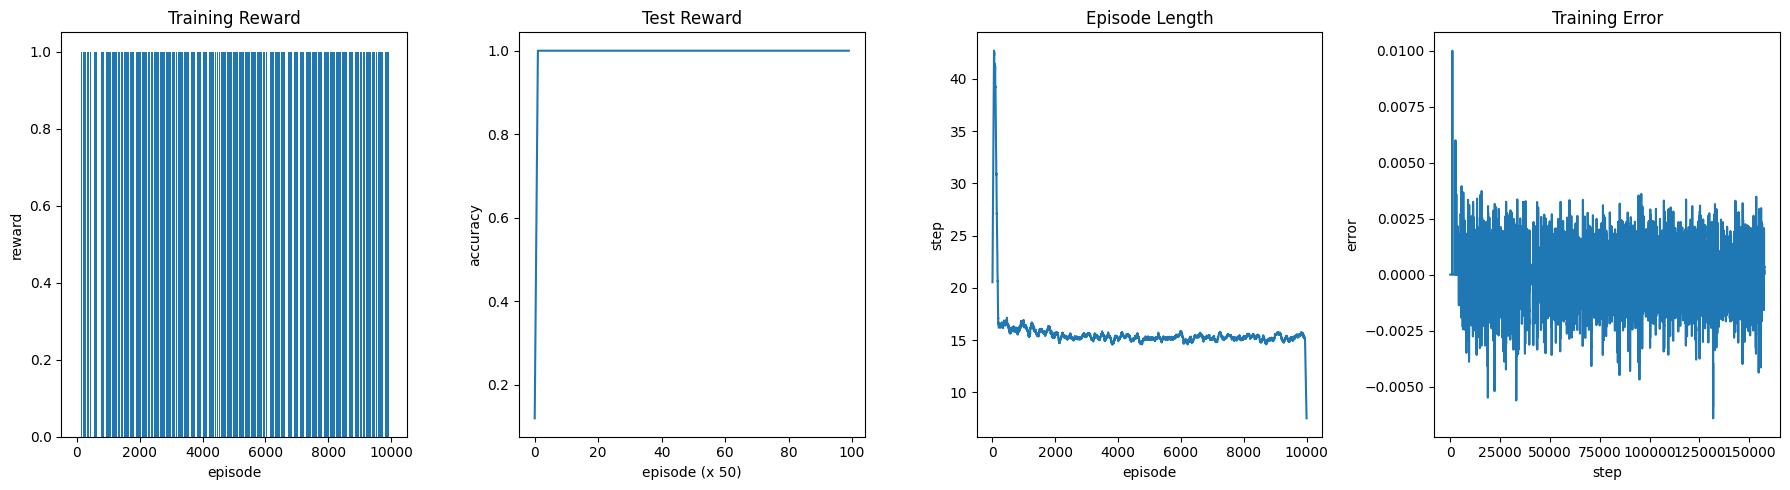

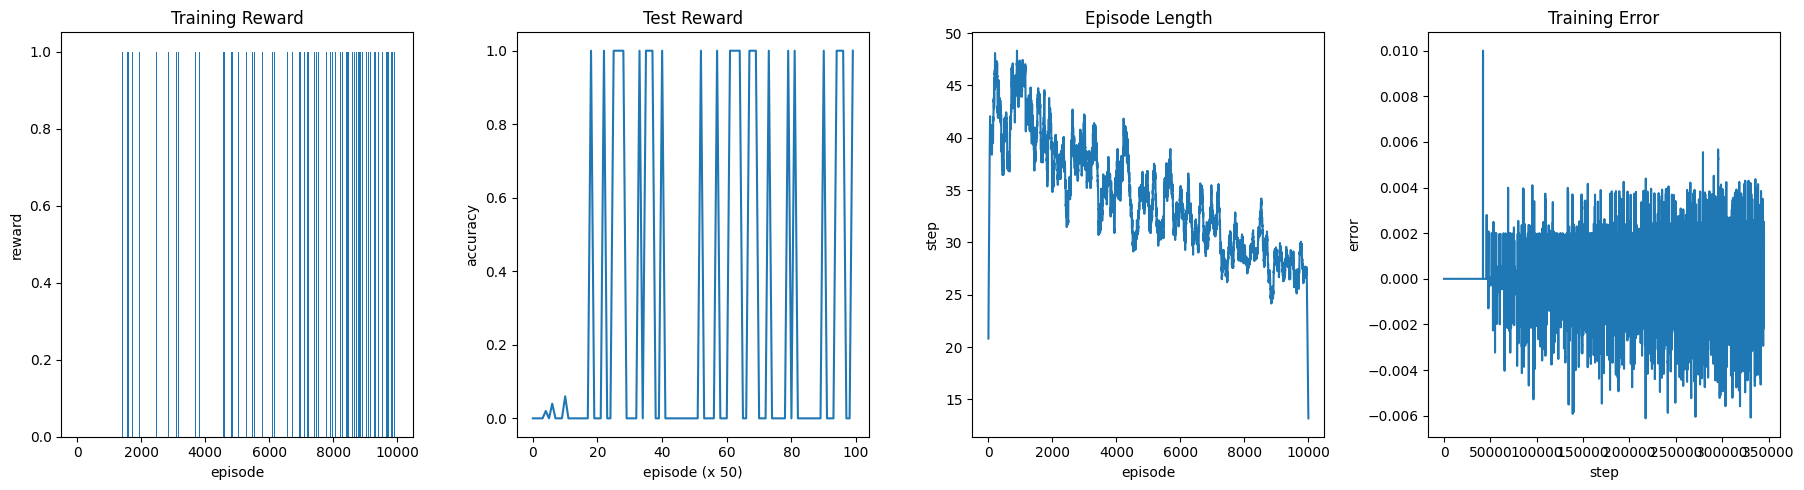

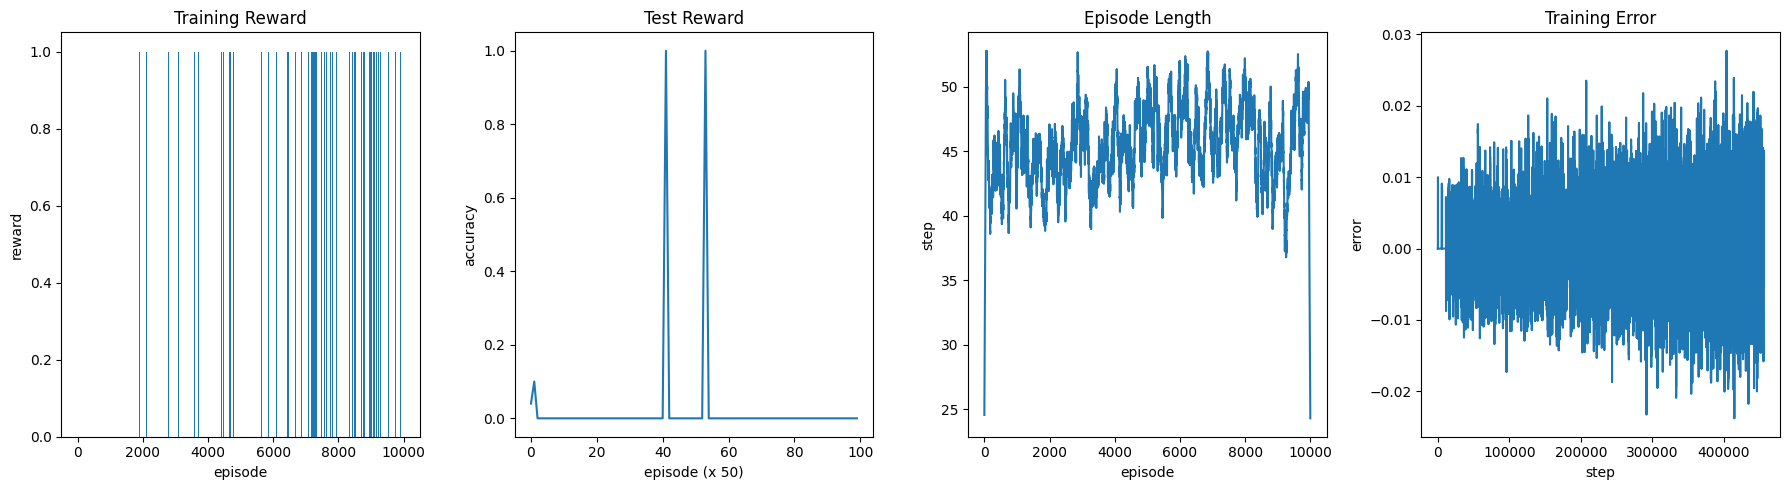

In [54]:
save_img_summary(best_sarsa_acc, 'sarsa_acc.png')
save_img_summary(best_sarsa_err, 'sarsa_err.png')
save_img_summary(best_sarsa_stp, 'sarsa_stp.png')

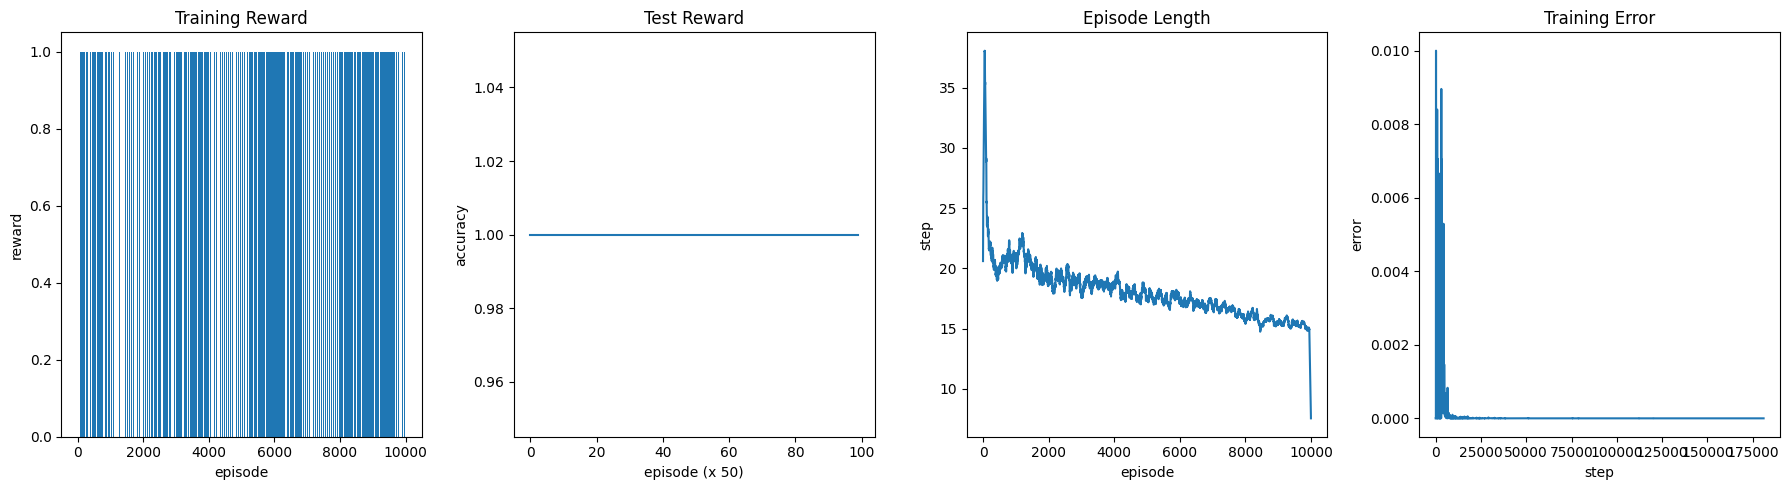

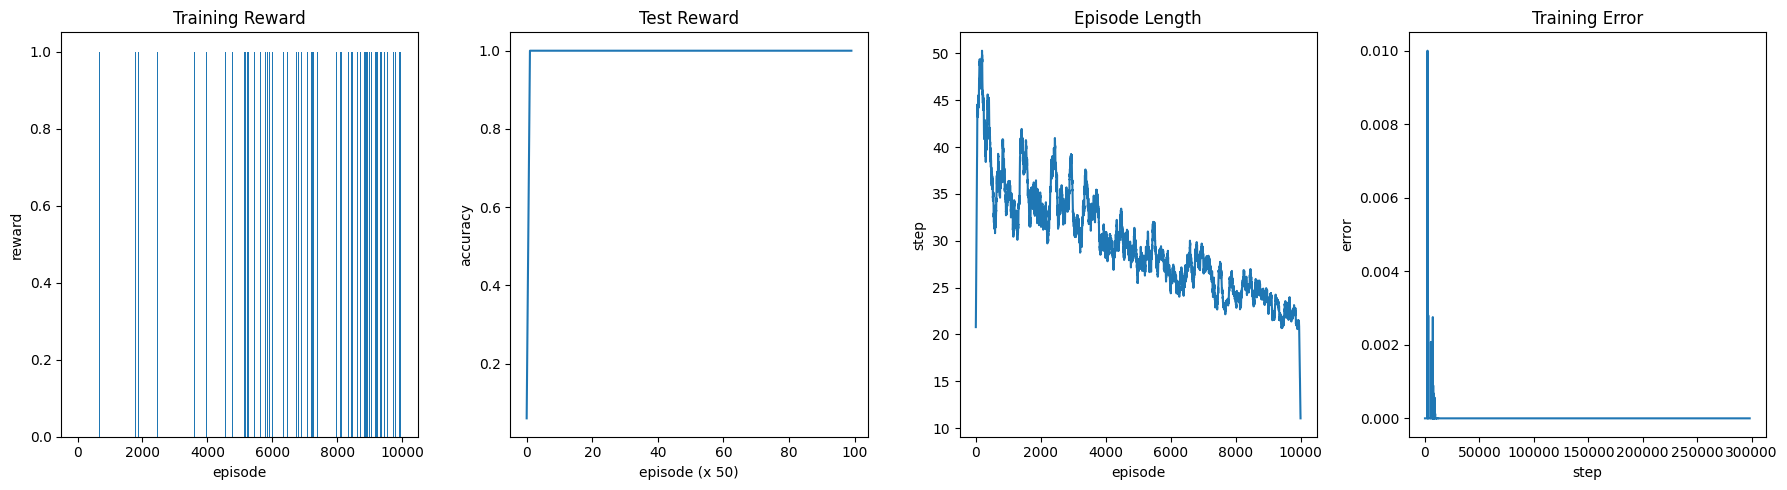

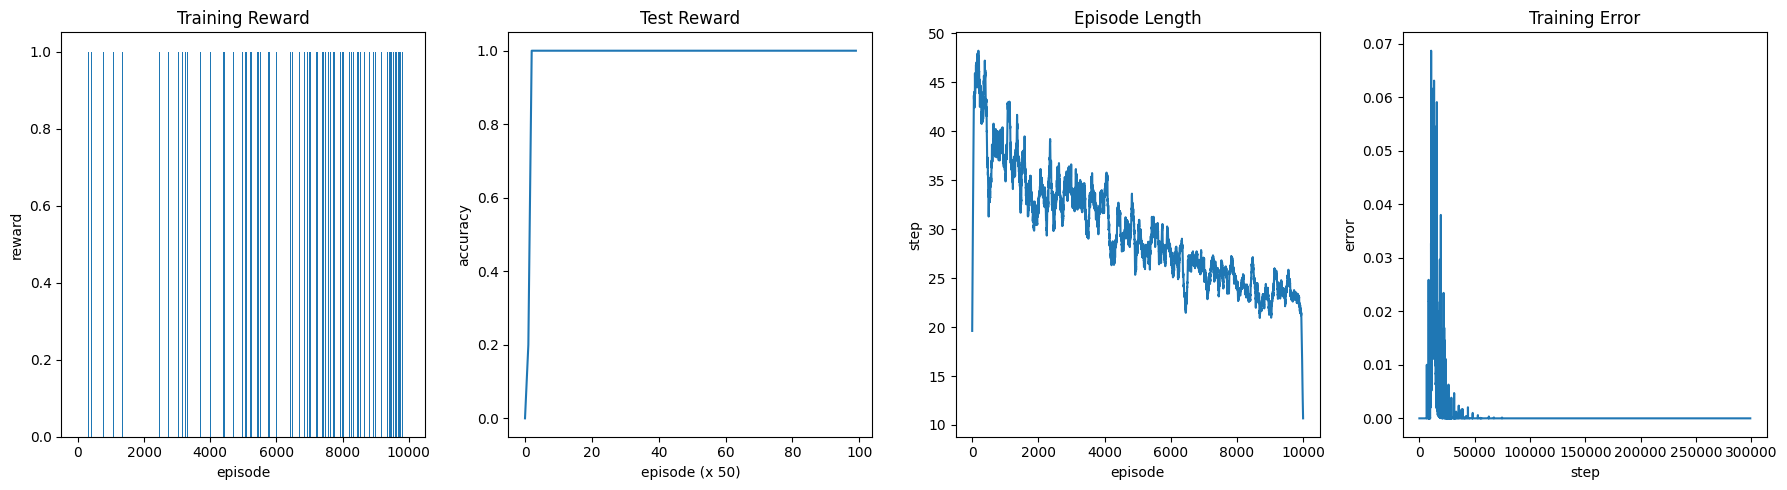

In [55]:
save_img_summary(best_q_acc, 'sarsa_acc.png')
save_img_summary(best_q_err, 'sarsa_err.png')
save_img_summary(best_q_stp, 'sarsa_stp.png')

In [63]:
agent_best_sarsa_acc = FrozenLakeAgent(
                alpha_learning_rate=best_sarsa_acc['alpha'].values[0],
                initial_epsilon=best_sarsa_acc['epsilon'].values[0],
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=best_sarsa_acc['gamma'].values[0],
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = True
            )

agent_best_sarsa_err = FrozenLakeAgent(
                alpha_learning_rate=best_sarsa_err['alpha'].values[0],
                initial_epsilon=best_sarsa_err['epsilon'].values[0],
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=best_sarsa_err['gamma'].values[0],
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = True
            )

agent_best_sarsa_stp = FrozenLakeAgent(
                alpha_learning_rate=best_sarsa_stp['alpha'].values[0],
                initial_epsilon=best_sarsa_stp['epsilon'].values[0],
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=best_sarsa_stp['gamma'].values[0],
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = True
          )



agent_best_q_acc = FrozenLakeAgent(
                alpha_learning_rate=best_q_acc['alpha'].values[0],
                initial_epsilon=best_q_acc['epsilon'].values[0],
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=best_q_acc['gamma'].values[0],
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = False
            )
agent_best_q_err = FrozenLakeAgent(
                alpha_learning_rate=best_q_err['alpha'].values[0],
                initial_epsilon=best_q_err['epsilon'].values[0],
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=best_q_err['gamma'].values[0],
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = False
            )
agent_best_q_stp = FrozenLakeAgent(
                alpha_learning_rate=best_q_stp['alpha'].values[0],
                initial_epsilon=best_q_stp['epsilon'].values[0],
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=best_q_stp['gamma'].values[0],
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = False
            )


Using Sarsa method
Using Sarsa method
Using Sarsa method
Using Q-learning method
Using Q-learning method
Using Q-learning method


In [75]:
_, _, _ = train_agent(agent_best_sarsa_acc, True)
_, _, _ = train_agent(agent_best_sarsa_err, True)
_, _, _ =train_agent(agent_best_sarsa_stp, True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  1%|          | 118/10000 [00:00<00:57, 170.62it/s]

step: 1520, episode: 100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


  2%|▏         | 224/10000 [00:01<00:49, 196.18it/s]

step: 3042, episode: 200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


  3%|▎         | 327/10000 [00:01<00:52, 182.88it/s]

step: 4589, episode: 300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


  5%|▍         | 455/10000 [00:02<00:34, 279.29it/s]

step: 6129, episode: 400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


  5%|▌         | 531/10000 [00:02<00:36, 256.93it/s]

step: 7634, episode: 500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


  7%|▋         | 661/10000 [00:03<00:35, 265.19it/s]

step: 9162, episode: 600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


  8%|▊         | 756/10000 [00:03<00:36, 250.41it/s]

step: 10715, episode: 700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


  8%|▊         | 842/10000 [00:03<00:38, 240.78it/s]

step: 12179, episode: 800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


  9%|▉         | 939/10000 [00:04<00:39, 231.94it/s]

step: 13708, episode: 900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 11%|█         | 1087/10000 [00:04<00:22, 391.47it/s]

step: 15254, episode: 1000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 12%|█▏        | 1200/10000 [00:04<00:21, 411.76it/s]

step: 16763, episode: 1100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 18209, episode: 1200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 14%|█▎        | 1368/10000 [00:05<00:17, 496.77it/s]

step: 19698, episode: 1300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 21231, episode: 1400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 15%|█▌        | 1537/10000 [00:05<00:21, 398.64it/s]

step: 22778, episode: 1500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 17%|█▋        | 1674/10000 [00:05<00:17, 487.73it/s]

step: 24323, episode: 1600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 25869, episode: 1700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 19%|█▊        | 1859/10000 [00:06<00:15, 516.71it/s]

step: 27391, episode: 1800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 20%|█▉        | 1973/10000 [00:06<00:16, 501.60it/s]

step: 28957, episode: 1900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 21%|██        | 2100/10000 [00:06<00:14, 545.36it/s]

step: 30443, episode: 2000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 31969, episode: 2100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 23%|██▎       | 2300/10000 [00:06<00:10, 732.60it/s]

step: 33513, episode: 2200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 35017, episode: 2300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 25%|██▌       | 2500/10000 [00:07<00:09, 823.88it/s]

step: 36529, episode: 2400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 38041, episode: 2500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2676/10000 [00:07<00:09, 767.16it/s]

step: 39541, episode: 2600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 41073, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2848/10000 [00:07<00:09, 730.59it/s]

step: 42574, episode: 2800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 44100, episode: 2900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 31%|███▏      | 3141/10000 [00:08<00:10, 625.98it/s]

step: 45634, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 47164, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3270/10000 [00:08<00:11, 563.96it/s]

step: 48706, episode: 3200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3409/10000 [00:08<00:11, 566.11it/s]

step: 50231, episode: 3300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 51741, episode: 3400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3552/10000 [00:08<00:11, 550.64it/s]

step: 53211, episode: 3500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:09<00:10, 578.10it/s]

step: 54721, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 56233, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:09<00:11, 551.37it/s]

step: 57733, episode: 3800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 59246, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:09<00:09, 649.70it/s]

step: 60773, episode: 4000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 62301, episode: 4100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4303/10000 [00:10<00:09, 597.14it/s]

step: 63833, episode: 4200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 65367, episode: 4300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:10<00:07, 732.50it/s]

step: 66864, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 68363, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4752/10000 [00:10<00:07, 696.06it/s]

step: 69885, episode: 4600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 71443, episode: 4700, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4896/10000 [00:10<00:07, 646.34it/s]

step: 72995, episode: 4800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 74575, episode: 4900, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5090/10000 [00:11<00:09, 535.06it/s]

step: 76081, episode: 5000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 77607, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5266/10000 [00:11<00:09, 507.57it/s]

step: 79101, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 80574, episode: 5300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1

 54%|█████▍    | 5393/10000 [00:12<00:08, 542.21it/s]


step: 82110, episode: 5400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5568/10000 [00:12<00:08, 515.97it/s]

step: 83670, episode: 5500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5684/10000 [00:12<00:09, 471.72it/s]

step: 85202, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5795/10000 [00:12<00:08, 486.85it/s]

step: 86722, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:13<00:09, 452.74it/s]

step: 88227, episode: 5800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 89739, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6071/10000 [00:13<00:08, 487.52it/s]

step: 91277, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6169/10000 [00:13<00:09, 414.24it/s]

step: 92821, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6248/10000 [00:14<00:12, 304.48it/s]

step: 94335, episode: 6200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 64%|██████▎   | 6366/10000 [00:14<00:10, 340.06it/s]

step: 95890, episode: 6300, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6446/10000 [00:14<00:11, 311.12it/s]

step: 97368, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6569/10000 [00:15<00:08, 386.48it/s]

step: 98876, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 100365, episode: 6600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6791/10000 [00:15<00:07, 404.86it/s]

step: 101887, episode: 6700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6840/10000 [00:15<00:09, 328.72it/s]

step: 103398, episode: 6800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6945/10000 [00:16<00:08, 365.47it/s]

step: 104919, episode: 6900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7096/10000 [00:16<00:07, 405.47it/s]

step: 106417, episode: 7000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 107910, episode: 7100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7273/10000 [00:16<00:05, 502.26it/s]

step: 109457, episode: 7200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 74%|███████▎  | 7370/10000 [00:17<00:06, 382.65it/s]

step: 110950, episode: 7300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7468/10000 [00:17<00:06, 419.02it/s]

step: 112460, episode: 7400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7563/10000 [00:17<00:06, 392.27it/s]

step: 113993, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 76%|███████▋  | 7641/10000 [00:17<00:07, 307.25it/s]

step: 115519, episode: 7600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7751/10000 [00:18<00:07, 282.92it/s]

step: 117050, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7886/10000 [00:18<00:05, 373.02it/s]

step: 118570, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7963/10000 [00:19<00:06, 311.99it/s]

step: 120091, episode: 7900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8080/10000 [00:19<00:06, 303.77it/s]

step: 121632, episode: 8000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8185/10000 [00:19<00:04, 376.99it/s]

step: 123119, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 124657, episode: 8200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:19<00:04, 405.67it/s]

step: 126149, episode: 8300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8488/10000 [00:20<00:02, 516.29it/s]

step: 127682, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8542/10000 [00:20<00:03, 434.43it/s]

step: 129162, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8666/10000 [00:20<00:02, 480.60it/s]

step: 130716, episode: 8600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 132240, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8906/10000 [00:21<00:02, 492.23it/s]

step: 133786, episode: 8800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 135308, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9094/10000 [00:21<00:01, 505.89it/s]

step: 136835, episode: 9000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9237/10000 [00:21<00:01, 577.86it/s]

step: 138374, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 139924, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9418/10000 [00:21<00:00, 730.64it/s]

step: 141456, episode: 9300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 142980, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9600/10000 [00:22<00:00, 779.86it/s]

step: 144489, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 145968, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:22<00:00, 778.13it/s]

step: 147477, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 149002, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:22<00:00, 440.43it/s]

step: 150556, episode: 9900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 152084, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


In [81]:
_, _, _ = train_agent(agent_best_q_acc, False)
_, _, _ = train_agent(agent_best_q_err, False)
_, _, _ = train_agent(agent_best_q_stp, False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  1%|▏         | 131/10000 [00:01<01:31, 108.35it/s]

step: 4374, episode: 100, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.49600000000000155


  3%|▎         | 263/10000 [00:01<00:33, 288.12it/s]

step: 6662, episode: 200, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▎         | 357/10000 [00:01<00:28, 344.32it/s]

step: 8842, episode: 300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.48800000000000465


  4%|▍         | 443/10000 [00:02<00:28, 333.02it/s]

step: 10732, episode: 400, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.4840000000000062


  5%|▌         | 545/10000 [00:02<00:29, 317.16it/s]

step: 12988, episode: 500, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.48000000000000775


  6%|▋         | 634/10000 [00:02<00:43, 215.12it/s]

step: 15111, episode: 600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4760000000000093


  7%|▋         | 731/10000 [00:03<00:39, 236.77it/s]

step: 17089, episode: 700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.47200000000001086


  9%|▊         | 870/10000 [00:03<00:24, 367.19it/s]

step: 19205, episode: 800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4680000000000124
step: 21174, episode: 900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.46400000000001396


 11%|█         | 1100/10000 [00:04<00:19, 457.94it/s]

step: 23018, episode: 1000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.4600000000000155
step: 24953, episode: 1100, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1253/10000 [00:04<00:19, 441.82it/s]

step: 26956, episode: 1200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▎        | 1359/10000 [00:04<00:19, 443.97it/s]

step: 28793, episode: 1300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.44800000000002016


 15%|█▍        | 1451/10000 [00:05<00:21, 393.66it/s]

step: 30819, episode: 1400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1595/10000 [00:05<00:21, 392.31it/s]

step: 32882, episode: 1500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1698/10000 [00:05<00:18, 441.42it/s]

step: 34733, episode: 1600, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.4360000000000248


 17%|█▋        | 1745/10000 [00:05<00:19, 424.46it/s]

step: 36711, episode: 1700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.43200000000002636


 18%|█▊        | 1843/10000 [00:06<00:19, 410.05it/s]

step: 38552, episode: 1800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1961/10000 [00:06<00:17, 449.06it/s]

step: 40435, episode: 1900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2067/10000 [00:06<00:18, 438.10it/s]

step: 42287, episode: 2000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2176/10000 [00:06<00:17, 456.55it/s]

step: 44147, episode: 2100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2281/10000 [00:07<00:17, 448.84it/s]

step: 46106, episode: 2200, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2391/10000 [00:07<00:16, 454.07it/s]

step: 48065, episode: 2300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2493/10000 [00:07<00:17, 432.40it/s]

step: 50067, episode: 2400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2600/10000 [00:07<00:18, 406.25it/s]

step: 51937, episode: 2500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 53763, episode: 2600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:08<00:13, 520.68it/s]

step: 55683, episode: 2700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 57674, episode: 2800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3031/10000 [00:08<00:10, 646.34it/s]

step: 59681, episode: 2900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 61517, episode: 3000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:08<00:09, 705.00it/s]

step: 63387, episode: 3100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 65202, episode: 3200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3400/10000 [00:09<00:08, 785.31it/s]

step: 67010, episode: 3300, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 68768, episode: 3400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3600/10000 [00:09<00:07, 805.37it/s]

step: 70569, episode: 3500, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 72401, episode: 3600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3560000000000558


 39%|███▊      | 3864/10000 [00:09<00:07, 789.75it/s]

step: 74347, episode: 3700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 76174, episode: 3800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4023/10000 [00:09<00:07, 770.41it/s]

step: 77955, episode: 3900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 79915, episode: 4000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4198/10000 [00:10<00:07, 825.82it/s]

step: 81798, episode: 4100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 83577, episode: 4200, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4445/10000 [00:10<00:07, 767.94it/s]

step: 85401, episode: 4300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 87276, episode: 4400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:10<00:07, 737.13it/s]

step: 89057, episode: 4500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 90855, episode: 4600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:10<00:06, 792.50it/s]

step: 92623, episode: 4700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 94391, episode: 4800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:11<00:05, 840.98it/s]

step: 96108, episode: 4900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.304000000000076
step: 97864, episode: 5000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5200/10000 [00:11<00:05, 803.41it/s]

step: 99731, episode: 5100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 101415, episode: 5200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▎    | 5356/10000 [00:11<00:07, 648.66it/s]

step: 103223, episode: 5300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 104972, episode: 5400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5563/10000 [00:11<00:07, 594.01it/s]

step: 106741, episode: 5500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 108538, episode: 5600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5816/10000 [00:12<00:07, 540.80it/s]

step: 110275, episode: 5700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 111953, episode: 5800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6000/10000 [00:12<00:07, 555.19it/s]

step: 113688, episode: 5900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 115395, episode: 6000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6211/10000 [00:13<00:06, 593.41it/s]

step: 117126, episode: 6100, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 118719, episode: 6200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▎   | 6352/10000 [00:13<00:06, 564.75it/s]

step: 120411, episode: 6300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 122110, episode: 6400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6600/10000 [00:13<00:06, 511.02it/s]

step: 123798, episode: 6500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 125507, episode: 6600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:14<00:06, 505.63it/s]

step: 127116, episode: 6700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 128809, episode: 6800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6995/10000 [00:14<00:05, 537.02it/s]

step: 130434, episode: 6900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7105/10000 [00:14<00:05, 489.34it/s]

step: 132135, episode: 7000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 133721, episode: 7100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7297/10000 [00:15<00:04, 547.93it/s]

step: 135358, episode: 7200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 137011, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.20800000000008406


 74%|███████▍  | 7420/10000 [00:15<00:04, 550.52it/s]

step: 138588, episode: 7400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7600/10000 [00:15<00:03, 649.10it/s]

step: 140226, episode: 7500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 141840, episode: 7600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:15<00:02, 753.79it/s]

step: 143479, episode: 7700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 145118, episode: 7800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:16<00:02, 801.85it/s]

step: 146737, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 148357, episode: 8000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:16<00:02, 841.18it/s]

step: 149985, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 151555, episode: 8200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8384/10000 [00:16<00:01, 827.46it/s]

step: 153142, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 154802, episode: 8400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▋ | 8641/10000 [00:16<00:01, 844.36it/s]

step: 156412, episode: 8500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 158011, episode: 8600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8813/10000 [00:17<00:01, 838.20it/s]

step: 159511, episode: 8700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 161069, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9000/10000 [00:17<00:01, 821.78it/s]

step: 162609, episode: 8900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 164140, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9198/10000 [00:17<00:00, 865.33it/s]

step: 165671, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 167225, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 95%|█████████▍| 9463/10000 [00:17<00:00, 850.18it/s]

step: 168797, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 170374, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▋| 9635/10000 [00:18<00:00, 837.83it/s]

step: 171935, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 173444, episode: 9600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9805/10000 [00:18<00:00, 822.02it/s]

step: 174954, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 176445, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:18<00:00, 540.59it/s]


step: 178008, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 179509, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967


  2%|▏         | 174/10000 [00:00<00:22, 433.14it/s]

step: 4065, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 8796, episode: 200, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.891999999999992


  4%|▍         | 396/10000 [00:00<00:18, 519.94it/s]

step: 13305, episode: 300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.887999999999988
step: 17198, episode: 400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.883999999999984


  6%|▌         | 566/10000 [00:01<00:17, 530.93it/s]

step: 20824, episode: 500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.87999999999998
step: 24307, episode: 600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 802/10000 [00:01<00:17, 529.26it/s]

step: 28170, episode: 700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.871999999999972
step: 31803, episode: 800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.867999999999968


 10%|▉         | 990/10000 [00:01<00:15, 590.86it/s]

step: 35212, episode: 900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.863999999999964
step: 38815, episode: 1000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.85999999999996


 12%|█▏        | 1186/10000 [00:02<00:14, 605.33it/s]

step: 41693, episode: 1100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.855999999999956
step: 45091, episode: 1200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1380/10000 [00:02<00:13, 619.63it/s]

step: 48480, episode: 1300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.847999999999948
step: 51875, episode: 1400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.843999999999944


 16%|█▌        | 1570/10000 [00:02<00:14, 582.34it/s]

step: 55860, episode: 1500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.83999999999994
step: 59321, episode: 1600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1811/10000 [00:03<00:14, 553.23it/s]

step: 62698, episode: 1700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.831999999999932
step: 66091, episode: 1800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|██        | 2000/10000 [00:03<00:14, 562.49it/s]

step: 69621, episode: 1900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.823999999999924
step: 72871, episode: 2000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2186/10000 [00:04<00:13, 564.34it/s]

step: 76479, episode: 2100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.815999999999916
step: 79858, episode: 2200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2380/10000 [00:04<00:12, 605.78it/s]

step: 83189, episode: 2300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.807999999999908
step: 86472, episode: 2400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2583/10000 [00:04<00:11, 633.64it/s]

step: 89857, episode: 2500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.7999999999999
step: 93096, episode: 2600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2794/10000 [00:05<00:11, 607.61it/s]

step: 96564, episode: 2700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.791999999999892
step: 99899, episode: 2800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2975/10000 [00:05<00:13, 525.28it/s]

step: 103409, episode: 2900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:05<00:12, 547.57it/s]

step: 106742, episode: 3000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.77999999999988
step: 109841, episode: 3100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3288/10000 [00:05<00:11, 579.54it/s]

step: 113180, episode: 3200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.771999999999872
step: 116345, episode: 3300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3474/10000 [00:06<00:11, 577.90it/s]

step: 119876, episode: 3400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.763999999999864
step: 123127, episode: 3500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3678/10000 [00:06<00:09, 635.36it/s]

step: 126213, episode: 3600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.755999999999856
step: 129296, episode: 3700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▊      | 3858/10000 [00:07<00:12, 476.33it/s]

step: 132480, episode: 3800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|███▉      | 3955/10000 [00:07<00:14, 430.13it/s]

step: 136023, episode: 3900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4062/10000 [00:07<00:12, 459.46it/s]

step: 139169, episode: 4000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4169/10000 [00:07<00:12, 465.17it/s]

step: 142062, episode: 4100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4263/10000 [00:08<00:12, 442.69it/s]

step: 144816, episode: 4200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▎     | 4366/10000 [00:08<00:12, 460.87it/s]

step: 147949, episode: 4300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4472/10000 [00:08<00:11, 467.72it/s]

step: 150749, episode: 4400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4583/10000 [00:08<00:11, 483.43it/s]

step: 153689, episode: 4500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4682/10000 [00:08<00:12, 441.03it/s]

step: 156521, episode: 4600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4784/10000 [00:09<00:11, 437.74it/s]

step: 159338, episode: 4700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4872/10000 [00:09<00:12, 395.14it/s]

step: 162251, episode: 4800, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|████▉     | 4958/10000 [00:09<00:13, 386.84it/s]

step: 165594, episode: 4900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5052/10000 [00:09<00:12, 402.09it/s]

step: 168620, episode: 5000, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5160/10000 [00:10<00:11, 432.52it/s]

step: 171651, episode: 5100, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5256/10000 [00:10<00:11, 427.84it/s]

step: 174426, episode: 5200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.691999999999792


 53%|█████▎    | 5345/10000 [00:10<00:11, 396.72it/s]

step: 177301, episode: 5300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.687999999999788


 54%|█████▍    | 5444/10000 [00:10<00:11, 384.36it/s]

step: 180160, episode: 5400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5593/10000 [00:11<00:10, 430.29it/s]

step: 183259, episode: 5500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.67999999999978
step: 186157, episode: 5600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5788/10000 [00:11<00:07, 571.48it/s]

step: 188926, episode: 5700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.671999999999772
step: 191664, episode: 5800, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5974/10000 [00:11<00:06, 601.37it/s]

step: 194313, episode: 5900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.663999999999764
step: 197250, episode: 6000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.65999999999976


 63%|██████▎   | 6257/10000 [00:12<00:05, 678.21it/s]

step: 199898, episode: 6100, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.655999999999756
step: 202675, episode: 6200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6396/10000 [00:12<00:05, 647.55it/s]

step: 205083, episode: 6300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.647999999999748
step: 207739, episode: 6400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6600/10000 [00:12<00:05, 593.13it/s]

step: 210522, episode: 6500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.63999999999974
step: 213228, episode: 6600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6800/10000 [00:13<00:05, 624.88it/s]

step: 215735, episode: 6700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.631999999999732
step: 218272, episode: 6800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|███████   | 7013/10000 [00:13<00:04, 636.29it/s]

step: 221031, episode: 6900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.623999999999724
step: 223762, episode: 7000, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7222/10000 [00:13<00:04, 628.37it/s]

step: 226438, episode: 7100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.615999999999716
step: 229046, episode: 7200, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7387/10000 [00:14<00:03, 689.89it/s]

step: 231476, episode: 7300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.607999999999708
step: 233967, episode: 7400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7600/10000 [00:14<00:03, 677.30it/s]

step: 236520, episode: 7500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.5999999999997
step: 239041, episode: 7600, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7828/10000 [00:14<00:03, 647.98it/s]

step: 241753, episode: 7700, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.591999999999692
step: 244189, episode: 7800, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7968/10000 [00:14<00:03, 658.45it/s]

step: 246835, episode: 7900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.583999999999684
step: 249324, episode: 8000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8190/10000 [00:15<00:02, 702.12it/s]

step: 251518, episode: 8100, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.575999999999676
step: 253966, episode: 8200, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8401/10000 [00:15<00:02, 652.04it/s]

step: 256501, episode: 8300, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.567999999999668
step: 259104, episode: 8400, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8615/10000 [00:15<00:02, 663.58it/s]

step: 261479, episode: 8500, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.55999999999966
step: 263951, episode: 8600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8820/10000 [00:16<00:01, 667.02it/s]

step: 266268, episode: 8700, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.551999999999652
step: 268728, episode: 8800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8970/10000 [00:16<00:01, 685.84it/s]

step: 270903, episode: 8900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.543999999999644
step: 273405, episode: 9000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9185/10000 [00:16<00:01, 702.66it/s]

step: 275695, episode: 9100, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.535999999999636
step: 278026, episode: 9200, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:17<00:00, 654.43it/s]

step: 280492, episode: 9300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.527999999999628
step: 282796, episode: 9400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9617/10000 [00:17<00:00, 692.32it/s]

step: 285166, episode: 9500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.51999999999962
step: 287218, episode: 9600, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9788/10000 [00:17<00:00, 761.66it/s]

step: 289376, episode: 9700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.511999999999612
step: 291812, episode: 9800, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:17<00:00, 556.48it/s]


step: 293939, episode: 9900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.503999999999604
step: 296231, episode: 10000, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.49999999999960004


  2%|▏         | 158/10000 [00:00<00:22, 433.31it/s]

step: 4315, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  3%|▎         | 251/10000 [00:00<00:24, 399.59it/s]

step: 8706, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992


  4%|▎         | 355/10000 [00:00<00:25, 385.65it/s]

step: 13382, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988


  5%|▍         | 467/10000 [00:01<00:22, 419.33it/s]

step: 17587, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▌         | 581/10000 [00:01<00:22, 418.06it/s]

step: 21890, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.87999999999998
step: 25614, episode: 600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.875999999999976


  8%|▊         | 799/10000 [00:01<00:19, 481.25it/s]

step: 29942, episode: 700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.871999999999972


  9%|▉         | 911/10000 [00:02<00:18, 490.57it/s]

step: 34049, episode: 800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.867999999999968
step: 37808, episode: 900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█         | 1106/10000 [00:02<00:17, 504.35it/s]

step: 41149, episode: 1000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.85999999999996
step: 44529, episode: 1100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1283/10000 [00:02<00:16, 542.83it/s]

step: 47981, episode: 1200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.851999999999952


 14%|█▍        | 1395/10000 [00:03<00:16, 509.48it/s]

step: 52093, episode: 1300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.847999999999948


 14%|█▍        | 1448/10000 [00:03<00:17, 483.77it/s]

step: 56220, episode: 1400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.843999999999944


 15%|█▌        | 1545/10000 [00:03<00:20, 413.90it/s]

step: 60009, episode: 1500, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1686/10000 [00:03<00:19, 429.27it/s]

step: 63792, episode: 1600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.835999999999936


 18%|█▊        | 1774/10000 [00:04<00:20, 397.32it/s]

step: 67280, episode: 1700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▊        | 1860/10000 [00:04<00:22, 367.94it/s]

step: 70525, episode: 1800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.827999999999928


 20%|█▉        | 1957/10000 [00:04<00:19, 407.77it/s]

step: 74355, episode: 1900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2062/10000 [00:04<00:17, 446.32it/s]

step: 77453, episode: 2000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2153/10000 [00:05<00:18, 414.38it/s]

step: 80402, episode: 2100, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2264/10000 [00:05<00:16, 468.73it/s]

step: 83556, episode: 2200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▎       | 2358/10000 [00:05<00:18, 417.95it/s]

step: 86909, episode: 2300, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2454/10000 [00:05<00:18, 413.58it/s]

step: 90435, episode: 2400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2577/10000 [00:06<00:22, 337.35it/s]

step: 94050, episode: 2500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2651/10000 [00:06<00:21, 340.63it/s]

step: 97401, episode: 2600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2775/10000 [00:06<00:19, 369.25it/s]

step: 101041, episode: 2700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▊       | 2854/10000 [00:06<00:19, 358.37it/s]

step: 104522, episode: 2800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2982/10000 [00:07<00:18, 381.62it/s]

step: 107613, episode: 2900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:07<00:15, 454.58it/s]

step: 110908, episode: 3000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.77999999999988
step: 114045, episode: 3100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:07<00:12, 536.11it/s]

step: 117299, episode: 3200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.771999999999872
step: 120463, episode: 3300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:08<00:11, 546.94it/s]

step: 123506, episode: 3400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.763999999999864
step: 126730, episode: 3500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3701/10000 [00:08<00:10, 591.93it/s]

step: 129809, episode: 3600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.755999999999856
step: 133028, episode: 3700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:08<00:10, 585.88it/s]

step: 135959, episode: 3800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.747999999999848
step: 139001, episode: 3900, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:09<00:10, 574.51it/s]

step: 141955, episode: 4000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.73999999999984
step: 145009, episode: 4100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4296/10000 [00:09<00:08, 635.44it/s]

step: 148377, episode: 4200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.731999999999832
step: 151533, episode: 4300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4500/10000 [00:09<00:09, 593.82it/s]

step: 154759, episode: 4400, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.723999999999824
step: 157704, episode: 4500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4695/10000 [00:10<00:08, 604.16it/s]

step: 160579, episode: 4600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.715999999999816
step: 163704, episode: 4700, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4895/10000 [00:10<00:07, 640.59it/s]

step: 166805, episode: 4800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.707999999999808
step: 169546, episode: 4900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5098/10000 [00:10<00:07, 642.46it/s]

step: 172635, episode: 5000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.6999999999998
step: 175686, episode: 5100, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:11<00:07, 606.15it/s]

step: 178472, episode: 5200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.691999999999792
step: 181157, episode: 5300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:11<00:07, 598.83it/s]

step: 184068, episode: 5400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.683999999999784
step: 187072, episode: 5500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5708/10000 [00:11<00:07, 585.08it/s]

step: 189887, episode: 5600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.675999999999776
step: 192936, episode: 5700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:12<00:06, 603.52it/s]

step: 195870, episode: 5800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.667999999999768
step: 198300, episode: 5900, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:12<00:06, 623.69it/s]

step: 201154, episode: 6000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.65999999999976
step: 203903, episode: 6100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6302/10000 [00:12<00:06, 614.75it/s]

step: 206478, episode: 6200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.651999999999752
step: 209265, episode: 6300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6518/10000 [00:13<00:05, 631.58it/s]

step: 211815, episode: 6400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.643999999999744
step: 214392, episode: 6500, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6729/10000 [00:13<00:05, 612.03it/s]

step: 217137, episode: 6600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.635999999999736
step: 219707, episode: 6700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6919/10000 [00:13<00:04, 617.57it/s]

step: 222499, episode: 6800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.627999999999728
step: 224989, episode: 6900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7065/10000 [00:14<00:04, 617.05it/s]

step: 227634, episode: 7000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.61999999999972
step: 230323, episode: 7100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7274/10000 [00:14<00:04, 630.50it/s]

step: 233077, episode: 7200, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.611999999999712
step: 235684, episode: 7300, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7491/10000 [00:14<00:03, 687.50it/s]

step: 238049, episode: 7400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.603999999999704
step: 240706, episode: 7500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7700/10000 [00:15<00:03, 607.95it/s]

step: 243104, episode: 7600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.595999999999696
step: 245566, episode: 7700, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7912/10000 [00:15<00:03, 620.00it/s]

step: 248199, episode: 7800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.587999999999688
step: 250727, episode: 7900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████▏ | 8128/10000 [00:15<00:02, 646.13it/s]

step: 253318, episode: 8000, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.57999999999968
step: 255746, episode: 8100, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8286/10000 [00:15<00:02, 701.00it/s]

step: 258227, episode: 8200, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.571999999999672
step: 260571, episode: 8300, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:16<00:02, 659.64it/s]

step: 263046, episode: 8400, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.563999999999664
step: 265398, episode: 8500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8720/10000 [00:16<00:02, 626.34it/s]

step: 267926, episode: 8600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.555999999999656
step: 270340, episode: 8700, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8890/10000 [00:16<00:01, 704.44it/s]

step: 272740, episode: 8800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.547999999999648
step: 275338, episode: 8900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9100/10000 [00:17<00:01, 617.64it/s]

step: 277756, episode: 9000, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.53999999999964
step: 280172, episode: 9100, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.535999999999636


 92%|█████████▏| 9242/10000 [00:17<00:01, 576.50it/s]

step: 282613, episode: 9200, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▎| 9358/10000 [00:17<00:01, 519.29it/s]

step: 284865, episode: 9300, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9473/10000 [00:17<00:01, 500.02it/s]

step: 287214, episode: 9400, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9584/10000 [00:18<00:00, 479.19it/s]

step: 289418, episode: 9500, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9698/10000 [00:18<00:00, 490.47it/s]

step: 291845, episode: 9600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:18<00:00, 434.42it/s]

step: 294126, episode: 9700, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.511999999999612
step: 296448, episode: 9800, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:19<00:00, 522.64it/s]

step: 298561, episode: 9900, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.503999999999604
step: 300782, episode: 10000, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.49999999999960004


  1%|▏         | 143/10000 [00:00<00:44, 222.99it/s]

step: 4364, episode: 100, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.4959999999996016


  3%|▎         | 253/10000 [00:01<00:50, 193.00it/s]

step: 8666, episode: 200, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.49199999999960314


  4%|▎         | 368/10000 [00:01<00:46, 206.13it/s]

step: 12802, episode: 300, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.4879999999996047


  4%|▍         | 429/10000 [00:02<00:56, 168.71it/s]

step: 17059, episode: 400, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.48399999999960625


  5%|▌         | 538/10000 [00:02<00:52, 179.41it/s]

step: 21578, episode: 500, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.4799999999996078


  7%|▋         | 654/10000 [00:03<00:57, 163.07it/s]

step: 26024, episode: 600, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.47599999999960935


  7%|▋         | 748/10000 [00:04<00:59, 154.20it/s]

step: 30467, episode: 700, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.4719999999996109


  9%|▊         | 862/10000 [00:04<00:42, 212.71it/s]

step: 35062, episode: 800, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.46799999999961245


 10%|▉         | 954/10000 [00:05<00:36, 249.46it/s]

step: 39130, episode: 900, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.463999999999614


 11%|█         | 1096/10000 [00:05<00:28, 308.13it/s]

step: 43895, episode: 1000, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.45999999999961555


 12%|█▏        | 1195/10000 [00:05<00:28, 309.74it/s]

step: 47599, episode: 1100, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.4559999999996171


 13%|█▎        | 1273/10000 [00:06<00:33, 261.36it/s]

step: 51558, episode: 1200, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.45199999999961865


 14%|█▎        | 1359/10000 [00:06<00:32, 263.65it/s]

step: 56361, episode: 1300, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.4479999999996202


 15%|█▍        | 1458/10000 [00:07<00:29, 286.54it/s]

step: 60537, episode: 1400, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.44399999999962175


 16%|█▌        | 1561/10000 [00:07<00:29, 285.96it/s]

step: 65029, episode: 1500, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.4399999999996233


 17%|█▋        | 1657/10000 [00:07<00:28, 288.13it/s]

step: 69316, episode: 1600, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.43599999999962485


 18%|█▊        | 1750/10000 [00:07<00:23, 352.68it/s]

step: 73617, episode: 1700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.4319999999996264


 19%|█▊        | 1855/10000 [00:08<00:26, 305.25it/s]

step: 77653, episode: 1800, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.42799999999962796


 20%|█▉        | 1952/10000 [00:08<00:26, 302.91it/s]

step: 81736, episode: 1900, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.4239999999996295


 20%|██        | 2043/10000 [00:09<00:28, 279.31it/s]

step: 85965, episode: 2000, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.41999999999963106


 22%|██▏       | 2198/10000 [00:09<00:24, 313.11it/s]

step: 90348, episode: 2100, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.4159999999996326


 23%|██▎       | 2292/10000 [00:09<00:25, 298.27it/s]

step: 94614, episode: 2200, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.41199999999963416


 24%|██▍       | 2379/10000 [00:10<00:27, 276.32it/s]

step: 98823, episode: 2300, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.4079999999996357


 25%|██▍       | 2462/10000 [00:10<00:28, 262.52it/s]

step: 103003, episode: 2400, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.40399999999963726


 26%|██▌       | 2557/10000 [00:11<00:26, 276.38it/s]

step: 107393, episode: 2500, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.3999999999996388


 27%|██▋       | 2697/10000 [00:11<00:23, 307.86it/s]

step: 111764, episode: 2600, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.39599999999964036


 27%|██▋       | 2738/10000 [00:11<00:29, 249.02it/s]

step: 115239, episode: 2700, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.3919999999996419


 28%|██▊       | 2840/10000 [00:12<00:27, 260.50it/s]

step: 118601, episode: 2800, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.38799999999964346


 30%|██▉       | 2999/10000 [00:12<00:22, 316.98it/s]

step: 123169, episode: 2900, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.383999999999645


 31%|███       | 3094/10000 [00:13<00:23, 289.18it/s]

step: 126911, episode: 3000, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.37999999999964656


 32%|███▏      | 3172/10000 [00:13<00:26, 256.69it/s]

step: 131512, episode: 3100, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.3759999999996481


 33%|███▎      | 3264/10000 [00:13<00:24, 276.18it/s]

step: 135731, episode: 3200, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.37199999999964967


 34%|███▎      | 3350/10000 [00:14<00:25, 263.37it/s]

step: 139788, episode: 3300, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.3679999999996512


 35%|███▍      | 3467/10000 [00:14<00:27, 239.97it/s]

step: 143971, episode: 3400, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.36399999999965277


 35%|███▌      | 3538/10000 [00:15<00:33, 195.10it/s]

step: 148095, episode: 3500, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.3599999999996543


 37%|███▋      | 3651/10000 [00:15<00:31, 203.72it/s]

step: 152107, episode: 3600, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.35599999999965587


 38%|███▊      | 3756/10000 [00:16<00:31, 195.19it/s]

step: 156227, episode: 3700, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.3519999999996574


 39%|███▊      | 3863/10000 [00:16<00:32, 186.19it/s]

step: 159980, episode: 3800, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.34799999999965897


 40%|███▉      | 3952/10000 [00:17<00:38, 158.88it/s]

step: 163970, episode: 3900, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.3439999999996605


 40%|████      | 4042/10000 [00:18<00:37, 160.38it/s]

step: 168289, episode: 4000, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.3399999999996621


 42%|████▏     | 4188/10000 [00:18<00:21, 264.76it/s]

step: 172325, episode: 4100, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.3359999999996636


 43%|████▎     | 4276/10000 [00:19<00:21, 260.88it/s]

step: 176184, episode: 4200, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.3319999999996652


 44%|████▎     | 4365/10000 [00:19<00:21, 268.06it/s]

step: 179945, episode: 4300, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.3279999999996667


 44%|████▍     | 4446/10000 [00:19<00:21, 257.85it/s]

step: 184202, episode: 4400, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.3239999999996683


 45%|████▌     | 4544/10000 [00:20<00:21, 259.61it/s]

step: 188161, episode: 4500, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.3199999999996698


 47%|████▋     | 4664/10000 [00:20<00:17, 300.56it/s]

step: 192171, episode: 4600, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.3159999999996714


 48%|████▊     | 4758/10000 [00:20<00:18, 287.97it/s]

step: 195982, episode: 4700, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.31199999999967293


 48%|████▊     | 4850/10000 [00:21<00:18, 280.37it/s]

step: 199657, episode: 4800, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.3079999999996745


 49%|████▉     | 4948/10000 [00:21<00:17, 280.85it/s]

step: 203777, episode: 4900, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.30399999999967603


 51%|█████     | 5086/10000 [00:22<00:16, 298.42it/s]

step: 208060, episode: 5000, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.2999999999996776


 52%|█████▏    | 5188/10000 [00:22<00:15, 307.38it/s]

step: 211716, episode: 5100, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.29599999999967913


 53%|█████▎    | 5270/10000 [00:22<00:17, 271.52it/s]

step: 215076, episode: 5200, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.2919999999996807


 54%|█████▎    | 5359/10000 [00:23<00:17, 263.32it/s]

step: 219408, episode: 5300, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.28799999999968223


 55%|█████▍    | 5452/10000 [00:23<00:16, 275.70it/s]

step: 223361, episode: 5400, accuracy training: 0.7, accuracy test: 0.0, random move probability: 0.2839999999996838


 56%|█████▌    | 5552/10000 [00:24<00:16, 273.68it/s]

step: 227313, episode: 5500, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.27999999999968533


 56%|█████▋    | 5637/10000 [00:24<00:17, 250.00it/s]

step: 231313, episode: 5600, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.2759999999996869


 58%|█████▊    | 5762/10000 [00:24<00:13, 303.97it/s]

step: 235491, episode: 5700, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.27199999999968844


 59%|█████▊    | 5855/10000 [00:25<00:14, 284.03it/s]

step: 239239, episode: 5800, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.26799999999969


 59%|█████▉    | 5949/10000 [00:25<00:14, 281.81it/s]

step: 242960, episode: 5900, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.26399999999969154


 61%|██████    | 6056/10000 [00:25<00:10, 363.28it/s]

step: 247126, episode: 6000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.2599999999996931


 62%|██████▏   | 6152/10000 [00:26<00:12, 313.64it/s]

step: 250724, episode: 6100, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.25599999999969464


 62%|██████▏   | 6248/10000 [00:26<00:12, 298.09it/s]

step: 254190, episode: 6200, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.2519999999996962


 64%|██████▎   | 6358/10000 [00:26<00:11, 313.68it/s]

step: 257967, episode: 6300, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.24799999999969632


 65%|██████▍   | 6457/10000 [00:27<00:11, 301.09it/s]

step: 261409, episode: 6400, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.2439999999996951


 66%|██████▌   | 6576/10000 [00:27<00:10, 332.92it/s]

step: 265270, episode: 6500, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.23999999999969387


 67%|██████▋   | 6676/10000 [00:28<00:10, 306.55it/s]

step: 268510, episode: 6600, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.23599999999969265


 68%|██████▊   | 6759/10000 [00:28<00:09, 324.52it/s]

step: 271939, episode: 6700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.23199999999969143


 68%|██████▊   | 6798/10000 [00:28<00:09, 323.71it/s]

step: 275717, episode: 6800, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.2279999999996902


 69%|██████▉   | 6943/10000 [00:30<00:23, 131.09it/s]

step: 279227, episode: 6900, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.22399999999968898


 71%|███████   | 7054/10000 [00:30<00:17, 167.20it/s]

step: 282684, episode: 7000, accuracy training: 0.76, accuracy test: 0.0, random move probability: 0.21999999999968775


 72%|███████▏  | 7165/10000 [00:31<00:16, 171.80it/s]

step: 286035, episode: 7100, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.21599999999968653


 73%|███████▎  | 7274/10000 [00:32<00:13, 201.22it/s]

step: 289183, episode: 7200, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.2119999999996853


 74%|███████▎  | 7374/10000 [00:32<00:08, 318.64it/s]

step: 292919, episode: 7300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.20799999999968408
step: 295909, episode: 7400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20399999999968285


 76%|███████▌  | 7584/10000 [00:32<00:06, 349.39it/s]

step: 299300, episode: 7500, accuracy training: 0.69, accuracy test: 0.0, random move probability: 0.19999999999968163
step: 302733, episode: 7600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1959999999996804


 78%|███████▊  | 7797/10000 [00:33<00:04, 456.70it/s]

step: 305925, episode: 7700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.19199999999967918


 79%|███████▉  | 7900/10000 [00:33<00:05, 353.87it/s]

step: 309041, episode: 7800, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.18799999999967795
step: 312166, episode: 7900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.18399999999967673


 81%|████████  | 8088/10000 [00:34<00:04, 383.26it/s]

step: 315243, episode: 8000, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.1799999999996755


 82%|████████▏ | 8191/10000 [00:34<00:05, 325.90it/s]

step: 318228, episode: 8100, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.17599999999967428


 83%|████████▎ | 8289/10000 [00:34<00:04, 386.37it/s]

step: 321842, episode: 8200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17199999999967305


 84%|████████▍ | 8397/10000 [00:35<00:04, 349.70it/s]

step: 325390, episode: 8300, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.16799999999967183


 84%|████████▍ | 8442/10000 [00:35<00:04, 359.78it/s]

step: 328732, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1639999999996706


 86%|████████▌ | 8576/10000 [00:35<00:03, 375.86it/s]

step: 331662, episode: 8500, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.15999999999966938
step: 334129, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.15599999999966815


 87%|████████▋ | 8749/10000 [00:36<00:03, 368.78it/s]

step: 336782, episode: 8700, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.15199999999966693


 89%|████████▊ | 8872/10000 [00:36<00:03, 358.58it/s]

step: 340252, episode: 8800, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.1479999999996657


 90%|████████▉ | 8978/10000 [00:36<00:02, 342.94it/s]

step: 342964, episode: 8900, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.14399999999966448


 90%|█████████ | 9023/10000 [00:37<00:03, 262.26it/s]

step: 346315, episode: 9000, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.13999999999966325


 92%|█████████▏| 9167/10000 [00:37<00:02, 323.33it/s]

step: 348930, episode: 9100, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.13599999999966203
step: 352062, episode: 9200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1319999999996608


 94%|█████████▍| 9375/10000 [00:38<00:01, 394.33it/s]

step: 354508, episode: 9300, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.12799999999965958


 94%|█████████▍| 9426/10000 [00:38<00:01, 296.35it/s]

step: 357071, episode: 9400, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.12399999999965872


 96%|█████████▌| 9577/10000 [00:38<00:01, 358.40it/s]

step: 359733, episode: 9500, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.11999999999965888


 97%|█████████▋| 9666/10000 [00:39<00:01, 306.32it/s]

step: 362229, episode: 9600, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.11599999999965904


 98%|█████████▊| 9760/10000 [00:39<00:00, 369.19it/s]

step: 365806, episode: 9700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1119999999996592


 99%|█████████▉| 9878/10000 [00:39<00:00, 359.96it/s]

step: 369206, episode: 9800, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.10799999999965937


100%|██████████| 10000/10000 [00:40<00:00, 249.10it/s]

step: 372005, episode: 9900, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.10399999999965953
step: 374770, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


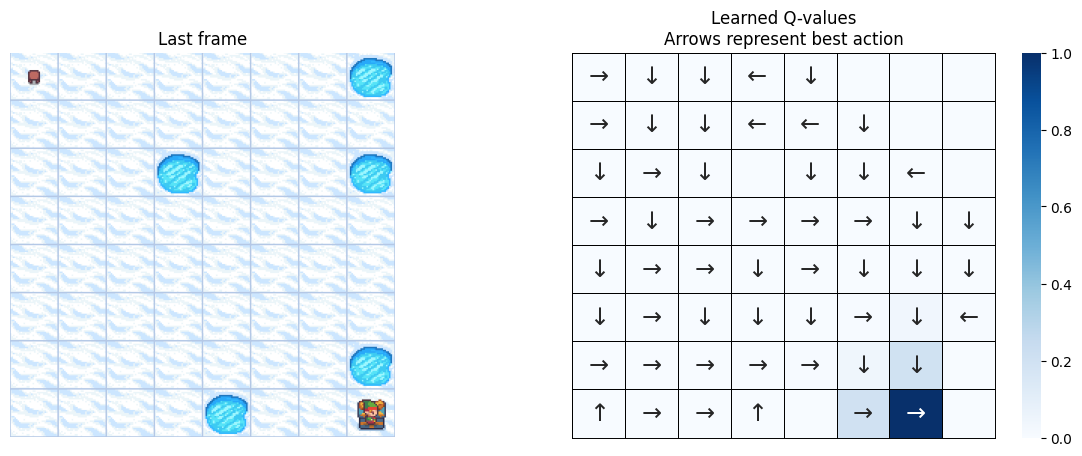

In [78]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

plot_q_values_map(agent_best_sarsa_acc.get_Q_Table(), env, side_map_size)

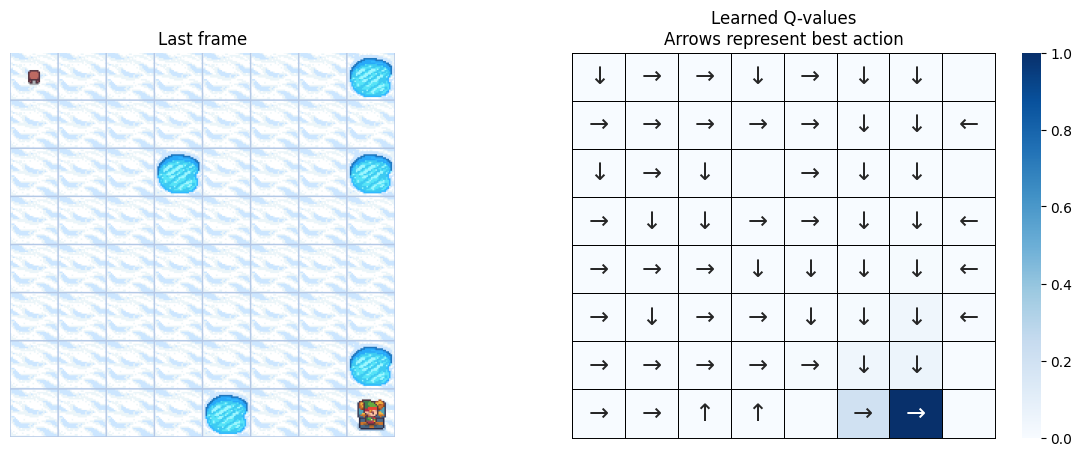

In [79]:
plot_q_values_map(agent_best_sarsa_err.get_Q_Table(), env, side_map_size)

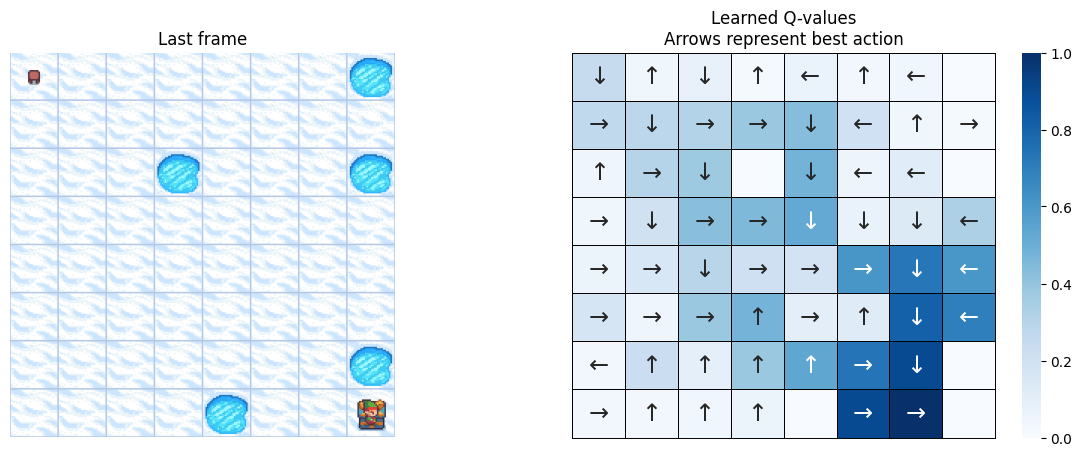

In [80]:
plot_q_values_map(agent_best_sarsa_stp.get_Q_Table(), env, side_map_size)

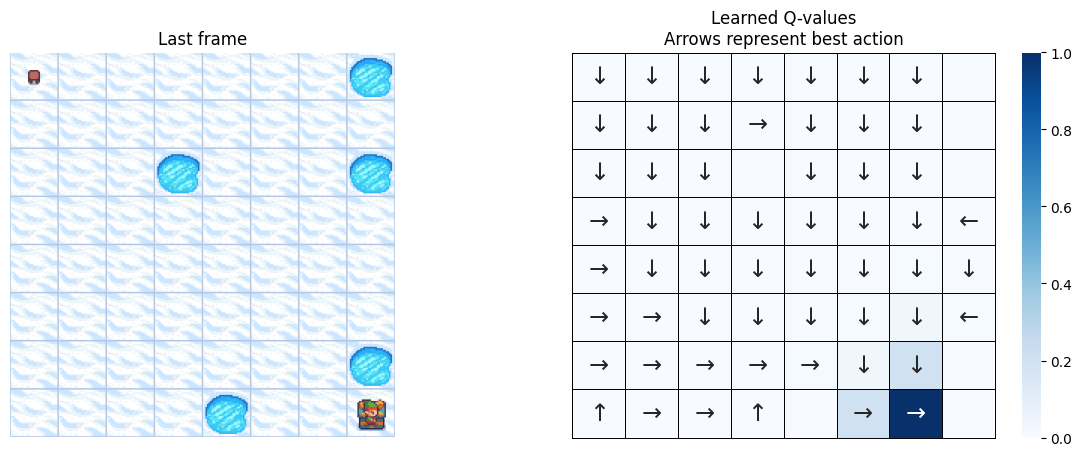

In [82]:
plot_q_values_map(agent_best_q_acc.get_Q_Table(), env, side_map_size)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


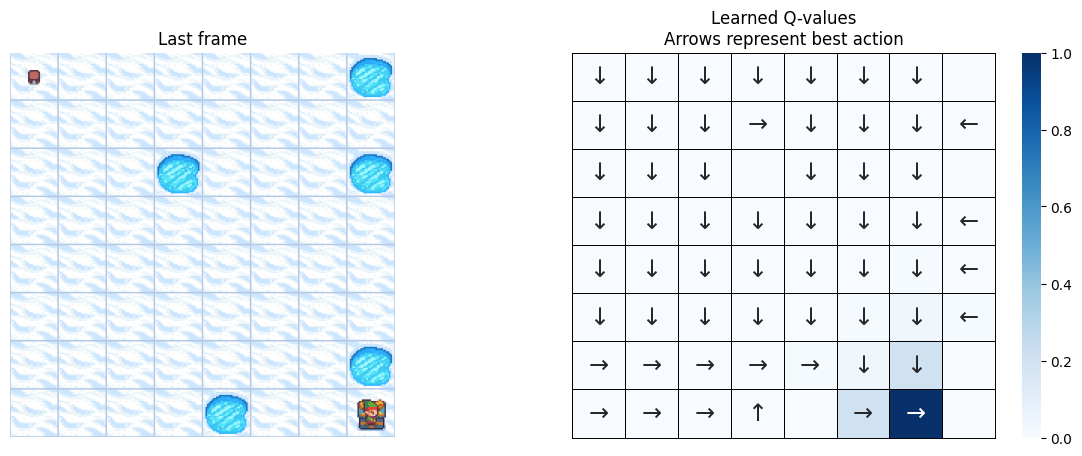

In [83]:
plot_q_values_map(agent_best_q_err.get_Q_Table(), env, side_map_size)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


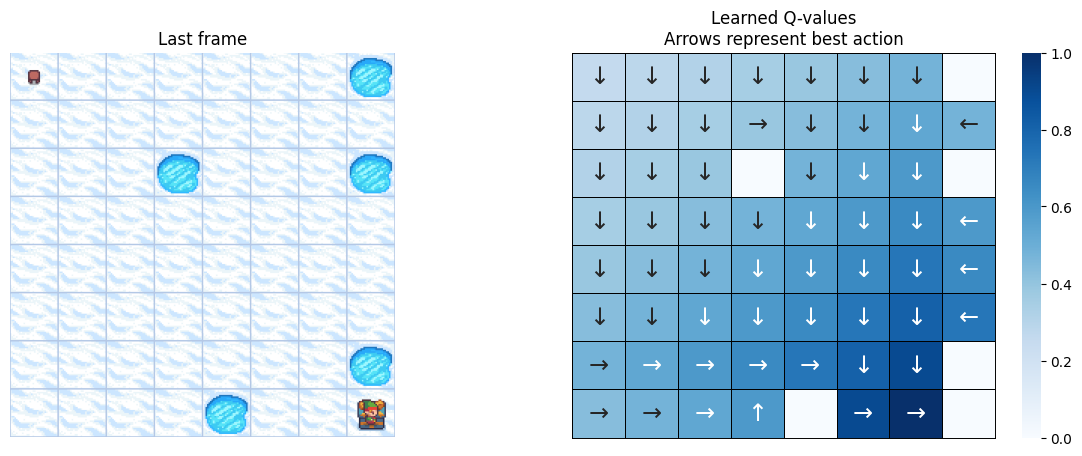

In [84]:
plot_q_values_map(agent_best_q_stp.get_Q_Table(), env, side_map_size)

In [ ]:
df_sarsa = df_experiments[df_experiments.agent == 'tabular_sarsa']
df_q = df_experiments[df_experiments.agent == 'tabular_q']

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import seaborn as sns

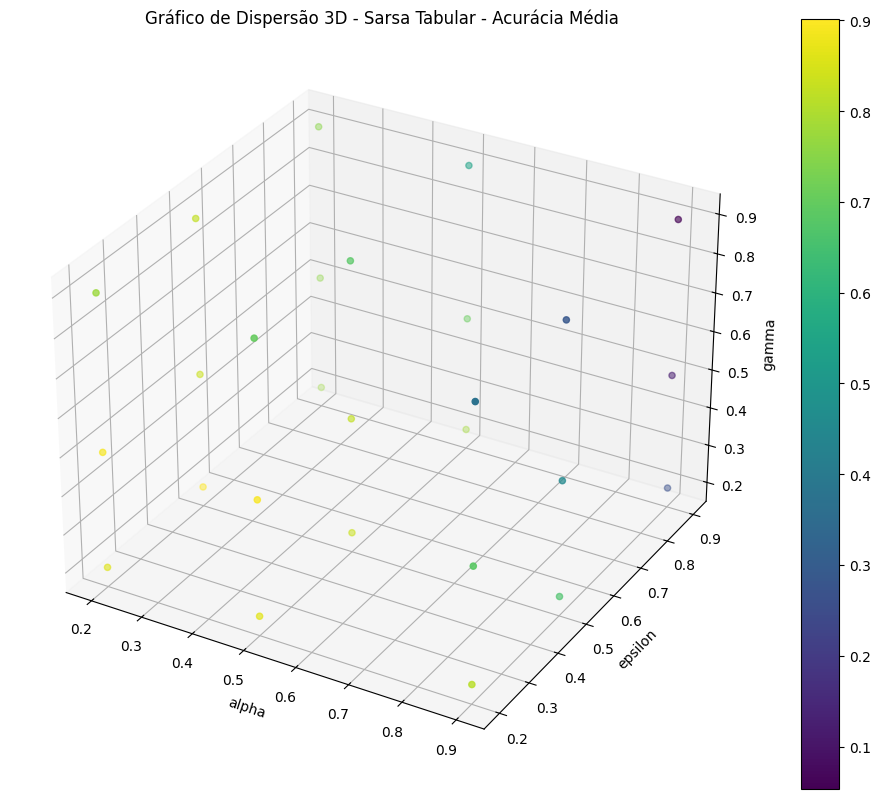

In [ ]:
x = df_sarsa["alpha"]
y = df_sarsa["epsilon"]
z = df_sarsa["gamma"]
g = df_sarsa["mean_accuracy"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('alpha')
ax.set_ylabel('epsilon')
ax.set_zlabel('gamma')

ax.set_title('Gráfico de Dispersão 3D - Sarsa Tabular - Acurácia Média')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


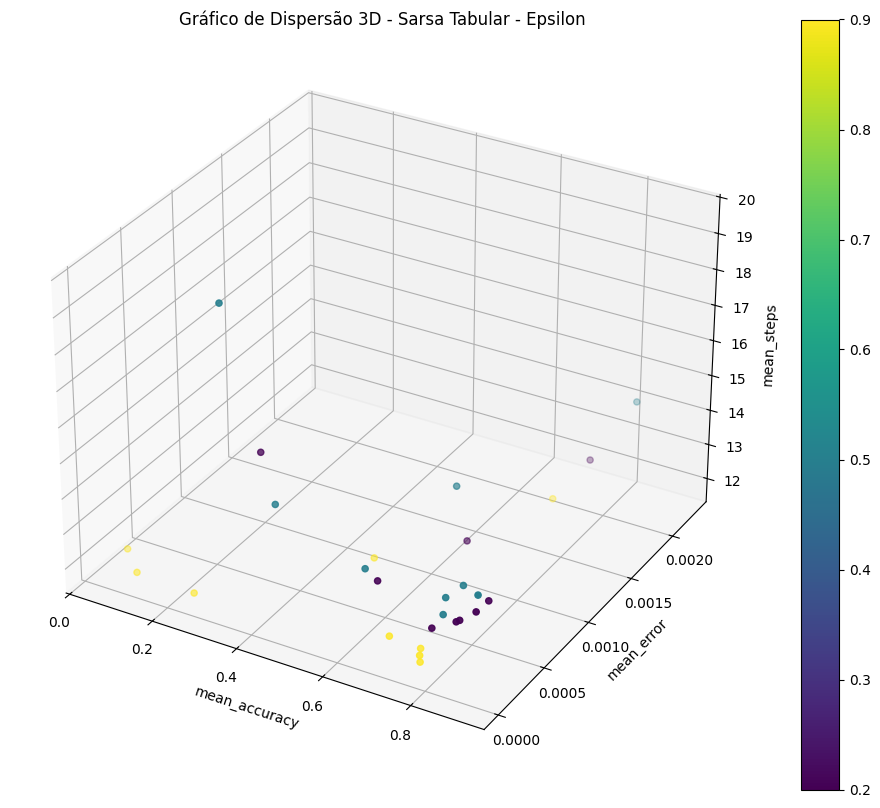

In [ ]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["epsilon"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Sarsa Tabular - Epsilon')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [ ]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["alpha"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Sarsa Tabular - Alpha')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [ ]:
df_sarsa[df_sarsa['mean_error'] == df_sarsa['mean_error'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.2  [0.0, 0.0, 0.04, 0.06, 0.06, 1.0, 1.0, 1.0, 0....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [14, 30, 27, 58, 34, 13, 5, 59, 26, 4, 12, 7, ...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.3716    0.000015       21.91

In [ ]:
df_sarsa[df_sarsa['mean_steps'] == df_sarsa['mean_steps'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.2    0.2  [0.02, 0.0, 0.04, 0.0, 0.06, 1.0, 1.0, 1.0, 1....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [42, 5, 13, 24, 5, 28, 3, 8, 5, 78, 99, 100, 1...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.9512    0.000045     15.2337

In [ ]:
df_sarsa[df_sarsa['mean_accuracy'] == df_sarsa['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.2    0.5  [0.02, 0.0, 0.04, 0.06, 1.0, 1.0, 1.0, 1.0, 1....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [42, 5, 13, 53, 7, 2, 8, 16, 57, 5, 79, 8, 33,...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.9612    0.000126     15.3581

In [ ]:
df_q[df_q['mean_error'] == df_q['mean_error'].min()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.2  [0.0, 0.02, 0.0, 0.0, 0.0, 0.06, 1.0, 1.0, 1.0...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [2, 32, 3, 3, 21, 36, 8, 59, 4, 9, 16, 10, 15,...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         0.9408    0.000021     19.9709

In [ ]:
df_q[df_q['mean_steps'] == df_q['mean_steps'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.2      0.2    0.2  [0.02, 0.02, 0.04, 0.32, 1.0, 1.0, 1.0, 1.0, 1...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [15, 31, 2, 18, 24, 3, 16, 13, 11, 84, 8, 49, ...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0          0.964     0.00012      14.812

In [ ]:
df_q[df_q['mean_accuracy'] == df_q['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.5    0.5  [0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [3, 8, 23, 39, 12, 13, 27, 5, 31, 4, 4, 33, 36...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         0.9902     0.00015     16.5911

<BarContainer object of 10000 artists>

ValueError: object too deep for desired array

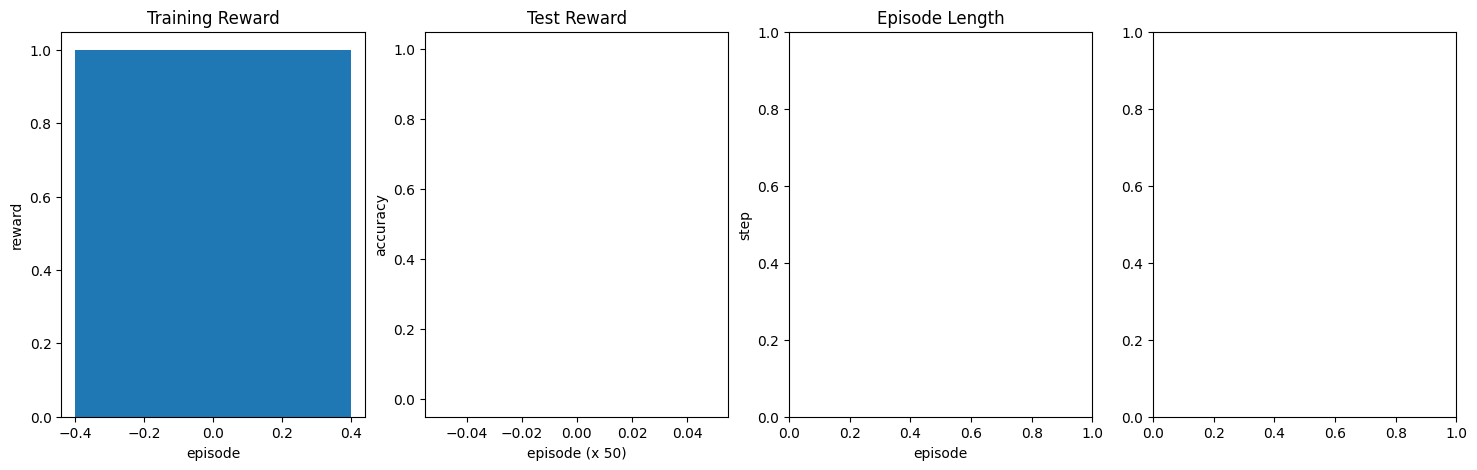

In [ ]:
row = df_q[df_q['mean_error'] == df_q['mean_error'].min()]
filename = "q_min_error.png"

rewards = row['rewards'].tolist()
accuracies = row['accuracy'].tolist()
steps = row['steps'].tolist()
training_error = row['error'].tolist()

rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), *rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), *steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), *training_error_moving_average)

plt.tight_layout()
plt.savefig(filename)
plt.show()

In [ ]:
type(rewards.tolist()), type(accuracies), type(steps), type(training_error)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(list,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [ ]:
def save_img_summary(row, filename):
  rewards = row['rewards']
  accuracies = row['accuracy']
  steps = row['steps']
  training_error = row['error']

  rolling_length = 100
  fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
  axs[0].set_title("Training Reward")
  axs[0].set_xlabel('episode')
  axs[0].set_ylabel('reward')
  axs[0].bar(range(len(rewards)), rewards)

  axs[1].set_title("Test Reward")
  axs[1].set_xlabel('episode (x 50)')
  axs[1].set_ylabel('accuracy')
  axs[1].plot(range(len(accuracies)), accuracies)

  axs[2].set_title("Episode Length")
  axs[2].set_xlabel('episode')
  axs[2].set_ylabel('step')
  steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
  axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

  axs[3].set_title("Training Error")
  axs[3].set_xlabel('step')
  axs[3].set_ylabel('error')
  training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
  axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

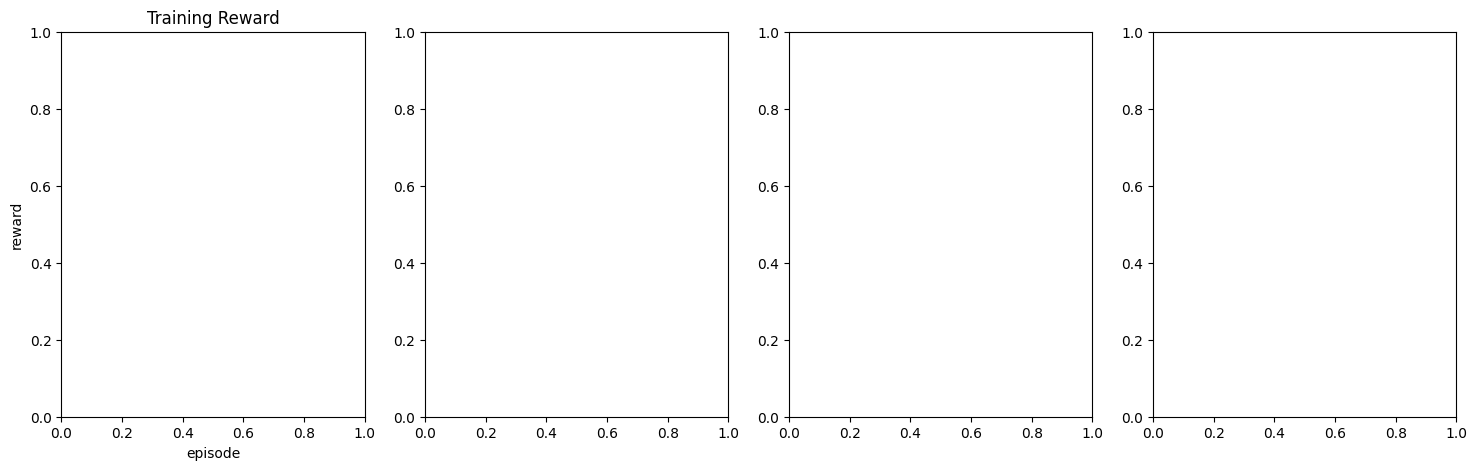

In [ ]:
save_img_summary(df_q[df_q['mean_error'] == df_q['mean_error'].min()], "q_min_error.png")
save_img_summary(df_q[df_q['mean_steps'] == df_q['mean_steps'].min()], "q_min_steps.png")
save_img_summary(df_q[df_q['mean_accuracy'] == df_q['mean_accuracy'].max()], "q_max_accuracy.png")

save_img_summary(df_sarsa[df_sarsa['mean_error'] == df_sarsa['mean_error'].min()], "sarsa_min_error.png")
save_img_summary(df_sarsa[df_sarsa['mean_steps'] == df_sarsa['mean_steps'].min()], "sarsa_min_steps.png")
save_img_summary(df_sarsa[df_sarsa['mean_accuracy'] == df_sarsa['mean_accuracy'].max()], "sarsa_max_accuracy.png")


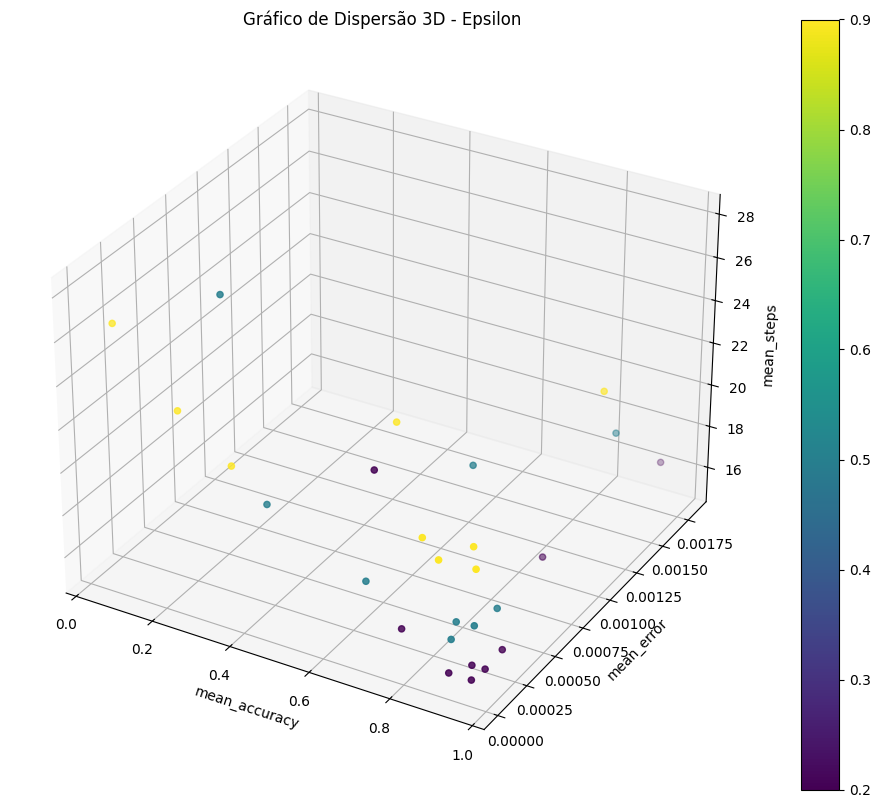

In [ ]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["epsilon"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Epsilon')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

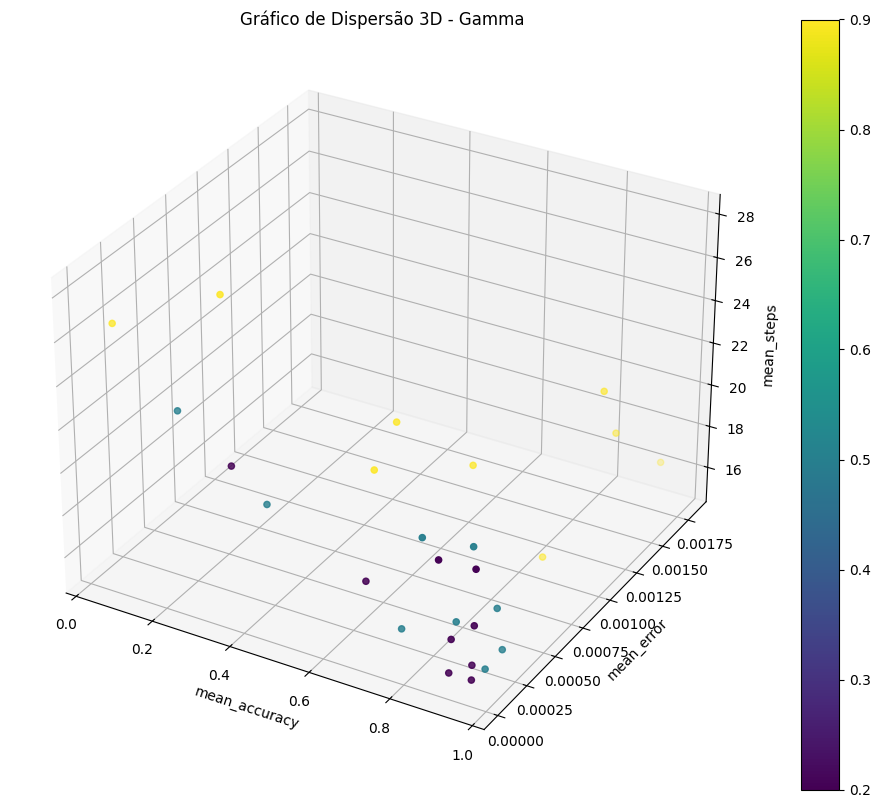

In [ ]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["gamma"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Gamma')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

<Axes: xlabel='epsilon', ylabel='mean_steps'>

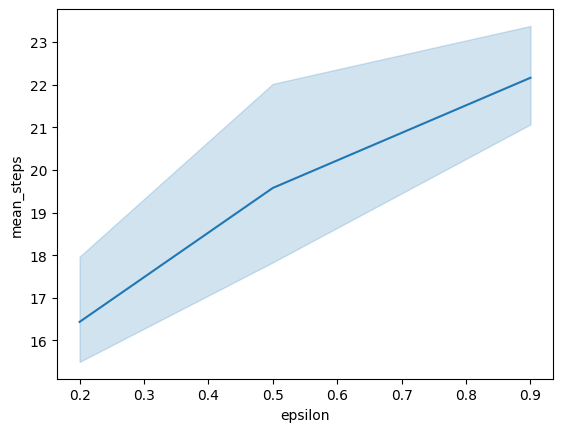

In [ ]:
sns.lineplot(data=df_sarsa, x="epsilon", y="mean_steps")

<Axes: xlabel='gamma', ylabel='mean_steps'>

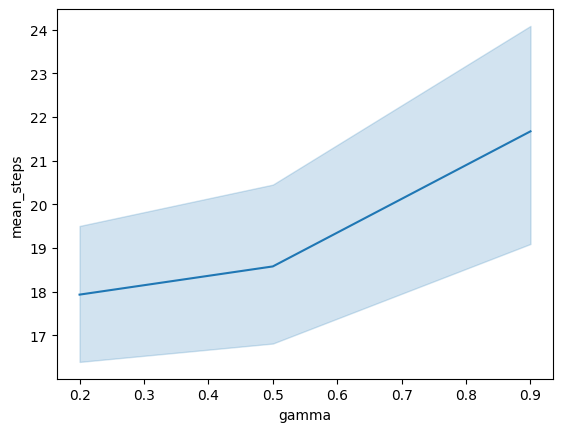

In [ ]:
sns.lineplot(data=df_sarsa, x="gamma", y="mean_steps")

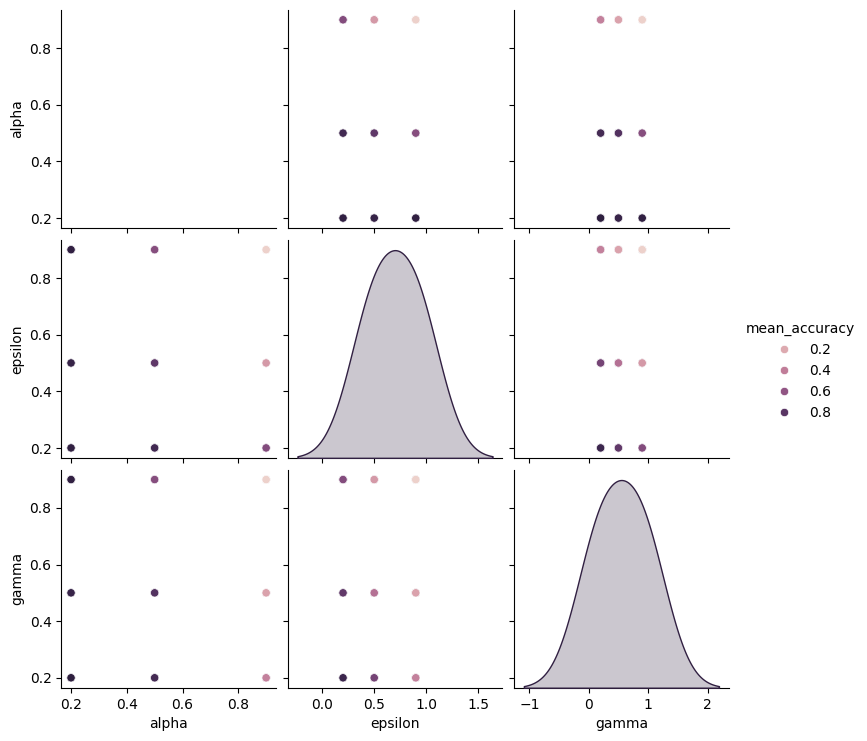

In [ ]:
sns.pairplot(df_sarsa[["mean_accuracy", "alpha", "epsilon", "gamma"]], hue="mean_accuracy")

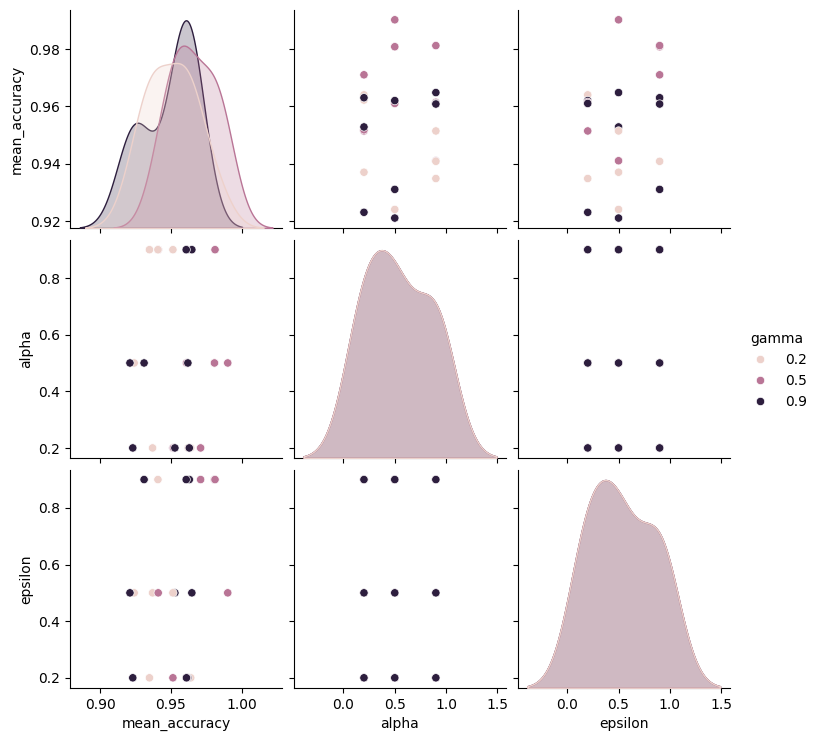

In [ ]:
sns.pairplot(df_q[["mean_accuracy", "alpha", "epsilon", "gamma"]], hue="gamma")

In [ ]:
df_q

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon                                           accuracy  \
0    0.4      0.4  [0.04, 0.0, 0.04, 0.04, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.4      0.5  [0.0, 0.02, 0.0, 0.04, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.4      0.6  [0.0, 0.0, 0.0, 0.04, 0.02, 0.06, 1.0, 1.0, 1....   
0    0.4      0.7  [0.02, 0.0, 0.04, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.5      0.4  [0.02, 0.0, 0.04, 0.06, 0.3, 1.0, 1.0, 1.0, 1....   
0    0.5      0.5  [0.02, 0.0, 0.04, 0.02, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.5      0.6  [0.0, 0.0, 0.32, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
0    0.5      0.7  [0.0, 0.0, 0.04, 0.04, 0.14, 1.0, 1.0, 1.0, 1....   
0    0.6      0.4  [0.0, 0.0, 0.04, 0.02, 0.0, 0.02, 1.0, 1.0, 1....   
0    0.6      0.5  [0.0, 0.0, 0.0, 0.02, 0.02, 0.02, 1.0, 1.0, 1....   
0    0.6      0.6  [0.02, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
0    0.6      0.7  [0.0, 0.0, 0.02, 0.14, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.7      0.4  [0.02, 0.0, 0.04, 0.08, 0.54, 1.0, 1.0, 1.0, 1...   
0    0.7      0.5  [0.02, 0.02, 0.02, 0.02, 0.02, 0.22, 1.0, 1.0,...   
0    0.7      0.6  [0.02, 0.02, 0.42, 1.0, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.7      0.7  [0.0, 0.02, 0.0, 0.06, 1.0, 1.0, 1.0, 1.0, 1.0...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [2, 6, 11, 8, 17, 6, 67, 5, 48, 3, 22, 29, 32,...   
0  [8, 3, 13, 36, 7, 24, 27, 5, 7, 3, 5, 4, 15, 1...   
0  [2, 3, 14, 44, 11, 19, 12, 3, 13, 4, 5, 7, 3, ...   
0  [9, 3, 3, 13, 24, 8, 28, 4, 24, 23, 10, 2, 15,...   
0  [3, 18, 6, 6, 11, 6, 48, 3, 27, 17, 3, 3, 15, ...   
0  [3, 8, 2, 11, 66, 13, 2, 10, 9, 3, 4, 6, 78, 1...   
0  [2, 14, 45, 27, 14, 60, 43, 18, 6, 8, 12, 12, ...   
0  [5, 6, 2, 9, 15, 44, 22, 9, 19, 8, 7, 6, 13, 1...   
0  [3, 28, 24, 13, 10, 9, 7, 7, 14, 10, 21, 17, 3...   
0  [3, 11, 13, 32, 12, 7, 3, 17, 24, 5, 28, 2, 22...   
0  [5, 6, 15, 10, 14, 39, 12, 23, 2, 5, 7, 7, 43,...   
0  [12, 13, 46, 22, 3, 9, 10, 50, 11, 8, 80, 28, ...   
0  [2, 23, 11, 11, 26, 14, 7, 25, 6, 5, 5, 20, 29...   
0  [4, 25, 5, 27, 4, 7, 34, 17, 7, 6, 14, 19, 22,...   
0  [5, 5, 14, 11, 18, 24, 26, 23, 7, 6, 6, 20, 25...   
0  [27, 21, 44, 5, 17, 3, 8, 4, 18, 14, 14, 3, 27...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0

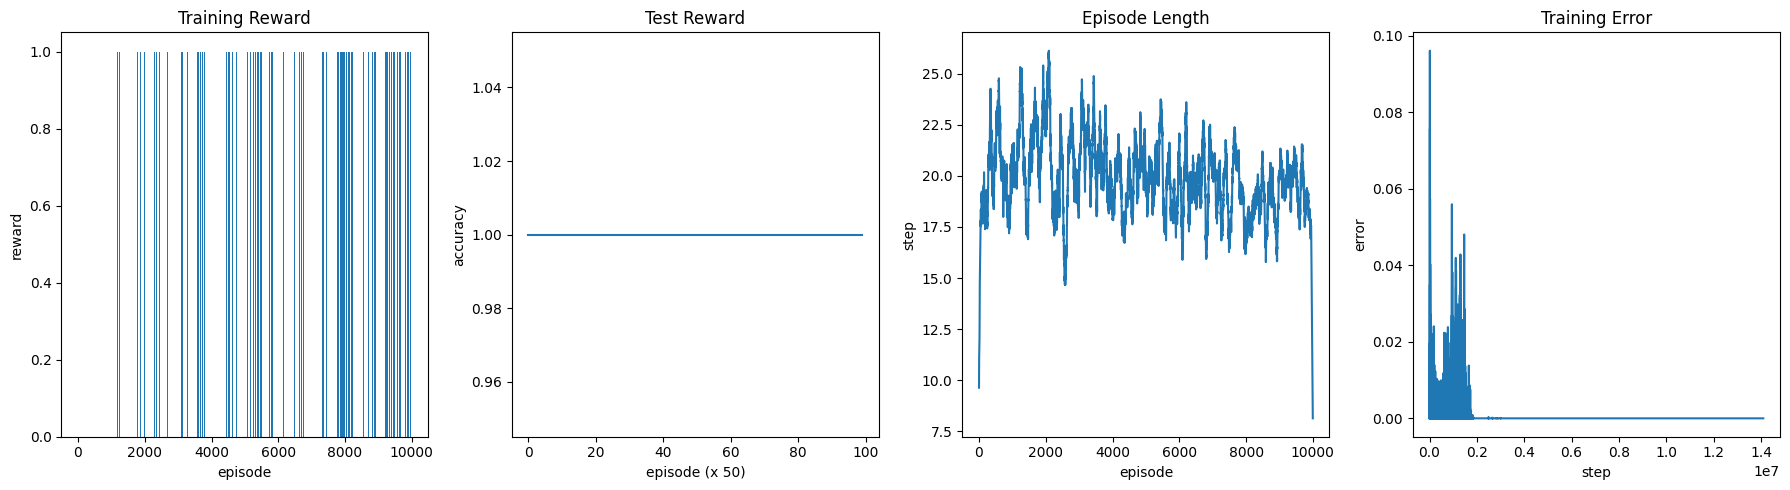

In [ ]:
save_imgs(df_experiments.iloc[0].error, df_experiments.iloc[0].rewards, df_experiments.iloc[161].accuracy, df_experiments.iloc[161].steps,
          f'{df_experiments.iloc[161].agent}_{alpha}_{epsilon}.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
sum(df_experiments.iloc[1].accuracy)/len(df_experiments.iloc[1].accuracy)

1.0

<ipython-input-150-db9ebaf8bbe4>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],


alpha  epsilon                                           accuracy  \
0    0.1      0.1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                             rewards  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                               steps  \
0  [14, 15, 14, 14, 14, 17, 16, 15, 16, 6, 18, 18...   

                                               error          agent  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa

In [ ]:
df_experiments.to_pickle('df_experiments.pkl')

In [ ]:
after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
html_sarsa = render_mp4(after_training_sarsa)
HTML(html_sarsa)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
html_q = render_mp4(after_training_q)
HTML(html_q)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 191/10000 [00:00<00:19, 494.61it/s]

step: 4609, episode: 100, accuracy training: 0.06, accuracy test: 0.54, random move probability: 0.49600000000000155
step: 7476, episode: 200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:15, 626.00it/s]

step: 10111, episode: 300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.48800000000000465
step: 12472, episode: 400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 590/10000 [00:00<00:12, 738.21it/s]

step: 14645, episode: 500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 16909, episode: 600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 801/10000 [00:01<00:14, 635.39it/s]

step: 19128, episode: 700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 21490, episode: 800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1024/10000 [00:01<00:12, 696.27it/s]

step: 23836, episode: 900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 26081, episode: 1000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:12, 730.07it/s]

step: 28231, episode: 1100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 30426, episode: 1200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1422/10000 [00:02<00:12, 679.68it/s]

step: 32624, episode: 1300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 34779, episode: 1400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:02<00:11, 728.19it/s]

step: 37066, episode: 1500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 39155, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1844/10000 [00:02<00:11, 727.72it/s]

step: 41308, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 43336, episode: 1800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:03<00:11, 705.65it/s]

step: 45486, episode: 1900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 47502, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2226/10000 [00:03<00:11, 700.25it/s]

step: 49723, episode: 2100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 51789, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:03<00:10, 733.72it/s]

step: 54076, episode: 2300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 56058, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2658/10000 [00:03<00:09, 772.51it/s]

step: 58142, episode: 2500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 60232, episode: 2600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2810/10000 [00:04<00:10, 656.66it/s]

step: 62345, episode: 2700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 64483, episode: 2800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:04<00:09, 728.45it/s]

step: 66574, episode: 2900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 68560, episode: 3000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:04<00:08, 768.53it/s]

step: 70531, episode: 3100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 72557, episode: 3200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3396/10000 [00:04<00:08, 824.53it/s]

step: 74507, episode: 3300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 76627, episode: 3400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▋      | 3635/10000 [00:05<00:08, 718.20it/s]

step: 78671, episode: 3500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 80673, episode: 3600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:05<00:08, 740.67it/s]

step: 82705, episode: 3700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 84664, episode: 3800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 779.36it/s]

step: 86554, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 88383, episode: 4000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4198/10000 [00:05<00:07, 813.13it/s]

step: 90343, episode: 4100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 92304, episode: 4200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4438/10000 [00:06<00:07, 749.25it/s]

step: 94224, episode: 4300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 96120, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:06<00:07, 707.14it/s]

step: 98110, episode: 4500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 100077, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:06, 768.74it/s]

step: 101903, episode: 4700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 103783, episode: 4800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30800000000007444


 51%|█████     | 5062/10000 [00:07<00:06, 767.36it/s]

step: 105688, episode: 4900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.304000000000076
step: 107552, episode: 5000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5216/10000 [00:07<00:06, 732.17it/s]

step: 109422, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 111243, episode: 5200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:07<00:05, 781.25it/s]

step: 113123, episode: 5300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 114908, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 819.91it/s]

step: 116671, episode: 5500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 118450, episode: 5600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:07<00:05, 809.37it/s]

step: 120227, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 122095, episode: 5800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6046/10000 [00:08<00:05, 782.41it/s]

step: 123881, episode: 5900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 125634, episode: 6000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6215/10000 [00:08<00:04, 807.55it/s]

step: 127394, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 129063, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6376/10000 [00:08<00:04, 737.85it/s]

step: 130760, episode: 6300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 132477, episode: 6400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6590/10000 [00:09<00:05, 594.91it/s]

step: 134214, episode: 6500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 136026, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6790/10000 [00:09<00:05, 573.45it/s]

step: 137797, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 139491, episode: 6800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6980/10000 [00:09<00:05, 573.02it/s]

step: 141258, episode: 6900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 142950, episode: 7000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7182/10000 [00:10<00:04, 609.77it/s]

step: 144616, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 146398, episode: 7200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7383/10000 [00:10<00:04, 606.32it/s]

step: 148138, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 149834, episode: 7400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7574/10000 [00:10<00:04, 567.16it/s]

step: 151471, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 153100, episode: 7600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7766/10000 [00:11<00:04, 547.05it/s]

step: 154783, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 156422, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8004/10000 [00:11<00:04, 498.98it/s]

step: 158100, episode: 7900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 159754, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:12<00:03, 482.52it/s]

step: 161457, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 163086, episode: 8200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8413/10000 [00:12<00:02, 597.09it/s]

step: 164736, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 166341, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:12<00:01, 725.57it/s]

step: 167939, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 169522, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814


 89%|████████▉ | 8888/10000 [00:13<00:01, 838.97it/s]

step: 171175, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 172757, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657


 91%|█████████ | 9058/10000 [00:13<00:01, 830.36it/s]

step: 174308, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 175918, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9227/10000 [00:13<00:00, 785.57it/s]

step: 177515, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 179030, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:13<00:00, 813.05it/s]

step: 180595, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 182152, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:13<00:00, 824.75it/s]

step: 183701, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 185296, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:14<00:00, 847.76it/s]

step: 186868, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 188387, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:14<00:00, 692.52it/s]

step: 189878, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 191388, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [ ]:
max(steps_sarsa)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

As métricas são apresentadas a seguir. Vê-se, conforme explicado acima, que a recompensa é 1 no objetivo final e 0 em outros passos. A diferença entre a abordagem SARSA e Q

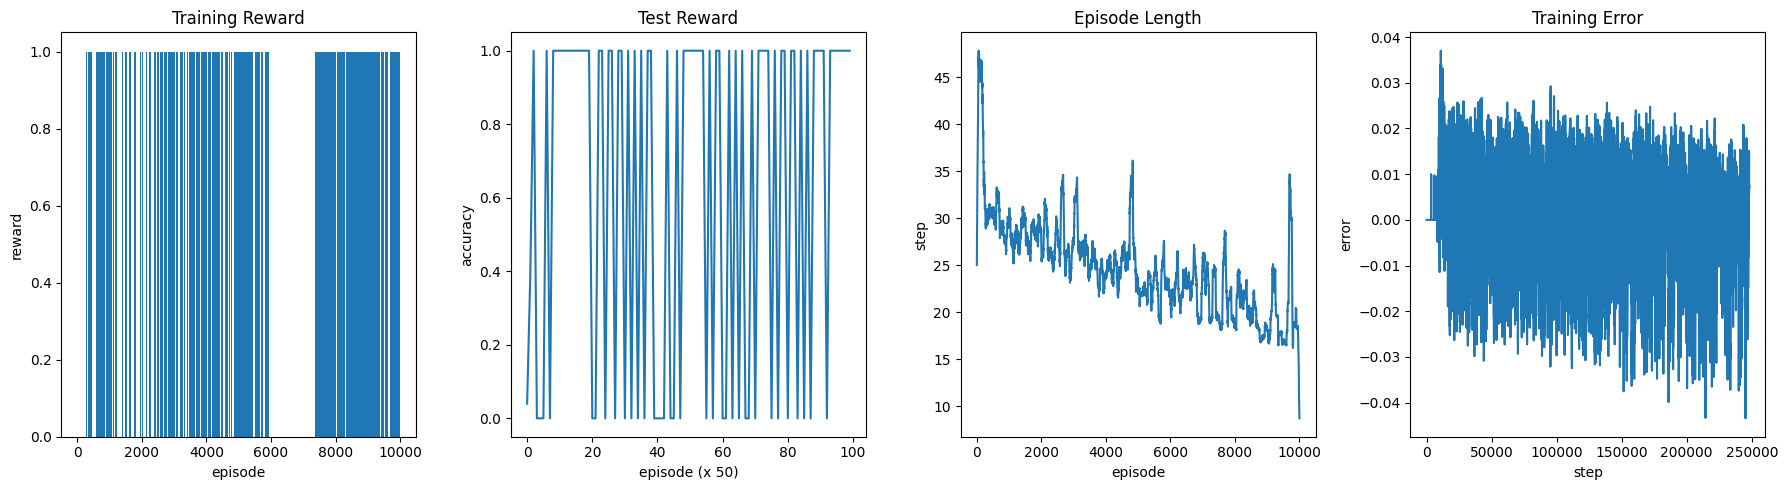

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_sarsa)), rewards_sarsa)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_sarsa)), accuracies_sarsa)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_sarsa), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_sarsa.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

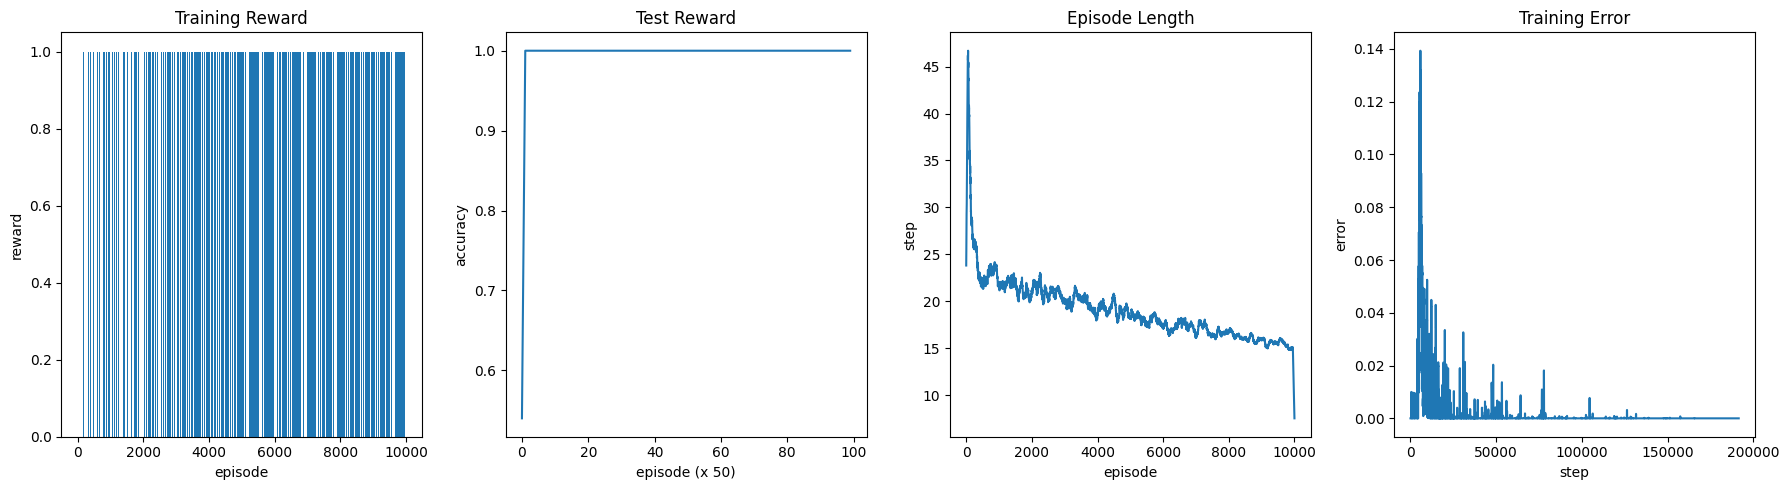

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_q)), rewards_q)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_q)), accuracies_q)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_q), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_q.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [ ]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

plot_q_values_map(agent_sarsa.get_Q_Table(), env, side_map_size)

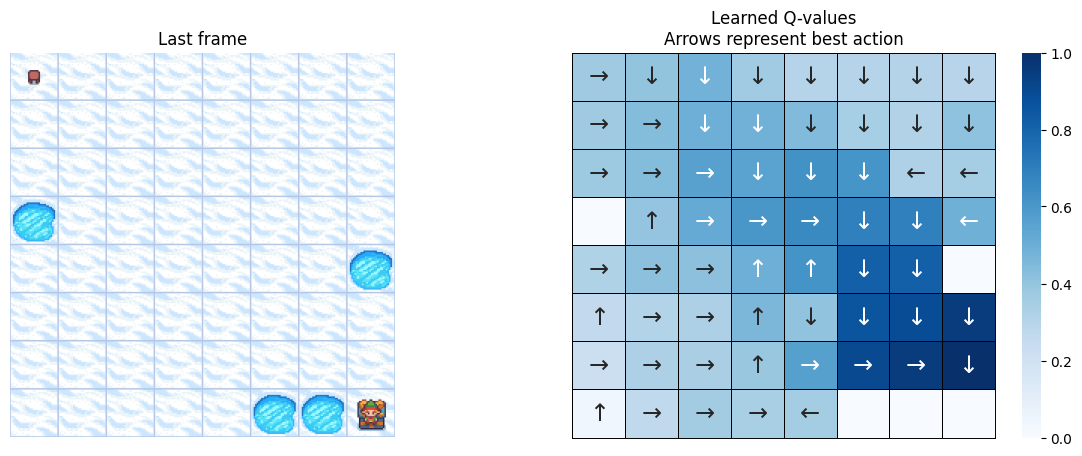

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


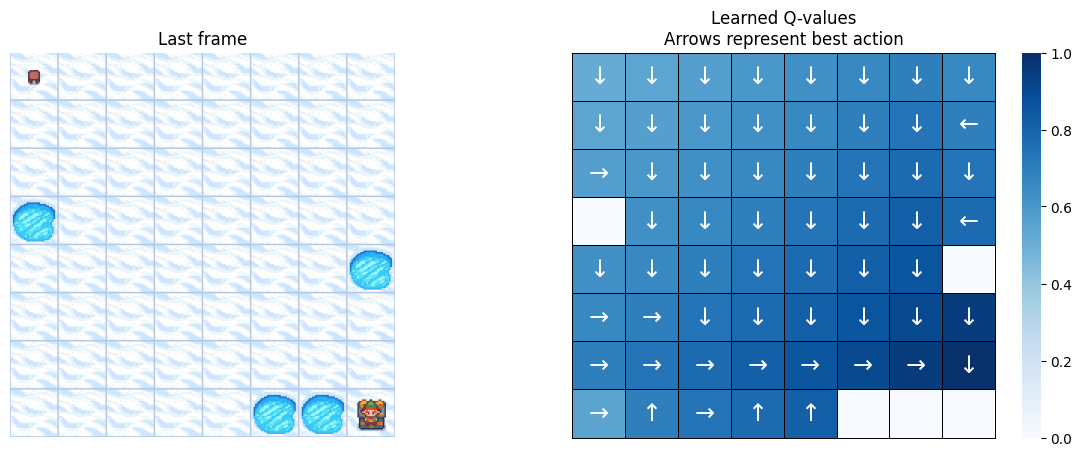

In [ ]:
plot_q_values_map(agent_q.get_Q_Table(), env, side_map_size)

### Criando uma estratégia baseada em redes neurais PyTorch

A seguir, avaliamos o desempenho de um agente de Aprendizado por Reforço que utiliza uma rede neural.

In [ ]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [ ]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()
        self.input_layer = nn.Linear(state_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    def forward(self, state):
        x = self.input_layer(state)

        x = torch.sigmoid(self.hidden_layer(x))

        return self.output_layer(x)

In [ ]:
from torch.nn.functional import one_hot

class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Network(self):
        return self.model

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def get_one_hot_tensor(self, state):
        # One-hot encode state before passing to the model
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.int64)
        return one_hot(state_tensor, num_classes=self.state_space.n).type(torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def max_eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.max(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_one_hot_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_one_hot_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)

        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [ ]:
# hyperparameters
alpha_learning_rate = 0.0001 # @param {type:"number"}
nb_max_episodes = 3000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.n, hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 64 , Hidden = 64 , output = 4
Q-learning agent started


In [ ]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

df_experiments_cp = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha}, epsilon {epsilon} e gamma {gamma_discount_factor}')
            agent_sarsa = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = True
            )

            agent_q = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = True
            )

            after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            error = agent_sarsa.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            error = agent_q.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments)}')


Rodando alpha 0.2, epsilon 0.2 e gamma 0.2
SARSA agent started
SARSA agent started


  4%|▎         | 110/3000 [00:01<00:38, 74.37it/s]

step: 726, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48666666666666814


  7%|▋         | 221/3000 [00:02<00:26, 106.29it/s]

step: 1178, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47333333333333627


 10%|█         | 311/3000 [00:03<00:31, 86.22it/s]

step: 1671, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4600000000000044


 14%|█▍        | 426/3000 [00:05<00:57, 44.46it/s]

step: 2173, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44666666666667254


 17%|█▋        | 514/3000 [00:07<00:42, 57.99it/s]

step: 2662, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4333333333333407


 21%|██        | 620/3000 [00:08<00:35, 67.29it/s]

step: 3070, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4200000000000088


 24%|██▍       | 735/3000 [00:09<00:14, 154.55it/s]

step: 3495, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.40666666666667695


 27%|██▋       | 814/3000 [00:09<00:20, 104.20it/s]

step: 4043, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3933333333333451


 31%|███       | 917/3000 [00:10<00:16, 124.08it/s]

step: 4555, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3800000000000132


 34%|███▍      | 1018/3000 [00:11<00:30, 65.45it/s]

step: 5032, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.36666666666668135


 37%|███▋      | 1124/3000 [00:12<00:13, 141.81it/s]

step: 5511, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3533333333333495


 41%|████      | 1234/3000 [00:13<00:10, 170.43it/s]

step: 5933, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3400000000000176


 44%|████▍     | 1319/3000 [00:14<00:26, 63.26it/s]

step: 6379, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.32666666666668576


 47%|████▋     | 1414/3000 [00:14<00:11, 141.41it/s]

step: 6828, episode: 1400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.3133333333333539


 50%|█████     | 1506/3000 [00:17<00:56, 26.67it/s]

step: 7411, episode: 1500, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.300000000000022


 55%|█████▍    | 1642/3000 [00:19<00:11, 119.45it/s]

step: 8305, episode: 1600, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.28666666666669016


 58%|█████▊    | 1729/3000 [00:20<00:13, 95.91it/s]

step: 8598, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.2733333333333583


 62%|██████▏   | 1847/3000 [00:21<00:07, 160.56it/s]

step: 9017, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.26000000000002643


 64%|██████▎   | 1905/3000 [00:21<00:05, 214.61it/s]

step: 9272, episode: 1900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2008/3000 [00:22<00:06, 146.04it/s]

step: 9864, episode: 2000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.23333333333335923


 71%|███████   | 2116/3000 [00:23<00:07, 123.00it/s]

step: 10559, episode: 2100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.2200000000000246


 75%|███████▍  | 2246/3000 [00:24<00:07, 95.65it/s]

step: 10983, episode: 2200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.20666666666668995


 78%|███████▊  | 2342/3000 [00:24<00:03, 191.22it/s]

step: 11277, episode: 2300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1933333333333553


 80%|████████  | 2402/3000 [00:25<00:03, 188.53it/s]

step: 11585, episode: 2400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18000000000002067


 85%|████████▍ | 2539/3000 [00:26<00:02, 174.77it/s]

step: 12064, episode: 2500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.16666666666668603


 87%|████████▋ | 2615/3000 [00:26<00:02, 162.57it/s]

step: 12388, episode: 2600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1533333333333514


 91%|█████████ | 2736/3000 [00:27<00:01, 172.18it/s]

step: 13093, episode: 2700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.14000000000001675


 94%|█████████▍| 2830/3000 [00:28<00:01, 152.32it/s]

step: 13545, episode: 2800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1266666666666821


 99%|█████████▊| 2958/3000 [00:28<00:00, 270.62it/s]

step: 14010, episode: 2900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [00:30<00:00, 98.58it/s] 


step: 14342, episode: 3000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.10000000000001544


  0%|          | 0/3000 [00:00<?, ?it/s]


RuntimeError: a Tensor with 4 elements cannot be converted to Scalar

In [ ]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter


def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()


In [ ]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  4%|▍         | 127/3000 [00:00<00:15, 190.04it/s]

step: 477, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48666666666666814


  7%|▋         | 209/3000 [00:02<01:20, 34.54it/s] 

step: 1031, episode: 200, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.47333333333333627


 10%|█         | 311/3000 [00:06<02:12, 20.22it/s]

step: 2416, episode: 300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.4600000000000044


 14%|█▎        | 405/3000 [00:09<02:06, 20.48it/s]

step: 3606, episode: 400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.44666666666667254


 17%|█▋        | 507/3000 [00:11<01:51, 22.28it/s]

step: 5145, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4333333333333407


 20%|██        | 603/3000 [00:15<04:52,  8.20it/s]

step: 6408, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4200000000000088


 24%|██▎       | 706/3000 [00:21<02:43, 14.04it/s]

step: 8417, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.40666666666667695


 27%|██▋       | 806/3000 [00:24<01:31, 23.97it/s]

step: 9626, episode: 800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.3933333333333451


 30%|███       | 902/3000 [00:26<01:06, 31.71it/s]

step: 10948, episode: 900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.3800000000000132


 34%|███▎      | 1006/3000 [00:29<01:39, 19.98it/s]

step: 12723, episode: 1000, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.36666666666668135


 37%|███▋      | 1105/3000 [00:31<01:01, 30.76it/s]

step: 14198, episode: 1100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.3533333333333495


 40%|████      | 1207/3000 [00:36<02:43, 10.96it/s]

step: 15611, episode: 1200, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.3400000000000176


 44%|████▎     | 1306/3000 [00:38<00:45, 37.48it/s]

step: 17103, episode: 1300, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.32666666666668576


 47%|████▋     | 1406/3000 [00:41<01:13, 21.64it/s]

step: 18557, episode: 1400, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.3133333333333539


 50%|█████     | 1508/3000 [00:43<00:38, 39.23it/s]

step: 19912, episode: 1500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.300000000000022


 54%|█████▎    | 1608/3000 [00:45<00:33, 41.80it/s]

step: 21337, episode: 1600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.28666666666669016


 57%|█████▋    | 1703/3000 [00:48<01:03, 20.28it/s]

step: 22759, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.2733333333333583


 60%|██████    | 1808/3000 [00:51<00:27, 42.74it/s]

step: 24113, episode: 1800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.26000000000002643


 63%|██████▎   | 1903/3000 [00:53<00:29, 37.29it/s]

step: 25556, episode: 1900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2004/3000 [00:55<00:28, 35.55it/s]

step: 27007, episode: 2000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.23333333333335923


 70%|███████   | 2109/3000 [00:57<00:21, 42.11it/s]

step: 28449, episode: 2100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2200000000000246


 73%|███████▎  | 2204/3000 [01:00<00:27, 28.97it/s]

step: 29929, episode: 2200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20666666666668995


 77%|███████▋  | 2302/3000 [01:04<00:47, 14.82it/s]

step: 31439, episode: 2300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1933333333333553


 80%|████████  | 2404/3000 [01:06<00:18, 32.65it/s]

step: 32943, episode: 2400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.18000000000002067


 84%|████████▎ | 2509/3000 [01:08<00:11, 42.08it/s]

step: 34393, episode: 2500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16666666666668603


 87%|████████▋ | 2608/3000 [01:10<00:09, 42.25it/s]

step: 35784, episode: 2600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1533333333333514


 90%|█████████ | 2710/3000 [01:13<00:06, 43.15it/s]

step: 37207, episode: 2700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000001675


 93%|█████████▎| 2804/3000 [01:15<00:08, 22.92it/s]

step: 38631, episode: 2800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1266666666666821


 97%|█████████▋| 2906/3000 [01:19<00:02, 39.96it/s]

step: 40086, episode: 2900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [01:21<00:00, 36.89it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 41553, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000001544


IndexError: list index out of range

In [ ]:
html = render_mp4(after_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Analisamos as métricas da execução de um Agente de aprendizado por reforço com rede neural. Percebe-se que o comprimento dos episódios decresce em uma taxa superior àquelas observadas em abordagens tradicionais. Ademais, o erro de treinamento é muito inferior aos observados anteriormente.

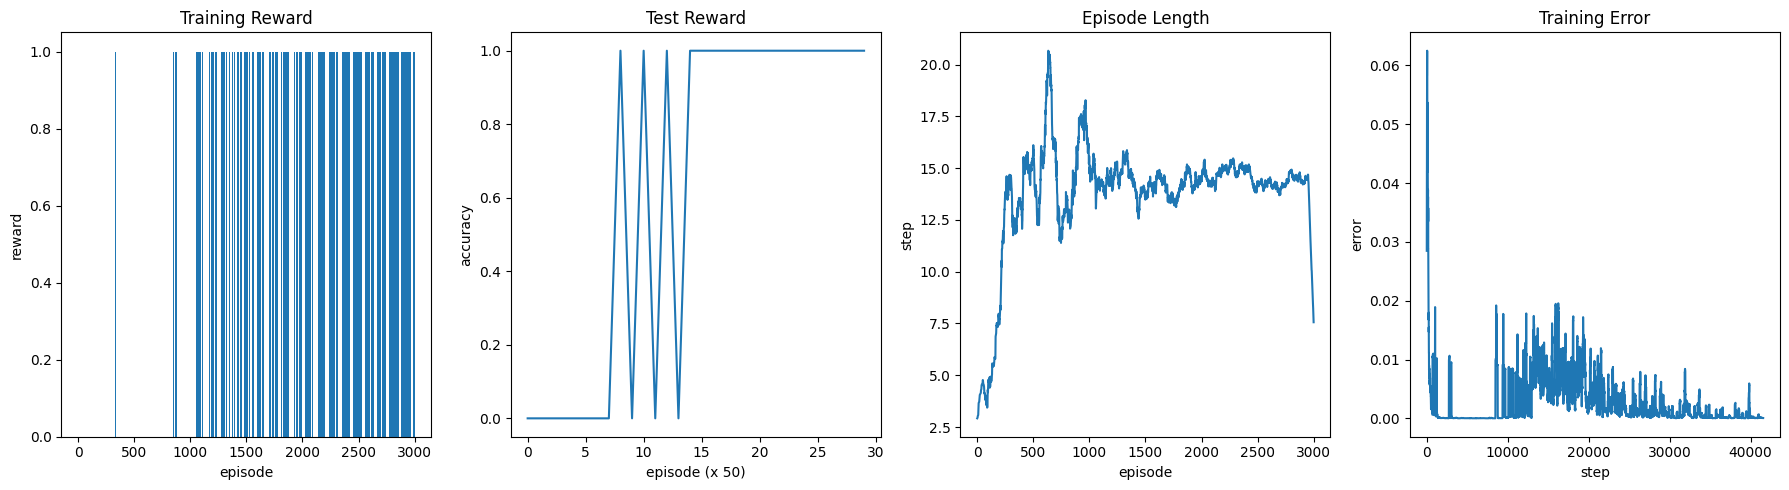

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [ ]:
'def qtable_directions_map(qtable_val_max, qtable_best_action, map_size):
    """Get the best learned action & map it to arrows."""
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [ ]:
def plot_q_values_map(qtable_val_max, qtable_best_action, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable_val_max, qtable_best_action, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

qtable_val_max = np.zeros((side_map_size, side_map_size))
qtable_best_action = np.zeros((side_map_size, side_map_size))
q_network = agent.get_Q_Network()

counter = 0
while counter < side_map_size * side_map_size:
    qtable_val_max[int(counter / side_map_size)][counter % side_map_size] = agent.max_eval_state(counter)
    qtable_best_action[int(counter / side_map_size)][counter % side_map_size] = agent.eval_state(counter)
    counter = counter + 1

plot_q_values_map(qtable_val_max, qtable_best_action, env, side_map_size)

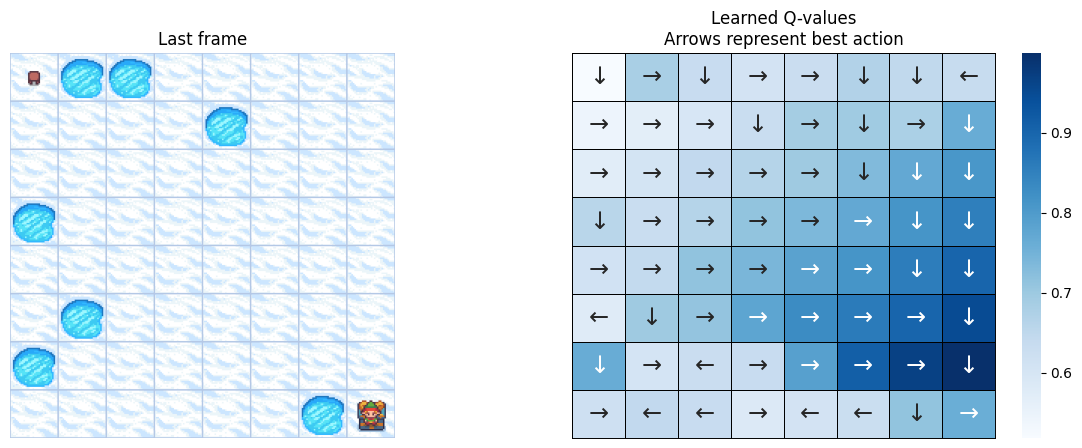

## `Cart Pole`

O Cart-Pole em controlar um carrinho que pode se mover para a esquerda ou para a direita em uma pista reta, com o objetivo de equilibrar um pêndulo invertido  conectado ao carrinho por uma articulação.

O agente precisa aprender a aplicar forças ao carrinho para manter o pêndulo em pé e evitar que ele caia, enquanto também mantém o carrinho dentro dos limites da pista. O agente deve decidir, com base no estado do sistema, quais ações tomar em cada instante para maximizar a recompensa acumulada.


In [ ]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()


In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.spec

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [ ]:
actions = ["push cart to the left", "push cart to the right"]
print ("Actions:", actions)

Actions: ['push cart to the left', 'push cart to the right']


Uma rede neural simples com uma camada com função de ativação sigmoide é criada.

In [ ]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()

        # These lines establish the feed-forward part of the neural network used to choose actions
        # Input layer with (one unit for each state variable)
        self.input_layer = nn.Linear(state_size, hidden_size)

        # Hidden layer with a number of hidden neurons
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer (one unit for each action)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    # Called with either one element to determine the action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        # Passing the state through the input layer
        x = self.input_layer(state)

        # Passing the input layer output through the hidden layer
        x = torch.relu(self.hidden_layer(x))

        # Passing the hidden layer output through the output layer
        return self.output_layer(x)

In [ ]:
class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: np.array,
        action: int,
        reward: float,
        terminated: bool,
        next_state: np.array,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)
        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [ ]:
# hyperparameters
alpha_learning_rate = 0.0003 # @param {type:"number"}
nb_max_episodes = 2000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.99 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.shape[0], hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 4 , Hidden = 64 , output = 2
Q-learning agent started


In [ ]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  5%|▌         | 103/2000 [00:02<01:22, 22.90it/s]

step: 1585, episode: 100, accuracy training: 15.85, accuracy test: 12.4, random move probability: 0.4800000000000022


 10%|█         | 210/2000 [00:06<00:45, 39.61it/s]

step: 3465, episode: 200, accuracy training: 18.8, accuracy test: 10.24, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:09<00:44, 38.00it/s]

step: 5166, episode: 300, accuracy training: 17.01, accuracy test: 16.28, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:12<01:07, 23.67it/s]

step: 7714, episode: 400, accuracy training: 25.48, accuracy test: 31.0, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [00:17<03:03,  8.14it/s]

step: 10676, episode: 500, accuracy training: 29.62, accuracy test: 48.88, random move probability: 0.400000000000011


 30%|███       | 602/2000 [00:24<03:08,  7.43it/s]

step: 14100, episode: 600, accuracy training: 34.24, accuracy test: 158.16, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:30<01:42, 12.66it/s]

step: 18518, episode: 700, accuracy training: 44.18, accuracy test: 16.7, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [00:47<01:19, 15.13it/s]

step: 25534, episode: 800, accuracy training: 70.16, accuracy test: 11.5, random move probability: 0.3400000000000176


 45%|████▌     | 902/2000 [01:03<03:18,  5.52it/s]

step: 36346, episode: 900, accuracy training: 108.12, accuracy test: 41.98, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:39<08:01,  2.08it/s]

step: 49086, episode: 1000, accuracy training: 127.4, accuracy test: 203.44, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:11<48:03,  3.20s/it]

step: 64023, episode: 1100, accuracy training: 149.37, accuracy test: 451.3, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:37<03:10,  4.19it/s]

step: 72780, episode: 1200, accuracy training: 87.57, accuracy test: 118.74, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [02:54<01:57,  5.93it/s]

step: 83789, episode: 1300, accuracy training: 110.09, accuracy test: 89.18, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [03:11<05:30,  1.81it/s]

step: 94771, episode: 1400, accuracy training: 109.82, accuracy test: 129.02, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [03:34<04:15,  1.95it/s]

step: 109764, episode: 1500, accuracy training: 149.93, accuracy test: 186.28, random move probability: 0.2000000000000261


 80%|███████▉  | 1599/2000 [04:09<01:58,  3.38it/s]

step: 132847, episode: 1600, accuracy training: 230.83, accuracy test: 500.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1703/2000 [04:52<00:51,  5.77it/s]

step: 160110, episode: 1700, accuracy training: 272.63, accuracy test: 10.52, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [05:28<04:44,  1.42s/it]

step: 183653, episode: 1800, accuracy training: 235.43, accuracy test: 500.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [06:05<00:13,  7.42it/s]

step: 207935, episode: 1900, accuracy training: 242.82, accuracy test: 9.32, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [06:40<00:00,  4.99it/s]

step: 232056, episode: 2000, accuracy training: 241.21, accuracy test: 126.48, random move probability: 0.10000000000002324



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 145 : push cart to the right , [-2.4109497  -0.8827571   0.00955821 -0.07756198] , 1.0 , True , False , {}


In [ ]:
import time

def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

df_experiments_cp = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha}, epsilon {epsilon} e gamma {gamma_discount_factor}')
            agent_sarsa = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = True
            )

            agent_q = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = False
            )

            start = time.time()
            after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            end = time.time()
            print(f'Tempo de treinamento SARSA: {end - start}')
            error = agent_sarsa.training_error
            df_experiments_cp = pd.concat([df_experiments_cp, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            start = time.time()
            after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            end = time.time()
            print(f'Tempo de treinamento Q-learning: {end - start}')
            error = agent_q.training_error
            df_experiments_cp = pd.concat([df_experiments_cp, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments_cp)}')


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Rodando alpha 0.2, epsilon 0.2 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 103/2000 [00:05<01:58, 15.95it/s]

step: 2289, episode: 100, accuracy training: 22.89, accuracy test: 9.56, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:08<00:58, 30.96it/s]

step: 4452, episode: 200, accuracy training: 21.63, accuracy test: 12.5, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:11<01:32, 18.31it/s]

step: 6891, episode: 300, accuracy training: 24.39, accuracy test: 61.38, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:14<00:52, 30.48it/s]

step: 9053, episode: 400, accuracy training: 21.62, accuracy test: 25.94, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:20<01:51, 13.45it/s]

step: 11466, episode: 500, accuracy training: 24.13, accuracy test: 135.1, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:23<00:56, 24.84it/s]

step: 13668, episode: 600, accuracy training: 22.02, accuracy test: 18.04, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:28<01:19, 16.37it/s]

step: 16179, episode: 700, accuracy training: 25.11, accuracy test: 25.88, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:32<00:59, 20.23it/s]

step: 18186, episode: 800, accuracy training: 20.07, accuracy test: 9.8, random move probability: 0.3400000000000176


 45%|████▌     | 906/2000 [00:36<00:35, 31.00it/s]

step: 20555, episode: 900, accuracy training: 23.69, accuracy test: 12.0, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [00:40<00:32, 31.09it/s]

step: 23134, episode: 1000, accuracy training: 25.79, accuracy test: 9.78, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:43<00:25, 35.22it/s]

step: 25270, episode: 1100, accuracy training: 21.36, accuracy test: 9.78, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [00:47<01:26,  9.24it/s]

step: 27050, episode: 1200, accuracy training: 17.8, accuracy test: 52.74, random move probability: 0.26000000000002643


 65%|██████▍   | 1299/2000 [00:50<00:37, 18.77it/s]

step: 29572, episode: 1300, accuracy training: 25.22, accuracy test: 25.62, random move probability: 0.24000000000002725


 70%|███████   | 1404/2000 [00:54<00:20, 29.00it/s]

step: 32293, episode: 1400, accuracy training: 27.21, accuracy test: 10.64, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [01:00<00:23, 21.08it/s]

step: 35669, episode: 1500, accuracy training: 33.76, accuracy test: 9.28, random move probability: 0.2000000000000261


 80%|████████  | 1609/2000 [01:06<00:09, 42.63it/s]

step: 38922, episode: 1600, accuracy training: 32.53, accuracy test: 9.42, random move probability: 0.18000000000002553


 85%|████████▌ | 1705/2000 [01:09<00:15, 18.82it/s]

step: 41754, episode: 1700, accuracy training: 28.32, accuracy test: 14.5, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [01:13<00:06, 30.77it/s]

step: 44163, episode: 1800, accuracy training: 24.09, accuracy test: 9.84, random move probability: 0.14000000000002438


 95%|█████████▌| 1902/2000 [01:20<00:07, 12.31it/s]

step: 47810, episode: 1900, accuracy training: 36.47, accuracy test: 11.28, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:23<00:00, 24.08it/s]
<ipython-input-107-1f786a7dc552>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_experiments_cp = pd.concat([df_experiments_cp, pd.DataFrame({'alpha': [alpha],


step: 50173, episode: 2000, accuracy training: 23.63, accuracy test: 9.92, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 83.08683276176453


  5%|▌         | 103/2000 [00:05<01:56, 16.33it/s]

step: 3396, episode: 100, accuracy training: 33.96, accuracy test: 9.42, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:12<03:56,  7.60it/s]

step: 6466, episode: 200, accuracy training: 30.7, accuracy test: 181.04, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:16<01:03, 26.85it/s]

step: 10117, episode: 300, accuracy training: 36.51, accuracy test: 10.62, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:24<01:06, 24.11it/s]

step: 14379, episode: 400, accuracy training: 42.62, accuracy test: 9.38, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:28<01:04, 23.26it/s]

step: 17505, episode: 500, accuracy training: 31.26, accuracy test: 9.48, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:32<01:05, 21.20it/s]

step: 20034, episode: 600, accuracy training: 25.29, accuracy test: 9.16, random move probability: 0.3800000000000132


 35%|███▌      | 707/2000 [00:37<01:10, 18.31it/s]

step: 22425, episode: 700, accuracy training: 23.91, accuracy test: 93.04, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [00:40<00:52, 22.72it/s]

step: 24828, episode: 800, accuracy training: 24.03, accuracy test: 12.26, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [00:45<01:07, 16.25it/s]

step: 27866, episode: 900, accuracy training: 30.38, accuracy test: 31.56, random move probability: 0.3200000000000198


 50%|█████     | 1005/2000 [00:51<00:32, 30.55it/s]

step: 31021, episode: 1000, accuracy training: 31.55, accuracy test: 9.86, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:54<00:22, 39.38it/s]

step: 33130, episode: 1100, accuracy training: 21.09, accuracy test: 13.1, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:57<00:22, 35.73it/s]

step: 35384, episode: 1200, accuracy training: 22.54, accuracy test: 13.3, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [01:03<00:32, 21.27it/s]

step: 38168, episode: 1300, accuracy training: 27.84, accuracy test: 9.46, random move probability: 0.24000000000002725


 71%|███████   | 1412/2000 [01:06<00:13, 43.73it/s]

step: 40362, episode: 1400, accuracy training: 21.94, accuracy test: 10.08, random move probability: 0.22000000000002667


 75%|███████▌  | 1509/2000 [01:09<00:12, 40.49it/s]

step: 42683, episode: 1500, accuracy training: 23.21, accuracy test: 10.52, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [01:12<00:08, 48.96it/s]

step: 44447, episode: 1600, accuracy training: 17.64, accuracy test: 9.42, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [01:18<00:09, 31.52it/s]

step: 47668, episode: 1700, accuracy training: 32.21, accuracy test: 12.76, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [01:21<00:07, 28.00it/s]

step: 49541, episode: 1800, accuracy training: 18.73, accuracy test: 10.5, random move probability: 0.14000000000002438


 95%|█████████▌| 1909/2000 [01:25<00:03, 30.31it/s]

step: 52332, episode: 1900, accuracy training: 27.91, accuracy test: 10.06, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:27<00:00, 22.82it/s]


step: 54150, episode: 2000, accuracy training: 18.18, accuracy test: 9.54, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 87.66804242134094
Len experiments 2
Rodando alpha 0.2, epsilon 0.2 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▍         | 98/2000 [00:10<01:42, 18.61it/s]

step: 6093, episode: 100, accuracy training: 60.93, accuracy test: 162.64, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:27<10:52,  2.76it/s]

step: 14151, episode: 200, accuracy training: 80.58, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:40<07:36,  3.72it/s]

step: 20557, episode: 300, accuracy training: 64.06, accuracy test: 500.0, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:48<03:22,  7.91it/s]

step: 25179, episode: 400, accuracy training: 46.22, accuracy test: 104.54, random move probability: 0.4200000000000088


 25%|██▍       | 499/2000 [00:56<03:05,  8.10it/s]

step: 31503, episode: 500, accuracy training: 63.24, accuracy test: 129.06, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:11<09:37,  2.43it/s]

step: 38658, episode: 600, accuracy training: 71.55, accuracy test: 500.0, random move probability: 0.3800000000000132


 35%|███▌      | 706/2000 [01:23<00:50, 25.69it/s]

step: 46349, episode: 700, accuracy training: 76.91, accuracy test: 10.04, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [01:34<02:01,  9.85it/s]

step: 52321, episode: 800, accuracy training: 59.72, accuracy test: 93.78, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:44<04:37,  3.96it/s]

step: 58038, episode: 900, accuracy training: 57.17, accuracy test: 142.8, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [01:58<01:45,  9.48it/s]

step: 66265, episode: 1000, accuracy training: 82.27, accuracy test: 21.46, random move probability: 0.300000000000022


 55%|█████▌    | 1107/2000 [02:03<00:36, 24.62it/s]

step: 70377, episode: 1100, accuracy training: 41.12, accuracy test: 22.46, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [02:13<00:50, 15.65it/s]

step: 76134, episode: 1200, accuracy training: 57.57, accuracy test: 10.84, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [02:21<02:16,  5.13it/s]

step: 81795, episode: 1300, accuracy training: 56.61, accuracy test: 85.52, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [02:28<00:48, 12.29it/s]

step: 85411, episode: 1400, accuracy training: 36.16, accuracy test: 92.38, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [02:44<01:47,  4.61it/s]

step: 94279, episode: 1500, accuracy training: 88.68, accuracy test: 83.64, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [02:58<00:38, 10.42it/s]

step: 103071, episode: 1600, accuracy training: 87.92, accuracy test: 21.64, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [03:12<00:41,  7.24it/s]

step: 111795, episode: 1700, accuracy training: 87.24, accuracy test: 82.1, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [03:18<00:10, 18.29it/s]

step: 116053, episode: 1800, accuracy training: 42.58, accuracy test: 81.58, random move probability: 0.14000000000002438


 95%|█████████▌| 1902/2000 [03:31<00:16,  5.94it/s]

step: 123933, episode: 1900, accuracy training: 78.8, accuracy test: 61.6, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:44<00:00,  8.92it/s]


step: 132020, episode: 2000, accuracy training: 80.87, accuracy test: 27.92, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 224.11820268630981


  5%|▌         | 100/2000 [00:05<01:33, 20.24it/s]

step: 3602, episode: 100, accuracy training: 36.02, accuracy test: 26.34, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:13<04:02,  7.42it/s]

step: 7992, episode: 200, accuracy training: 43.9, accuracy test: 97.58, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:18<01:12, 23.34it/s]

step: 11534, episode: 300, accuracy training: 35.42, accuracy test: 9.94, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:24<02:44,  9.68it/s]

step: 14698, episode: 400, accuracy training: 31.64, accuracy test: 118.58, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:31<01:58, 12.64it/s]

step: 19397, episode: 500, accuracy training: 46.99, accuracy test: 97.82, random move probability: 0.400000000000011


 30%|███       | 600/2000 [00:40<03:17,  7.09it/s]

step: 24108, episode: 600, accuracy training: 47.11, accuracy test: 158.14, random move probability: 0.3800000000000132


 35%|███▍      | 698/2000 [00:45<00:45, 28.85it/s]

step: 27963, episode: 700, accuracy training: 38.55, accuracy test: 230.42, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:56<00:52, 22.68it/s]

step: 33956, episode: 800, accuracy training: 59.93, accuracy test: 9.64, random move probability: 0.3400000000000176


 45%|████▍     | 899/2000 [01:01<01:29, 12.36it/s]

step: 37806, episode: 900, accuracy training: 38.5, accuracy test: 57.22, random move probability: 0.3200000000000198


 50%|█████     | 1009/2000 [01:10<00:41, 23.63it/s]

step: 42604, episode: 1000, accuracy training: 47.98, accuracy test: 12.16, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:18<03:59,  3.77it/s]

step: 47429, episode: 1100, accuracy training: 48.25, accuracy test: 120.02, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:33<05:12,  2.56it/s]

step: 55279, episode: 1200, accuracy training: 78.5, accuracy test: 94.66, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [01:44<00:19, 35.65it/s]

step: 62481, episode: 1300, accuracy training: 72.02, accuracy test: 10.02, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [01:55<00:54, 10.96it/s]

step: 69460, episode: 1400, accuracy training: 69.79, accuracy test: 12.36, random move probability: 0.22000000000002667


 75%|███████▍  | 1498/2000 [02:00<00:26, 18.64it/s]

step: 73438, episode: 1500, accuracy training: 39.78, accuracy test: 69.22, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [02:12<00:11, 35.38it/s]

step: 80394, episode: 1600, accuracy training: 69.56, accuracy test: 18.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [02:25<00:55,  5.41it/s]

step: 87858, episode: 1700, accuracy training: 74.64, accuracy test: 125.8, random move probability: 0.16000000000002496


 90%|█████████ | 1807/2000 [02:33<00:10, 18.77it/s]

step: 92595, episode: 1800, accuracy training: 47.37, accuracy test: 18.74, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [02:37<00:01, 49.08it/s]

step: 95461, episode: 1900, accuracy training: 28.66, accuracy test: 14.14, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:47<00:00, 11.96it/s]


step: 101581, episode: 2000, accuracy training: 61.2, accuracy test: 10.04, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 167.237943649292
Len experiments 4
Rodando alpha 0.2, epsilon 0.2 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:15<29:44,  1.06it/s]

step: 8635, episode: 100, accuracy training: 86.35, accuracy test: 466.1, random move probability: 0.4800000000000022


 10%|▉         | 199/2000 [00:34<03:03,  9.80it/s]

step: 21612, episode: 200, accuracy training: 129.77, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [01:02<08:10,  3.46it/s]

step: 37348, episode: 300, accuracy training: 157.36, accuracy test: 147.3, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:27<08:33,  3.11it/s]

step: 51340, episode: 400, accuracy training: 139.92, accuracy test: 160.64, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:50<22:46,  1.10it/s]

step: 65576, episode: 500, accuracy training: 142.36, accuracy test: 208.8, random move probability: 0.400000000000011


 30%|███       | 600/2000 [02:10<07:04,  3.30it/s]

step: 78628, episode: 600, accuracy training: 130.52, accuracy test: 162.44, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:33<10:39,  2.03it/s]

step: 92369, episode: 700, accuracy training: 137.41, accuracy test: 120.8, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:57<07:35,  2.63it/s]

step: 108678, episode: 800, accuracy training: 163.09, accuracy test: 110.44, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:24<06:30,  2.81it/s]

step: 125258, episode: 900, accuracy training: 165.8, accuracy test: 166.78, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:55<14:17,  1.17it/s]

step: 143548, episode: 1000, accuracy training: 182.9, accuracy test: 122.46, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [04:23<14:50,  1.01it/s]

step: 159990, episode: 1100, accuracy training: 164.42, accuracy test: 500.0, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:48<04:14,  3.14it/s]

step: 175667, episode: 1200, accuracy training: 156.77, accuracy test: 129.18, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [05:11<02:07,  5.49it/s]

step: 189947, episode: 1300, accuracy training: 142.8, accuracy test: 122.22, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [05:31<02:12,  4.53it/s]

step: 202503, episode: 1400, accuracy training: 125.56, accuracy test: 111.68, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:51<02:12,  3.75it/s]

step: 214558, episode: 1500, accuracy training: 120.55, accuracy test: 108.86, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [06:12<01:51,  3.58it/s]

step: 228086, episode: 1600, accuracy training: 135.28, accuracy test: 109.06, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:40<01:44,  2.87it/s]

step: 244269, episode: 1700, accuracy training: 161.83, accuracy test: 141.06, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:02<01:07,  2.97it/s]

step: 258045, episode: 1800, accuracy training: 137.76, accuracy test: 34.82, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [07:27<00:28,  3.47it/s]

step: 273856, episode: 1900, accuracy training: 158.11, accuracy test: 136.36, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:53<00:00,  4.22it/s]


step: 290216, episode: 2000, accuracy training: 163.6, accuracy test: 126.2, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 473.41039538383484


  5%|▌         | 101/2000 [00:16<16:34,  1.91it/s]

step: 8913, episode: 100, accuracy training: 89.13, accuracy test: 500.0, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:30<03:55,  7.65it/s]

step: 17350, episode: 200, accuracy training: 84.37, accuracy test: 114.18, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:44<07:23,  3.84it/s]

step: 26740, episode: 300, accuracy training: 93.9, accuracy test: 122.94, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [01:03<07:17,  3.66it/s]

step: 36334, episode: 400, accuracy training: 95.94, accuracy test: 119.96, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [01:18<03:33,  7.02it/s]

step: 45558, episode: 500, accuracy training: 92.24, accuracy test: 95.76, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:35<04:03,  5.75it/s]

step: 56676, episode: 600, accuracy training: 111.18, accuracy test: 98.8, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:50<03:46,  5.74it/s]

step: 65804, episode: 700, accuracy training: 91.28, accuracy test: 105.84, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [02:06<01:58, 10.04it/s]

step: 76534, episode: 800, accuracy training: 107.3, accuracy test: 132.62, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [02:22<03:27,  5.30it/s]

step: 86165, episode: 900, accuracy training: 96.31, accuracy test: 93.2, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [02:39<09:03,  1.84it/s]

step: 96445, episode: 1000, accuracy training: 102.8, accuracy test: 142.14, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [02:57<01:37,  9.21it/s]

step: 107129, episode: 1100, accuracy training: 106.84, accuracy test: 97.44, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [03:13<02:24,  5.53it/s]

step: 117370, episode: 1200, accuracy training: 102.41, accuracy test: 108.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [03:34<04:08,  2.81it/s]

step: 129155, episode: 1300, accuracy training: 117.85, accuracy test: 152.12, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:52<02:34,  3.89it/s]

step: 139453, episode: 1400, accuracy training: 102.98, accuracy test: 90.18, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [04:09<01:17,  6.43it/s]

step: 150000, episode: 1500, accuracy training: 105.47, accuracy test: 97.58, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [04:27<01:26,  4.63it/s]

step: 161406, episode: 1600, accuracy training: 114.06, accuracy test: 94.34, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:48<02:03,  2.43it/s]

step: 173704, episode: 1700, accuracy training: 122.98, accuracy test: 153.94, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [05:07<01:02,  3.20it/s]

step: 185403, episode: 1800, accuracy training: 116.99, accuracy test: 124.88, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [05:26<00:21,  4.63it/s]

step: 197364, episode: 1900, accuracy training: 119.61, accuracy test: 90.06, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:49<00:00,  5.72it/s]


step: 211130, episode: 2000, accuracy training: 137.66, accuracy test: 187.4, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 349.4830813407898
Len experiments 6
Rodando alpha 0.2, epsilon 0.5 e gamma 0.2
SARSA agent started
Q-learning agent started


  6%|▌         | 111/2000 [00:02<00:37, 50.20it/s]

step: 1956, episode: 100, accuracy training: 19.56, accuracy test: 9.6, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:04<00:43, 41.02it/s]

step: 3355, episode: 200, accuracy training: 13.99, accuracy test: 9.36, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:08<01:16, 22.31it/s]

step: 4683, episode: 300, accuracy training: 13.28, accuracy test: 9.48, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:12<01:15, 21.19it/s]

step: 6096, episode: 400, accuracy training: 14.13, accuracy test: 10.98, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:14<00:32, 45.83it/s]

step: 7463, episode: 500, accuracy training: 13.67, accuracy test: 9.34, random move probability: 0.400000000000011


 30%|███       | 606/2000 [00:16<00:26, 51.78it/s]

step: 8849, episode: 600, accuracy training: 13.86, accuracy test: 9.34, random move probability: 0.3800000000000132


 36%|███▌      | 711/2000 [00:18<00:27, 47.47it/s]

step: 10239, episode: 700, accuracy training: 13.9, accuracy test: 9.42, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:20<00:32, 37.21it/s]

step: 11646, episode: 800, accuracy training: 14.07, accuracy test: 9.3, random move probability: 0.3400000000000176


 45%|████▌     | 904/2000 [00:24<00:54, 20.27it/s]

step: 13047, episode: 900, accuracy training: 14.01, accuracy test: 9.18, random move probability: 0.3200000000000198


 50%|█████     | 1010/2000 [00:26<00:19, 51.83it/s]

step: 14334, episode: 1000, accuracy training: 12.87, accuracy test: 9.44, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:28<00:19, 46.20it/s]

step: 15679, episode: 1100, accuracy training: 13.45, accuracy test: 9.32, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:30<00:15, 51.55it/s]

step: 17016, episode: 1200, accuracy training: 13.37, accuracy test: 9.36, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [00:32<00:13, 49.51it/s]

step: 18365, episode: 1300, accuracy training: 13.49, accuracy test: 9.24, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:34<00:10, 56.57it/s]

step: 19520, episode: 1400, accuracy training: 11.55, accuracy test: 9.34, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:36<00:15, 32.77it/s]

step: 20792, episode: 1500, accuracy training: 12.72, accuracy test: 9.42, random move probability: 0.2000000000000261


 81%|████████  | 1612/2000 [00:39<00:07, 53.32it/s]

step: 21980, episode: 1600, accuracy training: 11.88, accuracy test: 9.2, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [00:41<00:05, 49.36it/s]

step: 23199, episode: 1700, accuracy training: 12.19, accuracy test: 9.28, random move probability: 0.16000000000002496


 91%|█████████ | 1812/2000 [00:43<00:03, 54.98it/s]

step: 24320, episode: 1800, accuracy training: 11.21, accuracy test: 9.44, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:44<00:01, 58.38it/s]

step: 25346, episode: 1900, accuracy training: 10.26, accuracy test: 9.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:45<00:00, 43.48it/s]


step: 26484, episode: 2000, accuracy training: 11.38, accuracy test: 9.28, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 46.00688600540161


  5%|▌         | 106/2000 [00:02<00:47, 40.20it/s]

step: 1679, episode: 100, accuracy training: 16.79, accuracy test: 11.28, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:05<01:16, 23.39it/s]

step: 3153, episode: 200, accuracy training: 14.74, accuracy test: 9.4, random move probability: 0.4600000000000044


 15%|█▌        | 309/2000 [00:08<00:37, 45.48it/s]

step: 4670, episode: 300, accuracy training: 15.17, accuracy test: 13.86, random move probability: 0.4400000000000066


 20%|██        | 407/2000 [00:11<00:35, 45.32it/s]

step: 6206, episode: 400, accuracy training: 15.36, accuracy test: 9.38, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:13<00:31, 47.80it/s]

step: 7748, episode: 500, accuracy training: 15.42, accuracy test: 9.42, random move probability: 0.400000000000011


 30%|███       | 602/2000 [00:15<00:39, 35.84it/s]

step: 9460, episode: 600, accuracy training: 17.12, accuracy test: 10.68, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:18<00:47, 27.43it/s]

step: 11071, episode: 700, accuracy training: 16.11, accuracy test: 9.5, random move probability: 0.3600000000000154


 40%|████      | 803/2000 [00:21<01:00, 19.64it/s]

step: 12383, episode: 800, accuracy training: 13.12, accuracy test: 14.94, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:24<00:27, 39.93it/s]

step: 14033, episode: 900, accuracy training: 16.5, accuracy test: 13.76, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [00:26<00:25, 38.52it/s]

step: 15478, episode: 1000, accuracy training: 14.45, accuracy test: 18.74, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:28<00:20, 44.60it/s]

step: 17121, episode: 1100, accuracy training: 16.43, accuracy test: 11.46, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:30<00:18, 42.97it/s]

step: 18485, episode: 1200, accuracy training: 13.64, accuracy test: 9.6, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [00:33<00:23, 28.98it/s]

step: 19843, episode: 1300, accuracy training: 13.58, accuracy test: 11.42, random move probability: 0.24000000000002725


 70%|███████   | 1406/2000 [00:36<00:16, 35.03it/s]

step: 21300, episode: 1400, accuracy training: 14.57, accuracy test: 14.24, random move probability: 0.22000000000002667


 75%|███████▌  | 1509/2000 [00:38<00:08, 56.93it/s]

step: 22629, episode: 1500, accuracy training: 13.29, accuracy test: 9.72, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [00:40<00:10, 39.06it/s]

step: 24129, episode: 1600, accuracy training: 15.0, accuracy test: 9.66, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [00:42<00:06, 45.04it/s]

step: 25438, episode: 1700, accuracy training: 13.09, accuracy test: 15.36, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [00:44<00:05, 38.20it/s]

step: 26886, episode: 1800, accuracy training: 14.48, accuracy test: 11.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:47<00:03, 30.14it/s]

step: 28248, episode: 1900, accuracy training: 13.62, accuracy test: 10.66, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:50<00:00, 39.67it/s]


step: 29518, episode: 2000, accuracy training: 12.7, accuracy test: 10.46, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 50.43069887161255
Len experiments 8
Rodando alpha 0.2, epsilon 0.5 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:02<00:48, 39.19it/s]

step: 1627, episode: 100, accuracy training: 16.27, accuracy test: 12.76, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:04<00:39, 44.92it/s]

step: 3227, episode: 200, accuracy training: 16.0, accuracy test: 11.1, random move probability: 0.4600000000000044


 15%|█▌        | 309/2000 [00:06<00:37, 45.44it/s]

step: 4645, episode: 300, accuracy training: 14.18, accuracy test: 10.66, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:08<00:35, 45.34it/s]

step: 6080, episode: 400, accuracy training: 14.35, accuracy test: 12.52, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:11<01:00, 24.82it/s]

step: 7508, episode: 500, accuracy training: 14.28, accuracy test: 12.78, random move probability: 0.400000000000011


 30%|███       | 607/2000 [00:15<00:41, 33.35it/s]

step: 9124, episode: 600, accuracy training: 16.16, accuracy test: 16.44, random move probability: 0.3800000000000132


 35%|███▌      | 707/2000 [00:17<00:31, 40.95it/s]

step: 10634, episode: 700, accuracy training: 15.1, accuracy test: 10.42, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:19<00:26, 45.18it/s]

step: 12210, episode: 800, accuracy training: 15.76, accuracy test: 9.62, random move probability: 0.3400000000000176


 45%|████▌     | 909/2000 [00:22<00:25, 43.14it/s]

step: 13764, episode: 900, accuracy training: 15.54, accuracy test: 14.04, random move probability: 0.3200000000000198


 50%|█████     | 1010/2000 [00:24<00:21, 45.84it/s]

step: 15271, episode: 1000, accuracy training: 15.07, accuracy test: 9.58, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:27<00:51, 17.52it/s]

step: 16806, episode: 1100, accuracy training: 15.35, accuracy test: 17.7, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:31<00:20, 39.37it/s]

step: 18571, episode: 1200, accuracy training: 17.65, accuracy test: 10.32, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [00:33<00:12, 55.70it/s]

step: 20360, episode: 1300, accuracy training: 17.89, accuracy test: 9.76, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:35<00:11, 51.91it/s]

step: 21668, episode: 1400, accuracy training: 13.08, accuracy test: 10.18, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [00:38<00:17, 28.13it/s]

step: 23786, episode: 1500, accuracy training: 21.18, accuracy test: 10.52, random move probability: 0.2000000000000261


 80%|████████  | 1604/2000 [00:43<00:25, 15.47it/s]

step: 26007, episode: 1600, accuracy training: 22.21, accuracy test: 29.34, random move probability: 0.18000000000002553


 85%|████████▌ | 1704/2000 [00:46<00:08, 36.01it/s]

step: 27626, episode: 1700, accuracy training: 16.19, accuracy test: 37.3, random move probability: 0.16000000000002496


 90%|█████████ | 1808/2000 [00:49<00:06, 30.83it/s]

step: 29883, episode: 1800, accuracy training: 22.57, accuracy test: 10.08, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [00:51<00:01, 54.90it/s]

step: 31109, episode: 1900, accuracy training: 12.26, accuracy test: 9.44, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:53<00:00, 37.58it/s]


step: 32493, episode: 2000, accuracy training: 13.84, accuracy test: 10.92, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 53.22586417198181


  5%|▌         | 103/2000 [00:06<02:28, 12.81it/s]

step: 2854, episode: 100, accuracy training: 28.54, accuracy test: 53.54, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:11<04:03,  7.37it/s]

step: 5716, episode: 200, accuracy training: 28.62, accuracy test: 154.34, random move probability: 0.4600000000000044


 15%|█▌        | 305/2000 [00:18<01:39, 16.97it/s]

step: 8858, episode: 300, accuracy training: 31.42, accuracy test: 9.74, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:24<01:44, 15.28it/s]

step: 12670, episode: 400, accuracy training: 38.12, accuracy test: 10.32, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:31<02:11, 11.40it/s]

step: 17299, episode: 500, accuracy training: 46.29, accuracy test: 10.2, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:37<01:00, 22.94it/s]

step: 21215, episode: 600, accuracy training: 39.16, accuracy test: 10.04, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:47<05:56,  3.65it/s]

step: 26872, episode: 700, accuracy training: 56.57, accuracy test: 126.22, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [00:54<00:48, 24.80it/s]

step: 31543, episode: 800, accuracy training: 46.71, accuracy test: 10.54, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:03<03:00,  6.10it/s]

step: 36378, episode: 900, accuracy training: 48.35, accuracy test: 129.04, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [01:09<01:03, 15.79it/s]

step: 40933, episode: 1000, accuracy training: 45.55, accuracy test: 9.64, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:17<03:31,  4.24it/s]

step: 44706, episode: 1100, accuracy training: 37.73, accuracy test: 116.42, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [01:26<00:47, 16.87it/s]

step: 51338, episode: 1200, accuracy training: 66.32, accuracy test: 9.44, random move probability: 0.26000000000002643


 65%|██████▍   | 1298/2000 [01:33<00:29, 23.70it/s]

step: 55356, episode: 1300, accuracy training: 40.18, accuracy test: 225.76, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:44<02:59,  3.34it/s]

step: 61255, episode: 1400, accuracy training: 58.99, accuracy test: 113.34, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [01:53<01:13,  6.77it/s]

step: 67017, episode: 1500, accuracy training: 57.62, accuracy test: 152.48, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [02:06<00:17, 22.81it/s]

step: 74888, episode: 1600, accuracy training: 78.71, accuracy test: 9.98, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [02:15<00:59,  5.04it/s]

step: 80263, episode: 1700, accuracy training: 53.75, accuracy test: 154.36, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:20<00:11, 16.88it/s]

step: 83778, episode: 1800, accuracy training: 35.15, accuracy test: 9.76, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [02:30<00:10,  9.80it/s]

step: 89322, episode: 1900, accuracy training: 55.44, accuracy test: 96.64, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:41<00:00, 12.42it/s]


step: 95075, episode: 2000, accuracy training: 57.53, accuracy test: 143.92, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 161.03586530685425
Len experiments 10
Rodando alpha 0.2, epsilon 0.5 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:15<20:36,  1.54it/s]

step: 6867, episode: 100, accuracy training: 68.67, accuracy test: 455.4, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:35<10:07,  2.96it/s]

step: 19614, episode: 200, accuracy training: 127.47, accuracy test: 122.56, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:57<13:01,  2.17it/s]

step: 33232, episode: 300, accuracy training: 136.18, accuracy test: 125.98, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [01:17<10:38,  2.51it/s]

step: 45751, episode: 400, accuracy training: 125.19, accuracy test: 270.86, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [01:42<06:37,  3.77it/s]

step: 61116, episode: 500, accuracy training: 153.65, accuracy test: 122.48, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:01<08:22,  2.79it/s]

step: 73464, episode: 600, accuracy training: 123.48, accuracy test: 142.74, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:21<11:31,  1.88it/s]

step: 85311, episode: 700, accuracy training: 118.47, accuracy test: 156.46, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [02:45<05:52,  3.40it/s]

step: 99278, episode: 800, accuracy training: 139.67, accuracy test: 167.82, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:07<11:49,  1.55it/s]

step: 112005, episode: 900, accuracy training: 127.27, accuracy test: 125.78, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:28<06:56,  2.40it/s]

step: 125539, episode: 1000, accuracy training: 135.34, accuracy test: 167.86, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [03:50<04:44,  3.16it/s]

step: 138405, episode: 1100, accuracy training: 128.66, accuracy test: 114.52, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:09<03:29,  3.81it/s]

step: 151125, episode: 1200, accuracy training: 127.2, accuracy test: 130.42, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:34<03:37,  3.22it/s]

step: 166049, episode: 1300, accuracy training: 149.24, accuracy test: 109.94, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [04:54<02:39,  3.75it/s]

step: 179066, episode: 1400, accuracy training: 130.17, accuracy test: 114.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:18<02:26,  3.40it/s]

step: 192248, episode: 1500, accuracy training: 131.82, accuracy test: 126.44, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:39<03:12,  2.08it/s]

step: 205359, episode: 1600, accuracy training: 131.11, accuracy test: 205.14, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [05:59<01:26,  3.45it/s]

step: 217174, episode: 1700, accuracy training: 118.15, accuracy test: 124.34, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:19<00:54,  3.65it/s]

step: 229639, episode: 1800, accuracy training: 124.65, accuracy test: 115.5, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [06:41<00:33,  2.97it/s]

step: 242738, episode: 1900, accuracy training: 130.99, accuracy test: 156.44, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:04<00:00,  4.71it/s]


step: 258091, episode: 2000, accuracy training: 153.53, accuracy test: 108.52, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 424.84662199020386


  5%|▌         | 100/2000 [00:11<07:29,  4.23it/s]

step: 7511, episode: 100, accuracy training: 75.11, accuracy test: 200.32, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<05:16,  5.69it/s]

step: 14530, episode: 200, accuracy training: 70.19, accuracy test: 117.22, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:38<03:14,  8.73it/s]

step: 22490, episode: 300, accuracy training: 79.6, accuracy test: 103.02, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:51<05:11,  5.14it/s]

step: 30159, episode: 400, accuracy training: 76.69, accuracy test: 105.88, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [01:04<04:04,  6.13it/s]

step: 38744, episode: 500, accuracy training: 85.85, accuracy test: 117.52, random move probability: 0.400000000000011


 30%|███       | 603/2000 [01:18<02:46,  8.41it/s]

step: 47299, episode: 600, accuracy training: 85.55, accuracy test: 100.92, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [01:32<02:24,  8.99it/s]

step: 55670, episode: 700, accuracy training: 83.71, accuracy test: 103.16, random move probability: 0.3600000000000154


 40%|████      | 803/2000 [01:47<03:43,  5.35it/s]

step: 64558, episode: 800, accuracy training: 88.88, accuracy test: 229.4, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [02:02<04:01,  4.55it/s]

step: 73776, episode: 900, accuracy training: 92.18, accuracy test: 109.52, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [02:16<03:59,  4.18it/s]

step: 82187, episode: 1000, accuracy training: 84.11, accuracy test: 121.3, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [02:30<03:00,  4.98it/s]

step: 90753, episode: 1100, accuracy training: 85.66, accuracy test: 104.96, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:45<03:03,  4.35it/s]

step: 100159, episode: 1200, accuracy training: 94.06, accuracy test: 155.48, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [03:00<01:34,  7.39it/s]

step: 109207, episode: 1300, accuracy training: 90.48, accuracy test: 89.94, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [03:17<04:16,  2.34it/s]

step: 118401, episode: 1400, accuracy training: 91.94, accuracy test: 105.0, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [03:32<05:17,  1.58it/s]

step: 127107, episode: 1500, accuracy training: 87.06, accuracy test: 187.44, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:48<01:22,  4.83it/s]

step: 136799, episode: 1600, accuracy training: 96.92, accuracy test: 102.06, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:05<00:40,  7.35it/s]

step: 146879, episode: 1700, accuracy training: 100.8, accuracy test: 97.0, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [04:23<01:04,  3.08it/s]

step: 158791, episode: 1800, accuracy training: 119.12, accuracy test: 99.76, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [04:40<00:51,  1.92it/s]

step: 169213, episode: 1900, accuracy training: 104.22, accuracy test: 111.86, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:58<00:00,  6.70it/s]


step: 179478, episode: 2000, accuracy training: 102.65, accuracy test: 123.74, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 298.6764314174652
Len experiments 12
Rodando alpha 0.2, epsilon 0.9 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:03<00:43, 43.76it/s]

step: 2585, episode: 100, accuracy training: 25.85, accuracy test: 9.72, random move probability: 0.4800000000000022


 10%|█         | 209/2000 [00:05<00:34, 52.07it/s]

step: 3903, episode: 200, accuracy training: 13.18, accuracy test: 9.32, random move probability: 0.4600000000000044


 16%|█▌        | 310/2000 [00:07<00:30, 54.76it/s]

step: 5211, episode: 300, accuracy training: 13.08, accuracy test: 9.34, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:10<01:20, 19.74it/s]

step: 6928, episode: 400, accuracy training: 17.17, accuracy test: 9.32, random move probability: 0.4200000000000088


 25%|██▌       | 509/2000 [00:14<00:33, 44.54it/s]

step: 8565, episode: 500, accuracy training: 16.37, accuracy test: 9.58, random move probability: 0.400000000000011


 30%|███       | 606/2000 [00:16<00:37, 36.80it/s]

step: 10463, episode: 600, accuracy training: 18.98, accuracy test: 9.3, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:18<00:30, 42.43it/s]

step: 12006, episode: 700, accuracy training: 15.43, accuracy test: 9.36, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:21<00:31, 37.48it/s]

step: 13698, episode: 800, accuracy training: 16.92, accuracy test: 12.44, random move probability: 0.3400000000000176


 45%|████▌     | 903/2000 [00:24<01:07, 16.37it/s]

step: 15325, episode: 900, accuracy training: 16.27, accuracy test: 16.58, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:29<00:38, 26.15it/s]

step: 17557, episode: 1000, accuracy training: 22.32, accuracy test: 9.48, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:32<00:29, 30.75it/s]

step: 19695, episode: 1100, accuracy training: 21.38, accuracy test: 36.0, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:35<00:23, 34.04it/s]

step: 21463, episode: 1200, accuracy training: 17.68, accuracy test: 11.88, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:37<00:21, 32.30it/s]

step: 23352, episode: 1300, accuracy training: 18.89, accuracy test: 13.76, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [00:41<00:27, 21.48it/s]

step: 24932, episode: 1400, accuracy training: 15.8, accuracy test: 10.4, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [00:45<00:26, 18.83it/s]

step: 26662, episode: 1500, accuracy training: 17.3, accuracy test: 9.8, random move probability: 0.2000000000000261


 80%|████████  | 1608/2000 [00:48<00:09, 41.01it/s]

step: 28215, episode: 1600, accuracy training: 15.53, accuracy test: 11.64, random move probability: 0.18000000000002553


 85%|████████▌ | 1708/2000 [00:50<00:05, 49.64it/s]

step: 29575, episode: 1700, accuracy training: 13.6, accuracy test: 9.4, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [00:52<00:06, 30.44it/s]

step: 30874, episode: 1800, accuracy training: 12.99, accuracy test: 11.32, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:56<00:03, 25.88it/s]

step: 32283, episode: 1900, accuracy training: 14.09, accuracy test: 13.3, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:58<00:00, 34.38it/s]


step: 33682, episode: 2000, accuracy training: 13.99, accuracy test: 9.6, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 58.18373513221741


  5%|▌         | 103/2000 [00:03<01:18, 24.02it/s]

step: 2138, episode: 100, accuracy training: 21.38, accuracy test: 24.88, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:05<00:52, 34.37it/s]

step: 4035, episode: 200, accuracy training: 18.97, accuracy test: 12.32, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:10<01:35, 17.75it/s]

step: 6390, episode: 300, accuracy training: 23.55, accuracy test: 23.22, random move probability: 0.4400000000000066


 20%|██        | 406/2000 [00:13<00:50, 31.34it/s]

step: 8235, episode: 400, accuracy training: 18.45, accuracy test: 12.04, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:17<00:55, 26.89it/s]

step: 10366, episode: 500, accuracy training: 21.31, accuracy test: 40.72, random move probability: 0.400000000000011


 30%|███       | 603/2000 [00:20<00:52, 26.82it/s]

step: 12725, episode: 600, accuracy training: 23.59, accuracy test: 13.22, random move probability: 0.3800000000000132


 35%|███▌      | 703/2000 [00:24<01:16, 17.04it/s]

step: 15233, episode: 700, accuracy training: 25.08, accuracy test: 10.62, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:28<00:31, 38.55it/s]

step: 17305, episode: 800, accuracy training: 20.72, accuracy test: 10.8, random move probability: 0.3400000000000176


 45%|████▌     | 904/2000 [00:31<00:41, 26.55it/s]

step: 19414, episode: 900, accuracy training: 21.09, accuracy test: 13.0, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:34<00:39, 25.42it/s]

step: 21347, episode: 1000, accuracy training: 19.33, accuracy test: 18.52, random move probability: 0.300000000000022


 55%|█████▌    | 1104/2000 [00:38<00:46, 19.08it/s]

step: 23677, episode: 1100, accuracy training: 23.3, accuracy test: 9.28, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [00:43<00:56, 14.20it/s]

step: 26836, episode: 1200, accuracy training: 31.59, accuracy test: 17.24, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [00:47<00:21, 32.29it/s]

step: 29094, episode: 1300, accuracy training: 22.58, accuracy test: 13.22, random move probability: 0.24000000000002725


 70%|███████   | 1404/2000 [00:51<00:40, 14.89it/s]

step: 31937, episode: 1400, accuracy training: 28.43, accuracy test: 9.22, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:56<00:19, 24.99it/s]

step: 34289, episode: 1500, accuracy training: 23.52, accuracy test: 9.34, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [01:00<00:19, 20.34it/s]

step: 36642, episode: 1600, accuracy training: 23.53, accuracy test: 48.96, random move probability: 0.18000000000002553


 85%|████████▌ | 1705/2000 [01:06<00:13, 21.14it/s]

step: 40635, episode: 1700, accuracy training: 39.93, accuracy test: 9.2, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [01:10<00:06, 29.67it/s]

step: 42533, episode: 1800, accuracy training: 18.98, accuracy test: 11.72, random move probability: 0.14000000000002438


 96%|█████████▌| 1911/2000 [01:12<00:01, 46.69it/s]

step: 44166, episode: 1900, accuracy training: 16.33, accuracy test: 18.52, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:14<00:00, 26.84it/s]


step: 45464, episode: 2000, accuracy training: 12.98, accuracy test: 12.26, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 74.53459000587463
Len experiments 14
Rodando alpha 0.2, epsilon 0.9 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 104/2000 [00:02<01:04, 29.62it/s]

step: 1610, episode: 100, accuracy training: 16.1, accuracy test: 21.98, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:10<02:30, 11.94it/s]

step: 5332, episode: 200, accuracy training: 37.22, accuracy test: 94.46, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:17<01:16, 22.13it/s]

step: 10334, episode: 300, accuracy training: 50.02, accuracy test: 9.92, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:24<01:55, 13.88it/s]

step: 14461, episode: 400, accuracy training: 41.27, accuracy test: 36.38, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:31<02:15, 11.07it/s]

step: 19139, episode: 500, accuracy training: 46.78, accuracy test: 69.9, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:40<00:55, 24.92it/s]

step: 24128, episode: 600, accuracy training: 49.89, accuracy test: 21.82, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:47<01:51, 11.66it/s]

step: 29100, episode: 700, accuracy training: 49.72, accuracy test: 108.56, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [00:57<03:49,  5.22it/s]

step: 34082, episode: 800, accuracy training: 49.82, accuracy test: 276.04, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:08<03:13,  5.68it/s]

step: 40095, episode: 900, accuracy training: 60.13, accuracy test: 10.56, random move probability: 0.3200000000000198


 50%|████▉     | 999/2000 [01:15<01:14, 13.41it/s]

step: 45162, episode: 1000, accuracy training: 50.67, accuracy test: 136.56, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [01:26<01:59,  7.51it/s]

step: 50989, episode: 1100, accuracy training: 58.27, accuracy test: 124.24, random move probability: 0.28000000000002423


 60%|█████▉    | 1199/2000 [01:35<00:47, 16.70it/s]

step: 56328, episode: 1200, accuracy training: 53.39, accuracy test: 9.9, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [01:46<00:39, 17.53it/s]

step: 63187, episode: 1300, accuracy training: 68.59, accuracy test: 9.64, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [01:54<00:45, 13.07it/s]

step: 68744, episode: 1400, accuracy training: 55.57, accuracy test: 10.02, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [02:06<00:23, 21.22it/s]

step: 75855, episode: 1500, accuracy training: 71.11, accuracy test: 9.8, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [02:17<00:28, 13.78it/s]

step: 82510, episode: 1600, accuracy training: 66.55, accuracy test: 9.84, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [02:29<01:34,  3.16it/s]

step: 90122, episode: 1700, accuracy training: 76.12, accuracy test: 86.74, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:40<00:31,  6.25it/s]

step: 97415, episode: 1800, accuracy training: 72.93, accuracy test: 112.78, random move probability: 0.14000000000002438


 95%|█████████▍| 1896/2000 [02:48<00:02, 35.02it/s]

step: 102277, episode: 1900, accuracy training: 48.62, accuracy test: 238.78, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:04<00:00, 10.84it/s]


step: 111139, episode: 2000, accuracy training: 88.62, accuracy test: 101.06, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 184.59161567687988


  5%|▌         | 100/2000 [00:06<03:25,  9.25it/s]

step: 4270, episode: 100, accuracy training: 42.7, accuracy test: 10.02, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:13<01:48, 16.51it/s]

step: 8515, episode: 200, accuracy training: 42.45, accuracy test: 23.66, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:23<03:12,  8.84it/s]

step: 14085, episode: 300, accuracy training: 55.7, accuracy test: 34.32, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:29<02:23, 11.11it/s]

step: 18667, episode: 400, accuracy training: 45.82, accuracy test: 52.46, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:41<06:22,  3.92it/s]

step: 24511, episode: 500, accuracy training: 58.44, accuracy test: 119.1, random move probability: 0.400000000000011


 30%|███       | 602/2000 [00:50<03:15,  7.13it/s]

step: 29805, episode: 600, accuracy training: 52.94, accuracy test: 9.66, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:59<04:43,  4.57it/s]

step: 34942, episode: 700, accuracy training: 51.37, accuracy test: 258.96, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:10<02:31,  7.90it/s]

step: 42096, episode: 800, accuracy training: 71.54, accuracy test: 67.3, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:20<01:42, 10.74it/s]

step: 47813, episode: 900, accuracy training: 57.17, accuracy test: 120.26, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:32<03:52,  4.30it/s]

step: 54390, episode: 1000, accuracy training: 65.77, accuracy test: 112.7, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:41<02:39,  5.66it/s]

step: 60951, episode: 1100, accuracy training: 65.61, accuracy test: 45.6, random move probability: 0.28000000000002423


 60%|█████▉    | 1199/2000 [01:55<01:03, 12.55it/s]

step: 69436, episode: 1200, accuracy training: 84.85, accuracy test: 116.02, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [02:07<00:26, 26.36it/s]

step: 76248, episode: 1300, accuracy training: 68.12, accuracy test: 10.26, random move probability: 0.24000000000002725


 70%|██████▉   | 1399/2000 [02:16<01:05,  9.24it/s]

step: 81525, episode: 1400, accuracy training: 52.77, accuracy test: 55.2, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [02:25<00:57,  8.71it/s]

step: 87899, episode: 1500, accuracy training: 63.74, accuracy test: 31.44, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [02:35<00:37, 10.56it/s]

step: 93263, episode: 1600, accuracy training: 53.64, accuracy test: 95.64, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [02:46<00:24, 12.33it/s]

step: 99739, episode: 1700, accuracy training: 64.76, accuracy test: 15.62, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:56<00:20,  9.59it/s]

step: 106183, episode: 1800, accuracy training: 64.44, accuracy test: 18.46, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [03:05<00:04, 20.72it/s]

step: 111993, episode: 1900, accuracy training: 58.1, accuracy test: 12.82, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:21<00:00,  9.92it/s]


step: 120852, episode: 2000, accuracy training: 88.59, accuracy test: 10.26, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 201.69870948791504
Len experiments 16
Rodando alpha 0.2, epsilon 0.9 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:11<11:05,  2.86it/s]

step: 6839, episode: 100, accuracy training: 68.39, accuracy test: 165.26, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:28<09:12,  3.26it/s]

step: 17685, episode: 200, accuracy training: 108.46, accuracy test: 119.48, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:48<14:19,  1.98it/s]

step: 28600, episode: 300, accuracy training: 109.15, accuracy test: 157.76, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [01:08<07:04,  3.77it/s]

step: 41784, episode: 400, accuracy training: 131.84, accuracy test: 125.26, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:30<12:02,  2.08it/s]

step: 55280, episode: 500, accuracy training: 134.96, accuracy test: 207.76, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:53<12:20,  1.89it/s]

step: 69619, episode: 600, accuracy training: 143.39, accuracy test: 407.6, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [02:15<07:01,  3.09it/s]

step: 82718, episode: 700, accuracy training: 130.99, accuracy test: 121.44, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [02:41<08:51,  2.26it/s]

step: 97371, episode: 800, accuracy training: 146.53, accuracy test: 134.02, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:01<04:48,  3.81it/s]

step: 109978, episode: 900, accuracy training: 126.07, accuracy test: 105.44, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:24<08:12,  2.03it/s]

step: 123971, episode: 1000, accuracy training: 139.93, accuracy test: 140.64, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [03:45<02:55,  5.10it/s]

step: 137294, episode: 1100, accuracy training: 133.23, accuracy test: 109.82, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:08<03:35,  3.71it/s]

step: 150718, episode: 1200, accuracy training: 134.24, accuracy test: 116.12, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [04:31<05:59,  1.95it/s]

step: 165743, episode: 1300, accuracy training: 150.25, accuracy test: 108.08, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [04:52<03:19,  3.00it/s]

step: 178344, episode: 1400, accuracy training: 126.01, accuracy test: 132.58, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [05:20<03:32,  2.35it/s]

step: 194577, episode: 1500, accuracy training: 162.33, accuracy test: 126.62, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:44<09:40,  1.45s/it]

step: 207826, episode: 1600, accuracy training: 132.49, accuracy test: 500.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:09<02:00,  2.49it/s]

step: 223791, episode: 1700, accuracy training: 159.65, accuracy test: 101.38, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:33<01:02,  3.20it/s]

step: 238379, episode: 1800, accuracy training: 145.88, accuracy test: 133.92, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [06:59<00:33,  2.98it/s]

step: 253993, episode: 1900, accuracy training: 156.14, accuracy test: 210.28, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:27<00:00,  4.47it/s]


step: 270849, episode: 2000, accuracy training: 168.56, accuracy test: 239.5, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 447.22505164146423


  5%|▌         | 101/2000 [00:11<07:33,  4.19it/s]

step: 6355, episode: 100, accuracy training: 63.55, accuracy test: 114.94, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:23<15:08,  1.98it/s]

step: 13828, episode: 200, accuracy training: 74.73, accuracy test: 120.68, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:35<04:37,  6.12it/s]

step: 20386, episode: 300, accuracy training: 65.58, accuracy test: 114.74, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:47<04:07,  6.46it/s]

step: 27025, episode: 400, accuracy training: 66.39, accuracy test: 117.22, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:56<04:01,  6.20it/s]

step: 32501, episode: 500, accuracy training: 54.76, accuracy test: 104.08, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:07<06:06,  3.82it/s]

step: 39454, episode: 600, accuracy training: 69.53, accuracy test: 111.34, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:21<05:32,  3.90it/s]

step: 48211, episode: 700, accuracy training: 87.57, accuracy test: 158.22, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [01:33<01:50, 10.84it/s]

step: 55181, episode: 800, accuracy training: 69.7, accuracy test: 106.92, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:46<04:46,  3.84it/s]

step: 63376, episode: 900, accuracy training: 81.95, accuracy test: 106.42, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [02:00<03:36,  4.62it/s]

step: 71345, episode: 1000, accuracy training: 79.69, accuracy test: 104.5, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [02:14<02:07,  7.03it/s]

step: 80254, episode: 1100, accuracy training: 89.09, accuracy test: 114.22, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:27<01:55,  6.93it/s]

step: 88154, episode: 1200, accuracy training: 79.0, accuracy test: 104.56, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [02:42<02:09,  5.40it/s]

step: 97623, episode: 1300, accuracy training: 94.69, accuracy test: 107.1, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [02:59<03:15,  3.06it/s]

step: 107613, episode: 1400, accuracy training: 99.9, accuracy test: 116.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:21<02:49,  2.95it/s]

step: 119110, episode: 1500, accuracy training: 114.97, accuracy test: 97.6, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [03:37<01:03,  6.23it/s]

step: 128816, episode: 1600, accuracy training: 97.06, accuracy test: 93.66, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [03:53<01:06,  4.51it/s]

step: 138885, episode: 1700, accuracy training: 100.69, accuracy test: 119.92, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [04:08<00:27,  7.36it/s]

step: 148528, episode: 1800, accuracy training: 96.43, accuracy test: 99.9, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:24<00:22,  4.41it/s]

step: 158259, episode: 1900, accuracy training: 97.31, accuracy test: 98.26, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:52<00:00,  6.84it/s]


step: 174211, episode: 2000, accuracy training: 159.52, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 292.22802329063416
Len experiments 18
Rodando alpha 0.5, epsilon 0.2 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 106/2000 [00:02<00:36, 52.38it/s]

step: 1688, episode: 100, accuracy training: 16.88, accuracy test: 9.28, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:05<01:09, 25.82it/s]

step: 3132, episode: 200, accuracy training: 14.44, accuracy test: 9.38, random move probability: 0.4600000000000044


 16%|█▌        | 310/2000 [00:08<00:33, 50.81it/s]

step: 4406, episode: 300, accuracy training: 12.74, accuracy test: 9.82, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:10<00:36, 43.85it/s]

step: 5674, episode: 400, accuracy training: 12.68, accuracy test: 9.24, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:12<00:32, 45.75it/s]

step: 7243, episode: 500, accuracy training: 15.69, accuracy test: 10.28, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:15<00:52, 26.54it/s]

step: 9154, episode: 600, accuracy training: 19.11, accuracy test: 19.78, random move probability: 0.3800000000000132


 35%|███▌      | 703/2000 [00:17<00:44, 29.17it/s]

step: 10983, episode: 700, accuracy training: 18.29, accuracy test: 18.76, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [00:22<00:49, 24.31it/s]

step: 12626, episode: 800, accuracy training: 16.43, accuracy test: 9.46, random move probability: 0.3400000000000176


 46%|████▌     | 912/2000 [00:24<00:19, 55.32it/s]

step: 13903, episode: 900, accuracy training: 12.77, accuracy test: 12.42, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:26<00:28, 34.42it/s]

step: 15434, episode: 1000, accuracy training: 15.31, accuracy test: 16.62, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:28<00:30, 29.29it/s]

step: 17200, episode: 1100, accuracy training: 17.66, accuracy test: 24.7, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [00:31<00:18, 44.17it/s]

step: 19133, episode: 1200, accuracy training: 19.33, accuracy test: 9.54, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [00:36<00:42, 16.40it/s]

step: 21162, episode: 1300, accuracy training: 20.29, accuracy test: 12.42, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [00:38<00:14, 41.49it/s]

step: 22954, episode: 1400, accuracy training: 17.92, accuracy test: 9.96, random move probability: 0.22000000000002667


 75%|███████▌  | 1506/2000 [00:41<00:11, 42.99it/s]

step: 24703, episode: 1500, accuracy training: 17.49, accuracy test: 13.84, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [00:44<00:12, 32.80it/s]

step: 26653, episode: 1600, accuracy training: 19.5, accuracy test: 22.68, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [00:47<00:16, 17.56it/s]

step: 28273, episode: 1700, accuracy training: 16.2, accuracy test: 16.48, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [00:51<00:10, 18.03it/s]

step: 29680, episode: 1800, accuracy training: 14.07, accuracy test: 14.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [00:54<00:01, 48.11it/s]

step: 31004, episode: 1900, accuracy training: 13.24, accuracy test: 9.56, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:57<00:00, 35.05it/s]


step: 32670, episode: 2000, accuracy training: 16.66, accuracy test: 16.24, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 57.06656265258789


  5%|▌         | 106/2000 [00:03<01:02, 30.16it/s]

step: 2144, episode: 100, accuracy training: 21.44, accuracy test: 9.48, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:06<01:24, 21.21it/s]

step: 4585, episode: 200, accuracy training: 24.41, accuracy test: 45.78, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:11<00:52, 31.96it/s]

step: 6498, episode: 300, accuracy training: 19.13, accuracy test: 10.76, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:14<00:44, 35.56it/s]

step: 8662, episode: 400, accuracy training: 21.64, accuracy test: 9.18, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:17<01:27, 17.04it/s]

step: 10741, episode: 500, accuracy training: 20.79, accuracy test: 74.44, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:21<00:57, 24.12it/s]

step: 13060, episode: 600, accuracy training: 23.19, accuracy test: 34.68, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:26<01:05, 19.68it/s]

step: 15232, episode: 700, accuracy training: 21.72, accuracy test: 38.14, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [00:28<00:33, 35.43it/s]

step: 16979, episode: 800, accuracy training: 17.47, accuracy test: 9.32, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [00:31<00:36, 30.38it/s]

step: 18943, episode: 900, accuracy training: 19.64, accuracy test: 16.88, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:34<00:32, 30.75it/s]

step: 20734, episode: 1000, accuracy training: 17.91, accuracy test: 28.86, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [00:38<00:59, 15.18it/s]

step: 22680, episode: 1100, accuracy training: 19.46, accuracy test: 14.84, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [00:41<00:34, 23.12it/s]

step: 24710, episode: 1200, accuracy training: 20.3, accuracy test: 35.48, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [00:44<00:15, 43.47it/s]

step: 26681, episode: 1300, accuracy training: 19.71, accuracy test: 9.26, random move probability: 0.24000000000002725


 70%|███████   | 1408/2000 [00:47<00:12, 45.72it/s]

step: 28319, episode: 1400, accuracy training: 16.38, accuracy test: 9.92, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [00:50<00:22, 21.78it/s]

step: 30119, episode: 1500, accuracy training: 18.0, accuracy test: 12.16, random move probability: 0.2000000000000261


 80%|████████  | 1609/2000 [00:54<00:09, 41.89it/s]

step: 31771, episode: 1600, accuracy training: 16.52, accuracy test: 12.42, random move probability: 0.18000000000002553


 85%|████████▌ | 1708/2000 [00:56<00:07, 40.51it/s]

step: 33361, episode: 1700, accuracy training: 15.9, accuracy test: 13.96, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [00:58<00:04, 43.25it/s]

step: 34772, episode: 1800, accuracy training: 14.11, accuracy test: 12.9, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [01:00<00:02, 39.74it/s]

step: 36307, episode: 1900, accuracy training: 15.35, accuracy test: 10.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:02<00:00, 31.91it/s]


step: 37687, episode: 2000, accuracy training: 13.8, accuracy test: 17.54, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 62.68342566490173
Len experiments 20
Rodando alpha 0.5, epsilon 0.2 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:05<01:47, 17.70it/s]

step: 2241, episode: 100, accuracy training: 22.41, accuracy test: 14.0, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:08<01:30, 19.89it/s]

step: 4373, episode: 200, accuracy training: 21.32, accuracy test: 10.12, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:12<01:21, 20.73it/s]

step: 6823, episode: 300, accuracy training: 24.5, accuracy test: 34.9, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:20<01:31, 17.47it/s]

step: 11740, episode: 400, accuracy training: 49.17, accuracy test: 10.1, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [00:27<02:15, 11.05it/s]

step: 16381, episode: 500, accuracy training: 46.41, accuracy test: 63.54, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:36<01:37, 14.24it/s]

step: 21485, episode: 600, accuracy training: 51.04, accuracy test: 68.66, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:40<01:02, 20.77it/s]

step: 24199, episode: 700, accuracy training: 27.14, accuracy test: 24.34, random move probability: 0.3600000000000154


 40%|███▉      | 798/2000 [00:46<01:44, 11.52it/s]

step: 28127, episode: 800, accuracy training: 39.28, accuracy test: 9.82, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [00:53<00:47, 22.99it/s]

step: 32483, episode: 900, accuracy training: 43.56, accuracy test: 27.44, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [01:04<01:34, 10.56it/s]

step: 38745, episode: 1000, accuracy training: 62.62, accuracy test: 9.82, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:09<00:50, 17.67it/s]

step: 42610, episode: 1100, accuracy training: 38.65, accuracy test: 12.6, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:19<01:08, 11.65it/s]

step: 48077, episode: 1200, accuracy training: 54.67, accuracy test: 91.56, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [01:25<00:33, 20.84it/s]

step: 52860, episode: 1300, accuracy training: 47.83, accuracy test: 9.84, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [01:36<00:47, 12.66it/s]

step: 57193, episode: 1400, accuracy training: 43.33, accuracy test: 119.76, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [01:49<03:08,  2.66it/s]

step: 64905, episode: 1500, accuracy training: 77.12, accuracy test: 139.5, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [01:55<00:25, 15.78it/s]

step: 68924, episode: 1600, accuracy training: 40.19, accuracy test: 11.78, random move probability: 0.18000000000002553


 85%|████████▌ | 1709/2000 [02:07<00:07, 37.92it/s]

step: 76226, episode: 1700, accuracy training: 73.02, accuracy test: 9.84, random move probability: 0.16000000000002496


 90%|█████████ | 1809/2000 [02:11<00:04, 44.71it/s]

step: 79042, episode: 1800, accuracy training: 28.16, accuracy test: 20.62, random move probability: 0.14000000000002438


 95%|█████████▌| 1905/2000 [02:15<00:03, 24.89it/s]

step: 81682, episode: 1900, accuracy training: 26.4, accuracy test: 9.92, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:18<00:00, 14.39it/s]


step: 83303, episode: 2000, accuracy training: 16.21, accuracy test: 9.38, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 139.00326800346375


  5%|▌         | 105/2000 [00:06<01:13, 25.92it/s]

step: 4395, episode: 100, accuracy training: 43.95, accuracy test: 9.58, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:14<02:42, 11.07it/s]

step: 8412, episode: 200, accuracy training: 40.17, accuracy test: 130.46, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:21<03:05,  9.15it/s]

step: 13158, episode: 300, accuracy training: 47.46, accuracy test: 120.76, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:28<02:15, 11.85it/s]

step: 16832, episode: 400, accuracy training: 36.74, accuracy test: 93.7, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:35<01:30, 16.50it/s]

step: 21370, episode: 500, accuracy training: 45.38, accuracy test: 122.34, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:42<01:00, 23.11it/s]

step: 25065, episode: 600, accuracy training: 36.95, accuracy test: 22.62, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:50<02:34,  8.43it/s]

step: 30898, episode: 700, accuracy training: 58.33, accuracy test: 34.6, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:01<02:32,  7.85it/s]

step: 36919, episode: 800, accuracy training: 60.21, accuracy test: 96.32, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:10<01:40, 10.90it/s]

step: 42074, episode: 900, accuracy training: 51.55, accuracy test: 18.94, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:16<01:35, 10.47it/s]

step: 46363, episode: 1000, accuracy training: 42.89, accuracy test: 46.2, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:24<01:34,  9.55it/s]

step: 50996, episode: 1100, accuracy training: 46.33, accuracy test: 9.66, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [01:33<01:21,  9.73it/s]

step: 56970, episode: 1200, accuracy training: 59.74, accuracy test: 96.26, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [01:42<00:53, 13.11it/s]

step: 62401, episode: 1300, accuracy training: 54.31, accuracy test: 10.24, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [01:53<01:43,  5.81it/s]

step: 68198, episode: 1400, accuracy training: 57.97, accuracy test: 9.64, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [02:01<00:39, 12.53it/s]

step: 73441, episode: 1500, accuracy training: 52.43, accuracy test: 11.08, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:09<00:32, 12.49it/s]

step: 78037, episode: 1600, accuracy training: 45.96, accuracy test: 10.42, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [02:18<00:29, 10.03it/s]

step: 84372, episode: 1700, accuracy training: 63.35, accuracy test: 9.74, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:31<00:11, 16.81it/s]

step: 91982, episode: 1800, accuracy training: 76.1, accuracy test: 10.48, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [02:43<00:03, 30.40it/s]

step: 99478, episode: 1900, accuracy training: 74.96, accuracy test: 10.1, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:54<00:00, 11.45it/s]


step: 106288, episode: 2000, accuracy training: 68.1, accuracy test: 10.26, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 174.66179203987122
Len experiments 22
Rodando alpha 0.5, epsilon 0.2 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:12<21:54,  1.45it/s]

step: 6279, episode: 100, accuracy training: 62.79, accuracy test: 356.76, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:30<06:56,  4.33it/s]

step: 18228, episode: 200, accuracy training: 119.49, accuracy test: 158.1, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:53<12:24,  2.28it/s]

step: 31530, episode: 300, accuracy training: 133.02, accuracy test: 200.6, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:15<08:56,  2.98it/s]

step: 46037, episode: 400, accuracy training: 145.07, accuracy test: 208.32, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:40<22:29,  1.11it/s]

step: 59818, episode: 500, accuracy training: 137.81, accuracy test: 180.54, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:05<07:29,  3.11it/s]

step: 74940, episode: 600, accuracy training: 151.22, accuracy test: 150.96, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:26<05:21,  4.04it/s]

step: 88987, episode: 700, accuracy training: 140.47, accuracy test: 114.22, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:47<08:05,  2.47it/s]

step: 101864, episode: 800, accuracy training: 128.77, accuracy test: 125.36, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:09<05:36,  3.26it/s]

step: 115839, episode: 900, accuracy training: 139.75, accuracy test: 119.68, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [03:31<03:52,  4.29it/s]

step: 128689, episode: 1000, accuracy training: 128.5, accuracy test: 106.34, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [03:50<04:13,  3.55it/s]

step: 141281, episode: 1100, accuracy training: 125.92, accuracy test: 129.4, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [04:11<09:25,  1.41it/s]

step: 153392, episode: 1200, accuracy training: 121.11, accuracy test: 102.28, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:35<04:20,  2.68it/s]

step: 166642, episode: 1300, accuracy training: 132.5, accuracy test: 202.16, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [04:57<03:19,  3.01it/s]

step: 179767, episode: 1400, accuracy training: 131.25, accuracy test: 122.84, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:20<02:06,  3.94it/s]

step: 194073, episode: 1500, accuracy training: 143.06, accuracy test: 120.62, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [05:43<01:55,  3.44it/s]

step: 208155, episode: 1600, accuracy training: 140.82, accuracy test: 116.4, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:05<02:32,  1.96it/s]

step: 221570, episode: 1700, accuracy training: 134.15, accuracy test: 137.94, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [06:30<02:03,  1.62it/s]

step: 236323, episode: 1800, accuracy training: 147.53, accuracy test: 350.52, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [06:54<00:27,  3.54it/s]

step: 250315, episode: 1900, accuracy training: 139.92, accuracy test: 119.34, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:18<00:00,  4.57it/s]


step: 264367, episode: 2000, accuracy training: 140.52, accuracy test: 148.36, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 438.096795797348


  5%|▌         | 101/2000 [00:11<06:21,  4.98it/s]

step: 6627, episode: 100, accuracy training: 66.27, accuracy test: 140.88, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:24<04:52,  6.14it/s]

step: 14261, episode: 200, accuracy training: 76.34, accuracy test: 108.42, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:35<07:20,  3.86it/s]

step: 20968, episode: 300, accuracy training: 67.07, accuracy test: 239.0, random move probability: 0.4400000000000066


 20%|█▉        | 399/2000 [00:49<02:07, 12.52it/s]

step: 29689, episode: 400, accuracy training: 87.21, accuracy test: 143.2, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:01<04:20,  5.76it/s]

step: 36729, episode: 500, accuracy training: 70.4, accuracy test: 98.04, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:15<04:43,  4.93it/s]

step: 45367, episode: 600, accuracy training: 86.38, accuracy test: 114.12, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [01:27<08:44,  2.48it/s]

step: 52708, episode: 700, accuracy training: 73.41, accuracy test: 108.02, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:43<07:49,  2.55it/s]

step: 62448, episode: 800, accuracy training: 97.4, accuracy test: 192.56, random move probability: 0.3400000000000176


 45%|████▌     | 903/2000 [01:57<03:30,  5.22it/s]

step: 70740, episode: 900, accuracy training: 82.92, accuracy test: 100.42, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [02:11<05:55,  2.81it/s]

step: 79527, episode: 1000, accuracy training: 87.87, accuracy test: 126.34, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:24<07:41,  1.95it/s]

step: 87317, episode: 1100, accuracy training: 77.9, accuracy test: 108.98, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [02:40<01:56,  6.83it/s]

step: 95752, episode: 1200, accuracy training: 84.35, accuracy test: 101.88, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [02:54<01:45,  6.59it/s]

step: 104620, episode: 1300, accuracy training: 88.68, accuracy test: 96.96, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:12<02:37,  3.81it/s]

step: 116211, episode: 1400, accuracy training: 115.91, accuracy test: 122.32, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:30<02:40,  3.11it/s]

step: 127179, episode: 1500, accuracy training: 109.68, accuracy test: 118.5, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [03:57<01:23,  4.77it/s]

step: 144155, episode: 1600, accuracy training: 169.76, accuracy test: 95.5, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:13<01:11,  4.19it/s]

step: 154122, episode: 1700, accuracy training: 99.67, accuracy test: 98.08, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [04:34<01:18,  2.52it/s]

step: 166148, episode: 1800, accuracy training: 120.26, accuracy test: 111.5, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [04:56<00:27,  3.65it/s]

step: 180598, episode: 1900, accuracy training: 144.5, accuracy test: 123.54, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:21<00:00,  6.22it/s]


step: 194701, episode: 2000, accuracy training: 141.03, accuracy test: 95.24, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 321.56353735923767
Len experiments 24
Rodando alpha 0.5, epsilon 0.5 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 107/2000 [00:03<00:42, 44.83it/s]

step: 2283, episode: 100, accuracy training: 22.83, accuracy test: 9.82, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:06<01:08, 26.22it/s]

step: 3643, episode: 200, accuracy training: 13.6, accuracy test: 9.26, random move probability: 0.4600000000000044


 15%|█▌        | 308/2000 [00:08<00:31, 53.05it/s]

step: 4814, episode: 300, accuracy training: 11.71, accuracy test: 9.26, random move probability: 0.4400000000000066


 20%|██        | 409/2000 [00:10<00:29, 53.47it/s]

step: 6023, episode: 400, accuracy training: 12.09, accuracy test: 10.0, random move probability: 0.4200000000000088


 25%|██▌       | 509/2000 [00:12<00:27, 53.66it/s]

step: 7215, episode: 500, accuracy training: 11.92, accuracy test: 9.5, random move probability: 0.400000000000011


 30%|███       | 609/2000 [00:14<00:27, 50.15it/s]

step: 8478, episode: 600, accuracy training: 12.63, accuracy test: 10.16, random move probability: 0.3800000000000132


 35%|███▌      | 707/2000 [00:16<00:40, 31.83it/s]

step: 10012, episode: 700, accuracy training: 15.34, accuracy test: 9.5, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:20<00:59, 20.06it/s]

step: 12117, episode: 800, accuracy training: 21.05, accuracy test: 9.36, random move probability: 0.3400000000000176


 45%|████▌     | 903/2000 [00:25<01:24, 13.01it/s]

step: 14976, episode: 900, accuracy training: 28.59, accuracy test: 59.68, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [00:28<00:34, 28.92it/s]

step: 16898, episode: 1000, accuracy training: 19.22, accuracy test: 10.1, random move probability: 0.300000000000022


 55%|█████▌    | 1107/2000 [00:31<00:28, 31.67it/s]

step: 18949, episode: 1100, accuracy training: 20.51, accuracy test: 17.98, random move probability: 0.28000000000002423


 60%|██████    | 1203/2000 [00:35<00:53, 14.95it/s]

step: 20678, episode: 1200, accuracy training: 17.29, accuracy test: 23.34, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [00:38<00:21, 32.35it/s]

step: 22856, episode: 1300, accuracy training: 21.78, accuracy test: 17.18, random move probability: 0.24000000000002725


 70%|███████   | 1404/2000 [00:41<00:23, 25.78it/s]

step: 24646, episode: 1400, accuracy training: 17.9, accuracy test: 40.64, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [00:44<00:16, 29.42it/s]

step: 26497, episode: 1500, accuracy training: 18.51, accuracy test: 20.58, random move probability: 0.2000000000000261


 80%|████████  | 1604/2000 [00:46<00:11, 34.89it/s]

step: 27926, episode: 1600, accuracy training: 14.29, accuracy test: 9.76, random move probability: 0.18000000000002553


 85%|████████▌ | 1704/2000 [00:50<00:10, 26.99it/s]

step: 29134, episode: 1700, accuracy training: 12.08, accuracy test: 9.44, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [00:52<00:04, 48.39it/s]

step: 30378, episode: 1800, accuracy training: 12.44, accuracy test: 12.7, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [00:55<00:01, 54.13it/s]

step: 32161, episode: 1900, accuracy training: 17.83, accuracy test: 9.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:56<00:00, 35.36it/s]


step: 33193, episode: 2000, accuracy training: 10.32, accuracy test: 9.44, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 56.57119417190552


  5%|▌         | 108/2000 [00:02<00:49, 38.02it/s]

step: 1766, episode: 100, accuracy training: 17.66, accuracy test: 9.98, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:05<01:19, 22.71it/s]

step: 3501, episode: 200, accuracy training: 17.35, accuracy test: 9.8, random move probability: 0.4600000000000044


 15%|█▌        | 305/2000 [00:09<00:49, 34.10it/s]

step: 5147, episode: 300, accuracy training: 16.46, accuracy test: 20.16, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:11<00:45, 35.14it/s]

step: 6970, episode: 400, accuracy training: 18.23, accuracy test: 10.66, random move probability: 0.4200000000000088


 25%|██▌       | 505/2000 [00:14<00:37, 40.35it/s]

step: 8594, episode: 500, accuracy training: 16.24, accuracy test: 13.86, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:16<00:35, 38.94it/s]

step: 10114, episode: 600, accuracy training: 15.2, accuracy test: 16.74, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:19<00:54, 23.87it/s]

step: 11643, episode: 700, accuracy training: 15.29, accuracy test: 21.9, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:23<00:37, 31.87it/s]

step: 13495, episode: 800, accuracy training: 18.52, accuracy test: 16.78, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [00:26<00:38, 28.63it/s]

step: 15352, episode: 900, accuracy training: 18.57, accuracy test: 13.94, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [00:28<00:20, 48.29it/s]

step: 17164, episode: 1000, accuracy training: 18.12, accuracy test: 9.48, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:31<00:38, 23.59it/s]

step: 19028, episode: 1100, accuracy training: 18.64, accuracy test: 36.84, random move probability: 0.28000000000002423


 60%|██████    | 1204/2000 [00:36<00:45, 17.39it/s]

step: 21228, episode: 1200, accuracy training: 22.0, accuracy test: 10.14, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [00:39<00:15, 44.39it/s]

step: 23230, episode: 1300, accuracy training: 20.02, accuracy test: 11.98, random move probability: 0.24000000000002725


 70%|███████   | 1406/2000 [00:42<00:18, 32.86it/s]

step: 25166, episode: 1400, accuracy training: 19.36, accuracy test: 15.24, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:45<00:14, 33.21it/s]

step: 27148, episode: 1500, accuracy training: 19.82, accuracy test: 10.24, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [00:48<00:18, 21.02it/s]

step: 28955, episode: 1600, accuracy training: 18.07, accuracy test: 10.9, random move probability: 0.18000000000002553


 85%|████████▌ | 1703/2000 [00:52<00:13, 22.72it/s]

step: 31006, episode: 1700, accuracy training: 20.51, accuracy test: 18.38, random move probability: 0.16000000000002496


 91%|█████████ | 1811/2000 [00:55<00:03, 48.45it/s]

step: 33082, episode: 1800, accuracy training: 20.76, accuracy test: 9.42, random move probability: 0.14000000000002438


 95%|█████████▌| 1905/2000 [00:57<00:02, 36.79it/s]

step: 34355, episode: 1900, accuracy training: 12.73, accuracy test: 22.92, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:00<00:00, 33.20it/s]


step: 35862, episode: 2000, accuracy training: 15.07, accuracy test: 12.16, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 60.24788522720337
Len experiments 26
Rodando alpha 0.5, epsilon 0.5 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 104/2000 [00:04<01:40, 18.94it/s]

step: 2171, episode: 100, accuracy training: 21.71, accuracy test: 9.78, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:12<03:25,  8.76it/s]

step: 6718, episode: 200, accuracy training: 45.47, accuracy test: 108.96, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:22<04:37,  6.12it/s]

step: 12185, episode: 300, accuracy training: 54.67, accuracy test: 90.46, random move probability: 0.4400000000000066


 20%|█▉        | 399/2000 [00:31<03:02,  8.78it/s]

step: 18928, episode: 400, accuracy training: 67.43, accuracy test: 169.68, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:44<02:04, 12.00it/s]

step: 25936, episode: 500, accuracy training: 70.08, accuracy test: 11.04, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:53<02:15, 10.31it/s]

step: 31010, episode: 600, accuracy training: 50.74, accuracy test: 11.84, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:04<05:36,  3.86it/s]

step: 36779, episode: 700, accuracy training: 57.69, accuracy test: 113.48, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:18<05:18,  3.77it/s]

step: 45617, episode: 800, accuracy training: 88.38, accuracy test: 9.44, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [01:32<02:15,  8.05it/s]

step: 54737, episode: 900, accuracy training: 91.2, accuracy test: 92.52, random move probability: 0.3200000000000198


 50%|████▉     | 999/2000 [01:40<01:15, 13.19it/s]

step: 60602, episode: 1000, accuracy training: 58.65, accuracy test: 107.22, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:53<02:01,  7.38it/s]

step: 67930, episode: 1100, accuracy training: 73.28, accuracy test: 117.94, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:06<02:16,  5.87it/s]

step: 75666, episode: 1200, accuracy training: 77.36, accuracy test: 139.94, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [02:17<00:29, 23.67it/s]

step: 82473, episode: 1300, accuracy training: 68.07, accuracy test: 9.66, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [02:27<01:19,  7.55it/s]

step: 88478, episode: 1400, accuracy training: 60.05, accuracy test: 61.82, random move probability: 0.22000000000002667


 75%|███████▌  | 1507/2000 [02:35<00:23, 20.76it/s]

step: 94589, episode: 1500, accuracy training: 61.11, accuracy test: 10.1, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [02:46<00:17, 22.99it/s]

step: 101009, episode: 1600, accuracy training: 64.2, accuracy test: 9.7, random move probability: 0.18000000000002553


 85%|████████▍ | 1699/2000 [02:51<00:12, 23.77it/s]

step: 104739, episode: 1700, accuracy training: 37.3, accuracy test: 16.44, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [03:01<00:19, 10.17it/s]

step: 110176, episode: 1800, accuracy training: 54.37, accuracy test: 130.42, random move probability: 0.14000000000002438


 96%|█████████▌| 1910/2000 [03:15<00:03, 24.81it/s]

step: 118524, episode: 1900, accuracy training: 83.48, accuracy test: 17.68, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]


step: 125282, episode: 2000, accuracy training: 67.58, accuracy test: 259.28, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 207.23566794395447


  5%|▌         | 101/2000 [00:10<07:35,  4.17it/s]

step: 4762, episode: 100, accuracy training: 47.62, accuracy test: 99.76, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:19<04:14,  7.07it/s]

step: 10126, episode: 200, accuracy training: 53.64, accuracy test: 181.66, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:30<04:06,  6.89it/s]

step: 16173, episode: 300, accuracy training: 60.47, accuracy test: 160.82, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:40<02:51,  9.33it/s]

step: 21955, episode: 400, accuracy training: 57.82, accuracy test: 102.0, random move probability: 0.4200000000000088


 25%|██▌       | 505/2000 [00:47<02:10, 11.48it/s]

step: 26800, episode: 500, accuracy training: 48.45, accuracy test: 76.58, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:57<01:59, 11.71it/s]

step: 32445, episode: 600, accuracy training: 56.45, accuracy test: 78.88, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:08<04:35,  4.71it/s]

step: 38457, episode: 700, accuracy training: 60.12, accuracy test: 95.48, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [01:15<00:42, 28.29it/s]

step: 43110, episode: 800, accuracy training: 46.53, accuracy test: 9.64, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:25<03:07,  5.86it/s]

step: 48867, episode: 900, accuracy training: 57.57, accuracy test: 97.46, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [01:32<02:49,  5.90it/s]

step: 53898, episode: 1000, accuracy training: 50.31, accuracy test: 73.82, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [01:41<00:59, 15.05it/s]

step: 58342, episode: 1100, accuracy training: 44.44, accuracy test: 70.34, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:47<01:01, 13.11it/s]

step: 62607, episode: 1200, accuracy training: 42.65, accuracy test: 12.04, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [01:58<01:25,  8.19it/s]

step: 69729, episode: 1300, accuracy training: 71.22, accuracy test: 93.08, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [02:12<00:48, 12.15it/s]

step: 77397, episode: 1400, accuracy training: 76.68, accuracy test: 106.74, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [02:18<00:23, 21.42it/s]

step: 80485, episode: 1500, accuracy training: 30.88, accuracy test: 10.88, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [02:24<00:33, 11.72it/s]

step: 84238, episode: 1600, accuracy training: 37.53, accuracy test: 137.84, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [02:34<00:23, 12.21it/s]

step: 90072, episode: 1700, accuracy training: 58.34, accuracy test: 68.34, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:49<00:44,  4.53it/s]

step: 99670, episode: 1800, accuracy training: 95.98, accuracy test: 38.46, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [03:06<00:05, 18.35it/s]

step: 108966, episode: 1900, accuracy training: 92.96, accuracy test: 10.0, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:16<00:00, 10.17it/s]


step: 115049, episode: 2000, accuracy training: 60.83, accuracy test: 9.56, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 196.6158378124237
Len experiments 28
Rodando alpha 0.5, epsilon 0.5 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:12<16:51,  1.88it/s]

step: 7204, episode: 100, accuracy training: 72.04, accuracy test: 187.16, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:37<15:38,  1.92it/s]

step: 22811, episode: 200, accuracy training: 156.07, accuracy test: 246.0, random move probability: 0.4600000000000044


 15%|█▍        | 299/2000 [01:01<03:18,  8.59it/s]

step: 38415, episode: 300, accuracy training: 156.04, accuracy test: 208.04, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:28<08:46,  3.04it/s]

step: 54430, episode: 400, accuracy training: 160.15, accuracy test: 126.48, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [01:56<18:47,  1.33it/s]

step: 70898, episode: 500, accuracy training: 164.68, accuracy test: 500.0, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:19<09:54,  2.35it/s]

step: 84834, episode: 600, accuracy training: 139.36, accuracy test: 112.9, random move probability: 0.3800000000000132


 35%|███▍      | 699/2000 [02:40<02:18,  9.37it/s]

step: 97762, episode: 700, accuracy training: 129.28, accuracy test: 472.16, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [03:06<08:04,  2.48it/s]

step: 110847, episode: 800, accuracy training: 130.85, accuracy test: 369.46, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:31<05:21,  3.42it/s]

step: 125788, episode: 900, accuracy training: 149.41, accuracy test: 113.66, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [03:53<04:39,  3.57it/s]

step: 139948, episode: 1000, accuracy training: 141.6, accuracy test: 113.52, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [04:16<05:25,  2.76it/s]

step: 153877, episode: 1100, accuracy training: 139.29, accuracy test: 161.8, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:42<04:29,  2.96it/s]

step: 169646, episode: 1200, accuracy training: 157.69, accuracy test: 101.58, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [05:04<04:55,  2.37it/s]

step: 183698, episode: 1300, accuracy training: 140.52, accuracy test: 150.38, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [05:36<04:41,  2.13it/s]

step: 202169, episode: 1400, accuracy training: 184.71, accuracy test: 115.8, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:59<02:32,  3.28it/s]

step: 216080, episode: 1500, accuracy training: 139.11, accuracy test: 114.38, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [06:22<02:08,  3.11it/s]

step: 230218, episode: 1600, accuracy training: 141.38, accuracy test: 110.84, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:41<01:54,  2.61it/s]

step: 242059, episode: 1700, accuracy training: 118.41, accuracy test: 137.22, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:04<02:10,  1.53it/s]

step: 255274, episode: 1800, accuracy training: 132.15, accuracy test: 164.46, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [07:25<00:45,  2.20it/s]

step: 269049, episode: 1900, accuracy training: 137.75, accuracy test: 201.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:51<00:00,  4.24it/s]


step: 284950, episode: 2000, accuracy training: 159.01, accuracy test: 97.88, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 471.5501072406769


  5%|▌         | 104/2000 [00:10<05:04,  6.23it/s]

step: 5822, episode: 100, accuracy training: 58.22, accuracy test: 153.7, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:22<07:36,  3.95it/s]

step: 12064, episode: 200, accuracy training: 62.42, accuracy test: 122.38, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:33<04:48,  5.89it/s]

step: 19328, episode: 300, accuracy training: 72.64, accuracy test: 106.58, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:45<03:27,  7.71it/s]

step: 26520, episode: 400, accuracy training: 71.92, accuracy test: 113.62, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:57<02:24, 10.40it/s]

step: 33679, episode: 500, accuracy training: 71.59, accuracy test: 106.74, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:09<04:50,  4.82it/s]

step: 40969, episode: 600, accuracy training: 72.9, accuracy test: 123.78, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [01:23<05:16,  4.11it/s]

step: 49681, episode: 700, accuracy training: 87.12, accuracy test: 116.12, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:39<06:53,  2.90it/s]

step: 59638, episode: 800, accuracy training: 99.57, accuracy test: 123.78, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:55<02:58,  6.14it/s]

step: 69920, episode: 900, accuracy training: 102.82, accuracy test: 99.5, random move probability: 0.3200000000000198


 50%|████▉     | 999/2000 [02:10<01:30, 11.08it/s]

step: 79863, episode: 1000, accuracy training: 99.43, accuracy test: 500.0, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:28<04:25,  3.39it/s]

step: 88933, episode: 1100, accuracy training: 90.7, accuracy test: 111.56, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:49<02:18,  5.76it/s]

step: 101049, episode: 1200, accuracy training: 121.16, accuracy test: 166.6, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [03:14<02:01,  5.72it/s]

step: 115356, episode: 1300, accuracy training: 143.07, accuracy test: 96.06, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:34<01:33,  6.38it/s]

step: 128547, episode: 1400, accuracy training: 131.91, accuracy test: 92.6, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [04:09<11:28,  1.38s/it]

step: 148913, episode: 1500, accuracy training: 203.66, accuracy test: 500.0, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [04:29<02:19,  2.87it/s]

step: 161532, episode: 1600, accuracy training: 126.19, accuracy test: 94.56, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:46<01:00,  4.95it/s]

step: 172135, episode: 1700, accuracy training: 106.03, accuracy test: 97.68, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [05:10<00:27,  7.19it/s]

step: 187449, episode: 1800, accuracy training: 153.14, accuracy test: 89.36, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [05:30<00:36,  2.72it/s]

step: 199782, episode: 1900, accuracy training: 123.33, accuracy test: 131.9, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:54<00:00,  5.65it/s]


step: 213137, episode: 2000, accuracy training: 133.55, accuracy test: 338.22, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 354.108806848526
Len experiments 30
Rodando alpha 0.5, epsilon 0.9 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:03<00:54, 34.86it/s]

step: 2417, episode: 100, accuracy training: 24.17, accuracy test: 13.02, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:05<00:53, 33.64it/s]

step: 3821, episode: 200, accuracy training: 14.04, accuracy test: 9.42, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:09<01:21, 20.91it/s]

step: 5345, episode: 300, accuracy training: 15.24, accuracy test: 9.44, random move probability: 0.4400000000000066


 20%|██        | 407/2000 [00:14<01:26, 18.36it/s]

step: 6862, episode: 400, accuracy training: 15.17, accuracy test: 36.44, random move probability: 0.4200000000000088


 25%|██▌       | 505/2000 [00:16<00:41, 35.81it/s]

step: 8536, episode: 500, accuracy training: 16.74, accuracy test: 25.56, random move probability: 0.400000000000011


 30%|███       | 609/2000 [00:19<00:27, 49.77it/s]

step: 9954, episode: 600, accuracy training: 14.18, accuracy test: 10.24, random move probability: 0.3800000000000132


 35%|███▌      | 708/2000 [00:20<00:23, 55.35it/s]

step: 11204, episode: 700, accuracy training: 12.5, accuracy test: 10.38, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [00:22<00:29, 40.37it/s]

step: 12590, episode: 800, accuracy training: 13.86, accuracy test: 13.04, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:25<00:39, 27.47it/s]

step: 14062, episode: 900, accuracy training: 14.72, accuracy test: 14.48, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:29<00:37, 26.47it/s]

step: 15504, episode: 1000, accuracy training: 14.42, accuracy test: 13.26, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:31<00:26, 33.39it/s]

step: 17142, episode: 1100, accuracy training: 16.38, accuracy test: 11.78, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:34<00:24, 32.34it/s]

step: 19088, episode: 1200, accuracy training: 19.46, accuracy test: 9.52, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:37<00:23, 29.71it/s]

step: 20907, episode: 1300, accuracy training: 18.19, accuracy test: 13.54, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:41<00:34, 17.04it/s]

step: 23123, episode: 1400, accuracy training: 22.16, accuracy test: 11.08, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:45<00:14, 33.49it/s]

step: 25199, episode: 1500, accuracy training: 20.76, accuracy test: 20.6, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [00:48<00:10, 36.82it/s]

step: 27185, episode: 1600, accuracy training: 19.86, accuracy test: 19.48, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:50<00:07, 41.81it/s]

step: 28456, episode: 1700, accuracy training: 12.71, accuracy test: 15.44, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [00:53<00:08, 23.65it/s]

step: 30848, episode: 1800, accuracy training: 23.92, accuracy test: 20.12, random move probability: 0.14000000000002438


 95%|█████████▌| 1905/2000 [00:58<00:02, 37.78it/s]

step: 32802, episode: 1900, accuracy training: 19.54, accuracy test: 14.84, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:03<00:00, 31.59it/s]


step: 36485, episode: 2000, accuracy training: 36.83, accuracy test: 9.44, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 63.33392286300659


  5%|▌         | 105/2000 [00:03<01:02, 30.16it/s]

step: 2621, episode: 100, accuracy training: 26.21, accuracy test: 10.18, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:10<02:10, 13.77it/s]

step: 5473, episode: 200, accuracy training: 28.52, accuracy test: 138.58, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:13<00:48, 34.93it/s]

step: 7843, episode: 300, accuracy training: 23.7, accuracy test: 9.48, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:17<00:53, 29.92it/s]

step: 10488, episode: 400, accuracy training: 26.45, accuracy test: 10.22, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:23<01:44, 14.31it/s]

step: 13651, episode: 500, accuracy training: 31.63, accuracy test: 9.24, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:28<00:51, 26.97it/s]

step: 17131, episode: 600, accuracy training: 34.8, accuracy test: 13.6, random move probability: 0.3800000000000132


 35%|███▌      | 705/2000 [00:32<00:48, 26.90it/s]

step: 19860, episode: 700, accuracy training: 27.29, accuracy test: 9.66, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [00:37<00:45, 26.36it/s]

step: 22316, episode: 800, accuracy training: 24.56, accuracy test: 11.38, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:40<00:25, 43.10it/s]

step: 24109, episode: 900, accuracy training: 17.93, accuracy test: 9.26, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [00:43<00:36, 27.67it/s]

step: 26193, episode: 1000, accuracy training: 20.84, accuracy test: 30.4, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:47<00:47, 18.78it/s]

step: 28753, episode: 1100, accuracy training: 25.6, accuracy test: 52.18, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:52<00:27, 28.64it/s]

step: 31099, episode: 1200, accuracy training: 23.46, accuracy test: 11.62, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:55<00:21, 32.61it/s]

step: 33148, episode: 1300, accuracy training: 20.49, accuracy test: 10.12, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [00:58<00:21, 28.33it/s]

step: 34726, episode: 1400, accuracy training: 15.78, accuracy test: 11.1, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [01:00<00:12, 39.99it/s]

step: 36709, episode: 1500, accuracy training: 19.83, accuracy test: 9.4, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [01:04<00:18, 21.30it/s]

step: 38459, episode: 1600, accuracy training: 17.5, accuracy test: 11.46, random move probability: 0.18000000000002553


 85%|████████▌ | 1708/2000 [01:08<00:10, 28.90it/s]

step: 40905, episode: 1700, accuracy training: 24.46, accuracy test: 10.34, random move probability: 0.16000000000002496


 90%|████████▉ | 1799/2000 [01:12<00:09, 20.63it/s]

step: 43728, episode: 1800, accuracy training: 28.23, accuracy test: 10.56, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [01:18<00:06, 16.10it/s]

step: 47220, episode: 1900, accuracy training: 34.92, accuracy test: 12.1, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:22<00:00, 24.14it/s]


step: 49530, episode: 2000, accuracy training: 23.1, accuracy test: 9.44, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 82.85747385025024
Len experiments 32
Rodando alpha 0.5, epsilon 0.9 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:06<02:02, 15.55it/s]

step: 3806, episode: 100, accuracy training: 38.06, accuracy test: 9.64, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:16<02:18, 12.99it/s]

step: 7609, episode: 200, accuracy training: 38.03, accuracy test: 9.74, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:26<08:13,  3.44it/s]

step: 12589, episode: 300, accuracy training: 49.8, accuracy test: 139.0, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:39<07:45,  3.43it/s]

step: 17591, episode: 400, accuracy training: 50.02, accuracy test: 101.86, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:52<03:44,  6.69it/s]

step: 22799, episode: 500, accuracy training: 52.08, accuracy test: 116.74, random move probability: 0.400000000000011


 30%|███       | 602/2000 [01:04<02:14, 10.38it/s]

step: 28311, episode: 600, accuracy training: 55.12, accuracy test: 11.54, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [01:15<02:19,  9.32it/s]

step: 33998, episode: 700, accuracy training: 56.87, accuracy test: 9.48, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:27<02:54,  6.88it/s]

step: 39651, episode: 800, accuracy training: 56.53, accuracy test: 74.26, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:43<02:09,  8.52it/s]

step: 47481, episode: 900, accuracy training: 78.3, accuracy test: 10.22, random move probability: 0.3200000000000198


 50%|█████     | 1007/2000 [01:58<01:08, 14.47it/s]

step: 54766, episode: 1000, accuracy training: 72.85, accuracy test: 10.2, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [02:10<02:07,  7.05it/s]

step: 60600, episode: 1100, accuracy training: 58.34, accuracy test: 51.18, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:23<04:07,  3.24it/s]

step: 66214, episode: 1200, accuracy training: 56.14, accuracy test: 150.12, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [02:39<02:35,  4.49it/s]

step: 73501, episode: 1300, accuracy training: 72.87, accuracy test: 102.16, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [02:59<06:04,  1.64it/s]

step: 82514, episode: 1400, accuracy training: 90.13, accuracy test: 347.4, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [03:17<00:43, 11.46it/s]

step: 91318, episode: 1500, accuracy training: 88.04, accuracy test: 10.26, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:29<00:31, 12.51it/s]

step: 98233, episode: 1600, accuracy training: 69.15, accuracy test: 15.98, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [03:42<00:08, 34.48it/s]

step: 104891, episode: 1700, accuracy training: 66.58, accuracy test: 10.38, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [03:57<00:45,  4.42it/s]

step: 113865, episode: 1800, accuracy training: 89.74, accuracy test: 94.36, random move probability: 0.14000000000002438


 95%|█████████▌| 1902/2000 [04:14<00:14,  6.58it/s]

step: 124550, episode: 1900, accuracy training: 106.85, accuracy test: 60.34, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:28<00:00,  7.46it/s]


step: 133262, episode: 2000, accuracy training: 87.12, accuracy test: 57.14, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 268.1251790523529


  5%|▌         | 107/2000 [00:08<02:24, 13.10it/s]

step: 4091, episode: 100, accuracy training: 40.91, accuracy test: 103.16, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:14<02:33, 11.70it/s]

step: 7623, episode: 200, accuracy training: 35.32, accuracy test: 146.08, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:22<09:10,  3.08it/s]

step: 11443, episode: 300, accuracy training: 38.2, accuracy test: 256.4, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:29<03:16,  8.15it/s]

step: 15744, episode: 400, accuracy training: 43.01, accuracy test: 118.02, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:39<02:32,  9.85it/s]

step: 21385, episode: 500, accuracy training: 56.41, accuracy test: 80.92, random move probability: 0.400000000000011


 30%|███       | 600/2000 [00:49<07:54,  2.95it/s]

step: 27635, episode: 600, accuracy training: 62.5, accuracy test: 130.48, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:59<01:49, 11.90it/s]

step: 34413, episode: 700, accuracy training: 67.78, accuracy test: 89.4, random move probability: 0.3600000000000154


 40%|███▉      | 799/2000 [01:09<01:23, 14.38it/s]

step: 40092, episode: 800, accuracy training: 56.79, accuracy test: 100.88, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:21<02:04,  8.83it/s]

step: 46701, episode: 900, accuracy training: 66.09, accuracy test: 10.16, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:31<02:41,  6.18it/s]

step: 52455, episode: 1000, accuracy training: 57.54, accuracy test: 169.28, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:40<01:15, 11.99it/s]

step: 58220, episode: 1100, accuracy training: 57.65, accuracy test: 111.2, random move probability: 0.28000000000002423


 60%|██████    | 1208/2000 [01:52<00:27, 29.04it/s]

step: 65350, episode: 1200, accuracy training: 71.3, accuracy test: 10.28, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [01:58<01:03, 11.07it/s]

step: 69300, episode: 1300, accuracy training: 39.5, accuracy test: 10.28, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [02:12<02:26,  4.09it/s]

step: 76292, episode: 1400, accuracy training: 69.92, accuracy test: 54.5, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [02:22<01:03,  7.86it/s]

step: 82231, episode: 1500, accuracy training: 59.39, accuracy test: 105.26, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [02:29<00:22, 17.72it/s]

step: 85762, episode: 1600, accuracy training: 35.31, accuracy test: 10.06, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [02:35<00:13, 22.23it/s]

step: 89639, episode: 1700, accuracy training: 38.77, accuracy test: 11.56, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [02:45<00:25,  7.58it/s]

step: 94608, episode: 1800, accuracy training: 49.69, accuracy test: 87.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [02:50<00:07, 13.79it/s]

step: 98284, episode: 1900, accuracy training: 36.76, accuracy test: 29.66, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:04<00:00, 10.85it/s]


step: 106542, episode: 2000, accuracy training: 82.58, accuracy test: 26.92, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 184.28592991828918
Len experiments 34
Rodando alpha 0.5, epsilon 0.9 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 102/2000 [00:13<08:54,  3.55it/s]

step: 7651, episode: 100, accuracy training: 76.51, accuracy test: 149.6, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:33<10:33,  2.84it/s]

step: 20743, episode: 200, accuracy training: 130.92, accuracy test: 187.28, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:55<05:57,  4.75it/s]

step: 34229, episode: 300, accuracy training: 134.86, accuracy test: 124.78, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:21<16:44,  1.59it/s]

step: 49979, episode: 400, accuracy training: 157.5, accuracy test: 142.0, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:44<09:08,  2.74it/s]

step: 65169, episode: 500, accuracy training: 151.9, accuracy test: 185.64, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:12<07:14,  3.22it/s]

step: 80575, episode: 600, accuracy training: 154.06, accuracy test: 169.84, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:39<11:23,  1.90it/s]

step: 96390, episode: 700, accuracy training: 158.15, accuracy test: 414.14, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [03:05<10:28,  1.91it/s]

step: 112112, episode: 800, accuracy training: 157.22, accuracy test: 191.98, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:29<15:11,  1.21it/s]

step: 126787, episode: 900, accuracy training: 146.75, accuracy test: 164.44, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:56<13:29,  1.24it/s]

step: 143427, episode: 1000, accuracy training: 166.4, accuracy test: 168.78, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [04:19<05:40,  2.64it/s]

step: 157678, episode: 1100, accuracy training: 142.51, accuracy test: 117.38, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [04:43<04:39,  2.87it/s]

step: 171869, episode: 1200, accuracy training: 141.91, accuracy test: 125.38, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [05:11<03:18,  3.52it/s]

step: 187452, episode: 1300, accuracy training: 155.83, accuracy test: 100.48, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [05:32<02:59,  3.34it/s]

step: 200747, episode: 1400, accuracy training: 132.95, accuracy test: 124.72, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [05:55<03:05,  2.69it/s]

step: 214418, episode: 1500, accuracy training: 136.71, accuracy test: 140.62, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [06:18<05:07,  1.30it/s]

step: 228610, episode: 1600, accuracy training: 141.92, accuracy test: 168.08, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [06:42<01:24,  3.54it/s]

step: 243344, episode: 1700, accuracy training: 147.34, accuracy test: 110.22, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:12<03:07,  1.07it/s]

step: 260955, episode: 1800, accuracy training: 176.11, accuracy test: 500.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [07:40<00:17,  5.48it/s]

step: 278482, episode: 1900, accuracy training: 175.27, accuracy test: 48.86, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [08:14<00:00,  4.05it/s]


step: 297199, episode: 2000, accuracy training: 187.17, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 494.1028354167938


  5%|▌         | 104/2000 [00:09<03:08, 10.05it/s]

step: 5705, episode: 100, accuracy training: 57.05, accuracy test: 106.04, random move probability: 0.4800000000000022


 10%|▉         | 199/2000 [00:19<02:54, 10.29it/s]

step: 12427, episode: 200, accuracy training: 67.22, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:33<03:46,  7.49it/s]

step: 19399, episode: 300, accuracy training: 69.72, accuracy test: 104.18, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:44<06:49,  3.90it/s]

step: 25547, episode: 400, accuracy training: 61.48, accuracy test: 106.24, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:57<14:16,  1.75it/s]

step: 33501, episode: 500, accuracy training: 79.54, accuracy test: 165.54, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:07<04:55,  4.74it/s]

step: 40440, episode: 600, accuracy training: 69.39, accuracy test: 109.92, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:17<02:51,  7.57it/s]

step: 46173, episode: 700, accuracy training: 57.33, accuracy test: 99.58, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:29<03:45,  5.31it/s]

step: 53238, episode: 800, accuracy training: 70.65, accuracy test: 102.58, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:42<01:49, 10.02it/s]

step: 61328, episode: 900, accuracy training: 80.9, accuracy test: 85.42, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [01:55<05:09,  3.22it/s]

step: 68299, episode: 1000, accuracy training: 69.71, accuracy test: 114.96, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [02:10<03:32,  4.23it/s]

step: 77902, episode: 1100, accuracy training: 96.03, accuracy test: 105.22, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:26<03:13,  4.13it/s]

step: 87954, episode: 1200, accuracy training: 100.52, accuracy test: 135.88, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [02:46<02:11,  5.30it/s]

step: 99237, episode: 1300, accuracy training: 112.83, accuracy test: 100.78, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:07<02:15,  4.41it/s]

step: 111572, episode: 1400, accuracy training: 123.35, accuracy test: 97.8, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:23<01:30,  5.53it/s]

step: 122171, episode: 1500, accuracy training: 105.99, accuracy test: 95.64, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:42<01:09,  5.71it/s]

step: 134281, episode: 1600, accuracy training: 121.1, accuracy test: 94.38, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:08<00:55,  5.42it/s]

step: 150683, episode: 1700, accuracy training: 164.02, accuracy test: 95.72, random move probability: 0.16000000000002496


 90%|█████████ | 1803/2000 [04:30<00:31,  6.28it/s]

step: 164011, episode: 1800, accuracy training: 133.28, accuracy test: 36.3, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [05:02<01:10,  1.40it/s]

step: 184175, episode: 1900, accuracy training: 201.64, accuracy test: 500.0, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:27<00:00,  6.10it/s]


step: 198292, episode: 2000, accuracy training: 141.17, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 327.6726086139679
Len experiments 36
Rodando alpha 0.9, epsilon 0.2 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:03<00:49, 38.08it/s]

step: 2155, episode: 100, accuracy training: 21.55, accuracy test: 14.52, random move probability: 0.4800000000000022


 10%|█         | 208/2000 [00:05<00:40, 43.97it/s]

step: 3704, episode: 200, accuracy training: 15.49, accuracy test: 9.24, random move probability: 0.4600000000000044


 15%|█▌        | 309/2000 [00:07<00:37, 44.92it/s]

step: 5088, episode: 300, accuracy training: 13.84, accuracy test: 9.42, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:09<00:59, 26.92it/s]

step: 6363, episode: 400, accuracy training: 12.75, accuracy test: 9.56, random move probability: 0.4200000000000088


 26%|██▌       | 511/2000 [00:13<00:40, 36.42it/s]

step: 7634, episode: 500, accuracy training: 12.71, accuracy test: 9.46, random move probability: 0.400000000000011


 30%|███       | 607/2000 [00:15<00:44, 31.18it/s]

step: 8847, episode: 600, accuracy training: 12.13, accuracy test: 9.5, random move probability: 0.3800000000000132


 35%|███▌      | 709/2000 [00:18<00:33, 38.98it/s]

step: 10021, episode: 700, accuracy training: 11.74, accuracy test: 9.54, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:20<00:22, 53.67it/s]

step: 11192, episode: 800, accuracy training: 11.71, accuracy test: 9.46, random move probability: 0.3400000000000176


 45%|████▌     | 908/2000 [00:22<00:22, 47.52it/s]

step: 12406, episode: 900, accuracy training: 12.14, accuracy test: 11.16, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:25<00:42, 23.27it/s]

step: 13893, episode: 1000, accuracy training: 14.87, accuracy test: 9.34, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:28<00:21, 42.10it/s]

step: 15300, episode: 1100, accuracy training: 14.07, accuracy test: 13.3, random move probability: 0.28000000000002423


 61%|██████    | 1211/2000 [00:30<00:14, 53.52it/s]

step: 16548, episode: 1200, accuracy training: 12.48, accuracy test: 10.54, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [00:32<00:15, 45.07it/s]

step: 17878, episode: 1300, accuracy training: 13.3, accuracy test: 14.36, random move probability: 0.24000000000002725


 70%|███████   | 1409/2000 [00:34<00:12, 47.98it/s]

step: 19215, episode: 1400, accuracy training: 13.37, accuracy test: 9.62, random move probability: 0.22000000000002667


 75%|███████▌  | 1503/2000 [00:36<00:11, 43.14it/s]

step: 20636, episode: 1500, accuracy training: 14.21, accuracy test: 15.1, random move probability: 0.2000000000000261


 80%|████████  | 1604/2000 [00:39<00:16, 23.67it/s]

step: 22160, episode: 1600, accuracy training: 15.24, accuracy test: 16.74, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:42<00:07, 40.30it/s]

step: 23528, episode: 1700, accuracy training: 13.68, accuracy test: 9.54, random move probability: 0.16000000000002496


 90%|█████████ | 1805/2000 [00:44<00:04, 41.68it/s]

step: 24908, episode: 1800, accuracy training: 13.8, accuracy test: 15.54, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:47<00:02, 36.56it/s]

step: 26393, episode: 1900, accuracy training: 14.85, accuracy test: 13.52, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:48<00:00, 40.99it/s]


step: 27582, episode: 2000, accuracy training: 11.89, accuracy test: 9.7, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 48.801255226135254


  5%|▌         | 102/2000 [00:03<01:31, 20.85it/s]

step: 2009, episode: 100, accuracy training: 20.09, accuracy test: 31.48, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:08<01:06, 26.80it/s]

step: 4135, episode: 200, accuracy training: 21.26, accuracy test: 14.14, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:11<00:54, 30.94it/s]

step: 6285, episode: 300, accuracy training: 21.5, accuracy test: 19.48, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:14<00:46, 34.19it/s]

step: 8389, episode: 400, accuracy training: 21.04, accuracy test: 12.4, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:17<00:56, 26.64it/s]

step: 10253, episode: 500, accuracy training: 18.64, accuracy test: 22.0, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:22<01:28, 15.83it/s]

step: 12448, episode: 600, accuracy training: 21.95, accuracy test: 17.5, random move probability: 0.3800000000000132


 35%|███▌      | 709/2000 [00:26<00:45, 28.10it/s]

step: 14727, episode: 700, accuracy training: 22.79, accuracy test: 42.6, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:29<00:39, 30.16it/s]

step: 16767, episode: 800, accuracy training: 20.4, accuracy test: 13.08, random move probability: 0.3400000000000176


 45%|████▌     | 906/2000 [00:32<00:32, 33.69it/s]

step: 18999, episode: 900, accuracy training: 22.32, accuracy test: 10.68, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [00:37<00:53, 18.58it/s]

step: 20866, episode: 1000, accuracy training: 18.67, accuracy test: 9.42, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [00:40<00:55, 16.05it/s]

step: 23185, episode: 1100, accuracy training: 23.19, accuracy test: 37.6, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:43<00:20, 38.05it/s]

step: 24970, episode: 1200, accuracy training: 17.85, accuracy test: 27.46, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:46<00:18, 37.13it/s]

step: 27172, episode: 1300, accuracy training: 22.02, accuracy test: 9.32, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [00:50<00:33, 17.74it/s]

step: 28741, episode: 1400, accuracy training: 15.69, accuracy test: 9.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1507/2000 [00:54<00:18, 26.43it/s]

step: 30565, episode: 1500, accuracy training: 18.24, accuracy test: 38.28, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [00:56<00:11, 35.90it/s]

step: 32481, episode: 1600, accuracy training: 19.16, accuracy test: 9.82, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:59<00:07, 38.23it/s]

step: 34589, episode: 1700, accuracy training: 21.08, accuracy test: 9.88, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [01:02<00:06, 28.40it/s]

step: 36234, episode: 1800, accuracy training: 16.45, accuracy test: 11.94, random move probability: 0.14000000000002438


 95%|█████████▌| 1906/2000 [01:07<00:02, 31.57it/s]

step: 38059, episode: 1900, accuracy training: 18.25, accuracy test: 35.12, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:09<00:00, 28.79it/s]


step: 39546, episode: 2000, accuracy training: 14.87, accuracy test: 14.24, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 69.47263860702515
Len experiments 38
Rodando alpha 0.9, epsilon 0.2 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:04<01:26, 21.89it/s]

step: 3011, episode: 100, accuracy training: 30.11, accuracy test: 19.24, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:13<02:01, 14.79it/s]

step: 7719, episode: 200, accuracy training: 47.08, accuracy test: 60.8, random move probability: 0.4600000000000044


 15%|█▍        | 298/2000 [00:20<01:27, 19.42it/s]

step: 12977, episode: 300, accuracy training: 52.58, accuracy test: 31.88, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:31<03:27,  7.73it/s]

step: 19540, episode: 400, accuracy training: 65.63, accuracy test: 37.12, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:39<02:31,  9.92it/s]

step: 24098, episode: 500, accuracy training: 45.58, accuracy test: 10.52, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:50<07:03,  3.30it/s]

step: 31231, episode: 600, accuracy training: 71.33, accuracy test: 164.12, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [01:01<02:10,  9.99it/s]

step: 37559, episode: 700, accuracy training: 63.28, accuracy test: 92.36, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:12<02:35,  7.74it/s]

step: 43661, episode: 800, accuracy training: 61.02, accuracy test: 123.4, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:25<02:02,  8.94it/s]

step: 50356, episode: 900, accuracy training: 66.95, accuracy test: 38.78, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [01:34<01:59,  8.34it/s]

step: 55936, episode: 1000, accuracy training: 55.8, accuracy test: 101.84, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:45<02:39,  5.64it/s]

step: 62869, episode: 1100, accuracy training: 69.33, accuracy test: 105.02, random move probability: 0.28000000000002423


 60%|██████    | 1204/2000 [01:58<01:08, 11.63it/s]

step: 70265, episode: 1200, accuracy training: 73.96, accuracy test: 9.34, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [02:08<01:38,  7.08it/s]

step: 76245, episode: 1300, accuracy training: 59.8, accuracy test: 55.8, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [02:14<00:33, 17.70it/s]

step: 79980, episode: 1400, accuracy training: 37.35, accuracy test: 21.22, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [02:27<02:14,  3.72it/s]

step: 88380, episode: 1500, accuracy training: 84.0, accuracy test: 101.36, random move probability: 0.2000000000000261


 80%|████████  | 1609/2000 [02:37<00:13, 29.57it/s]

step: 94291, episode: 1600, accuracy training: 59.11, accuracy test: 10.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [02:49<01:20,  3.68it/s]

step: 100933, episode: 1700, accuracy training: 66.42, accuracy test: 90.98, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [03:02<01:31,  2.19it/s]

step: 107743, episode: 1800, accuracy training: 68.1, accuracy test: 443.52, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [03:15<00:22,  4.48it/s]

step: 115968, episode: 1900, accuracy training: 82.25, accuracy test: 92.14, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]


step: 124010, episode: 2000, accuracy training: 80.42, accuracy test: 107.32, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 208.88302087783813


  5%|▌         | 105/2000 [00:07<02:29, 12.64it/s]

step: 3914, episode: 100, accuracy training: 39.14, accuracy test: 143.48, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:12<01:32, 19.50it/s]

step: 7091, episode: 200, accuracy training: 31.77, accuracy test: 10.22, random move probability: 0.4600000000000044


 15%|█▌        | 305/2000 [00:19<01:22, 20.62it/s]

step: 11038, episode: 300, accuracy training: 39.47, accuracy test: 19.6, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:26<02:15, 11.77it/s]

step: 15590, episode: 400, accuracy training: 45.52, accuracy test: 51.64, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:34<01:28, 16.99it/s]

step: 20568, episode: 500, accuracy training: 49.78, accuracy test: 10.24, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:40<00:57, 24.36it/s]

step: 23911, episode: 600, accuracy training: 33.43, accuracy test: 58.78, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:53<04:47,  4.52it/s]

step: 30273, episode: 700, accuracy training: 63.62, accuracy test: 102.82, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [01:03<02:14,  8.89it/s]

step: 35300, episode: 800, accuracy training: 50.27, accuracy test: 103.38, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:08<01:08, 16.12it/s]

step: 38961, episode: 900, accuracy training: 36.61, accuracy test: 67.58, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [01:16<00:58, 17.05it/s]

step: 43512, episode: 1000, accuracy training: 45.51, accuracy test: 20.38, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [01:23<00:56, 15.76it/s]

step: 47929, episode: 1100, accuracy training: 44.17, accuracy test: 65.64, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [01:32<01:48,  7.34it/s]

step: 52714, episode: 1200, accuracy training: 47.85, accuracy test: 108.56, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [01:42<02:47,  4.17it/s]

step: 58194, episode: 1300, accuracy training: 54.8, accuracy test: 125.16, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:57<05:21,  1.86it/s]

step: 65981, episode: 1400, accuracy training: 77.87, accuracy test: 315.72, random move probability: 0.22000000000002667


 75%|███████▌  | 1506/2000 [02:07<00:44, 11.22it/s]

step: 72836, episode: 1500, accuracy training: 68.55, accuracy test: 80.7, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:19<00:53,  7.45it/s]

step: 80114, episode: 1600, accuracy training: 72.78, accuracy test: 44.46, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [02:36<00:36,  8.20it/s]

step: 90143, episode: 1700, accuracy training: 100.29, accuracy test: 28.76, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [02:41<00:07, 24.66it/s]

step: 92912, episode: 1800, accuracy training: 27.69, accuracy test: 14.22, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [02:48<00:02, 38.59it/s]

step: 97429, episode: 1900, accuracy training: 45.17, accuracy test: 10.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:01<00:00, 10.99it/s]


step: 105422, episode: 2000, accuracy training: 79.93, accuracy test: 148.96, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 181.97864031791687
Len experiments 40
Rodando alpha 0.9, epsilon 0.2 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:09<10:49,  2.92it/s]

step: 5069, episode: 100, accuracy training: 50.69, accuracy test: 128.36, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:29<22:05,  1.36it/s]

step: 16628, episode: 200, accuracy training: 115.59, accuracy test: 498.96, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:55<17:39,  1.60it/s]

step: 30187, episode: 300, accuracy training: 135.59, accuracy test: 284.58, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:19<17:19,  1.54it/s]

step: 44490, episode: 400, accuracy training: 143.03, accuracy test: 262.7, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [01:42<05:33,  4.49it/s]

step: 58888, episode: 500, accuracy training: 143.98, accuracy test: 109.32, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:05<06:32,  3.57it/s]

step: 72737, episode: 600, accuracy training: 138.49, accuracy test: 131.18, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [02:30<26:18,  1.21s/it]

step: 85992, episode: 700, accuracy training: 132.55, accuracy test: 500.0, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [02:54<05:32,  3.61it/s]

step: 101756, episode: 800, accuracy training: 157.64, accuracy test: 120.78, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:19<04:23,  4.17it/s]

step: 117670, episode: 900, accuracy training: 159.14, accuracy test: 115.38, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [03:43<06:02,  2.76it/s]

step: 131988, episode: 1000, accuracy training: 143.18, accuracy test: 151.9, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [04:08<05:04,  2.95it/s]

step: 146163, episode: 1100, accuracy training: 141.75, accuracy test: 155.76, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [04:29<04:52,  2.74it/s]

step: 158633, episode: 1200, accuracy training: 124.7, accuracy test: 141.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:57<05:31,  2.11it/s]

step: 175837, episode: 1300, accuracy training: 172.04, accuracy test: 213.18, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [05:19<04:03,  2.47it/s]

step: 189754, episode: 1400, accuracy training: 139.17, accuracy test: 116.82, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:46<03:20,  2.49it/s]

step: 206263, episode: 1500, accuracy training: 165.09, accuracy test: 108.16, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [06:09<03:23,  1.96it/s]

step: 219440, episode: 1600, accuracy training: 131.77, accuracy test: 157.74, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:36<02:59,  1.67it/s]

step: 235886, episode: 1700, accuracy training: 164.46, accuracy test: 117.9, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:02<03:05,  1.08it/s]

step: 250932, episode: 1800, accuracy training: 150.46, accuracy test: 192.78, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [07:27<00:40,  2.46it/s]

step: 266510, episode: 1900, accuracy training: 155.78, accuracy test: 136.32, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:56<00:00,  4.20it/s]


step: 284742, episode: 2000, accuracy training: 182.32, accuracy test: 155.82, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 476.68970704078674


  5%|▌         | 101/2000 [00:12<05:16,  6.01it/s]

step: 7572, episode: 100, accuracy training: 75.72, accuracy test: 119.24, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<04:33,  6.58it/s]

step: 14088, episode: 200, accuracy training: 65.16, accuracy test: 126.16, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:36<08:14,  3.43it/s]

step: 20276, episode: 300, accuracy training: 61.88, accuracy test: 500.0, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:47<05:30,  4.83it/s]

step: 26525, episode: 400, accuracy training: 62.49, accuracy test: 104.14, random move probability: 0.4200000000000088


 25%|██▍       | 499/2000 [00:57<02:00, 12.45it/s]

step: 33593, episode: 500, accuracy training: 70.68, accuracy test: 117.14, random move probability: 0.400000000000011


 30%|███       | 602/2000 [01:11<02:51,  8.16it/s]

step: 41782, episode: 600, accuracy training: 81.89, accuracy test: 107.38, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:24<04:27,  4.85it/s]

step: 49322, episode: 700, accuracy training: 75.4, accuracy test: 140.0, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [01:37<03:35,  5.57it/s]

step: 56884, episode: 800, accuracy training: 75.62, accuracy test: 136.26, random move probability: 0.3400000000000176


 45%|████▌     | 904/2000 [01:50<01:46, 10.30it/s]

step: 65070, episode: 900, accuracy training: 81.86, accuracy test: 95.9, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [02:03<01:57,  8.50it/s]

step: 72921, episode: 1000, accuracy training: 78.51, accuracy test: 101.32, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:18<03:59,  3.76it/s]

step: 80427, episode: 1100, accuracy training: 75.06, accuracy test: 125.66, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:32<05:17,  2.51it/s]

step: 87749, episode: 1200, accuracy training: 73.22, accuracy test: 415.28, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [02:46<02:25,  4.79it/s]

step: 96473, episode: 1300, accuracy training: 87.24, accuracy test: 101.34, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [03:01<01:35,  6.25it/s]

step: 105037, episode: 1400, accuracy training: 85.64, accuracy test: 102.06, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:17<01:58,  4.20it/s]

step: 114644, episode: 1500, accuracy training: 96.07, accuracy test: 104.32, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:33<01:16,  5.18it/s]

step: 124450, episode: 1600, accuracy training: 98.06, accuracy test: 94.6, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [03:53<07:16,  1.45s/it]

step: 134122, episode: 1700, accuracy training: 96.72, accuracy test: 500.0, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [04:10<00:33,  5.93it/s]

step: 144569, episode: 1800, accuracy training: 104.47, accuracy test: 100.78, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:28<00:21,  4.52it/s]

step: 155666, episode: 1900, accuracy training: 110.97, accuracy test: 94.12, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:47<00:00,  6.95it/s]


step: 166969, episode: 2000, accuracy training: 113.03, accuracy test: 103.24, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 287.78961968421936
Len experiments 42
Rodando alpha 0.9, epsilon 0.5 e gamma 0.2
SARSA agent started
Q-learning agent started


  6%|▌         | 110/2000 [00:04<00:45, 41.66it/s]

step: 2168, episode: 100, accuracy training: 21.68, accuracy test: 9.64, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:06<00:37, 48.24it/s]

step: 3483, episode: 200, accuracy training: 13.15, accuracy test: 9.3, random move probability: 0.4600000000000044


 16%|█▌        | 311/2000 [00:08<00:32, 51.32it/s]

step: 4830, episode: 300, accuracy training: 13.47, accuracy test: 9.26, random move probability: 0.4400000000000066


 20%|██        | 408/2000 [00:10<00:33, 47.61it/s]

step: 6109, episode: 400, accuracy training: 12.79, accuracy test: 9.42, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:12<00:27, 54.19it/s]

step: 7304, episode: 500, accuracy training: 11.95, accuracy test: 9.46, random move probability: 0.400000000000011


 30%|███       | 603/2000 [00:15<00:48, 28.77it/s]

step: 8530, episode: 600, accuracy training: 12.26, accuracy test: 9.14, random move probability: 0.3800000000000132


 35%|███▌      | 706/2000 [00:18<00:35, 36.28it/s]

step: 9929, episode: 700, accuracy training: 13.99, accuracy test: 9.48, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [00:20<00:30, 39.58it/s]

step: 11399, episode: 800, accuracy training: 14.7, accuracy test: 10.28, random move probability: 0.3400000000000176


 46%|████▌     | 910/2000 [00:23<00:24, 44.68it/s]

step: 12960, episode: 900, accuracy training: 15.61, accuracy test: 9.62, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:25<00:38, 26.07it/s]

step: 14352, episode: 1000, accuracy training: 13.92, accuracy test: 9.48, random move probability: 0.300000000000022


 55%|█████▌    | 1104/2000 [00:30<00:51, 17.40it/s]

step: 15883, episode: 1100, accuracy training: 15.31, accuracy test: 14.64, random move probability: 0.28000000000002423


 60%|██████    | 1206/2000 [00:33<00:23, 34.08it/s]

step: 17427, episode: 1200, accuracy training: 15.44, accuracy test: 12.9, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [00:36<00:18, 36.84it/s]

step: 19265, episode: 1300, accuracy training: 18.38, accuracy test: 12.04, random move probability: 0.24000000000002725


 70%|███████   | 1406/2000 [00:39<00:16, 35.80it/s]

step: 21108, episode: 1400, accuracy training: 18.43, accuracy test: 11.42, random move probability: 0.22000000000002667


 75%|███████▌  | 1508/2000 [00:42<00:11, 42.36it/s]

step: 22749, episode: 1500, accuracy training: 16.41, accuracy test: 13.0, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [00:44<00:17, 23.06it/s]

step: 24203, episode: 1600, accuracy training: 14.54, accuracy test: 11.02, random move probability: 0.18000000000002553


 85%|████████▌ | 1709/2000 [00:48<00:07, 39.31it/s]

step: 25604, episode: 1700, accuracy training: 14.01, accuracy test: 11.0, random move probability: 0.16000000000002496


 90%|█████████ | 1805/2000 [00:50<00:04, 42.19it/s]

step: 27041, episode: 1800, accuracy training: 14.37, accuracy test: 12.9, random move probability: 0.14000000000002438


 95%|█████████▌| 1906/2000 [00:52<00:02, 44.26it/s]

step: 28527, episode: 1900, accuracy training: 14.86, accuracy test: 13.72, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:54<00:00, 36.44it/s]


step: 29944, episode: 2000, accuracy training: 14.17, accuracy test: 26.54, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 54.89922475814819


  5%|▌         | 104/2000 [00:04<01:43, 18.28it/s]

step: 2395, episode: 100, accuracy training: 23.95, accuracy test: 12.1, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:08<00:51, 35.05it/s]

step: 4269, episode: 200, accuracy training: 18.74, accuracy test: 10.34, random move probability: 0.4600000000000044


 15%|█▌        | 308/2000 [00:11<00:48, 35.23it/s]

step: 6136, episode: 300, accuracy training: 18.67, accuracy test: 9.18, random move probability: 0.4400000000000066


 20%|██        | 406/2000 [00:13<00:50, 31.40it/s]

step: 8056, episode: 400, accuracy training: 19.2, accuracy test: 15.46, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:17<00:55, 27.01it/s]

step: 10054, episode: 500, accuracy training: 19.98, accuracy test: 18.96, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:21<01:06, 20.89it/s]

step: 11964, episode: 600, accuracy training: 19.1, accuracy test: 16.88, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:24<00:37, 34.89it/s]

step: 13898, episode: 700, accuracy training: 19.34, accuracy test: 11.08, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:28<00:53, 22.42it/s]

step: 16212, episode: 800, accuracy training: 23.14, accuracy test: 14.84, random move probability: 0.3400000000000176


 45%|████▌     | 908/2000 [00:31<00:28, 38.68it/s]

step: 18271, episode: 900, accuracy training: 20.59, accuracy test: 11.2, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [00:36<00:36, 27.32it/s]

step: 20520, episode: 1000, accuracy training: 22.49, accuracy test: 11.12, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:39<00:29, 30.61it/s]

step: 22620, episode: 1100, accuracy training: 21.0, accuracy test: 10.9, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:42<00:25, 31.34it/s]

step: 24867, episode: 1200, accuracy training: 22.47, accuracy test: 10.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [00:46<00:26, 25.99it/s]

step: 26735, episode: 1300, accuracy training: 18.68, accuracy test: 58.72, random move probability: 0.24000000000002725


 71%|███████   | 1411/2000 [00:50<00:13, 42.23it/s]

step: 28692, episode: 1400, accuracy training: 19.57, accuracy test: 9.56, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [00:54<00:25, 19.35it/s]

step: 31250, episode: 1500, accuracy training: 25.58, accuracy test: 9.36, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [00:58<00:30, 13.25it/s]

step: 33920, episode: 1600, accuracy training: 26.7, accuracy test: 95.58, random move probability: 0.18000000000002553


 85%|████████▌ | 1705/2000 [01:02<00:11, 26.13it/s]

step: 35709, episode: 1700, accuracy training: 17.89, accuracy test: 9.42, random move probability: 0.16000000000002496


 90%|█████████ | 1808/2000 [01:05<00:04, 42.48it/s]

step: 37003, episode: 1800, accuracy training: 12.94, accuracy test: 9.72, random move probability: 0.14000000000002438


 96%|█████████▌| 1910/2000 [01:07<00:01, 56.58it/s]

step: 38089, episode: 1900, accuracy training: 10.86, accuracy test: 9.7, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:08<00:00, 29.18it/s]


step: 39139, episode: 2000, accuracy training: 10.5, accuracy test: 10.08, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 68.55730128288269
Len experiments 44
Rodando alpha 0.9, epsilon 0.5 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 102/2000 [00:02<01:05, 29.17it/s]

step: 1639, episode: 100, accuracy training: 16.39, accuracy test: 9.34, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:05<00:57, 31.36it/s]

step: 3408, episode: 200, accuracy training: 17.69, accuracy test: 41.5, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:10<03:50,  7.37it/s]

step: 5544, episode: 300, accuracy training: 21.36, accuracy test: 88.14, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:17<05:24,  4.93it/s]

step: 8461, episode: 400, accuracy training: 29.17, accuracy test: 500.0, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:27<03:54,  6.39it/s]

step: 13762, episode: 500, accuracy training: 53.01, accuracy test: 161.16, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:34<00:52, 26.37it/s]

step: 18535, episode: 600, accuracy training: 47.73, accuracy test: 10.16, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:41<05:00,  4.33it/s]

step: 21776, episode: 700, accuracy training: 32.41, accuracy test: 122.7, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:52<01:21, 14.61it/s]

step: 29147, episode: 800, accuracy training: 73.71, accuracy test: 10.12, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:00<01:44, 10.57it/s]

step: 33948, episode: 900, accuracy training: 48.01, accuracy test: 46.02, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [01:11<00:51, 19.23it/s]

step: 40752, episode: 1000, accuracy training: 68.04, accuracy test: 10.36, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:23<01:21, 10.98it/s]

step: 48465, episode: 1100, accuracy training: 77.13, accuracy test: 13.7, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:35<04:17,  3.10it/s]

step: 55159, episode: 1200, accuracy training: 66.94, accuracy test: 108.52, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [01:43<00:42, 16.28it/s]

step: 60004, episode: 1300, accuracy training: 48.45, accuracy test: 60.94, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:51<03:38,  2.74it/s]

step: 63880, episode: 1400, accuracy training: 38.76, accuracy test: 107.0, random move probability: 0.22000000000002667


 75%|███████▍  | 1498/2000 [02:00<00:11, 45.23it/s]

step: 70394, episode: 1500, accuracy training: 65.14, accuracy test: 16.18, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:12<00:26, 15.37it/s]

step: 77778, episode: 1600, accuracy training: 73.84, accuracy test: 10.18, random move probability: 0.18000000000002553


 85%|████████▍ | 1698/2000 [02:24<00:10, 29.37it/s]

step: 85518, episode: 1700, accuracy training: 77.4, accuracy test: 231.12, random move probability: 0.16000000000002496


 90%|█████████ | 1809/2000 [02:38<00:06, 27.81it/s]

step: 93285, episode: 1800, accuracy training: 77.67, accuracy test: 16.1, random move probability: 0.14000000000002438


 95%|█████████▍| 1899/2000 [02:41<00:03, 31.38it/s]

step: 95433, episode: 1900, accuracy training: 21.48, accuracy test: 75.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:10<00:00, 10.50it/s]


step: 112110, episode: 2000, accuracy training: 166.77, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 190.55587649345398


  5%|▌         | 101/2000 [00:10<06:24,  4.93it/s]

step: 5729, episode: 100, accuracy training: 57.29, accuracy test: 123.48, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<02:24, 12.41it/s]

step: 14001, episode: 200, accuracy training: 82.72, accuracy test: 13.92, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:31<02:56,  9.60it/s]

step: 18627, episode: 300, accuracy training: 46.26, accuracy test: 82.02, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:52<10:15,  2.60it/s]

step: 29678, episode: 400, accuracy training: 110.51, accuracy test: 500.0, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:06<05:21,  4.66it/s]

step: 37922, episode: 500, accuracy training: 82.44, accuracy test: 252.88, random move probability: 0.400000000000011


 30%|███       | 603/2000 [01:27<04:31,  5.15it/s]

step: 51622, episode: 600, accuracy training: 137.0, accuracy test: 9.64, random move probability: 0.3800000000000132


 35%|███▌      | 706/2000 [01:38<00:54, 23.82it/s]

step: 57915, episode: 700, accuracy training: 62.93, accuracy test: 10.46, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:59<13:01,  1.54it/s]

step: 68344, episode: 800, accuracy training: 104.29, accuracy test: 500.0, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [02:15<01:11, 15.35it/s]

step: 78440, episode: 900, accuracy training: 100.96, accuracy test: 11.9, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [02:26<01:10, 14.08it/s]

step: 85651, episode: 1000, accuracy training: 72.11, accuracy test: 9.8, random move probability: 0.300000000000022


 55%|█████▌    | 1107/2000 [02:32<00:40, 22.16it/s]

step: 89614, episode: 1100, accuracy training: 39.63, accuracy test: 10.02, random move probability: 0.28000000000002423


 60%|█████▉    | 1199/2000 [02:42<01:09, 11.52it/s]

step: 94867, episode: 1200, accuracy training: 52.53, accuracy test: 11.04, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [03:03<01:10,  9.89it/s]

step: 108792, episode: 1300, accuracy training: 139.25, accuracy test: 11.78, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:18<01:12,  8.26it/s]

step: 117828, episode: 1400, accuracy training: 90.36, accuracy test: 97.66, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [03:33<01:06,  7.54it/s]

step: 126387, episode: 1500, accuracy training: 85.59, accuracy test: 132.38, random move probability: 0.2000000000000261


 80%|███████▉  | 1599/2000 [03:45<00:34, 11.46it/s]

step: 133780, episode: 1600, accuracy training: 73.93, accuracy test: 104.52, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [04:08<00:22, 13.25it/s]

step: 147420, episode: 1700, accuracy training: 136.4, accuracy test: 11.22, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [04:24<00:20,  9.48it/s]

step: 156966, episode: 1800, accuracy training: 95.46, accuracy test: 83.88, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:37<00:16,  5.85it/s]

step: 164071, episode: 1900, accuracy training: 71.05, accuracy test: 104.8, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:58<00:00,  6.69it/s]


step: 176325, episode: 2000, accuracy training: 122.54, accuracy test: 132.9, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 298.8197875022888
Len experiments 46
Rodando alpha 0.9, epsilon 0.5 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:12<13:55,  2.27it/s]

step: 6106, episode: 100, accuracy training: 61.06, accuracy test: 500.0, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:34<12:56,  2.32it/s]

step: 18817, episode: 200, accuracy training: 127.11, accuracy test: 162.28, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:53<07:40,  3.69it/s]

step: 30928, episode: 300, accuracy training: 121.11, accuracy test: 145.58, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:17<27:18,  1.02s/it]

step: 44086, episode: 400, accuracy training: 131.58, accuracy test: 281.68, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:39<07:02,  3.55it/s]

step: 58528, episode: 500, accuracy training: 144.42, accuracy test: 142.66, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:03<05:08,  4.54it/s]

step: 72914, episode: 600, accuracy training: 143.86, accuracy test: 110.48, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [02:27<06:46,  3.19it/s]

step: 87497, episode: 700, accuracy training: 145.83, accuracy test: 109.72, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:51<08:01,  2.49it/s]

step: 102557, episode: 800, accuracy training: 150.6, accuracy test: 184.64, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:17<06:38,  2.76it/s]

step: 116795, episode: 900, accuracy training: 142.38, accuracy test: 115.68, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:41<07:41,  2.17it/s]

step: 130949, episode: 1000, accuracy training: 141.54, accuracy test: 197.82, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [04:04<09:37,  1.56it/s]

step: 144938, episode: 1100, accuracy training: 139.89, accuracy test: 127.18, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:26<03:37,  3.67it/s]

step: 158342, episode: 1200, accuracy training: 134.04, accuracy test: 163.14, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:50<03:23,  3.44it/s]

step: 172586, episode: 1300, accuracy training: 142.44, accuracy test: 109.26, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [05:13<06:35,  1.52it/s]

step: 186379, episode: 1400, accuracy training: 137.93, accuracy test: 180.74, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:37<02:43,  3.05it/s]

step: 200712, episode: 1500, accuracy training: 143.33, accuracy test: 106.42, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:59<04:38,  1.43it/s]

step: 213120, episode: 1600, accuracy training: 124.08, accuracy test: 133.2, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [06:25<01:58,  2.52it/s]

step: 227519, episode: 1700, accuracy training: 143.99, accuracy test: 226.56, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:49<01:01,  3.23it/s]

step: 241770, episode: 1800, accuracy training: 142.51, accuracy test: 117.8, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [07:11<01:03,  1.56it/s]

step: 255302, episode: 1900, accuracy training: 135.32, accuracy test: 122.46, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:33<00:00,  4.41it/s]


step: 267764, episode: 2000, accuracy training: 124.62, accuracy test: 181.68, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 453.0689356327057


  5%|▌         | 103/2000 [00:13<04:31,  6.98it/s]

step: 7952, episode: 100, accuracy training: 79.52, accuracy test: 103.96, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<05:31,  5.43it/s]

step: 13827, episode: 200, accuracy training: 58.75, accuracy test: 143.04, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:35<06:02,  4.68it/s]

step: 21108, episode: 300, accuracy training: 72.81, accuracy test: 100.38, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:46<03:36,  7.40it/s]

step: 27856, episode: 400, accuracy training: 67.48, accuracy test: 107.42, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [01:01<06:11,  4.04it/s]

step: 37071, episode: 500, accuracy training: 92.15, accuracy test: 121.0, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:17<07:32,  3.09it/s]

step: 46696, episode: 600, accuracy training: 96.25, accuracy test: 104.16, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:33<05:51,  3.70it/s]

step: 55842, episode: 700, accuracy training: 91.46, accuracy test: 109.94, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:46<08:06,  2.47it/s]

step: 64010, episode: 800, accuracy training: 81.68, accuracy test: 134.46, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [02:01<04:39,  3.93it/s]

step: 71334, episode: 900, accuracy training: 73.24, accuracy test: 117.54, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [02:18<03:02,  5.48it/s]

step: 80881, episode: 1000, accuracy training: 95.47, accuracy test: 95.84, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:34<04:41,  3.19it/s]

step: 90724, episode: 1100, accuracy training: 98.43, accuracy test: 134.54, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:49<03:12,  4.14it/s]

step: 99932, episode: 1200, accuracy training: 92.08, accuracy test: 98.62, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [03:04<02:22,  4.89it/s]

step: 108386, episode: 1300, accuracy training: 84.54, accuracy test: 92.66, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [03:18<02:25,  4.10it/s]

step: 116972, episode: 1400, accuracy training: 85.86, accuracy test: 148.9, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [03:36<02:47,  2.98it/s]

step: 127232, episode: 1500, accuracy training: 102.6, accuracy test: 118.64, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [03:54<01:50,  3.62it/s]

step: 137896, episode: 1600, accuracy training: 106.64, accuracy test: 123.08, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:12<01:17,  3.84it/s]

step: 148555, episode: 1700, accuracy training: 106.59, accuracy test: 92.48, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [04:29<00:49,  4.01it/s]

step: 158592, episode: 1800, accuracy training: 100.37, accuracy test: 99.42, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:47<00:22,  4.37it/s]

step: 169658, episode: 1900, accuracy training: 110.66, accuracy test: 85.52, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:05<00:00,  6.54it/s]


step: 180504, episode: 2000, accuracy training: 108.46, accuracy test: 49.4, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 305.94952607154846
Len experiments 48
Rodando alpha 0.9, epsilon 0.9 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 104/2000 [00:04<01:33, 20.19it/s]

step: 1591, episode: 100, accuracy training: 15.91, accuracy test: 10.16, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:08<01:08, 26.32it/s]

step: 2960, episode: 200, accuracy training: 13.69, accuracy test: 25.1, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:10<00:38, 44.47it/s]

step: 4424, episode: 300, accuracy training: 14.64, accuracy test: 9.24, random move probability: 0.4400000000000066


 20%|██        | 408/2000 [00:12<00:34, 45.63it/s]

step: 5727, episode: 400, accuracy training: 13.03, accuracy test: 9.42, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:14<00:43, 34.39it/s]

step: 7179, episode: 500, accuracy training: 14.52, accuracy test: 22.22, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:18<01:01, 22.83it/s]

step: 8551, episode: 600, accuracy training: 13.72, accuracy test: 9.66, random move probability: 0.3800000000000132


 35%|███▌      | 705/2000 [00:20<00:28, 45.59it/s]

step: 9762, episode: 700, accuracy training: 12.11, accuracy test: 9.32, random move probability: 0.3600000000000154


 41%|████      | 811/2000 [00:23<00:25, 47.29it/s]

step: 11176, episode: 800, accuracy training: 14.14, accuracy test: 9.22, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:25<00:25, 42.92it/s]

step: 12503, episode: 900, accuracy training: 13.27, accuracy test: 9.26, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:27<00:25, 39.04it/s]

step: 14034, episode: 1000, accuracy training: 15.31, accuracy test: 9.22, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:29<00:21, 41.38it/s]

step: 15518, episode: 1100, accuracy training: 14.84, accuracy test: 17.54, random move probability: 0.28000000000002423


 60%|██████    | 1203/2000 [00:33<00:40, 19.72it/s]

step: 16849, episode: 1200, accuracy training: 13.31, accuracy test: 10.68, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:35<00:15, 44.19it/s]

step: 18275, episode: 1300, accuracy training: 14.26, accuracy test: 10.58, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:38<00:13, 45.54it/s]

step: 19652, episode: 1400, accuracy training: 13.77, accuracy test: 9.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [00:40<00:14, 34.03it/s]

step: 21058, episode: 1500, accuracy training: 14.06, accuracy test: 11.58, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [00:42<00:08, 45.71it/s]

step: 22643, episode: 1600, accuracy training: 15.85, accuracy test: 10.18, random move probability: 0.18000000000002553


 85%|████████▍ | 1699/2000 [00:44<00:07, 39.87it/s]

step: 24090, episode: 1700, accuracy training: 14.47, accuracy test: 13.62, random move probability: 0.16000000000002496


 90%|█████████ | 1803/2000 [00:48<00:08, 22.93it/s]

step: 25460, episode: 1800, accuracy training: 13.7, accuracy test: 9.68, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [00:50<00:01, 53.86it/s]

step: 26687, episode: 1900, accuracy training: 12.27, accuracy test: 9.98, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:52<00:00, 37.77it/s]


step: 28048, episode: 2000, accuracy training: 13.61, accuracy test: 9.84, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 52.954346895217896


  5%|▌         | 103/2000 [00:02<01:00, 31.55it/s]

step: 1802, episode: 100, accuracy training: 18.02, accuracy test: 10.52, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:06<01:03, 28.24it/s]

step: 3927, episode: 200, accuracy training: 21.25, accuracy test: 37.02, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:11<01:07, 25.16it/s]

step: 5922, episode: 300, accuracy training: 19.95, accuracy test: 10.98, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:13<00:50, 31.74it/s]

step: 7939, episode: 400, accuracy training: 20.17, accuracy test: 14.72, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:17<00:49, 29.93it/s]

step: 9842, episode: 500, accuracy training: 19.03, accuracy test: 38.88, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:19<00:35, 39.10it/s]

step: 11492, episode: 600, accuracy training: 16.5, accuracy test: 9.9, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:23<01:26, 15.05it/s]

step: 13365, episode: 700, accuracy training: 18.73, accuracy test: 9.8, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [00:27<00:28, 41.42it/s]

step: 15447, episode: 800, accuracy training: 20.82, accuracy test: 9.46, random move probability: 0.3400000000000176


 45%|████▌     | 902/2000 [00:30<00:38, 28.64it/s]

step: 17100, episode: 900, accuracy training: 16.53, accuracy test: 9.12, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [00:33<00:34, 28.92it/s]

step: 18963, episode: 1000, accuracy training: 18.63, accuracy test: 38.8, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:36<01:00, 14.70it/s]

step: 20692, episode: 1100, accuracy training: 17.29, accuracy test: 54.92, random move probability: 0.28000000000002423


 60%|██████    | 1206/2000 [00:40<00:30, 26.17it/s]

step: 22253, episode: 1200, accuracy training: 15.61, accuracy test: 13.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [00:43<00:16, 42.96it/s]

step: 23903, episode: 1300, accuracy training: 16.5, accuracy test: 9.2, random move probability: 0.24000000000002725


 70%|██████▉   | 1399/2000 [00:45<00:14, 40.96it/s]

step: 25527, episode: 1400, accuracy training: 16.24, accuracy test: 9.34, random move probability: 0.22000000000002667


 75%|███████▌  | 1506/2000 [00:48<00:12, 40.87it/s]

step: 27347, episode: 1500, accuracy training: 18.2, accuracy test: 9.26, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [00:50<00:12, 31.81it/s]

step: 28815, episode: 1600, accuracy training: 14.68, accuracy test: 10.92, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:54<00:10, 27.66it/s]

step: 30214, episode: 1700, accuracy training: 13.99, accuracy test: 9.4, random move probability: 0.16000000000002496


 90%|█████████ | 1810/2000 [00:57<00:03, 50.89it/s]

step: 31439, episode: 1800, accuracy training: 12.25, accuracy test: 9.64, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [00:59<00:02, 38.58it/s]

step: 33029, episode: 1900, accuracy training: 15.9, accuracy test: 9.32, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:01<00:00, 32.64it/s]


step: 34254, episode: 2000, accuracy training: 12.25, accuracy test: 9.3, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 61.293076038360596
Len experiments 50
Rodando alpha 0.9, epsilon 0.9 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 106/2000 [00:02<00:41, 45.83it/s]

step: 1361, episode: 100, accuracy training: 13.61, accuracy test: 9.32, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:04<00:55, 32.31it/s]

step: 2805, episode: 200, accuracy training: 14.44, accuracy test: 9.8, random move probability: 0.4600000000000044


 15%|█▌        | 306/2000 [00:09<01:21, 20.68it/s]

step: 4617, episode: 300, accuracy training: 18.12, accuracy test: 17.82, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:12<00:50, 31.74it/s]

step: 7107, episode: 400, accuracy training: 24.9, accuracy test: 11.5, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:16<01:19, 18.89it/s]

step: 9469, episode: 500, accuracy training: 23.62, accuracy test: 90.18, random move probability: 0.400000000000011


 30%|██▉       | 599/2000 [00:19<00:36, 38.10it/s]

step: 11181, episode: 600, accuracy training: 17.12, accuracy test: 9.52, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:24<01:10, 18.42it/s]

step: 13189, episode: 700, accuracy training: 20.08, accuracy test: 13.76, random move probability: 0.3600000000000154


 40%|████      | 803/2000 [00:29<00:53, 22.30it/s]

step: 16274, episode: 800, accuracy training: 30.85, accuracy test: 10.62, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [00:36<01:54,  9.59it/s]

step: 20579, episode: 900, accuracy training: 43.05, accuracy test: 9.62, random move probability: 0.3200000000000198


 50%|█████     | 1007/2000 [00:43<00:41, 23.66it/s]

step: 25307, episode: 1000, accuracy training: 47.28, accuracy test: 9.4, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [00:51<01:20, 11.16it/s]

step: 29736, episode: 1100, accuracy training: 44.29, accuracy test: 9.9, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:02<00:47, 16.79it/s]

step: 37193, episode: 1200, accuracy training: 74.57, accuracy test: 9.98, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [01:11<00:44, 15.69it/s]

step: 42688, episode: 1300, accuracy training: 54.95, accuracy test: 13.48, random move probability: 0.24000000000002725


 70%|███████   | 1407/2000 [01:22<00:47, 12.43it/s]

step: 48676, episode: 1400, accuracy training: 59.88, accuracy test: 9.68, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [01:28<00:43, 11.42it/s]

step: 52685, episode: 1500, accuracy training: 40.09, accuracy test: 169.78, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [01:38<00:28, 14.18it/s]

step: 56843, episode: 1600, accuracy training: 41.58, accuracy test: 91.82, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [01:44<00:15, 19.20it/s]

step: 61215, episode: 1700, accuracy training: 43.72, accuracy test: 10.96, random move probability: 0.16000000000002496


 90%|█████████ | 1808/2000 [01:52<00:07, 26.16it/s]

step: 65286, episode: 1800, accuracy training: 40.71, accuracy test: 10.98, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [02:02<00:13,  7.26it/s]

step: 72054, episode: 1900, accuracy training: 67.68, accuracy test: 121.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:11<00:00, 15.26it/s]


step: 77009, episode: 2000, accuracy training: 49.55, accuracy test: 9.36, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 131.09796452522278


  5%|▌         | 107/2000 [00:11<01:46, 17.81it/s]

step: 6650, episode: 100, accuracy training: 66.5, accuracy test: 56.36, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:24<19:30,  1.54it/s]

step: 12919, episode: 200, accuracy training: 62.69, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:32<03:54,  7.25it/s]

step: 18352, episode: 300, accuracy training: 54.33, accuracy test: 91.28, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:41<03:56,  6.75it/s]

step: 22877, episode: 400, accuracy training: 45.25, accuracy test: 126.02, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:53<04:44,  5.27it/s]

step: 29714, episode: 500, accuracy training: 68.37, accuracy test: 127.96, random move probability: 0.400000000000011


 30%|███       | 605/2000 [01:00<01:09, 19.97it/s]

step: 34517, episode: 600, accuracy training: 48.03, accuracy test: 10.18, random move probability: 0.3800000000000132


 35%|███▌      | 703/2000 [01:10<01:06, 19.52it/s]

step: 40126, episode: 700, accuracy training: 56.09, accuracy test: 11.4, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:20<04:05,  4.89it/s]

step: 46283, episode: 800, accuracy training: 61.57, accuracy test: 98.78, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:30<02:27,  7.45it/s]

step: 52290, episode: 900, accuracy training: 60.07, accuracy test: 132.46, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:42<04:26,  3.75it/s]

step: 59518, episode: 1000, accuracy training: 72.28, accuracy test: 142.24, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [01:55<01:17, 11.62it/s]

step: 66903, episode: 1100, accuracy training: 73.85, accuracy test: 96.24, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:06<01:56,  6.89it/s]

step: 73407, episode: 1200, accuracy training: 65.04, accuracy test: 103.38, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [02:17<00:49, 13.87it/s]

step: 79399, episode: 1300, accuracy training: 59.92, accuracy test: 9.4, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [02:28<02:01,  4.93it/s]

step: 86202, episode: 1400, accuracy training: 68.03, accuracy test: 85.12, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [02:45<05:02,  1.65it/s]

step: 94397, episode: 1500, accuracy training: 81.95, accuracy test: 138.42, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [03:02<00:37, 10.51it/s]

step: 104312, episode: 1600, accuracy training: 99.15, accuracy test: 151.1, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [03:07<00:11, 24.54it/s]

step: 108038, episode: 1700, accuracy training: 37.26, accuracy test: 74.1, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [03:19<00:45,  4.35it/s]

step: 114343, episode: 1800, accuracy training: 63.05, accuracy test: 140.16, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [03:34<00:21,  4.63it/s]

step: 123102, episode: 1900, accuracy training: 87.59, accuracy test: 132.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s]


step: 130573, episode: 2000, accuracy training: 74.71, accuracy test: 194.74, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 227.78298258781433
Len experiments 52
Rodando alpha 0.9, epsilon 0.9 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:10<13:24,  2.36it/s]

step: 5508, episode: 100, accuracy training: 55.08, accuracy test: 193.4, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:32<12:49,  2.34it/s]

step: 19487, episode: 200, accuracy training: 139.79, accuracy test: 141.14, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:56<07:47,  3.64it/s]

step: 33958, episode: 300, accuracy training: 144.71, accuracy test: 140.2, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [01:19<05:44,  4.63it/s]

step: 48539, episode: 400, accuracy training: 145.81, accuracy test: 110.18, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:40<11:09,  2.24it/s]

step: 61642, episode: 500, accuracy training: 131.03, accuracy test: 176.34, random move probability: 0.400000000000011


 30%|███       | 600/2000 [02:05<18:05,  1.29it/s]

step: 75930, episode: 600, accuracy training: 142.88, accuracy test: 407.66, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [02:32<11:45,  1.84it/s]

step: 91213, episode: 700, accuracy training: 152.83, accuracy test: 205.16, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:54<08:09,  2.45it/s]

step: 105244, episode: 800, accuracy training: 140.31, accuracy test: 158.56, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:18<06:34,  2.79it/s]

step: 120236, episode: 900, accuracy training: 149.92, accuracy test: 136.48, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [03:43<05:03,  3.29it/s]

step: 134815, episode: 1000, accuracy training: 145.79, accuracy test: 109.52, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [04:07<12:26,  1.21it/s]

step: 149157, episode: 1100, accuracy training: 143.42, accuracy test: 337.42, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:30<03:44,  3.55it/s]

step: 162876, episode: 1200, accuracy training: 137.19, accuracy test: 115.7, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [04:51<06:26,  1.81it/s]

step: 175466, episode: 1300, accuracy training: 125.9, accuracy test: 158.74, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [05:11<01:55,  5.17it/s]

step: 187083, episode: 1400, accuracy training: 116.17, accuracy test: 108.84, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [05:34<05:50,  1.42it/s]

step: 199869, episode: 1500, accuracy training: 127.86, accuracy test: 166.6, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:55<02:02,  3.28it/s]

step: 212616, episode: 1600, accuracy training: 127.47, accuracy test: 130.62, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:20<01:43,  2.91it/s]

step: 227826, episode: 1700, accuracy training: 152.1, accuracy test: 143.06, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:50<01:00,  3.30it/s]

step: 246153, episode: 1800, accuracy training: 183.27, accuracy test: 100.78, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [07:21<00:28,  3.49it/s]

step: 265946, episode: 1900, accuracy training: 197.93, accuracy test: 104.86, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:45<00:00,  4.30it/s]


step: 280149, episode: 2000, accuracy training: 142.03, accuracy test: 142.8, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 465.4305171966553


  5%|▌         | 106/2000 [00:05<01:56, 16.24it/s]

step: 3874, episode: 100, accuracy training: 38.74, accuracy test: 86.32, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:18<05:10,  5.80it/s]

step: 11293, episode: 200, accuracy training: 74.19, accuracy test: 153.8, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:28<06:37,  4.28it/s]

step: 16403, episode: 300, accuracy training: 51.1, accuracy test: 101.98, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:38<03:47,  7.03it/s]

step: 23424, episode: 400, accuracy training: 70.21, accuracy test: 95.26, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:50<03:24,  7.34it/s]

step: 30371, episode: 500, accuracy training: 69.47, accuracy test: 94.36, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:04<04:53,  4.76it/s]

step: 37572, episode: 600, accuracy training: 72.01, accuracy test: 99.88, random move probability: 0.3800000000000132


 35%|███▌      | 705/2000 [01:18<02:11,  9.85it/s]

step: 46145, episode: 700, accuracy training: 85.73, accuracy test: 101.04, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:33<06:34,  3.04it/s]

step: 54850, episode: 800, accuracy training: 87.05, accuracy test: 259.54, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:48<04:32,  4.03it/s]

step: 64028, episode: 900, accuracy training: 91.78, accuracy test: 167.96, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [02:04<02:44,  6.10it/s]

step: 73967, episode: 1000, accuracy training: 99.39, accuracy test: 108.72, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [02:23<04:01,  3.72it/s]

step: 84769, episode: 1100, accuracy training: 108.02, accuracy test: 108.02, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:40<01:59,  6.71it/s]

step: 95162, episode: 1200, accuracy training: 103.93, accuracy test: 63.54, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [03:01<01:42,  6.83it/s]

step: 108873, episode: 1300, accuracy training: 137.11, accuracy test: 83.64, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [03:31<03:46,  2.65it/s]

step: 128458, episode: 1400, accuracy training: 195.85, accuracy test: 100.66, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [03:54<02:15,  3.68it/s]

step: 142300, episode: 1500, accuracy training: 138.42, accuracy test: 117.38, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [04:22<01:27,  4.54it/s]

step: 159046, episode: 1600, accuracy training: 167.46, accuracy test: 127.96, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [04:46<05:47,  1.16s/it]

step: 171892, episode: 1700, accuracy training: 128.46, accuracy test: 500.0, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [05:09<00:44,  4.44it/s]

step: 187081, episode: 1800, accuracy training: 151.89, accuracy test: 46.8, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [05:33<00:12,  7.82it/s]

step: 201852, episode: 1900, accuracy training: 147.71, accuracy test: 88.1, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:57<00:00,  5.59it/s]

step: 216191, episode: 2000, accuracy training: 143.39, accuracy test: 144.32, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 357.58312034606934
Len experiments 54


In [ ]:
df_experiments_cp.to_pickle("df_experiments_cp.pkl")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_experiments_cp['mean_accuracy'] = df_experiments_cp['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments_cp['mean_error'] = df_experiments_cp['error'].apply(lambda x: sum(x)/len(x))
df_experiments_cp['mean_steps'] = df_experiments_cp['steps'].apply(lambda x: sum(x)/len(x))

df_sarsa_cp = df_experiments_cp[df_experiments_cp.agent == 'tabular_sarsa']
df_q_cp = df_experiments_cp[df_experiments_cp.agent == 'tabular_q']

best_sarsa_acc_cp = df_sarsa_cp[df_sarsa_cp['mean_accuracy'] == df_sarsa_cp['mean_accuracy'].max()]
best_sarsa_err_cp = df_sarsa_cp[df_sarsa_cp['mean_error'] == df_sarsa_cp['mean_error'].min()]
best_sars_stp_cp = df_sarsa_cp[df_sarsa_cp['mean_steps'] == df_sarsa_cp['mean_steps'].max()]

best_q_acc_cp = df_q_cp[df_q_cp['mean_accuracy'] == df_q_cp['mean_accuracy'].max()]
best_q_err_cp = df_q_cp[df_q_cp['mean_error'] == df_q_cp['mean_error'].min()]
best_q_stp_cp = df_q_cp[df_q_cp['mean_steps'] == df_q_cp['mean_steps'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.9    0.9  [149.6, 187.28, 124.78, 142.0, 185.64, 169.84,...   

                                             rewards  \
0  [15.0, 14.0, 14.0, 25.0, 18.0, 10.0, 17.0, 10....   

                                               steps  \
0  [15, 14, 14, 25, 18, 10, 17, 10, 15, 11, 12, 9...   

                                               error          agent  \
0  [0.605672299861908, 0.6035318374633789, 0.3859...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0        191.711    0.125692    148.5995

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.2      0.2    0.2  [9.56, 12.5, 61.38, 25.94, 135.1, 18.04, 25.88...   

                                             rewards  \
0  [19.0, 14.0, 13.0, 17.0, 17.0, 15.0, 77.0, 11....   

                                               steps  \
0  [19, 14, 13, 17, 17, 15, 77, 11, 27, 10, 9, 16...   

                                               error          agent  \
0  [0.0004998082295060158, 0.0010040219640359282,...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0          24.15    0.000725     25.0865

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.9    0.9  [149.6, 187.28, 124.78, 142.0, 185.64, 169.84,...   

                                             rewards  \
0  [15.0, 14.0, 14.0, 25.0, 18.0, 10.0, 17.0, 10....   

                                               steps  \
0  [15, 14, 14, 25, 18, 10, 17, 10, 15, 11, 12, 9...   

                                               error          agent  \
0  [0.605672299861908, 0.6035318374633789, 0.3859...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0        191.711    0.125692    148.5995

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.2    0.9  [119.24, 126.16, 500.0, 104.14, 117.14, 107.38...   

                                             rewards  \
0  [52.0, 54.0, 13.0, 75.0, 25.0, 51.0, 81.0, 17....   

                                               steps  \
0  [52, 54, 13, 75, 25, 51, 81, 17, 172, 108, 10,...   

                                               error      agent  \
0  [7.675248525629286e-06, 0.0701165497303009, 0....  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0        164.447    0.183118     83.4845

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.2      0.2    0.2  [9.42, 181.04, 10.62, 9.38, 9.48, 9.16, 93.04,...   

                                             rewards  \
0  [13.0, 9.0, 11.0, 12.0, 13.0, 9.0, 86.0, 9.0, ...   

                                               steps  \
0  [13, 9, 11, 12, 13, 9, 86, 9, 11, 11, 20, 30, ...   

                                               error      agent  \
0  [0.00013438898895401508, 0.0001513959432486444...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         24.228     0.00062      27.075

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.9  [86.32, 153.8, 101.98, 95.26, 94.36, 99.88, 10...   

                                             rewards  \
0  [20.0, 20.0, 42.0, 140.0, 22.0, 23.0, 14.0, 18...   

                                               steps  \
0  [20, 20, 42, 140, 22, 23, 14, 18, 25, 12, 12, ...   

                                               error      agent  \
0  [0.0015765847638249397, 0.027692753821611404, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0        132.464    0.166672    108.0955

In [ ]:
print(agent_q.model)

LinearNetwork(
  (input_layer): Linear(in_features=4, out_features=64, bias=True)
  (hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_sarsa_cp[df_sarsa_cp.accuracy == df_sarsa_cp.accuracy.max()]

ValueError: ('Lengths must match to compare', (27,), (20,))

In [ ]:
html = render_mp4(after_training)
HTML(html)

ValueError: v cannot be empty

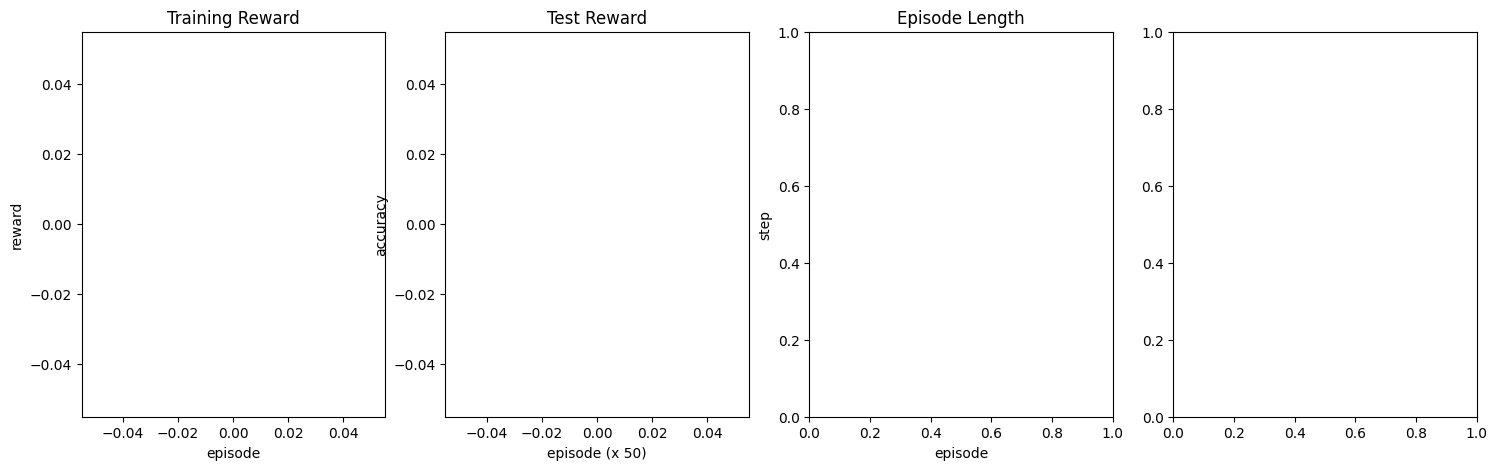

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [ ]:
sum(steps) / len(steps)